## Официальный github репозиторий с библиотекой LightAutoML находится [тут](https://github.com/sberbank-ai-lab/LightAutoML)

# Шаг 0.0. Установка LightAutoML

Данный шаг требуется, если работа ведется не со скачанным из github репозитория кодом, а, например, в Google Colab/Kaggle kernels или вы хотите установить LightAutoML на свою машину: 

In [1]:
#! pip install -U lightautoml

# Шаг 0.1. Импорт нужных библиотек

Здесь мы импортируем все то, что будем использовать в процессе работы:
- Стандартные библиотеки питона для логгинга, закачки данных и т.п.
- Стандартные DS библиотеки типа numpy, pandas и scikit-learn, a также torch (в следующей ячейке поймем зачем)
- Модули нашего LightAutoML, такие как пресеты, таск и декоратор отчетов

In [2]:
# Стандартные питоновские библиотеки
import logging
import os
import time
import requests
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Дополнительное полезное
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# Импорт пресетов, таска и профайлера
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

[2021-06-14 22:34:12,505] (WARNING): /usr/local/lib/python3.6/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)



# Шаг 0.2. Используемые константы

Заранее зададим некоторые параметры-константы, которые будем использовать в процессе решения:
- `N_THREADS` - количество виртуальных ядер ЦПУ, которые выделяются для решения задачи
- `RANDOM_STATE` - случайный сид для воспроизводимости
- `TEST_SIZE` - доля данных, которую отложим в houldout
- `TIMEOUT` - лимит по времени работы (в секундах), который выделяется на решение задачи
- `TARGET_NAME` - название колонки с целевой переменной

In [3]:
N_THREADS = 8 
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 1200 # 20 minutes
TARGET_NAME = 'target'

# Шаг 0.3. Предварительный сетап используемых библиотек

Для большей гарантии воспроизводимости зафиксируем случайный сид из numpy, а также установим максимальное количество потоков для Torch (который очень любит раскатываться на все доступные потоки сервера):

In [4]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Шаг 0.4. Загрузка данных 

Загрузим файл с данными, которые будем в дальнейшем использовать:

In [5]:
%%time

data = pd.read_csv('example_data/jobs_train.csv')
data.head()

CPU times: user 92.3 ms, sys: 9.03 ms, total: 101 ms
Wall time: 35.9 ms


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21.0,NaN,NaN,1.0,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,99.0,Pvt Ltd,5.0,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,0.0,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0.0,NaN,Pvt Ltd,0.0,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21.0,99.0,Funded Startup,4.0,8,0.0


# Шаг 0.5. Разделим данные на трейн и тест 

Поскольку у нас есть только один файл с данными, то для дополнительной проверки качества модели выделим из него 20% в качестве holdout:

In [6]:
%%time

train_data, test_data = train_test_split(data, 
                                         test_size=TEST_SIZE, 
                                         stratify=data[TARGET_NAME], 
                                         random_state=RANDOM_STATE)
logging.info('Data splitted. Parts sizes: train_data = {}, test_data = {}'
              .format(train_data.shape, test_data.shape))

[2021-06-14 22:34:14,372] (INFO): Data splitted. Parts sizes: train_data = (15326, 14), test_data = (3832, 14)


CPU times: user 8.04 ms, sys: 4.02 ms, total: 12.1 ms
Wall time: 11.3 ms


In [7]:
train_data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
17855,6135,city_21,0.624,NaN,Has relevent experience,no_enrollment,Graduate,STEM,10.0,99.0,Pvt Ltd,1.0,90,0.0
17664,6455,city_103,0.920,Male,No relevent experience,no_enrollment,Primary School,NaN,5.0,NaN,NaN,0.0,15,0.0
13404,5856,city_50,0.896,Male,Has relevent experience,no_enrollment,Graduate,STEM,12.0,4999.0,NGO,5.0,36,0.0
13366,27191,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,5.0,500.0,Funded Startup,1.0,53,0.0
15670,16751,city_67,0.855,Female,Has relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,1.0,158,1.0


# =============== Построение LightAutoML модели ===============


# Шаг 1. Создадим Task

В ячейке ниже мы создадим объект типа Task - класса, позволяющего сообщить LightAutoML тип решаемой задачи, а также при необходимости подходящие лосс и метрику качества (более подробно об их задании можно прочитать по [ссылке](https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) в нашей документации):

In [8]:
%%time

task = Task('binary', )

CPU times: user 3.38 ms, sys: 0 ns, total: 3.38 ms
Wall time: 3.11 ms


# Шаг 2. Установим роли для признаков

Для того, чтобы LightAutoML стало понятно, что именно делать с данными, **обязательно** нужно задать какая именно колонка является целевой. Информацию об остальных колонках можно указывать, но это не является обязательным - в LightAutoML встроен автоматический типизатор колонок.

In [9]:
%%time

roles = {'target': TARGET_NAME,
         'drop': ['enrollee_id']
         }

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11 µs


# Шаг 3. Создадим модель LightAutoML - TabularAutoML пресет

В ячейке ниже для создания LightAutoML модели воспользуемся классом `TabularAutoML` - пресетом, позволяющим строить пайплайны типа:

![TabularAutoML preset pipeline](imgs/tutorial_blackbox_pipeline.png)

всего за несколько строк кода. Разберем подробнее передаваемые при инициализации параметры:
- `task` - тип решаемой задачи (единственный **обязательный** параметр)
- `timeout` - время в секундах, выделяемое на решение задачи
- `cpu_limit` - количество виртуальных ядер ЦПУ, выделяемых для решения задачи
- `reader_params` - изменение параметров работы объекта Reader внутри пресета, отвечающего за первоначальную работу с данными, определение их типов, создание корректного кросс-валидационного разбиения и т.п. В нашем случае мы как раз выставим ему `N_THREADS` потоков для определения типов признаков и `RANDOM_STATE` в качестве сида кросс-валидации

**Важное замечание**: ключ `reader_params` является одним из ключей YAML конфига, который используются внутри `TabularAutoML` пресета. [Более подробно](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) его структуру с детальными комментариями можно посмотреть в документации LightAutoML. Каждый ключ из приведенных в этом конфиге может быть изменен пользователем при необходимости на этапе инициализации пресета.

Дополнительно, чтобы на выходе работы с моделью получить автоматический отчет по ней, обернем наш объект типа `TabularAutoML` в декоратор отчета `ReportDeco` и далее будем использовать обернутую версию.

In [10]:
%%time 

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'random_state': RANDOM_STATE},
                       #general_params={'use_algos': [['linear_l2', 'lgb']]}
                      )

RD = ReportDeco(output_path = 'tabularAutoML_model_report')
automl_rd = RD(automl)

oof_pred = automl_rd.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start automl preset with listed constraints:
- time: 1200 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (15326, 14)


[2021-06-14 22:34:19,070] (INFO): Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[2021-06-14 22:34:19,071] (INFO): Note: NumExpr detected 96 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2021-06-14 22:34:19,072] (INFO): NumExpr defaulting to 8 threads.


Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 1188.713149547577 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7304687078366041
Linear model: C = 5e-05 score = 0.7472812332234067
Linear model: C = 0.0001 score = 0.7539177339775546
Linear model: C = 0.0005 score = 0.7639202051963767
Linear model: C = 0.001 score = 0.7670935910218063
Linear model: C = 0.005 score = 0.7712719391682502
Linear model: C = 0.01 score = 0.7721286283599345
Linear model: C = 0.05 score = 0.7725694710739576
Linear model: C = 0.1 score = 0.7725694710739576
Linear model: C = 0.5 score = 0.7722547457343071

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7383899784068388
Linear model: C = 5e-05 score = 0.761550293407601
Linear model: C = 0.0001 score = 0.7725368665114871
Linear model: C = 0.0005 score 

[2021-06-14 22:34:41,440] (INFO): A new study created in memory with name: no-name-4d56f324-8c02-4cf0-bcca-5d648fc28117


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788922
[200]	valid's auc: 0.790716
[300]	valid's auc: 0.788895
[400]	valid's auc: 0.787104
Early stopping, best iteration is:
[235]	valid's auc: 0.791426
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:34:44,771] (INFO): Trial 0 finished with value: 0.7914257228315056 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.7914257228315056.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785844
[200]	valid's auc: 0.787747
[300]	valid's auc: 0.788619
[400]	valid's auc: 0.78649
[500]	valid's auc: 0.785236
Early stopping, best iteration is:
[322]	valid's auc: 0.789002
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:34:51,842] (INFO): Trial 1 finished with value: 0.7890016560006591 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.7914257228315056.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.781226
[200]	valid's auc: 0.788906
[300]	valid's auc: 0.791188
[400]	valid's auc: 0.791856
[500]	valid's auc: 0.792723
[600]	valid's auc: 0.791873
[700]	valid's auc: 0.791941
Early stopping, best iteration is:
[500]	valid's auc: 0.792723
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:34:55,978] (INFO): Trial 2 finished with value: 0.7927226866409319 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.7927226866409319.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790062
[200]	valid's auc: 0.788842
[300]	valid's auc: 0.789906
Early stopping, best iteration is:
[141]	valid's auc: 0.791044
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:00,448] (INFO): Trial 3 finished with value: 0.7910439621307019 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: 0.7927226866409319.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788638
[200]	valid's auc: 0.792114
[300]	valid's auc: 0.792854
[400]	valid's auc: 0.792758
Early stopping, best iteration is:
[282]	valid's auc: 0.793417
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:01,857] (INFO): Trial 4 finished with value: 0.7934174683925432 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 4 with value: 0.7934174683925432.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786887
[200]	valid's auc: 0.789253
[300]	valid's auc: 0.787879
[400]	valid's auc: 0.785202
Early stopping, best iteration is:
[207]	valid's auc: 0.789694
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:05,995] (INFO): Trial 5 finished with value: 0.789693881319006 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 4 with value: 0.7934174683925432.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786344
[200]	valid's auc: 0.792812
[300]	valid's auc: 0.792917
[400]	valid's auc: 0.792478
Early stopping, best iteration is:
[240]	valid's auc: 0.794
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:07,328] (INFO): Trial 6 finished with value: 0.7940000511286653 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786948
[200]	valid's auc: 0.788293
[300]	valid's auc: 0.785665
Early stopping, best iteration is:
[155]	valid's auc: 0.78895
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:12,479] (INFO): Trial 7 finished with value: 0.7889499592390918 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788394
[200]	valid's auc: 0.791356
[300]	valid's auc: 0.79013
Early stopping, best iteration is:
[197]	valid's auc: 0.791815
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:16,210] (INFO): Trial 8 finished with value: 0.7918154368802425 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.783077
[200]	valid's auc: 0.789129
[300]	valid's auc: 0.787143
Early stopping, best iteration is:
[196]	valid's auc: 0.789168
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:20,641] (INFO): Trial 9 finished with value: 0.7891675401146986 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.783613
[200]	valid's auc: 0.79066
[300]	valid's auc: 0.791962
[400]	valid's auc: 0.793486
[500]	valid's auc: 0.793252
[600]	valid's auc: 0.793423
Early stopping, best iteration is:
[402]	valid's auc: 0.793607
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:21,911] (INFO): Trial 10 finished with value: 0.7936074965985235 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 16, 'bagging_fraction': 0.8480589016791605, 'min_sum_hessian_in_leaf': 0.008660554736271515, 'reg_alpha': 1.7238246488428573e-08, 'reg_lambda': 1.475649304728376}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78416
[200]	valid's auc: 0.791892
[300]	valid's auc: 0.792343
[400]	valid's auc: 0.792504
[500]	valid's auc: 0.79304
[600]	valid's auc: 0.793002
[700]	valid's auc: 0.793113
Early stopping, best iteration is:
[564]	valid's auc: 0.793309
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:23,631] (INFO): Trial 11 finished with value: 0.7933089620028803 and parameters: {'feature_fraction': 0.8982689713156164, 'num_leaves': 16, 'bagging_fraction': 0.8760737922573953, 'min_sum_hessian_in_leaf': 0.009516535943251574, 'reg_alpha': 1.6648902228622425e-08, 'reg_lambda': 7.3871412375861425}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788062
[200]	valid's auc: 0.791087
[300]	valid's auc: 0.79044
Early stopping, best iteration is:
[194]	valid's auc: 0.791486
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:25,831] (INFO): Trial 12 finished with value: 0.791485941037287 and parameters: {'feature_fraction': 0.8975870867199489, 'num_leaves': 67, 'bagging_fraction': 0.8314799492356344, 'min_sum_hessian_in_leaf': 0.0048033573489059045, 'reg_alpha': 1.2463219988817348e-08, 'reg_lambda': 1.0244142732026253}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787678
[200]	valid's auc: 0.792015
[300]	valid's auc: 0.792558
[400]	valid's auc: 0.791197
Early stopping, best iteration is:
[248]	valid's auc: 0.793641
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:27,751] (INFO): Trial 13 finished with value: 0.7936407302309595 and parameters: {'feature_fraction': 0.8858320716284691, 'num_leaves': 48, 'bagging_fraction': 0.9913239280399375, 'min_sum_hessian_in_leaf': 0.014253598274463387, 'reg_alpha': 7.113541565483427e-07, 'reg_lambda': 0.14421628604613834}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786568
[200]	valid's auc: 0.790037
[300]	valid's auc: 0.789339
[400]	valid's auc: 0.787988
Early stopping, best iteration is:
[255]	valid's auc: 0.791078
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:30,043] (INFO): Trial 14 finished with value: 0.7910780479075594 and parameters: {'feature_fraction': 0.923817076269483, 'num_leaves': 60, 'bagging_fraction': 0.9968178760098038, 'min_sum_hessian_in_leaf': 0.02552404167488013, 'reg_alpha': 1.6417141569918984e-06, 'reg_lambda': 0.048794491762753106}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786577
[200]	valid's auc: 0.790614
[300]	valid's auc: 0.790643
[400]	valid's auc: 0.789663
Early stopping, best iteration is:
[226]	valid's auc: 0.791785
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:32,235] (INFO): Trial 15 finished with value: 0.7917853277773518 and parameters: {'feature_fraction': 0.828117186504288, 'num_leaves': 61, 'bagging_fraction': 0.9928205992602974, 'min_sum_hessian_in_leaf': 0.00167117935596583, 'reg_alpha': 6.327950387989183e-06, 'reg_lambda': 0.0704101037565748}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787531
[200]	valid's auc: 0.789985
[300]	valid's auc: 0.788809
[400]	valid's auc: 0.786461
Early stopping, best iteration is:
[245]	valid's auc: 0.790649
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:35,680] (INFO): Trial 16 finished with value: 0.7906491352154363 and parameters: {'feature_fraction': 0.9511188615349973, 'num_leaves': 110, 'bagging_fraction': 0.9072950643400716, 'min_sum_hessian_in_leaf': 0.030850798844571294, 'reg_alpha': 1.0997329162304231e-07, 'reg_lambda': 0.004121835640729051}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788859
[200]	valid's auc: 0.791583
[300]	valid's auc: 0.791634
[400]	valid's auc: 0.790777
Early stopping, best iteration is:
[295]	valid's auc: 0.791856
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:39,024] (INFO): Trial 17 finished with value: 0.7918557717161905 and parameters: {'feature_fraction': 0.8478248300112026, 'num_leaves': 89, 'bagging_fraction': 0.7723609967295647, 'min_sum_hessian_in_leaf': 0.002718678725521334, 'reg_alpha': 1.1067016973050875e-05, 'reg_lambda': 0.6449594920823252}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786129
[200]	valid's auc: 0.789035
[300]	valid's auc: 0.789755
[400]	valid's auc: 0.787933
Early stopping, best iteration is:
[275]	valid's auc: 0.790309
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:44,547] (INFO): Trial 18 finished with value: 0.7903088455431426 and parameters: {'feature_fraction': 0.647363321235647, 'num_leaves': 177, 'bagging_fraction': 0.9577636338193465, 'min_sum_hessian_in_leaf': 0.010719492617066511, 'reg_alpha': 1.1138632919825352e-07, 'reg_lambda': 7.639371274654828e-06}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785888
[200]	valid's auc: 0.792041
[300]	valid's auc: 0.793222
[400]	valid's auc: 0.79233
[500]	valid's auc: 0.791168
Early stopping, best iteration is:
[312]	valid's auc: 0.793542
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:46,363] (INFO): Trial 19 finished with value: 0.7935421655262134 and parameters: {'feature_fraction': 0.7652138884025161, 'num_leaves': 38, 'bagging_fraction': 0.9023923392814068, 'min_sum_hessian_in_leaf': 0.05444957302011274, 'reg_alpha': 0.13852428395503005, 'reg_lambda': 0.0021069733329307254}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787895
[200]	valid's auc: 0.791488
[300]	valid's auc: 0.791306
[400]	valid's auc: 0.790101
Early stopping, best iteration is:
[204]	valid's auc: 0.791758
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:47,936] (INFO): Trial 20 finished with value: 0.7917580591558656 and parameters: {'feature_fraction': 0.9512784567106741, 'num_leaves': 42, 'bagging_fraction': 0.99672018191775, 'min_sum_hessian_in_leaf': 0.01576003494531386, 'reg_alpha': 4.660982599177124e-06, 'reg_lambda': 0.23288577741764308}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785702
[200]	valid's auc: 0.792637
[300]	valid's auc: 0.793763
[400]	valid's auc: 0.79379
[500]	valid's auc: 0.793429
Early stopping, best iteration is:
[372]	valid's auc: 0.79437
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:49,722] (INFO): Trial 21 finished with value: 0.7943695977594283 and parameters: {'feature_fraction': 0.8816305981830896, 'num_leaves': 24, 'bagging_fraction': 0.8498611526685024, 'min_sum_hessian_in_leaf': 9.278969835148601, 'reg_alpha': 1.1392141808778415e-08, 'reg_lambda': 3.775701078267658}. Best is trial 21 with value: 0.7943695977594283.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.783965
[200]	valid's auc: 0.79276
[300]	valid's auc: 0.793658
[400]	valid's auc: 0.793404
Early stopping, best iteration is:
[247]	valid's auc: 0.794203
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:50,779] (INFO): Trial 22 finished with value: 0.7942025774528266 and parameters: {'feature_fraction': 0.8590191983118689, 'num_leaves': 16, 'bagging_fraction': 0.8758712014092962, 'min_sum_hessian_in_leaf': 8.285425657012055, 'reg_alpha': 4.699715188357232e-08, 'reg_lambda': 6.565448604358697}. Best is trial 21 with value: 0.7943695977594283.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784604
[200]	valid's auc: 0.792038
[300]	valid's auc: 0.793678
[400]	valid's auc: 0.79418
[500]	valid's auc: 0.794546
[600]	valid's auc: 0.794736
[700]	valid's auc: 0.794697
[800]	valid's auc: 0.794262
Early stopping, best iteration is:
[647]	valid's auc: 0.794991
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:53,038] (INFO): Trial 23 finished with value: 0.7949910950907961 and parameters: {'feature_fraction': 0.9412478892503501, 'num_leaves': 19, 'bagging_fraction': 0.8550683056895925, 'min_sum_hessian_in_leaf': 9.242698502972436, 'reg_alpha': 7.201677944417886e-08, 'reg_lambda': 6.329816648348431}. Best is trial 23 with value: 0.7949910950907961.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78525
[200]	valid's auc: 0.791117
[300]	valid's auc: 0.792378
[400]	valid's auc: 0.793454
[500]	valid's auc: 0.79334
[600]	valid's auc: 0.79331
[700]	valid's auc: 0.793152
Early stopping, best iteration is:
[570]	valid's auc: 0.793858
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:55,535] (INFO): Trial 24 finished with value: 0.7938577430102852 and parameters: {'feature_fraction': 0.8552510304566178, 'num_leaves': 24, 'bagging_fraction': 0.7826139030190828, 'min_sum_hessian_in_leaf': 9.08347803948606, 'reg_alpha': 1.738621393169817e-08, 'reg_lambda': 7.706997993236833}. Best is trial 23 with value: 0.7949910950907961.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784275
[200]	valid's auc: 0.791239
[300]	valid's auc: 0.792921
[400]	valid's auc: 0.792925
[500]	valid's auc: 0.791734
Early stopping, best iteration is:
[337]	valid's auc: 0.793882
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:35:59,713] (INFO): Trial 25 finished with value: 0.7938821711503665 and parameters: {'feature_fraction': 0.7796487870626706, 'num_leaves': 83, 'bagging_fraction': 0.8541732493559648, 'min_sum_hessian_in_leaf': 7.627730753999613, 'reg_alpha': 6.766822252953716e-08, 'reg_lambda': 7.480671175703715}. Best is trial 23 with value: 0.7949910950907961.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788299
[200]	valid's auc: 0.791642
[300]	valid's auc: 0.791543
[400]	valid's auc: 0.790495
Early stopping, best iteration is:
[240]	valid's auc: 0.79208
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:03,237] (INFO): Trial 26 finished with value: 0.7920796016508879 and parameters: {'feature_fraction': 0.9259037964457202, 'num_leaves': 80, 'bagging_fraction': 0.8125063046704508, 'min_sum_hessian_in_leaf': 4.388788087941508, 'reg_alpha': 1.2745281780795915e-08, 'reg_lambda': 2.4500398940103127}. Best is trial 23 with value: 0.7949910950907961.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.782887
[200]	valid's auc: 0.792018
[300]	valid's auc: 0.793936
[400]	valid's auc: 0.79443
[500]	valid's auc: 0.794729
[600]	valid's auc: 0.795154
[700]	valid's auc: 0.795643
[800]	valid's auc: 0.795034
Early stopping, best iteration is:
[672]	valid's auc: 0.795752
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:05,602] (INFO): Trial 27 finished with value: 0.7957517760109983 and parameters: {'feature_fraction': 0.8539646820354401, 'num_leaves': 18, 'bagging_fraction': 0.8719428586775141, 'min_sum_hessian_in_leaf': 4.3176662800583845, 'reg_alpha': 1.3967480786852633e-07, 'reg_lambda': 8.476844121888826}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789152
[200]	valid's auc: 0.793821
[300]	valid's auc: 0.794226
[400]	valid's auc: 0.794442
[500]	valid's auc: 0.792709
Early stopping, best iteration is:
[379]	valid's auc: 0.794702
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:08,431] (INFO): Trial 28 finished with value: 0.7947019340837884 and parameters: {'feature_fraction': 0.8185164630236712, 'num_leaves': 49, 'bagging_fraction': 0.6928359649631521, 'min_sum_hessian_in_leaf': 2.5274763722643843, 'reg_alpha': 4.765278893803372e-07, 'reg_lambda': 0.4294935989241816}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789138
[200]	valid's auc: 0.790931
[300]	valid's auc: 0.788712
Early stopping, best iteration is:
[134]	valid's auc: 0.791604
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:11,604] (INFO): Trial 29 finished with value: 0.7916035369674452 and parameters: {'feature_fraction': 0.734861439691421, 'num_leaves': 111, 'bagging_fraction': 0.6559661481755027, 'min_sum_hessian_in_leaf': 2.9716885112695386, 'reg_alpha': 2.049211281508803e-05, 'reg_lambda': 0.701730456415678}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790679
[200]	valid's auc: 0.792887
[300]	valid's auc: 0.792752
[400]	valid's auc: 0.793086
Early stopping, best iteration is:
[221]	valid's auc: 0.79346
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:13,729] (INFO): Trial 30 finished with value: 0.793459507517334 and parameters: {'feature_fraction': 0.6979788686352886, 'num_leaves': 51, 'bagging_fraction': 0.6340533191123581, 'min_sum_hessian_in_leaf': 0.6135281892184511, 'reg_alpha': 1.975876511088104e-06, 'reg_lambda': 0.23335652840938473}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.783994
[200]	valid's auc: 0.791513
[300]	valid's auc: 0.7935
[400]	valid's auc: 0.794117
[500]	valid's auc: 0.794315
[600]	valid's auc: 0.79436
[700]	valid's auc: 0.793842
Early stopping, best iteration is:
[525]	valid's auc: 0.794679
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:15,698] (INFO): Trial 31 finished with value: 0.7946786421362693 and parameters: {'feature_fraction': 0.8280777227579745, 'num_leaves': 18, 'bagging_fraction': 0.699651477255919, 'min_sum_hessian_in_leaf': 5.161833589901497, 'reg_alpha': 3.5148147715299536e-07, 'reg_lambda': 9.924201009241736}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788641
[200]	valid's auc: 0.794991
[300]	valid's auc: 0.793632
[400]	valid's auc: 0.793521
Early stopping, best iteration is:
[217]	valid's auc: 0.795192
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:17,544] (INFO): Trial 32 finished with value: 0.795191633077974 and parameters: {'feature_fraction': 0.820818755603418, 'num_leaves': 41, 'bagging_fraction': 0.6961213313847646, 'min_sum_hessian_in_leaf': 4.489412257898747, 'reg_alpha': 2.919806522982103e-07, 'reg_lambda': 1.9306358478567414}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789088
[200]	valid's auc: 0.791334
[300]	valid's auc: 0.789504
[400]	valid's auc: 0.789565
Early stopping, best iteration is:
[232]	valid's auc: 0.791546
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:20,380] (INFO): Trial 33 finished with value: 0.7915461592430686 and parameters: {'feature_fraction': 0.8152169050328515, 'num_leaves': 71, 'bagging_fraction': 0.6958834313768805, 'min_sum_hessian_in_leaf': 0.8162922122019087, 'reg_alpha': 2.3945988322576107e-07, 'reg_lambda': 0.37268396803836834}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788828
[200]	valid's auc: 0.793023
[300]	valid's auc: 0.792017
[400]	valid's auc: 0.789842
Early stopping, best iteration is:
[233]	valid's auc: 0.793299
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:24,070] (INFO): Trial 34 finished with value: 0.793299304366104 and parameters: {'feature_fraction': 0.7752285457286441, 'num_leaves': 93, 'bagging_fraction': 0.5616367182517847, 'min_sum_hessian_in_leaf': 2.257977909083286, 'reg_alpha': 0.007985614889275936, 'reg_lambda': 2.0600895848565632}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787173
[200]	valid's auc: 0.792638
[300]	valid's auc: 0.793992
[400]	valid's auc: 0.79415
Early stopping, best iteration is:
[247]	valid's auc: 0.794526
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:25,889] (INFO): Trial 35 finished with value: 0.7945255401885513 and parameters: {'feature_fraction': 0.7484981189240343, 'num_leaves': 38, 'bagging_fraction': 0.6130196578125714, 'min_sum_hessian_in_leaf': 0.24836210143843027, 'reg_alpha': 1.5355348210963326e-06, 'reg_lambda': 1.932934458740742}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789473
[200]	valid's auc: 0.792165
[300]	valid's auc: 0.792733
[400]	valid's auc: 0.791784
Early stopping, best iteration is:
[283]	valid's auc: 0.793045
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:28,612] (INFO): Trial 36 finished with value: 0.793044797232235 and parameters: {'feature_fraction': 0.7984908266706026, 'num_leaves': 55, 'bagging_fraction': 0.7621562796971536, 'min_sum_hessian_in_leaf': 1.2807604459292792, 'reg_alpha': 0.0004299193764423973, 'reg_lambda': 0.007844751042023769}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788675
[200]	valid's auc: 0.794694
[300]	valid's auc: 0.792301
[400]	valid's auc: 0.791292
Early stopping, best iteration is:
[204]	valid's auc: 0.794911
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:30,119] (INFO): Trial 37 finished with value: 0.7949107094670406 and parameters: {'feature_fraction': 0.92836719573802, 'num_leaves': 33, 'bagging_fraction': 0.5720379429437802, 'min_sum_hessian_in_leaf': 4.373343547697151, 'reg_alpha': 0.00010622317682443316, 'reg_lambda': 0.0006902065535829201}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791102
[200]	valid's auc: 0.790173
[300]	valid's auc: 0.788088
Early stopping, best iteration is:
[124]	valid's auc: 0.791905
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:33,664] (INFO): Trial 38 finished with value: 0.7919046279963529 and parameters: {'feature_fraction': 0.9271334838876464, 'num_leaves': 125, 'bagging_fraction': 0.5299994363221872, 'min_sum_hessian_in_leaf': 4.227618241379014, 'reg_alpha': 3.512279883841353e-05, 'reg_lambda': 1.5532136288756492e-06}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786515
[200]	valid's auc: 0.789345
[300]	valid's auc: 0.790862
[400]	valid's auc: 0.790379
[500]	valid's auc: 0.790956
Early stopping, best iteration is:
[319]	valid's auc: 0.792032
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:35,429] (INFO): Trial 39 finished with value: 0.7920318815632873 and parameters: {'feature_fraction': 0.5007250058963768, 'num_leaves': 33, 'bagging_fraction': 0.563748124814059, 'min_sum_hessian_in_leaf': 0.9931617940066574, 'reg_alpha': 0.00011572335626207446, 'reg_lambda': 0.0002510744040064188}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788563
[200]	valid's auc: 0.788104
Early stopping, best iteration is:
[37]	valid's auc: 0.789837
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:39,320] (INFO): Trial 40 finished with value: 0.7898370415818072 and parameters: {'feature_fraction': 0.9985649803160843, 'num_leaves': 189, 'bagging_fraction': 0.7990960769244367, 'min_sum_hessian_in_leaf': 4.8555154746851725, 'reg_alpha': 0.01617244538986026, 'reg_lambda': 3.852720254572111e-08}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788327
[200]	valid's auc: 0.793177
[300]	valid's auc: 0.794184
[400]	valid's auc: 0.793684
Early stopping, best iteration is:
[257]	valid's auc: 0.794365
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:41,366] (INFO): Trial 41 finished with value: 0.7943650529891807 and parameters: {'feature_fraction': 0.8494247260386838, 'num_leaves': 41, 'bagging_fraction': 0.7409047357547275, 'min_sum_hessian_in_leaf': 2.0096067741441996, 'reg_alpha': 1.6596852922402217e-07, 'reg_lambda': 0.001037640709732365}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788639
[200]	valid's auc: 0.794409
[300]	valid's auc: 0.79439
[400]	valid's auc: 0.794257
Early stopping, best iteration is:
[231]	valid's auc: 0.794826
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:42,767] (INFO): Trial 42 finished with value: 0.7948257790730372 and parameters: {'feature_fraction': 0.9532627353387357, 'num_leaves': 30, 'bagging_fraction': 0.6858276955060028, 'min_sum_hessian_in_leaf': 3.054614732139654, 'reg_alpha': 6.813956532661158e-07, 'reg_lambda': 2.206084107752794e-05}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786723
[200]	valid's auc: 0.793016
[300]	valid's auc: 0.792227
[400]	valid's auc: 0.791739
Early stopping, best iteration is:
[214]	valid's auc: 0.793208
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:44,093] (INFO): Trial 43 finished with value: 0.7932078408648698 and parameters: {'feature_fraction': 0.961082860579537, 'num_leaves': 28, 'bagging_fraction': 0.6637353514067533, 'min_sum_hessian_in_leaf': 6.015444781553844, 'reg_alpha': 2.374559083985091e-06, 'reg_lambda': 1.892338912731277e-05}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.783487
[200]	valid's auc: 0.790343
[300]	valid's auc: 0.790179
[400]	valid's auc: 0.791565
[500]	valid's auc: 0.790809
Early stopping, best iteration is:
[375]	valid's auc: 0.791814
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:45,386] (INFO): Trial 44 finished with value: 0.7918137325913995 and parameters: {'feature_fraction': 0.9193015275288577, 'num_leaves': 16, 'bagging_fraction': 0.5945983035721614, 'min_sum_hessian_in_leaf': 3.6313067810573716, 'reg_alpha': 0.001806797306611965, 'reg_lambda': 6.923080463085894e-05}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789679
[200]	valid's auc: 0.791507
[300]	valid's auc: 0.790076
Early stopping, best iteration is:
[197]	valid's auc: 0.791779
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:47,882] (INFO): Trial 45 finished with value: 0.7917790787182613 and parameters: {'feature_fraction': 0.9987935616926054, 'num_leaves': 72, 'bagging_fraction': 0.7095706381041229, 'min_sum_hessian_in_leaf': 1.5450981367967098, 'reg_alpha': 4.695901323865143e-08, 'reg_lambda': 2.3482905064351917e-06}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787494
[200]	valid's auc: 0.792455
[300]	valid's auc: 0.792451
[400]	valid's auc: 0.790747
Early stopping, best iteration is:
[226]	valid's auc: 0.793277
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:49,322] (INFO): Trial 46 finished with value: 0.7932765805148656 and parameters: {'feature_fraction': 0.8722811399457586, 'num_leaves': 30, 'bagging_fraction': 0.5083943313653723, 'min_sum_hessian_in_leaf': 0.49192536194097797, 'reg_alpha': 7.591621400091274e-07, 'reg_lambda': 0.00021715325667375935}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785297
[200]	valid's auc: 0.790798
[300]	valid's auc: 0.790827
[400]	valid's auc: 0.791876
[500]	valid's auc: 0.791811
[600]	valid's auc: 0.792068
[700]	valid's auc: 0.791895
Early stopping, best iteration is:
[558]	valid's auc: 0.792489
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:51,038] (INFO): Trial 47 finished with value: 0.7924886309731773 and parameters: {'feature_fraction': 0.905971231558927, 'num_leaves': 16, 'bagging_fraction': 0.6706991981120334, 'min_sum_hessian_in_leaf': 3.252516229973764, 'reg_alpha': 7.816653535333004e-05, 'reg_lambda': 1.4665103824417582e-07}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787183
[200]	valid's auc: 0.790916
[300]	valid's auc: 0.789838
[400]	valid's auc: 0.789136
Early stopping, best iteration is:
[212]	valid's auc: 0.791292
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:53,342] (INFO): Trial 48 finished with value: 0.7912916521091994 and parameters: {'feature_fraction': 0.9764535515435225, 'num_leaves': 59, 'bagging_fraction': 0.7311356070534079, 'min_sum_hessian_in_leaf': 0.3166843283342858, 'reg_alpha': 0.11413109603489216, 'reg_lambda': 1.0897449950353188e-05}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789705
[200]	valid's auc: 0.790763
[300]	valid's auc: 0.791769
[400]	valid's auc: 0.790432
Early stopping, best iteration is:
[288]	valid's auc: 0.792019
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:55,939] (INFO): Trial 49 finished with value: 0.7920185313006848 and parameters: {'feature_fraction': 0.9399355937984731, 'num_leaves': 47, 'bagging_fraction': 0.948779238688565, 'min_sum_hessian_in_leaf': 6.410017477005098, 'reg_alpha': 4.522388730310782e-08, 'reg_lambda': 4.8771089871969e-05}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787037
[200]	valid's auc: 0.790267
[300]	valid's auc: 0.791475
[400]	valid's auc: 0.79239
[500]	valid's auc: 0.791752
Early stopping, best iteration is:
[374]	valid's auc: 0.79296
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:36:57,787] (INFO): Trial 50 finished with value: 0.7929598668382317 and parameters: {'feature_fraction': 0.9114334791769951, 'num_leaves': 27, 'bagging_fraction': 0.6238166892745556, 'min_sum_hessian_in_leaf': 1.5800876898782135, 'reg_alpha': 9.719317128234183e-07, 'reg_lambda': 3.122495458195603e-06}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788921
[200]	valid's auc: 0.794145
[300]	valid's auc: 0.794679
[400]	valid's auc: 0.794136
Early stopping, best iteration is:
[235]	valid's auc: 0.795347
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:00,176] (INFO): Trial 51 finished with value: 0.7953467233626756 and parameters: {'feature_fraction': 0.8279440675662983, 'num_leaves': 49, 'bagging_fraction': 0.6845719285325974, 'min_sum_hessian_in_leaf': 9.674689008811077, 'reg_alpha': 2.403848452843659e-07, 'reg_lambda': 0.09293718706754697}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789799
[200]	valid's auc: 0.793773
[300]	valid's auc: 0.794209
[400]	valid's auc: 0.793649
Early stopping, best iteration is:
[289]	valid's auc: 0.79454
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:02,276] (INFO): Trial 52 finished with value: 0.794540310691856 and parameters: {'feature_fraction': 0.8397827116570438, 'num_leaves': 36, 'bagging_fraction': 0.7543410468800569, 'min_sum_hessian_in_leaf': 9.534891120092517, 'reg_alpha': 1.7422391321741418e-07, 'reg_lambda': 0.0183300854308565}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788975
[200]	valid's auc: 0.792177
[300]	valid's auc: 0.790302
[400]	valid's auc: 0.787817
Early stopping, best iteration is:
[233]	valid's auc: 0.792593
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:05,133] (INFO): Trial 53 finished with value: 0.7925925925925927 and parameters: {'feature_fraction': 0.8777760542072006, 'num_leaves': 66, 'bagging_fraction': 0.6739420323556409, 'min_sum_hessian_in_leaf': 5.552973577576149, 'reg_alpha': 6.05368669393442e-06, 'reg_lambda': 0.11213756540932326}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787948
[200]	valid's auc: 0.792685
[300]	valid's auc: 0.791795
[400]	valid's auc: 0.791444
Early stopping, best iteration is:
[257]	valid's auc: 0.793146
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:07,164] (INFO): Trial 54 finished with value: 0.7931459183702454 and parameters: {'feature_fraction': 0.941036263988895, 'num_leaves': 43, 'bagging_fraction': 0.7152732749461159, 'min_sum_hessian_in_leaf': 3.1824894840380833, 'reg_alpha': 2.7158728073493037e-08, 'reg_lambda': 0.0280626450086948}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786525
[200]	valid's auc: 0.792024
[300]	valid's auc: 0.791925
[400]	valid's auc: 0.792434
Early stopping, best iteration is:
[226]	valid's auc: 0.793052
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:08,404] (INFO): Trial 55 finished with value: 0.7930524665320278 and parameters: {'feature_fraction': 0.9696895129096733, 'num_leaves': 21, 'bagging_fraction': 0.8879611930510266, 'min_sum_hessian_in_leaf': 6.358022199996381, 'reg_alpha': 3.5284066330981984e-06, 'reg_lambda': 0.0009450340432817023}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786171
[200]	valid's auc: 0.790722
[300]	valid's auc: 0.792975
[400]	valid's auc: 0.792535
[500]	valid's auc: 0.791765
Early stopping, best iteration is:
[316]	valid's auc: 0.793204
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:10,219] (INFO): Trial 56 finished with value: 0.7932038641909032 and parameters: {'feature_fraction': 0.7971728636468192, 'num_leaves': 31, 'bagging_fraction': 0.6409137327050356, 'min_sum_hessian_in_leaf': 1.9361242977109951, 'reg_alpha': 3.252126546371349e-07, 'reg_lambda': 0.00010734965644821994}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.7888
[200]	valid's auc: 0.793073
[300]	valid's auc: 0.792778
[400]	valid's auc: 0.793012
Early stopping, best iteration is:
[220]	valid's auc: 0.793983
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:12,652] (INFO): Trial 57 finished with value: 0.793982724192096 and parameters: {'feature_fraction': 0.8662631303204595, 'num_leaves': 54, 'bagging_fraction': 0.6796877578057093, 'min_sum_hessian_in_leaf': 9.055411352586376, 'reg_alpha': 1.3657578186840541e-05, 'reg_lambda': 3.4624427079762}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78863
[200]	valid's auc: 0.790567
[300]	valid's auc: 0.790213
[400]	valid's auc: 0.788827
Early stopping, best iteration is:
[223]	valid's auc: 0.791063
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:16,494] (INFO): Trial 58 finished with value: 0.7910627093079735 and parameters: {'feature_fraction': 0.896197686657751, 'num_leaves': 100, 'bagging_fraction': 0.9180813264830823, 'min_sum_hessian_in_leaf': 1.184951216712442, 'reg_alpha': 1.0425640917548005e-07, 'reg_lambda': 0.9120310086425982}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788945
[200]	valid's auc: 0.790768
[300]	valid's auc: 0.789536
[400]	valid's auc: 0.78748
Early stopping, best iteration is:
[240]	valid's auc: 0.791128
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:21,219] (INFO): Trial 59 finished with value: 0.7911280403802837 and parameters: {'feature_fraction': 0.8352091409869746, 'num_leaves': 157, 'bagging_fraction': 0.814723378601359, 'min_sum_hessian_in_leaf': 9.47147054059411, 'reg_alpha': 2.9327467364758624e-08, 'reg_lambda': 0.006732058827797063}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786959
[200]	valid's auc: 0.792835
[300]	valid's auc: 0.792974
[400]	valid's auc: 0.793387
[500]	valid's auc: 0.792416
Early stopping, best iteration is:
[363]	valid's auc: 0.794042
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:22,881] (INFO): Trial 60 finished with value: 0.7940423743015966 and parameters: {'feature_fraction': 0.9877133773744696, 'num_leaves': 23, 'bagging_fraction': 0.8286517291127415, 'min_sum_hessian_in_leaf': 3.869473534229058, 'reg_alpha': 9.735362256039746e-07, 'reg_lambda': 2.660241053062253e-05}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788835
[200]	valid's auc: 0.791033
[300]	valid's auc: 0.790106
[400]	valid's auc: 0.789738
Early stopping, best iteration is:
[231]	valid's auc: 0.791627
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:25,037] (INFO): Trial 61 finished with value: 0.791626544866824 and parameters: {'feature_fraction': 0.8183752354546463, 'num_leaves': 44, 'bagging_fraction': 0.7308522573719093, 'min_sum_hessian_in_leaf': 2.6400415226942684, 'reg_alpha': 3.701951820318947e-07, 'reg_lambda': 0.43891242462873237}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790948
[200]	valid's auc: 0.794065
[300]	valid's auc: 0.794322
[400]	valid's auc: 0.793206
Early stopping, best iteration is:
[256]	valid's auc: 0.795061
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:27,334] (INFO): Trial 62 finished with value: 0.7950606868852134 and parameters: {'feature_fraction': 0.7771356753642014, 'num_leaves': 48, 'bagging_fraction': 0.6916389375861298, 'min_sum_hessian_in_leaf': 2.42200669450626, 'reg_alpha': 4.545765980901138e-07, 'reg_lambda': 0.07477395481928265}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786557
[200]	valid's auc: 0.790589
[300]	valid's auc: 0.788603
[400]	valid's auc: 0.786526
Early stopping, best iteration is:
[201]	valid's auc: 0.790646
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:30,298] (INFO): Trial 63 finished with value: 0.7906457266377506 and parameters: {'feature_fraction': 0.7597496735104224, 'num_leaves': 76, 'bagging_fraction': 0.6502640660417841, 'min_sum_hessian_in_leaf': 7.332891715671267, 'reg_alpha': 9.903476610183775e-08, 'reg_lambda': 0.0922711620676459}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.779368
[200]	valid's auc: 0.788287
[300]	valid's auc: 0.790235
[400]	valid's auc: 0.792585
[500]	valid's auc: 0.792506
[600]	valid's auc: 0.793011
[700]	valid's auc: 0.792457
Early stopping, best iteration is:
[556]	valid's auc: 0.793253
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:34,366] (INFO): Trial 64 finished with value: 0.7932527204710654 and parameters: {'feature_fraction': 0.7239561848527085, 'num_leaves': 65, 'bagging_fraction': 0.6006068878825768, 'min_sum_hessian_in_leaf': 4.2956302216563005, 'reg_alpha': 4.875848955082194, 'reg_lambda': 4.5757192402977385}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791162
[200]	valid's auc: 0.793243
[300]	valid's auc: 0.792294
Early stopping, best iteration is:
[159]	valid's auc: 0.794297
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:36,279] (INFO): Trial 65 finished with value: 0.7942965973873253 and parameters: {'feature_fraction': 0.7804609433679423, 'num_leaves': 55, 'bagging_fraction': 0.7834900766921455, 'min_sum_hessian_in_leaf': 1.8030935705521292, 'reg_alpha': 2.1782089102923442e-07, 'reg_lambda': 0.0018816292196215526}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78783
[200]	valid's auc: 0.792979
[300]	valid's auc: 0.794463
[400]	valid's auc: 0.793258
Early stopping, best iteration is:
[294]	valid's auc: 0.794801
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:38,183] (INFO): Trial 66 finished with value: 0.7948007828366751 and parameters: {'feature_fraction': 0.663429946280047, 'num_leaves': 34, 'bagging_fraction': 0.6846622138951579, 'min_sum_hessian_in_leaf': 2.559868189934913, 'reg_alpha': 5.825300988087288e-07, 'reg_lambda': 0.23418968995307457}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790945
[200]	valid's auc: 0.793467
[300]	valid's auc: 0.792433
Early stopping, best iteration is:
[190]	valid's auc: 0.793665
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:40,237] (INFO): Trial 67 finished with value: 0.7936645902747598 and parameters: {'feature_fraction': 0.8892375464942623, 'num_leaves': 49, 'bagging_fraction': 0.573350627779138, 'min_sum_hessian_in_leaf': 6.8457307152562485, 'reg_alpha': 2.5561084788495288e-08, 'reg_lambda': 1.2896198039364708}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785044
[200]	valid's auc: 0.791596
[300]	valid's auc: 0.792751
[400]	valid's auc: 0.7927
[500]	valid's auc: 0.792149
Early stopping, best iteration is:
[327]	valid's auc: 0.793167
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:41,620] (INFO): Trial 68 finished with value: 0.7931669379326407 and parameters: {'feature_fraction': 0.8064682317044197, 'num_leaves': 16, 'bagging_fraction': 0.871741031448603, 'min_sum_hessian_in_leaf': 9.837192534382625, 'reg_alpha': 1.5821796396458686e-06, 'reg_lambda': 0.039874158412508263}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788922
[200]	valid's auc: 0.791718
[300]	valid's auc: 0.792009
[400]	valid's auc: 0.791934
Early stopping, best iteration is:
[241]	valid's auc: 0.79419
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:43,304] (INFO): Trial 69 finished with value: 0.7941895112383646 and parameters: {'feature_fraction': 0.7497998257923695, 'num_leaves': 37, 'bagging_fraction': 0.5359393817986567, 'min_sum_hessian_in_leaf': 0.9591445369333934, 'reg_alpha': 7.407305824630364e-08, 'reg_lambda': 0.009466044577525583}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785621
[200]	valid's auc: 0.792207
[300]	valid's auc: 0.791348
[400]	valid's auc: 0.790659
Early stopping, best iteration is:
[221]	valid's auc: 0.792657
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:46,022] (INFO): Trial 70 finished with value: 0.7926573555686218 and parameters: {'feature_fraction': 0.9396343334923805, 'num_leaves': 60, 'bagging_fraction': 0.709888481845373, 'min_sum_hessian_in_leaf': 5.20336821770283, 'reg_alpha': 7.5807144407493344e-06, 'reg_lambda': 9.354132334034793}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788676
[200]	valid's auc: 0.792621
[300]	valid's auc: 0.793402
[400]	valid's auc: 0.793037
Early stopping, best iteration is:
[267]	valid's auc: 0.793709
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:47,896] (INFO): Trial 71 finished with value: 0.7937089017846746 and parameters: {'feature_fraction': 0.6388825661859666, 'num_leaves': 33, 'bagging_fraction': 0.6759808174107954, 'min_sum_hessian_in_leaf': 2.7093978874492124, 'reg_alpha': 5.858764623865841e-07, 'reg_lambda': 0.20889685242678654}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786583
[200]	valid's auc: 0.791786
[300]	valid's auc: 0.793079
[400]	valid's auc: 0.793541
Early stopping, best iteration is:
[243]	valid's auc: 0.793878
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:49,177] (INFO): Trial 72 finished with value: 0.7938779104282594 and parameters: {'feature_fraction': 0.6673025229297169, 'num_leaves': 23, 'bagging_fraction': 0.6831904600804516, 'min_sum_hessian_in_leaf': 3.860577028502751, 'reg_alpha': 1.705907753153878e-07, 'reg_lambda': 0.057948726363415484}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786494
[200]	valid's auc: 0.791622
[300]	valid's auc: 0.792485
[400]	valid's auc: 0.792219
[500]	valid's auc: 0.791498
Early stopping, best iteration is:
[345]	valid's auc: 0.793116
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:51,546] (INFO): Trial 73 finished with value: 0.7931163773636357 and parameters: {'feature_fraction': 0.5868755788328603, 'num_leaves': 43, 'bagging_fraction': 0.6360539465947037, 'min_sum_hessian_in_leaf': 2.159743713520524, 'reg_alpha': 4.965858418684947e-07, 'reg_lambda': 0.14915292069212152}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78746
[200]	valid's auc: 0.792225
[300]	valid's auc: 0.792293
[400]	valid's auc: 0.792706
[500]	valid's auc: 0.791314
Early stopping, best iteration is:
[376]	valid's auc: 0.793041
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:53,800] (INFO): Trial 74 finished with value: 0.7930408205582682 and parameters: {'feature_fraction': 0.7100087040436085, 'num_leaves': 35, 'bagging_fraction': 0.745018326183217, 'min_sum_hessian_in_leaf': 2.9798491153922027, 'reg_alpha': 3.0888747091410973e-06, 'reg_lambda': 0.5415370056190356}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787366
[200]	valid's auc: 0.794487
[300]	valid's auc: 0.794441
[400]	valid's auc: 0.794604
Early stopping, best iteration is:
[228]	valid's auc: 0.795513
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:55,168] (INFO): Trial 75 finished with value: 0.7955131755729961 and parameters: {'feature_fraction': 0.7855809557591518, 'num_leaves': 26, 'bagging_fraction': 0.69974261201136, 'min_sum_hessian_in_leaf': 4.9742656745403435, 'reg_alpha': 1.044992965355285e-08, 'reg_lambda': 1.2373581666259788}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787456
[200]	valid's auc: 0.794071
[300]	valid's auc: 0.794705
[400]	valid's auc: 0.794584
[500]	valid's auc: 0.794826
Early stopping, best iteration is:
[322]	valid's auc: 0.794972
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:56,847] (INFO): Trial 76 finished with value: 0.7949723479135244 and parameters: {'feature_fraction': 0.7856721937883866, 'num_leaves': 25, 'bagging_fraction': 0.6962585444509474, 'min_sum_hessian_in_leaf': 0.07112135620370105, 'reg_alpha': 1.0370468345877984e-08, 'reg_lambda': 3.1353130365096518}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785885
[200]	valid's auc: 0.792982
[300]	valid's auc: 0.794244
[400]	valid's auc: 0.794716
Early stopping, best iteration is:
[262]	valid's auc: 0.795147
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:58,180] (INFO): Trial 77 finished with value: 0.7951470375199189 and parameters: {'feature_fraction': 0.7762194478592546, 'num_leaves': 22, 'bagging_fraction': 0.7200224625564522, 'min_sum_hessian_in_leaf': 0.049736385879393344, 'reg_alpha': 1.0235967657155481e-08, 'reg_lambda': 3.5551982706965877}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785933
[200]	valid's auc: 0.793025
[300]	valid's auc: 0.794614
[400]	valid's auc: 0.795806
[500]	valid's auc: 0.795636
Early stopping, best iteration is:
[393]	valid's auc: 0.79604
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:37:59,789] (INFO): Trial 78 finished with value: 0.7960400848735844 and parameters: {'feature_fraction': 0.7847719126503185, 'num_leaves': 20, 'bagging_fraction': 0.7180770755740242, 'min_sum_hessian_in_leaf': 0.07094585872079867, 'reg_alpha': 1.2021017430750593e-08, 'reg_lambda': 2.95266001223712}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786336
[200]	valid's auc: 0.792901
[300]	valid's auc: 0.794554
[400]	valid's auc: 0.795283
[500]	valid's auc: 0.795572
[600]	valid's auc: 0.795004
Early stopping, best iteration is:
[497]	valid's auc: 0.795606
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:01,451] (INFO): Trial 79 finished with value: 0.7956057752667922 and parameters: {'feature_fraction': 0.7664365934433386, 'num_leaves': 17, 'bagging_fraction': 0.7191380761262884, 'min_sum_hessian_in_leaf': 0.04241355993967631, 'reg_alpha': 1.7718170426654616e-08, 'reg_lambda': 1.5255904737226398}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786816
[200]	valid's auc: 0.79246
[300]	valid's auc: 0.793557
[400]	valid's auc: 0.79425
[500]	valid's auc: 0.794247
Early stopping, best iteration is:
[390]	valid's auc: 0.794555
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:03,185] (INFO): Trial 80 finished with value: 0.7945553652433014 and parameters: {'feature_fraction': 0.7660080905495105, 'num_leaves': 23, 'bagging_fraction': 0.7604343361407728, 'min_sum_hessian_in_leaf': 0.023969505891687365, 'reg_alpha': 1.003792742274087e-08, 'reg_lambda': 1.4147417618956009}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784571
[200]	valid's auc: 0.791234
[300]	valid's auc: 0.792468
[400]	valid's auc: 0.794221
[500]	valid's auc: 0.794122
[600]	valid's auc: 0.793894
[700]	valid's auc: 0.793785
[800]	valid's auc: 0.794102
[900]	valid's auc: 0.793471
Early stopping, best iteration is:
[738]	valid's auc: 0.794496
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:05,388] (INFO): Trial 81 finished with value: 0.7944962832300819 and parameters: {'feature_fraction': 0.7371222667786598, 'num_leaves': 16, 'bagging_fraction': 0.7257597818926481, 'min_sum_hessian_in_leaf': 0.04830923845913817, 'reg_alpha': 2.0495198800283243e-08, 'reg_lambda': 5.276322227613809}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784905
[200]	valid's auc: 0.791977
[300]	valid's auc: 0.793068
[400]	valid's auc: 0.792839
Early stopping, best iteration is:
[264]	valid's auc: 0.794035
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:06,579] (INFO): Trial 82 finished with value: 0.7940355571462251 and parameters: {'feature_fraction': 0.7912578527656844, 'num_leaves': 19, 'bagging_fraction': 0.7151980393569893, 'min_sum_hessian_in_leaf': 0.10490677922879499, 'reg_alpha': 4.278419439129501e-08, 'reg_lambda': 0.8653081973751144}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787838
[200]	valid's auc: 0.79247
[300]	valid's auc: 0.793633
[400]	valid's auc: 0.793274
[500]	valid's auc: 0.792061
Early stopping, best iteration is:
[317]	valid's auc: 0.794046
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:08,914] (INFO): Trial 83 finished with value: 0.7940457828792823 and parameters: {'feature_fraction': 0.8082730918923109, 'num_leaves': 40, 'bagging_fraction': 0.7732684828898442, 'min_sum_hessian_in_leaf': 0.14545198696226816, 'reg_alpha': 6.441951552416719e-08, 'reg_lambda': 1.9333621895923534}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784213
[200]	valid's auc: 0.790805
[300]	valid's auc: 0.791894
[400]	valid's auc: 0.791454
Early stopping, best iteration is:
[270]	valid's auc: 0.792294
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:15,382] (INFO): Trial 84 finished with value: 0.7922943420450899 and parameters: {'feature_fraction': 0.7687977577414431, 'num_leaves': 245, 'bagging_fraction': 0.7392058327224662, 'min_sum_hessian_in_leaf': 0.061690653967802524, 'reg_alpha': 1.3689216171956262e-08, 'reg_lambda': 9.548766582889186}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78405
[200]	valid's auc: 0.791193
[300]	valid's auc: 0.792275
[400]	valid's auc: 0.793903
[500]	valid's auc: 0.793306
[600]	valid's auc: 0.793963
[700]	valid's auc: 0.793683
[800]	valid's auc: 0.793601
Early stopping, best iteration is:
[626]	valid's auc: 0.794302
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:17,368] (INFO): Trial 85 finished with value: 0.7943019943019944 and parameters: {'feature_fraction': 0.8293151311178404, 'num_leaves': 16, 'bagging_fraction': 0.7011568541948628, 'min_sum_hessian_in_leaf': 0.03689428797336052, 'reg_alpha': 1.2228858336536617e-07, 'reg_lambda': 2.5873401988488784}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786572
[200]	valid's auc: 0.792536
[300]	valid's auc: 0.79403
[400]	valid's auc: 0.795163
[500]	valid's auc: 0.793845
Early stopping, best iteration is:
[390]	valid's auc: 0.795725
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:20,546] (INFO): Trial 86 finished with value: 0.7957245073895124 and parameters: {'feature_fraction': 0.7403547495449421, 'num_leaves': 48, 'bagging_fraction': 0.6655165541926492, 'min_sum_hessian_in_leaf': 0.08450792986211876, 'reg_alpha': 3.629420791336663e-08, 'reg_lambda': 5.33414930389275}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78678
[200]	valid's auc: 0.791986
[300]	valid's auc: 0.792854
[400]	valid's auc: 0.793621
[500]	valid's auc: 0.793417
Early stopping, best iteration is:
[374]	valid's auc: 0.794094
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:23,692] (INFO): Trial 87 finished with value: 0.7940940710631638 and parameters: {'feature_fraction': 0.7349936942749908, 'num_leaves': 51, 'bagging_fraction': 0.6560060642008583, 'min_sum_hessian_in_leaf': 0.1680340055000438, 'reg_alpha': 2.78985963480599e-08, 'reg_lambda': 4.85488116085691}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788636
[200]	valid's auc: 0.792525
[300]	valid's auc: 0.791994
[400]	valid's auc: 0.792379
Early stopping, best iteration is:
[242]	valid's auc: 0.793099
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:25,880] (INFO): Trial 88 finished with value: 0.7930987663789258 and parameters: {'feature_fraction': 0.7493617144899443, 'num_leaves': 47, 'bagging_fraction': 0.7195228167371264, 'min_sum_hessian_in_leaf': 0.08339643142802952, 'reg_alpha': 1.601845559976776e-08, 'reg_lambda': 0.34539465441832173}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786695
[200]	valid's auc: 0.79191
[300]	valid's auc: 0.791633
[400]	valid's auc: 0.791552
Early stopping, best iteration is:
[231]	valid's auc: 0.792398
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:28,466] (INFO): Trial 89 finished with value: 0.792398303664505 and parameters: {'feature_fraction': 0.714406151921348, 'num_leaves': 58, 'bagging_fraction': 0.6657659591733015, 'min_sum_hessian_in_leaf': 0.0418086741767691, 'reg_alpha': 4.515478426149269e-08, 'reg_lambda': 1.2424137835700695}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786246
[200]	valid's auc: 0.793372
[300]	valid's auc: 0.793793
[400]	valid's auc: 0.795634
[500]	valid's auc: 0.794116
Early stopping, best iteration is:
[395]	valid's auc: 0.79587
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:30,383] (INFO): Trial 90 finished with value: 0.795870224085578 and parameters: {'feature_fraction': 0.8472041555112187, 'num_leaves': 26, 'bagging_fraction': 0.7016929647877883, 'min_sum_hessian_in_leaf': 0.0211143443211078, 'reg_alpha': 2.926163482002366e-07, 'reg_lambda': 0.7506412227230241}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786531
[200]	valid's auc: 0.791353
[300]	valid's auc: 0.791931
[400]	valid's auc: 0.79273
[500]	valid's auc: 0.79209
Early stopping, best iteration is:
[395]	valid's auc: 0.792969
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:32,392] (INFO): Trial 91 finished with value: 0.7929689563787269 and parameters: {'feature_fraction': 0.85074773741974, 'num_leaves': 27, 'bagging_fraction': 0.703381083923287, 'min_sum_hessian_in_leaf': 0.021553020349600698, 'reg_alpha': 2.713832108092766e-07, 'reg_lambda': 0.6620380796683447}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787734
[200]	valid's auc: 0.794572
[300]	valid's auc: 0.795265
[400]	valid's auc: 0.795422
[500]	valid's auc: 0.794711
Early stopping, best iteration is:
[317]	valid's auc: 0.795888
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:34,232] (INFO): Trial 92 finished with value: 0.7958875510221473 and parameters: {'feature_fraction': 0.8191251522835613, 'num_leaves': 29, 'bagging_fraction': 0.689435998716024, 'min_sum_hessian_in_leaf': 0.006016161644493143, 'reg_alpha': 1.4685835328203377e-07, 'reg_lambda': 2.053057389122589}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789712
[200]	valid's auc: 0.793895
[300]	valid's auc: 0.794055
[400]	valid's auc: 0.794887
[500]	valid's auc: 0.793563
[600]	valid's auc: 0.792752
Early stopping, best iteration is:
[407]	valid's auc: 0.79516
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:36,849] (INFO): Trial 93 finished with value: 0.7951598196862405 and parameters: {'feature_fraction': 0.8238192203381087, 'num_leaves': 39, 'bagging_fraction': 0.6469968134450695, 'min_sum_hessian_in_leaf': 0.030775109666611563, 'reg_alpha': 1.029171659297084e-08, 'reg_lambda': 2.1671044189845863}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787125
[200]	valid's auc: 0.793417
[300]	valid's auc: 0.793057
[400]	valid's auc: 0.793036
Early stopping, best iteration is:
[210]	valid's auc: 0.793987
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:38,762] (INFO): Trial 94 finished with value: 0.7939872689623437 and parameters: {'feature_fraction': 0.8641786321068647, 'num_leaves': 40, 'bagging_fraction': 0.6238959431108659, 'min_sum_hessian_in_leaf': 0.005447389362376979, 'reg_alpha': 3.519873297077315e-08, 'reg_lambda': 2.5006356799545224}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787181
[200]	valid's auc: 0.791904
[300]	valid's auc: 0.794261
[400]	valid's auc: 0.794224
[500]	valid's auc: 0.793173
[600]	valid's auc: 0.793304
Early stopping, best iteration is:
[415]	valid's auc: 0.794482
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:40,975] (INFO): Trial 95 finished with value: 0.7944815127267768 and parameters: {'feature_fraction': 0.8163377993868823, 'num_leaves': 29, 'bagging_fraction': 0.6564149012434357, 'min_sum_hessian_in_leaf': 0.0014503117286961318, 'reg_alpha': 7.66201948919672e-08, 'reg_lambda': 1.6248557880504706}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78551
[200]	valid's auc: 0.790662
[300]	valid's auc: 0.792897
[400]	valid's auc: 0.792719
[500]	valid's auc: 0.792167
Early stopping, best iteration is:
[311]	valid's auc: 0.793189
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:43,177] (INFO): Trial 96 finished with value: 0.7931890936875983 and parameters: {'feature_fraction': 0.8385184989879689, 'num_leaves': 38, 'bagging_fraction': 0.6448367696378583, 'min_sum_hessian_in_leaf': 0.012600861934565307, 'reg_alpha': 1.84921410420681e-08, 'reg_lambda': 6.459800915136507}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788771
[200]	valid's auc: 0.792635
[300]	valid's auc: 0.791147
[400]	valid's auc: 0.789554
Early stopping, best iteration is:
[221]	valid's auc: 0.793362
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:45,736] (INFO): Trial 97 finished with value: 0.7933623630532903 and parameters: {'feature_fraction': 0.800520769677199, 'num_leaves': 63, 'bagging_fraction': 0.664410879954406, 'min_sum_hessian_in_leaf': 0.02968296225411728, 'reg_alpha': 1.7949826243698838e-07, 'reg_lambda': 0.8988041700420318}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785575
[200]	valid's auc: 0.789998
[300]	valid's auc: 0.790547
[400]	valid's auc: 0.791034
[500]	valid's auc: 0.79106
[600]	valid's auc: 0.791319
[700]	valid's auc: 0.79035
Early stopping, best iteration is:
[530]	valid's auc: 0.791721
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:48,486] (INFO): Trial 98 finished with value: 0.7917205648013225 and parameters: {'feature_fraction': 0.8246304553406394, 'num_leaves': 30, 'bagging_fraction': 0.7364582217466634, 'min_sum_hessian_in_leaf': 0.006175511263355386, 'reg_alpha': 1.1628565252071771e-07, 'reg_lambda': 0.3523536041712667}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784136
[200]	valid's auc: 0.790669
[300]	valid's auc: 0.790033
[400]	valid's auc: 0.790252
Early stopping, best iteration is:
[233]	valid's auc: 0.791083
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:51,450] (INFO): Trial 99 finished with value: 0.7910825926778071 and parameters: {'feature_fraction': 0.8456719506141908, 'num_leaves': 70, 'bagging_fraction': 0.6232362803053684, 'min_sum_hessian_in_leaf': 0.004078146430476039, 'reg_alpha': 6.020529015610616e-08, 'reg_lambda': 8.867236782905746}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787824
[200]	valid's auc: 0.793747
[300]	valid's auc: 0.794234
[400]	valid's auc: 0.793803
Early stopping, best iteration is:
[283]	valid's auc: 0.794872
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:38:53,725] (INFO): Trial 100 finished with value: 0.7948723629680758 and parameters: {'feature_fraction': 0.7930476024397265, 'num_leaves': 43, 'bagging_fraction': 0.7057360716057118, 'min_sum_hessian_in_leaf': 0.08589707961810121, 'reg_alpha': 1.1027818229415764e-06, 'reg_lambda': 2.111833795240702}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.791008
[200]	valid's auc: 0.791716
[300]	valid's auc: 0.79045
Early stopping, best iteration is:
[232]	valid's auc: 0.79247

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.814648
[200]	valid's auc: 0.818331
[300]	valid's auc: 0.818145
Early stopping, best iteration is:
[218]	valid's auc: 0.81912

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.814206
Early stopping, best iteration is:
[89]	valid's auc: 0.815155

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.801793
[200]	val

[2021-06-14 22:39:18,016] (INFO): A new study created in memory with name: no-name-e51ce7d6-36bd-43ab-a23c-8c4b0890ac88


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 9.46ms	remaining: 47.3s
100:	test: 0.7896953	best: 0.7897538 (99)	total: 1.13s	remaining: 55s
200:	test: 0.7825930	best: 0.7900225 (102)	total: 2.68s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.790022525
bestIteration = 102

Shrink model to first 103 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:39:20,919] (INFO): Trial 0 finished with value: 0.79002252501754 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.79002252501754.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 11.3ms	remaining: 56.6s
100:	test: 0.7835942	best: 0.7863094 (72)	total: 1.15s	remaining: 55.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7863094477
bestIteration = 72

Shrink model to first 73 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:39:23,360] (INFO): Trial 1 finished with value: 0.7863094477252004 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.79002252501754.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.91ms	remaining: 39.5s
100:	test: 0.7854300	best: 0.7855215 (96)	total: 787ms	remaining: 38.2s
200:	test: 0.7879390	best: 0.7879390 (200)	total: 1.8s	remaining: 43s
300:	test: 0.7888571	best: 0.7889690 (296)	total: 2.83s	remaining: 44.1s
400:	test: 0.7916399	best: 0.7917007 (398)	total: 3.54s	remaining: 40.6s
500:	test: 0.7926716	best: 0.7926716 (500)	total: 4.11s	remaining: 36.9s
600:	test: 0.7937186	best: 0.7937271 (594)	total: 4.75s	remaining: 34.8s
700:	test: 0.7938998	best: 0.7940276 (654)	total: 5.44s	remaining: 33.4s
800:	test: 0.7939032	best: 0.7942128 (729)	total: 6.14s	remaining: 32.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7942128032
bestIteration = 729

Shrink model to first 730 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:39:29,963] (INFO): Trial 2 finished with value: 0.7942128031858839 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7423428	best: 0.7423428 (0)	total: 7.19ms	remaining: 36s
100:	test: 0.7852920	best: 0.7859050 (89)	total: 676ms	remaining: 32.8s
200:	test: 0.7859669	best: 0.7859953 (186)	total: 1.36s	remaining: 32.5s
300:	test: 0.7883574	best: 0.7885824 (293)	total: 2.07s	remaining: 32.3s
400:	test: 0.7890499	best: 0.7897430 (390)	total: 2.93s	remaining: 33.6s
500:	test: 0.7897305	best: 0.7904077 (468)	total: 3.79s	remaining: 34.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7904076943
bestIteration = 468

Shrink model to first 469 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:39:34,599] (INFO): Trial 3 finished with value: 0.7904076942960293 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7351413	best: 0.7351413 (0)	total: 9.27ms	remaining: 46.4s
100:	test: 0.7799036	best: 0.7799999 (95)	total: 757ms	remaining: 36.7s
200:	test: 0.7842544	best: 0.7842544 (200)	total: 1.5s	remaining: 35.9s
300:	test: 0.7861779	best: 0.7862262 (299)	total: 2.35s	remaining: 36.7s
400:	test: 0.7871525	best: 0.7873173 (395)	total: 3.19s	remaining: 36.6s
500:	test: 0.7879328	best: 0.7879328 (500)	total: 4.05s	remaining: 36.4s
600:	test: 0.7889954	best: 0.7889954 (600)	total: 4.98s	remaining: 36.5s
700:	test: 0.7893124	best: 0.7894164 (679)	total: 5.91s	remaining: 36.3s
800:	test: 0.7894811	best: 0.7896777 (744)	total: 6.82s	remaining: 35.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7896776906
bestIteration = 744

Shrink model to first 745 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:39:42,040] (INFO): Trial 4 finished with value: 0.7896776905749986 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7439772	best: 0.7439772 (0)	total: 10.9ms	remaining: 54.3s
100:	test: 0.7845001	best: 0.7853789 (85)	total: 958ms	remaining: 46.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.785378906
bestIteration = 85

Shrink model to first 86 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:39:43,992] (INFO): Trial 5 finished with value: 0.7853789060169918 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7280162	best: 0.7280162 (0)	total: 4.19ms	remaining: 20.9s
100:	test: 0.7785677	best: 0.7785853 (98)	total: 437ms	remaining: 21.2s
200:	test: 0.7821288	best: 0.7821288 (200)	total: 856ms	remaining: 20.4s
300:	test: 0.7839186	best: 0.7839402 (298)	total: 1.28s	remaining: 20.1s
400:	test: 0.7852107	best: 0.7852375 (394)	total: 1.77s	remaining: 20.3s
500:	test: 0.7864512	best: 0.7864853 (496)	total: 2.49s	remaining: 22.4s
600:	test: 0.7873474	best: 0.7873474 (596)	total: 3.24s	remaining: 23.7s
700:	test: 0.7881950	best: 0.7882807 (693)	total: 3.99s	remaining: 24.5s
800:	test: 0.7887170	best: 0.7888471 (796)	total: 4.72s	remaining: 24.7s
900:	test: 0.7885347	best: 0.7888937 (838)	total: 5.45s	remaining: 24.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7888937177
bestIteration = 838

Shrink model to first 839 iterations.
Lvl_0_Pipe_1_Mod_

[2021-06-14 22:39:49,951] (INFO): Trial 6 finished with value: 0.7888937177072771 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7439772	best: 0.7439772 (0)	total: 9.27ms	remaining: 46.3s
100:	test: 0.7831741	best: 0.7868863 (87)	total: 918ms	remaining: 44.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7868863495
bestIteration = 87

Shrink model to first 88 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:39:51,908] (INFO): Trial 7 finished with value: 0.786886349498513 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7423428	best: 0.7423428 (0)	total: 7.6ms	remaining: 38s
100:	test: 0.7818661	best: 0.7824424 (89)	total: 668ms	remaining: 32.4s
200:	test: 0.7850142	best: 0.7851403 (189)	total: 1.38s	remaining: 32.9s
300:	test: 0.7858797	best: 0.7859922 (298)	total: 2.51s	remaining: 39.2s
400:	test: 0.7881097	best: 0.7881097 (400)	total: 3.88s	remaining: 44.5s
500:	test: 0.7893436	best: 0.7893539 (498)	total: 5.25s	remaining: 47.1s
600:	test: 0.7890073	best: 0.7899163 (514)	total: 6.64s	remaining: 48.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.789916291
bestIteration = 514

Shrink model to first 515 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:39:58,959] (INFO): Trial 8 finished with value: 0.7899162910130009 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 10.8ms	remaining: 54.1s
100:	test: 0.7858643	best: 0.7859978 (91)	total: 1.04s	remaining: 50.7s
200:	test: 0.7877283	best: 0.7882234 (140)	total: 2.16s	remaining: 51.6s
300:	test: 0.7854954	best: 0.7887940 (215)	total: 4.34s	remaining: 1m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7887940168
bestIteration = 215

Shrink model to first 216 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:03,899] (INFO): Trial 9 finished with value: 0.788794016809969 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7280162	best: 0.7280162 (0)	total: 4.46ms	remaining: 22.3s
100:	test: 0.7787021	best: 0.7787021 (100)	total: 460ms	remaining: 22.3s
200:	test: 0.7820950	best: 0.7820950 (200)	total: 913ms	remaining: 21.8s
300:	test: 0.7838541	best: 0.7838695 (298)	total: 1.4s	remaining: 21.9s
400:	test: 0.7852096	best: 0.7852874 (397)	total: 1.93s	remaining: 22.1s
500:	test: 0.7867886	best: 0.7867886 (500)	total: 2.59s	remaining: 23.3s
600:	test: 0.7880291	best: 0.7880649 (596)	total: 3.29s	remaining: 24s
700:	test: 0.7890789	best: 0.7891289 (697)	total: 3.91s	remaining: 24s
800:	test: 0.7893885	best: 0.7893885 (800)	total: 4.6s	remaining: 24.1s
900:	test: 0.7898180	best: 0.7898402 (895)	total: 5.32s	remaining: 24.2s
1000:	test: 0.7902333	best: 0.7902486 (996)	total: 6.08s	remaining: 24.3s
1100:	test: 0.7904094	best: 0.7906077 (1034)	total: 6.81s	remaining: 24.1s
Stopped by o

[2021-06-14 22:40:11,178] (INFO): Trial 10 finished with value: 0.7906076641869262 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7280162	best: 0.7280162 (0)	total: 6.39ms	remaining: 32s
100:	test: 0.7793440	best: 0.7793440 (100)	total: 581ms	remaining: 28.2s
200:	test: 0.7830139	best: 0.7830139 (200)	total: 1.27s	remaining: 30.4s
300:	test: 0.7855258	best: 0.7855610 (298)	total: 2s	remaining: 31.2s
400:	test: 0.7869738	best: 0.7869841 (398)	total: 2.73s	remaining: 31.3s
500:	test: 0.7883748	best: 0.7884316 (488)	total: 3.45s	remaining: 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7884315714
bestIteration = 488

Shrink model to first 489 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:15,486] (INFO): Trial 11 finished with value: 0.788431571382718 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.342473958319908, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 7.4ms	remaining: 37s
100:	test: 0.7818638	best: 0.7821030 (99)	total: 646ms	remaining: 31.3s
200:	test: 0.7862572	best: 0.7865668 (198)	total: 1.25s	remaining: 30s
300:	test: 0.7880717	best: 0.7882200 (288)	total: 1.91s	remaining: 29.8s
400:	test: 0.7888568	best: 0.7891621 (391)	total: 2.67s	remaining: 30.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7891621432
bestIteration = 391

Shrink model to first 392 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:19,043] (INFO): Trial 12 finished with value: 0.7891621432000295 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1674083423587901, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 6.04ms	remaining: 30.2s
100:	test: 0.7822873	best: 0.7823578 (98)	total: 541ms	remaining: 26.3s
200:	test: 0.7852846	best: 0.7852846 (200)	total: 1.11s	remaining: 26.5s
300:	test: 0.7870474	best: 0.7870610 (298)	total: 1.69s	remaining: 26.4s
400:	test: 0.7877564	best: 0.7878876 (394)	total: 2.29s	remaining: 26.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7878876192
bestIteration = 394

Shrink model to first 395 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:22,112] (INFO): Trial 13 finished with value: 0.787887619193701 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.41554438886359396, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 8.13ms	remaining: 40.6s
100:	test: 0.7847702	best: 0.7847730 (99)	total: 663ms	remaining: 32.2s
200:	test: 0.7883912	best: 0.7884844 (198)	total: 1.5s	remaining: 35.7s
300:	test: 0.7904580	best: 0.7904580 (300)	total: 2.53s	remaining: 39.6s
400:	test: 0.7925812	best: 0.7927758 (392)	total: 3.38s	remaining: 38.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7927758036
bestIteration = 392

Shrink model to first 393 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:26,887] (INFO): Trial 14 finished with value: 0.7927758036432014 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.3841945193022689, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.33ms	remaining: 36.6s
100:	test: 0.7849108	best: 0.7849108 (100)	total: 716ms	remaining: 34.7s
200:	test: 0.7872613	best: 0.7873812 (199)	total: 1.46s	remaining: 34.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7873811614
bestIteration = 199

Shrink model to first 200 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:29,348] (INFO): Trial 15 finished with value: 0.7873811613592272 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.02345377178116562, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 9.33ms	remaining: 46.6s
100:	test: 0.7862981	best: 0.7870798 (92)	total: 952ms	remaining: 46.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7870797863
bestIteration = 92

Shrink model to first 93 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:31,343] (INFO): Trial 16 finished with value: 0.7870797862821791 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.01157104791704554, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 4.69ms	remaining: 23.4s
100:	test: 0.7828904	best: 0.7829688 (93)	total: 353ms	remaining: 17.1s
200:	test: 0.7863557	best: 0.7863557 (200)	total: 881ms	remaining: 21s
300:	test: 0.7879731	best: 0.7879731 (300)	total: 1.47s	remaining: 23s
400:	test: 0.7889022	best: 0.7890886 (391)	total: 2.06s	remaining: 23.6s
500:	test: 0.7892019	best: 0.7892337 (498)	total: 2.63s	remaining: 23.6s
600:	test: 0.7887693	best: 0.7893945 (524)	total: 3.2s	remaining: 23.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7893944946
bestIteration = 524

Shrink model to first 525 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:34,920] (INFO): Trial 17 finished with value: 0.7893944945789412 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.3084489449126625, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 6.43ms	remaining: 32.1s
100:	test: 0.7848543	best: 0.7850787 (96)	total: 605ms	remaining: 29.4s
200:	test: 0.7867014	best: 0.7870696 (195)	total: 1.24s	remaining: 29.5s
300:	test: 0.7887304	best: 0.7887304 (300)	total: 1.93s	remaining: 30.1s
400:	test: 0.7888846	best: 0.7896004 (352)	total: 2.71s	remaining: 31.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7896004295
bestIteration = 352

Shrink model to first 353 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:38,321] (INFO): Trial 18 finished with value: 0.7896004294807883 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.6064839448803173e-05, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.38ms	remaining: 36.9s
100:	test: 0.7859339	best: 0.7861328 (96)	total: 738ms	remaining: 35.8s
200:	test: 0.7860470	best: 0.7868480 (142)	total: 1.5s	remaining: 35.7s
300:	test: 0.7882467	best: 0.7882824 (295)	total: 2.35s	remaining: 36.6s
400:	test: 0.7892868	best: 0.7892868 (400)	total: 3.29s	remaining: 37.7s
500:	test: 0.7890710	best: 0.7899078 (435)	total: 4.19s	remaining: 37.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7899077696
bestIteration = 435

Shrink model to first 436 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:43,039] (INFO): Trial 19 finished with value: 0.7899080536169271 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.520046725210312, 'min_data_in_leaf': 16}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 8.41ms	remaining: 42.1s
100:	test: 0.7862333	best: 0.7864881 (91)	total: 835ms	remaining: 40.5s
200:	test: 0.7884148	best: 0.7885858 (196)	total: 2.02s	remaining: 48.1s
300:	test: 0.7890181	best: 0.7898674 (256)	total: 3.66s	remaining: 57.1s
400:	test: 0.7904605	best: 0.7910576 (373)	total: 5.17s	remaining: 59.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7910575964
bestIteration = 373

Shrink model to first 374 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:49,878] (INFO): Trial 20 finished with value: 0.7910575964414449 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05282520601647189, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 7.41ms	remaining: 37s
100:	test: 0.7864344	best: 0.7867310 (89)	total: 785ms	remaining: 38.1s
200:	test: 0.7880734	best: 0.7884432 (166)	total: 1.68s	remaining: 40.2s
300:	test: 0.7901174	best: 0.7901174 (300)	total: 2.7s	remaining: 42.1s
400:	test: 0.7911752	best: 0.7918552 (376)	total: 3.76s	remaining: 43.1s
500:	test: 0.7913274	best: 0.7920722 (483)	total: 4.83s	remaining: 43.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7920722164
bestIteration = 483

Shrink model to first 484 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:55,862] (INFO): Trial 21 finished with value: 0.7920722163992354 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05637256060672242, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 9.63ms	remaining: 48.1s
100:	test: 0.7853105	best: 0.7867102 (98)	total: 1.07s	remaining: 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7867102397
bestIteration = 98

Shrink model to first 99 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:40:58,484] (INFO): Trial 22 finished with value: 0.7867102396514161 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0036302304209274916, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422800	best: 0.7422800 (0)	total: 9.77ms	remaining: 48.8s
100:	test: 0.7852375	best: 0.7852375 (100)	total: 960ms	remaining: 46.5s
200:	test: 0.7880109	best: 0.7881935 (180)	total: 2.06s	remaining: 49.2s
300:	test: 0.7885370	best: 0.7890403 (243)	total: 3.19s	remaining: 49.9s
400:	test: 0.7898015	best: 0.7898248 (398)	total: 4.39s	remaining: 50.4s
500:	test: 0.7896817	best: 0.7898691 (405)	total: 5.69s	remaining: 51.1s
600:	test: 0.7898720	best: 0.7901555 (525)	total: 6.98s	remaining: 51.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7901554595
bestIteration = 525

Shrink model to first 526 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:41:05,993] (INFO): Trial 23 finished with value: 0.7901554595472841 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.308974536366511, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.7ms	remaining: 38.5s
100:	test: 0.7854332	best: 0.7854621 (99)	total: 675ms	remaining: 32.7s
200:	test: 0.7876300	best: 0.7877016 (190)	total: 1.46s	remaining: 34.9s
300:	test: 0.7882390	best: 0.7886313 (254)	total: 2.23s	remaining: 34.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7886312572
bestIteration = 254

Shrink model to first 255 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:41:08,849] (INFO): Trial 24 finished with value: 0.7886312572254747 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.08502225494158419, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 7.42ms	remaining: 37.1s
100:	test: 0.7814741	best: 0.7817488 (93)	total: 619ms	remaining: 30s
200:	test: 0.7844782	best: 0.7849622 (166)	total: 1.23s	remaining: 29.3s
300:	test: 0.7863293	best: 0.7863640 (299)	total: 1.91s	remaining: 29.8s
400:	test: 0.7873201	best: 0.7877354 (384)	total: 2.54s	remaining: 29.1s
500:	test: 0.7883040	best: 0.7887971 (470)	total: 3.26s	remaining: 29.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7887971413
bestIteration = 470

Shrink model to first 471 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:41:12,838] (INFO): Trial 25 finished with value: 0.7887971413395142 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0036460356366352087, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7424260	best: 0.7424260 (0)	total: 9.46ms	remaining: 47.3s
100:	test: 0.7848060	best: 0.7848196 (99)	total: 1.03s	remaining: 50.1s
200:	test: 0.7891369	best: 0.7893269 (181)	total: 2.19s	remaining: 52.2s
300:	test: 0.7901378	best: 0.7902361 (298)	total: 3.49s	remaining: 54.5s
400:	test: 0.7915927	best: 0.7919024 (379)	total: 5.21s	remaining: 59.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7919023556
bestIteration = 379

Shrink model to first 380 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:41:19,305] (INFO): Trial 26 finished with value: 0.791902355611229 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.108620447398511, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.09ms	remaining: 35.5s
100:	test: 0.7841243	best: 0.7841950 (98)	total: 664ms	remaining: 32.2s
200:	test: 0.7875482	best: 0.7875482 (200)	total: 1.43s	remaining: 34.1s
300:	test: 0.7888670	best: 0.7889159 (298)	total: 2.16s	remaining: 33.7s
400:	test: 0.7907054	best: 0.7908906 (387)	total: 2.99s	remaining: 34.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7908905761
bestIteration = 387

Shrink model to first 388 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:41:23,180] (INFO): Trial 27 finished with value: 0.7908902920867028 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5130894231714381, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 9.9ms	remaining: 49.5s
100:	test: 0.7866483	best: 0.7874331 (92)	total: 986ms	remaining: 47.8s
200:	test: 0.7899075	best: 0.7899075 (200)	total: 2.03s	remaining: 48.5s
300:	test: 0.7903151	best: 0.7903196 (295)	total: 3.12s	remaining: 48.7s
400:	test: 0.7890187	best: 0.7908042 (322)	total: 4.25s	remaining: 48.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7908042255
bestIteration = 322

Shrink model to first 323 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:41:27,884] (INFO): Trial 28 finished with value: 0.7908042255001377 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0029791801330073748, 'min_data_in_leaf': 9}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 8.21ms	remaining: 41s
100:	test: 0.7865347	best: 0.7877161 (92)	total: 930ms	remaining: 45.1s
200:	test: 0.7900063	best: 0.7902205 (191)	total: 1.96s	remaining: 46.9s
300:	test: 0.7896953	best: 0.7918651 (230)	total: 2.92s	remaining: 45.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7918651453
bestIteration = 230

Shrink model to first 231 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:41:31,337] (INFO): Trial 29 finished with value: 0.7918651453048263 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 5.196901094537258e-05, 'min_data_in_leaf': 8}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 10.7ms	remaining: 53.7s
100:	test: 0.7887562	best: 0.7887886 (98)	total: 1.01s	remaining: 49s
200:	test: 0.7938560	best: 0.7941935 (174)	total: 2.05s	remaining: 49s
300:	test: 0.7945236	best: 0.7947428 (299)	total: 3.08s	remaining: 48.1s
400:	test: 0.7950059	best: 0.7962011 (354)	total: 4.23s	remaining: 48.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7962011402
bestIteration = 354

Shrink model to first 355 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:41:36,456] (INFO): Trial 30 finished with value: 0.7962011401692359 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05717449858589989, 'min_data_in_leaf': 6}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 10.9ms	remaining: 54.7s
100:	test: 0.7880188	best: 0.7881188 (99)	total: 1.16s	remaining: 56.3s
200:	test: 0.7882751	best: 0.7902464 (135)	total: 2.46s	remaining: 58.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.790246355
bestIteration = 135

Shrink model to first 136 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:41:39,688] (INFO): Trial 31 finished with value: 0.7902463549522373 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07046578957128809, 'min_data_in_leaf': 6}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 11.1ms	remaining: 55.4s
100:	test: 0.7868571	best: 0.7869991 (96)	total: 1.16s	remaining: 56.4s
200:	test: 0.7883381	best: 0.7893800 (191)	total: 2.42s	remaining: 57.8s
300:	test: 0.7898725	best: 0.7908804 (257)	total: 3.7s	remaining: 57.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7908803504
bestIteration = 257

Shrink model to first 258 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:41:44,308] (INFO): Trial 32 finished with value: 0.7908803504017861 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5367494790764966, 'min_data_in_leaf': 4}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 12.7ms	remaining: 1m 3s
100:	test: 0.7858996	best: 0.7860115 (99)	total: 1.22s	remaining: 59s
200:	test: 0.7902378	best: 0.7909730 (189)	total: 2.29s	remaining: 54.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7909729501
bestIteration = 189

Shrink model to first 190 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:41:47,859] (INFO): Trial 33 finished with value: 0.7909729500955822 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.045579361564629856, 'min_data_in_leaf': 2}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 9.63ms	remaining: 48.1s
100:	test: 0.7834164	best: 0.7834164 (100)	total: 909ms	remaining: 44.1s
200:	test: 0.7862762	best: 0.7865949 (193)	total: 1.91s	remaining: 45.5s
300:	test: 0.7875826	best: 0.7878359 (295)	total: 3.02s	remaining: 47.1s
400:	test: 0.7884267	best: 0.7887148 (346)	total: 3.98s	remaining: 45.7s
500:	test: 0.7891380	best: 0.7892743 (497)	total: 5.02s	remaining: 45.1s
600:	test: 0.7907480	best: 0.7907480 (600)	total: 6.29s	remaining: 46s
700:	test: 0.7909497	best: 0.7912485 (648)	total: 7.27s	remaining: 44.6s
800:	test: 0.7909889	best: 0.7917711 (737)	total: 8.52s	remaining: 44.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7917711254
bestIteration = 737

Shrink model to first 738 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:41:57,014] (INFO): Trial 34 finished with value: 0.7917711253703278 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.22098418448303167, 'min_data_in_leaf': 6}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7569306	best: 0.7569306 (0)	total: 10.8ms	remaining: 54s
100:	test: 0.7839232	best: 0.7839232 (100)	total: 1.13s	remaining: 55s
200:	test: 0.7874661	best: 0.7874956 (197)	total: 2.33s	remaining: 55.6s
300:	test: 0.7895465	best: 0.7895465 (300)	total: 3.65s	remaining: 57s
400:	test: 0.7887358	best: 0.7896118 (303)	total: 5.02s	remaining: 57.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7896117914
bestIteration = 303

Shrink model to first 304 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:02,281] (INFO): Trial 35 finished with value: 0.7896117914064076 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 6.574342884193784, 'min_data_in_leaf': 4}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 9.3ms	remaining: 46.5s
100:	test: 0.7868923	best: 0.7870213 (91)	total: 956ms	remaining: 46.3s
200:	test: 0.7896712	best: 0.7898211 (199)	total: 1.95s	remaining: 46.5s
300:	test: 0.7903140	best: 0.7913380 (254)	total: 3.25s	remaining: 50.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.791337952
bestIteration = 254

Shrink model to first 255 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:06,358] (INFO): Trial 36 finished with value: 0.7913379519560975 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.011201329002424928, 'min_data_in_leaf': 12}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 6.58ms	remaining: 32.9s
100:	test: 0.7851858	best: 0.7851858 (100)	total: 526ms	remaining: 25.5s
200:	test: 0.7866344	best: 0.7873851 (124)	total: 1.17s	remaining: 27.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.787385138
bestIteration = 124

Shrink model to first 125 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:07,881] (INFO): Trial 37 finished with value: 0.787385138033194 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 6.410487966332713e-07, 'min_data_in_leaf': 1}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7423416	best: 0.7423416 (0)	total: 9.62ms	remaining: 48.1s
100:	test: 0.7821053	best: 0.7823478 (93)	total: 968ms	remaining: 46.9s
200:	test: 0.7857044	best: 0.7857567 (198)	total: 2.09s	remaining: 49.9s
300:	test: 0.7876879	best: 0.7879725 (256)	total: 3.13s	remaining: 48.9s
400:	test: 0.7875550	best: 0.7880271 (334)	total: 4.2s	remaining: 48.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7880270868
bestIteration = 334

Shrink model to first 335 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:12,577] (INFO): Trial 38 finished with value: 0.788027086830676 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.8306414485002082, 'min_data_in_leaf': 8}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 10.8ms	remaining: 54.1s
100:	test: 0.7856925	best: 0.7862086 (75)	total: 1.01s	remaining: 49.1s
200:	test: 0.7907585	best: 0.7907585 (200)	total: 2s	remaining: 47.8s
300:	test: 0.7880484	best: 0.7907585 (200)	total: 3.02s	remaining: 47.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7907584937
bestIteration = 200

Shrink model to first 201 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:15,797] (INFO): Trial 39 finished with value: 0.7907587777976611 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010957225460492354, 'min_data_in_leaf': 3}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7423428	best: 0.7423428 (0)	total: 8.76ms	remaining: 43.8s
100:	test: 0.7844018	best: 0.7847205 (77)	total: 804ms	remaining: 39s
200:	test: 0.7850025	best: 0.7853465 (156)	total: 1.58s	remaining: 37.7s
300:	test: 0.7860896	best: 0.7876854 (283)	total: 2.35s	remaining: 36.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7876853769
bestIteration = 283

Shrink model to first 284 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:18,983] (INFO): Trial 40 finished with value: 0.78768537691768 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008372722190275289, 'min_data_in_leaf': 11}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7424737	best: 0.7424737 (0)	total: 9.58ms	remaining: 47.9s
100:	test: 0.7858675	best: 0.7859416 (89)	total: 999ms	remaining: 48.5s
200:	test: 0.7887764	best: 0.7887764 (200)	total: 2s	remaining: 47.9s
300:	test: 0.7896112	best: 0.7898220 (284)	total: 3s	remaining: 46.8s
400:	test: 0.7912922	best: 0.7912922 (400)	total: 3.98s	remaining: 45.7s
500:	test: 0.7903492	best: 0.7914377 (405)	total: 4.99s	remaining: 44.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7914376529
bestIteration = 405

Shrink model to first 406 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:24,239] (INFO): Trial 41 finished with value: 0.7914376528534055 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.9646432680917854, 'min_data_in_leaf': 6}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7423016	best: 0.7423016 (0)	total: 9.71ms	remaining: 48.5s
100:	test: 0.7855900	best: 0.7855900 (100)	total: 986ms	remaining: 47.8s
200:	test: 0.7881612	best: 0.7882384 (197)	total: 1.97s	remaining: 46.9s
300:	test: 0.7901359	best: 0.7901927 (299)	total: 2.94s	remaining: 45.9s
400:	test: 0.7912632	best: 0.7913877 (398)	total: 3.92s	remaining: 44.9s
500:	test: 0.7914570	best: 0.7920773 (455)	total: 4.9s	remaining: 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7920773293
bestIteration = 455

Shrink model to first 456 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:29,895] (INFO): Trial 42 finished with value: 0.7920773292657639 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.791497223614936, 'min_data_in_leaf': 7}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7468600	best: 0.7468600 (0)	total: 9.96ms	remaining: 49.8s
100:	test: 0.7868190	best: 0.7868190 (100)	total: 1.07s	remaining: 52s
200:	test: 0.7884622	best: 0.7886185 (191)	total: 2.38s	remaining: 56.8s
300:	test: 0.7895982	best: 0.7895982 (300)	total: 3.88s	remaining: 1m
400:	test: 0.7893351	best: 0.7897919 (333)	total: 5.27s	remaining: 1m
500:	test: 0.7902651	best: 0.7902651 (500)	total: 6.74s	remaining: 1m
600:	test: 0.7906423	best: 0.7908781 (588)	total: 8.02s	remaining: 58.7s
700:	test: 0.7904685	best: 0.7911979 (634)	total: 9.33s	remaining: 57.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7911979162
bestIteration = 634

Shrink model to first 635 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:39,940] (INFO): Trial 43 finished with value: 0.7911979162228415 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.735054206984646, 'min_data_in_leaf': 5}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.31ms	remaining: 36.5s
100:	test: 0.7854008	best: 0.7857007 (99)	total: 734ms	remaining: 35.6s
200:	test: 0.7889292	best: 0.7890815 (193)	total: 1.59s	remaining: 38s
300:	test: 0.7894601	best: 0.7894936 (297)	total: 2.52s	remaining: 39.3s
400:	test: 0.7909298	best: 0.7909298 (400)	total: 3.59s	remaining: 41.2s
500:	test: 0.7920239	best: 0.7921137 (499)	total: 4.67s	remaining: 41.9s
600:	test: 0.7928806	best: 0.7929959 (598)	total: 5.7s	remaining: 41.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.792995941
bestIteration = 598

Shrink model to first 599 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:46,995] (INFO): Trial 44 finished with value: 0.7929959409520727 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.13281720939914138, 'min_data_in_leaf': 5}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 8.21ms	remaining: 41s
100:	test: 0.7861120	best: 0.7862467 (99)	total: 650ms	remaining: 31.5s
200:	test: 0.7871934	best: 0.7871934 (200)	total: 1.46s	remaining: 34.8s
300:	test: 0.7887017	best: 0.7888511 (259)	total: 2.46s	remaining: 38.4s
400:	test: 0.7898958	best: 0.7898958 (400)	total: 3.49s	remaining: 40s
500:	test: 0.7891903	best: 0.7900566 (445)	total: 4.43s	remaining: 39.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7900566108
bestIteration = 445

Shrink model to first 446 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:52,146] (INFO): Trial 45 finished with value: 0.7900568948425378 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1435623731776661, 'min_data_in_leaf': 9}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7358798	best: 0.7358798 (0)	total: 6.46ms	remaining: 32.3s
100:	test: 0.7822953	best: 0.7823992 (99)	total: 570ms	remaining: 27.6s
200:	test: 0.7858104	best: 0.7860882 (193)	total: 1.18s	remaining: 28.2s
300:	test: 0.7860561	best: 0.7866321 (261)	total: 1.88s	remaining: 29.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7866321264
bestIteration = 261

Shrink model to first 262 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:54,640] (INFO): Trial 46 finished with value: 0.7866321264127845 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.4240080720736437, 'min_data_in_leaf': 8}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.41ms	remaining: 37s
100:	test: 0.7854934	best: 0.7855706 (99)	total: 672ms	remaining: 32.6s
200:	test: 0.7878677	best: 0.7884665 (197)	total: 1.42s	remaining: 33.9s
300:	test: 0.7901353	best: 0.7902245 (294)	total: 2.46s	remaining: 38.4s
400:	test: 0.7920927	best: 0.7920927 (400)	total: 3.38s	remaining: 38.8s
500:	test: 0.7901361	best: 0.7923881 (406)	total: 4.16s	remaining: 37.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7923880779
bestIteration = 406

Shrink model to first 407 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:42:59,081] (INFO): Trial 47 finished with value: 0.7923880779314478 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.019039410778263734, 'min_data_in_leaf': 10}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 4.57ms	remaining: 22.8s
100:	test: 0.7861640	best: 0.7861737 (99)	total: 436ms	remaining: 21.1s
200:	test: 0.7894456	best: 0.7898206 (197)	total: 1.11s	remaining: 26.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7898205668
bestIteration = 197

Shrink model to first 198 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:43:01,126] (INFO): Trial 48 finished with value: 0.7898205667896594 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.015594832203020837, 'min_data_in_leaf': 13}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 4.49ms	remaining: 22.4s
100:	test: 0.7805433	best: 0.7805433 (100)	total: 410ms	remaining: 19.9s
200:	test: 0.7840513	best: 0.7841172 (199)	total: 949ms	remaining: 22.7s
300:	test: 0.7861191	best: 0.7863745 (289)	total: 1.56s	remaining: 24.4s
400:	test: 0.7867636	best: 0.7867932 (399)	total: 2.55s	remaining: 29.2s
500:	test: 0.7869753	best: 0.7871088 (499)	total: 3.59s	remaining: 32.3s
600:	test: 0.7876632	best: 0.7878217 (581)	total: 4.65s	remaining: 34s
700:	test: 0.7885432	best: 0.7887477 (690)	total: 5.72s	remaining: 35.1s
800:	test: 0.7898089	best: 0.7898140 (799)	total: 6.83s	remaining: 35.8s
900:	test: 0.7902691	best: 0.7902691 (900)	total: 7.91s	remaining: 36s
1000:	test: 0.7903020	best: 0.7906775 (969)	total: 9s	remaining: 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.79067754
bestIteratio

[2021-06-14 22:43:11,101] (INFO): Trial 49 finished with value: 0.7906775400294842 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.14557369085864463, 'min_data_in_leaf': 14}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7423428	best: 0.7423428 (0)	total: 4.9ms	remaining: 24.5s
100:	test: 0.7836385	best: 0.7837573 (95)	total: 476ms	remaining: 23.1s
200:	test: 0.7858305	best: 0.7859913 (197)	total: 1.21s	remaining: 28.8s
300:	test: 0.7886744	best: 0.7887398 (282)	total: 2.49s	remaining: 38.9s
400:	test: 0.7899214	best: 0.7900009 (389)	total: 3.84s	remaining: 44s
500:	test: 0.7893880	best: 0.7908332 (461)	total: 5.32s	remaining: 47.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7908331984
bestIteration = 461

Shrink model to first 462 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:43:17,454] (INFO): Trial 50 finished with value: 0.7908331984104667 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0012923198130321972, 'min_data_in_leaf': 18}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 6.24ms	remaining: 31.2s
100:	test: 0.7837124	best: 0.7838112 (90)	total: 607ms	remaining: 29.4s
200:	test: 0.7864773	best: 0.7865006 (198)	total: 1.47s	remaining: 35.1s
300:	test: 0.7885449	best: 0.7889585 (272)	total: 2.9s	remaining: 45.3s
400:	test: 0.7920677	best: 0.7920677 (400)	total: 4.42s	remaining: 50.7s
500:	test: 0.7924693	best: 0.7929886 (469)	total: 5.83s	remaining: 52.3s
600:	test: 0.7927863	best: 0.7933857 (574)	total: 7.34s	remaining: 53.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.793385655
bestIteration = 574

Shrink model to first 575 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:43:26,129] (INFO): Trial 51 finished with value: 0.7933856550008095 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.024415283416385648, 'min_data_in_leaf': 10}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.34ms	remaining: 36.7s
100:	test: 0.7855104	best: 0.7859007 (99)	total: 636ms	remaining: 30.9s
200:	test: 0.7876720	best: 0.7887114 (166)	total: 1.44s	remaining: 34.4s
300:	test: 0.7888505	best: 0.7890982 (259)	total: 2.43s	remaining: 38s
400:	test: 0.7887824	best: 0.7891749 (356)	total: 3.54s	remaining: 40.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7891749254
bestIteration = 356

Shrink model to first 357 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:43:30,479] (INFO): Trial 52 finished with value: 0.789174925366351 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.026815345029911383, 'min_data_in_leaf': 10}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 6.66ms	remaining: 33.3s
100:	test: 0.7824649	best: 0.7828887 (96)	total: 633ms	remaining: 30.7s
200:	test: 0.7863225	best: 0.7863225 (200)	total: 1.55s	remaining: 37s
300:	test: 0.7881776	best: 0.7883185 (298)	total: 2.5s	remaining: 39s
400:	test: 0.7908786	best: 0.7910417 (378)	total: 3.45s	remaining: 39.6s
500:	test: 0.7908832	best: 0.7916444 (459)	total: 4.4s	remaining: 39.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7916444399
bestIteration = 459

Shrink model to first 460 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:43:35,660] (INFO): Trial 53 finished with value: 0.7916444398996743 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.006904092457431989, 'min_data_in_leaf': 5}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 9.67ms	remaining: 48.4s
100:	test: 0.7825390	best: 0.7825390 (100)	total: 601ms	remaining: 29.2s
200:	test: 0.7849111	best: 0.7849111 (200)	total: 1.41s	remaining: 33.6s
300:	test: 0.7867517	best: 0.7867517 (300)	total: 2.4s	remaining: 37.4s
400:	test: 0.7889289	best: 0.7889289 (400)	total: 3.46s	remaining: 39.7s
500:	test: 0.7903503	best: 0.7903515 (499)	total: 4.57s	remaining: 41.1s
600:	test: 0.7905815	best: 0.7911161 (540)	total: 5.68s	remaining: 41.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7911161104
bestIteration = 540

Shrink model to first 541 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:43:42,009] (INFO): Trial 54 finished with value: 0.791115826310243 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.27565237481746474, 'min_data_in_leaf': 11}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 6.88ms	remaining: 34.4s
100:	test: 0.7847131	best: 0.7847131 (100)	total: 621ms	remaining: 30.1s
200:	test: 0.7883742	best: 0.7883742 (200)	total: 1.54s	remaining: 36.7s
300:	test: 0.7890113	best: 0.7895862 (281)	total: 2.6s	remaining: 40.6s
400:	test: 0.7909661	best: 0.7911417 (382)	total: 4s	remaining: 45.9s
500:	test: 0.7927039	best: 0.7927170 (498)	total: 5.37s	remaining: 48.2s
600:	test: 0.7935680	best: 0.7936737 (597)	total: 6.69s	remaining: 49s
700:	test: 0.7933544	best: 0.7937322 (607)	total: 8.05s	remaining: 49.4s
800:	test: 0.7942060	best: 0.7943730 (795)	total: 9.47s	remaining: 49.7s
900:	test: 0.7946133	best: 0.7953229 (882)	total: 10.9s	remaining: 49.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7953228633
bestIteration = 882

Shrink model to first 883 iterations.
Lvl_0_Pipe_1_Mod_3_Cat

[2021-06-14 22:43:54,307] (INFO): Trial 55 finished with value: 0.7953231473670157 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.026468764590428063, 'min_data_in_leaf': 10}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7280162	best: 0.7280162 (0)	total: 4.39ms	remaining: 21.9s
100:	test: 0.7786563	best: 0.7787109 (99)	total: 386ms	remaining: 18.7s
200:	test: 0.7824904	best: 0.7824904 (200)	total: 808ms	remaining: 19.3s
300:	test: 0.7844381	best: 0.7845106 (293)	total: 1.41s	remaining: 21.9s
400:	test: 0.7856959	best: 0.7857629 (393)	total: 2.18s	remaining: 25s
500:	test: 0.7876093	best: 0.7876093 (500)	total: 2.98s	remaining: 26.8s
600:	test: 0.7883364	best: 0.7883733 (592)	total: 3.77s	remaining: 27.6s
700:	test: 0.7883608	best: 0.7887494 (649)	total: 4.59s	remaining: 28.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7887494213
bestIteration = 649

Shrink model to first 650 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:43:59,536] (INFO): Trial 56 finished with value: 0.7887494212519137 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6985585519336506, 'min_data_in_leaf': 9}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.85ms	remaining: 39.3s
100:	test: 0.7835692	best: 0.7835692 (100)	total: 666ms	remaining: 32.3s
200:	test: 0.7851829	best: 0.7861331 (141)	total: 1.32s	remaining: 31.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7861330538
bestIteration = 141

Shrink model to first 142 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:44:01,328] (INFO): Trial 57 finished with value: 0.7861330538299632 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.034907414863217336, 'min_data_in_leaf': 13}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 5.83ms	remaining: 29.2s
100:	test: 0.7852400	best: 0.7852400 (100)	total: 587ms	remaining: 28.5s
200:	test: 0.7865296	best: 0.7872062 (186)	total: 1.3s	remaining: 31.1s
300:	test: 0.7878430	best: 0.7886449 (257)	total: 2.11s	remaining: 32.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7886448915
bestIteration = 257

Shrink model to first 258 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:44:04,041] (INFO): Trial 58 finished with value: 0.7886448915362175 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.11190253293893752, 'min_data_in_leaf': 11}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 6.38ms	remaining: 31.9s
100:	test: 0.7822456	best: 0.7825836 (84)	total: 514ms	remaining: 24.9s
200:	test: 0.7854127	best: 0.7856184 (187)	total: 1.07s	remaining: 25.5s
300:	test: 0.7876485	best: 0.7876485 (300)	total: 1.82s	remaining: 28.4s
400:	test: 0.7884892	best: 0.7884892 (400)	total: 2.82s	remaining: 32.3s
500:	test: 0.7895453	best: 0.7897033 (470)	total: 3.8s	remaining: 34.1s
600:	test: 0.7906043	best: 0.7909099 (573)	total: 4.83s	remaining: 35.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7909098914
bestIteration = 573

Shrink model to first 574 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:44:09,857] (INFO): Trial 59 finished with value: 0.790909891408396 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1439041815377813, 'min_data_in_leaf': 7}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.98ms	remaining: 39.9s
100:	test: 0.7840200	best: 0.7841228 (86)	total: 683ms	remaining: 33.1s
200:	test: 0.7863137	best: 0.7873814 (186)	total: 1.41s	remaining: 33.8s
300:	test: 0.7870207	best: 0.7885259 (234)	total: 2.23s	remaining: 34.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7885258754
bestIteration = 234

Shrink model to first 235 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:44:12,587] (INFO): Trial 60 finished with value: 0.788525875365357 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00022949693261315902, 'min_data_in_leaf': 4}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 9.29ms	remaining: 46.5s
100:	test: 0.7855610	best: 0.7856320 (99)	total: 795ms	remaining: 38.6s
200:	test: 0.7887199	best: 0.7887199 (200)	total: 1.63s	remaining: 39s
300:	test: 0.7893300	best: 0.7897186 (281)	total: 2.39s	remaining: 37.3s
400:	test: 0.7904111	best: 0.7908781 (380)	total: 3.17s	remaining: 36.4s
500:	test: 0.7907315	best: 0.7914820 (485)	total: 3.98s	remaining: 35.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7914819644
bestIteration = 485

Shrink model to first 486 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:44:17,409] (INFO): Trial 61 finished with value: 0.7914819643633203 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0021778475188565555, 'min_data_in_leaf': 10}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 6.97ms	remaining: 34.8s
100:	test: 0.7867625	best: 0.7868886 (99)	total: 615ms	remaining: 29.8s
200:	test: 0.7886960	best: 0.7886960 (200)	total: 1.36s	remaining: 32.6s
300:	test: 0.7901458	best: 0.7906241 (297)	total: 2.26s	remaining: 35.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.790624139
bestIteration = 297

Shrink model to first 298 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:44:20,719] (INFO): Trial 62 finished with value: 0.7906241389790741 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008450725128090225, 'min_data_in_leaf': 10}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 10.4ms	remaining: 31.1s
100:	test: 0.7828546	best: 0.7845748 (87)	total: 1.08s	remaining: 30.9s
200:	test: 0.7865605	best: 0.7865912 (198)	total: 2.52s	remaining: 35.2s
300:	test: 0.7888920	best: 0.7892215 (297)	total: 4.24s	remaining: 38s
400:	test: 0.7900276	best: 0.7900986 (399)	total: 5.38s	remaining: 34.9s
500:	test: 0.7880978	best: 0.7902447 (402)	total: 6.5s	remaining: 32.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7902446507
bestIteration = 402

Shrink model to first 403 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7800549	best: 0.7800549 (0)	total: 10.5ms	remaining: 31.6s
100:	test: 0.8097194	best: 0.8100874 (98)	total: 1.01s	remaining: 29.1s
200:	test: 0.8101633	best: 0.8111437 (173)	total: 2.07s	remaining: 28.9s
Stopped by overfitting de

[2021-06-14 22:44:39,513] (INFO): oof_pred:
array([[0.52377814],
       [0.04955841],
       [0.09360646],
       ...,
       [0.07204584],
       [0.5882572 ],
       [0.5739603 ]], dtype=float32)
Shape = (15326, 1)


CPU times: user 1h 6min 54s, sys: 4min 7s, total: 1h 11min 2s
Wall time: 10min 25s


# Шаг 4. Важности признаков в полученной модели 

Для подсчета важности признаков в LightAutoML реализованы 2 метода:
- Быстрый (`fast`) - использует важности признаков с модели-селектора признаков LightGBM. Работает очень быстро, фактически всегда (кроме кейсов, когда отборщик был принудительно отключен), не требует дополнительных выборок с таргетом
- Точный (`accurate`) - считает permutation importance каждого признака для всей модели на переданной выборке. Работает всегда, но может это делать довольно долго (сильно зависит от самой финальной модели, объема дополнительной выборки и т.п.)

Поскольку посчитать важности признаков мы хотим именно при помощи модели, то в данном случае используем `automl_rd.model` вместо `automl_rd`, но **будьте внимательны** - все, что было посчитано через `automl_rd.model` не попадает в отчет.

CPU times: user 40.9 ms, sys: 47 µs, total: 41 ms
Wall time: 39.9 ms


<AxesSubplot:xlabel='Feature'>

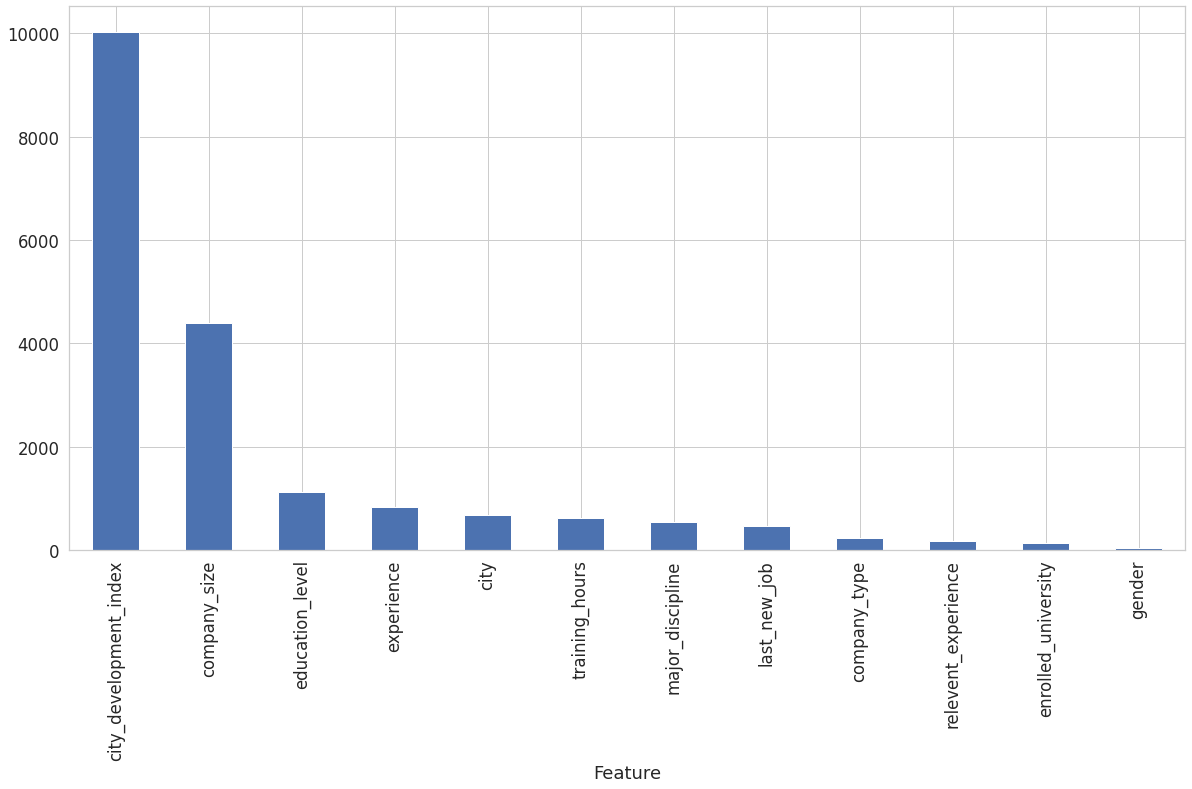

In [11]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

LightAutoML used 12 feats
1/12 Calculated score for city: 0.0035084
2/12 Calculated score for company_type: 0.0312360
3/12 Calculated score for company_size: 0.0305093
4/12 Calculated score for city_development_index: 0.1189825
5/12 Calculated score for gender: -0.0000031
6/12 Calculated score for major_discipline: 0.0028529
7/12 Calculated score for last_new_job: 0.0035317
8/12 Calculated score for education_level: 0.0011390
9/12 Calculated score for enrolled_university: 0.0013325
10/12 Calculated score for relevent_experience: 0.0024722
11/12 Calculated score for training_hours: -0.0011920
12/12 Calculated score for experience: 0.0036997
CPU times: user 15.4 s, sys: 2.06 s, total: 17.5 s
Wall time: 6.56 s


<AxesSubplot:xlabel='Feature'>

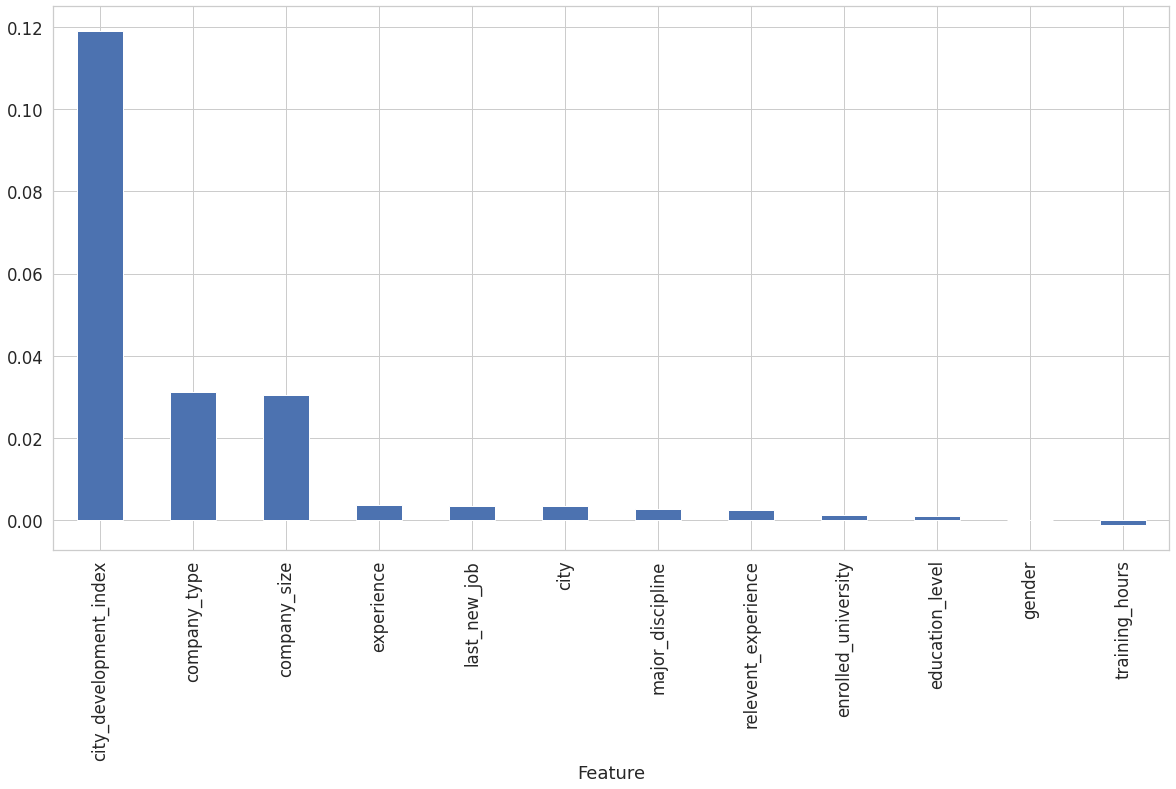

In [12]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', test_data, silent = False)
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

# Шаг 5. Выполним предсказание на holdout и посмотрим на метрику качества

In [13]:
%%time

test_pred = automl_rd.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

[2021-06-14 22:44:48,296] (INFO): Prediction for test data:
array([[0.04313495],
       [0.62670255],
       [0.07484004],
       ...,
       [0.20521131],
       [0.06609596],
       [0.0654742 ]], dtype=float32)
Shape = (3832, 1)


CPU times: user 2.46 s, sys: 233 ms, total: 2.69 s
Wall time: 1.86 s


In [14]:
logging.info('Check scores...')
logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))
logging.info('TEST score: {}'.format(roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])))

[2021-06-14 22:44:48,302] (INFO): Check scores...
[2021-06-14 22:44:48,308] (INFO): OOF score: 0.8057498508925341
[2021-06-14 22:44:48,311] (INFO): TEST score: 0.8160833255991279


# Шаг 6. Построение отчета о модели TabularAutoML

Поскольку мы использовали `automl_rd`, то есть обернутый в декоратор отчета пресет, то отчет собирался постепенно в процессе работы с моделью и уже доступен в указанной нами для декоратора папке `tabularAutoML_model_report` под стандартным именем `lama_interactive_report.html` (или можно кликнуть по [ссылке](tabularAutoML_model_report/lama_interactive_report.html)).

Несколько примеров из сгенерированного отчета:

![TabularAutoML auto report example 1](imgs/tutorial_blackbox_report_1.png)

![TabularAutoML auto report example 2](imgs/tutorial_blackbox_report_2.png)

![TabularAutoML auto report example 3](imgs/tutorial_blackbox_report_3.png)

# Шаг 7. Потратим максимум из timeout - TabularUtilizedAutoML пресет

Как мы видели, на шаге 3 модель, основанная на TabulaAutoML пресете, закончила свое обучение за ~10 минут, хотя мы задавали 20 минут таймаута. 

Давайте еще больше расширим этот таймаут до 40 минут и предложим LightAutoML потратить его на создание зачастую более стабильной и качественной модели - будем использовать для этого `TabularUtilizedAutoML` пресет. Он обладает абсолютно таким же API, как и `TabularAutoML`, поэтому с точки зрения написания нового кода для запуска это будет быстро:

In [15]:
%%time 

automl = TabularUtilizedAutoML(task = task, 
                       timeout = 2 * TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 8, 'random_state': 42}
Start automl preset with listed constraints:
- time: 2399.997810602188 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (15326, 14)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 2389.7230038642883 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.7305212567425927
Linear model: C = 5e-05 score = 0.7472190266806419
Linear model: C = 0.0001 score = 0.7538819439118543
Linear model: C = 0.0005 score = 0.7638668041459667
Linear model: C = 0.001 score = 0.767005536098258
Linear model: C = 0.005 score = 0.7712901182492409
Linear model: C = 0.01 score = 0.7720542077471291
Linear model: C = 0.05 score = 

[2021-06-14 22:45:11,616] (INFO): A new study created in memory with name: no-name-e10c35df-c548-4df2-a8b9-2bf19fdd702f


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788922
[200]	valid's auc: 0.790716
[300]	valid's auc: 0.788895
[400]	valid's auc: 0.787104
Early stopping, best iteration is:
[235]	valid's auc: 0.791426
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:14,476] (INFO): Trial 0 finished with value: 0.7914257228315056 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.7914257228315056.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785844
[200]	valid's auc: 0.787747
[300]	valid's auc: 0.788619
[400]	valid's auc: 0.78649
[500]	valid's auc: 0.785236
Early stopping, best iteration is:
[322]	valid's auc: 0.789002
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:20,610] (INFO): Trial 1 finished with value: 0.7890016560006591 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.7914257228315056.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.781226
[200]	valid's auc: 0.788906
[300]	valid's auc: 0.791188
[400]	valid's auc: 0.791856
[500]	valid's auc: 0.792723
[600]	valid's auc: 0.791873
[700]	valid's auc: 0.791941
Early stopping, best iteration is:
[500]	valid's auc: 0.792723
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:23,998] (INFO): Trial 2 finished with value: 0.7927226866409319 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.7927226866409319.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790062
[200]	valid's auc: 0.788842
[300]	valid's auc: 0.789906
Early stopping, best iteration is:
[141]	valid's auc: 0.791044
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:28,074] (INFO): Trial 3 finished with value: 0.7910439621307019 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: 0.7927226866409319.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788638
[200]	valid's auc: 0.792114
[300]	valid's auc: 0.792854
[400]	valid's auc: 0.792758
Early stopping, best iteration is:
[282]	valid's auc: 0.793417
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:29,408] (INFO): Trial 4 finished with value: 0.7934174683925432 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 4 with value: 0.7934174683925432.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786887
[200]	valid's auc: 0.789253
[300]	valid's auc: 0.787879
[400]	valid's auc: 0.785202
Early stopping, best iteration is:
[207]	valid's auc: 0.789694
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:33,027] (INFO): Trial 5 finished with value: 0.789693881319006 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 4 with value: 0.7934174683925432.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786344
[200]	valid's auc: 0.792812
[300]	valid's auc: 0.792917
[400]	valid's auc: 0.792478
Early stopping, best iteration is:
[240]	valid's auc: 0.794
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:34,228] (INFO): Trial 6 finished with value: 0.7940000511286653 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786948
[200]	valid's auc: 0.788293
[300]	valid's auc: 0.785665
Early stopping, best iteration is:
[155]	valid's auc: 0.78895
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:38,469] (INFO): Trial 7 finished with value: 0.7889499592390918 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788394
[200]	valid's auc: 0.791356
[300]	valid's auc: 0.79013
Early stopping, best iteration is:
[197]	valid's auc: 0.791815
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:41,826] (INFO): Trial 8 finished with value: 0.7918154368802425 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.783077
[200]	valid's auc: 0.789129
[300]	valid's auc: 0.787143
Early stopping, best iteration is:
[196]	valid's auc: 0.789168
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:45,699] (INFO): Trial 9 finished with value: 0.7891675401146986 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.783613
[200]	valid's auc: 0.79066
[300]	valid's auc: 0.791962
[400]	valid's auc: 0.793486
[500]	valid's auc: 0.793252
[600]	valid's auc: 0.793423
Early stopping, best iteration is:
[402]	valid's auc: 0.793607
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:46,855] (INFO): Trial 10 finished with value: 0.7936074965985235 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 16, 'bagging_fraction': 0.8480589016791605, 'min_sum_hessian_in_leaf': 0.008660554736271515, 'reg_alpha': 1.7238246488428573e-08, 'reg_lambda': 1.475649304728376}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78416
[200]	valid's auc: 0.791892
[300]	valid's auc: 0.792343
[400]	valid's auc: 0.792504
[500]	valid's auc: 0.79304
[600]	valid's auc: 0.793002
[700]	valid's auc: 0.793113
Early stopping, best iteration is:
[564]	valid's auc: 0.793309
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:48,416] (INFO): Trial 11 finished with value: 0.7933089620028803 and parameters: {'feature_fraction': 0.8982689713156164, 'num_leaves': 16, 'bagging_fraction': 0.8760737922573953, 'min_sum_hessian_in_leaf': 0.009516535943251574, 'reg_alpha': 1.6648902228622425e-08, 'reg_lambda': 7.3871412375861425}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788062
[200]	valid's auc: 0.791087
[300]	valid's auc: 0.79044
Early stopping, best iteration is:
[194]	valid's auc: 0.791486
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:50,377] (INFO): Trial 12 finished with value: 0.791485941037287 and parameters: {'feature_fraction': 0.8975870867199489, 'num_leaves': 67, 'bagging_fraction': 0.8314799492356344, 'min_sum_hessian_in_leaf': 0.0048033573489059045, 'reg_alpha': 1.2463219988817348e-08, 'reg_lambda': 1.0244142732026253}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787678
[200]	valid's auc: 0.792015
[300]	valid's auc: 0.792558
[400]	valid's auc: 0.791197
Early stopping, best iteration is:
[248]	valid's auc: 0.793641
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:52,135] (INFO): Trial 13 finished with value: 0.7936407302309595 and parameters: {'feature_fraction': 0.8858320716284691, 'num_leaves': 48, 'bagging_fraction': 0.9913239280399375, 'min_sum_hessian_in_leaf': 0.014253598274463387, 'reg_alpha': 7.113541565483427e-07, 'reg_lambda': 0.14421628604613834}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786568
[200]	valid's auc: 0.790037
[300]	valid's auc: 0.789339
[400]	valid's auc: 0.787988
Early stopping, best iteration is:
[255]	valid's auc: 0.791078
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:54,208] (INFO): Trial 14 finished with value: 0.7910780479075594 and parameters: {'feature_fraction': 0.923817076269483, 'num_leaves': 60, 'bagging_fraction': 0.9968178760098038, 'min_sum_hessian_in_leaf': 0.02552404167488013, 'reg_alpha': 1.6417141569918984e-06, 'reg_lambda': 0.048794491762753106}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786577
[200]	valid's auc: 0.790614
[300]	valid's auc: 0.790643
[400]	valid's auc: 0.789663
Early stopping, best iteration is:
[226]	valid's auc: 0.791785
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:56,147] (INFO): Trial 15 finished with value: 0.7917853277773518 and parameters: {'feature_fraction': 0.828117186504288, 'num_leaves': 61, 'bagging_fraction': 0.9928205992602974, 'min_sum_hessian_in_leaf': 0.00167117935596583, 'reg_alpha': 6.327950387989183e-06, 'reg_lambda': 0.0704101037565748}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787531
[200]	valid's auc: 0.789985
[300]	valid's auc: 0.788809
[400]	valid's auc: 0.786461
Early stopping, best iteration is:
[245]	valid's auc: 0.790649
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:45:59,234] (INFO): Trial 16 finished with value: 0.7906491352154363 and parameters: {'feature_fraction': 0.9511188615349973, 'num_leaves': 110, 'bagging_fraction': 0.9072950643400716, 'min_sum_hessian_in_leaf': 0.030850798844571294, 'reg_alpha': 1.0997329162304231e-07, 'reg_lambda': 0.004121835640729051}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788859
[200]	valid's auc: 0.791583
[300]	valid's auc: 0.791634
[400]	valid's auc: 0.790777
Early stopping, best iteration is:
[295]	valid's auc: 0.791856
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:02,205] (INFO): Trial 17 finished with value: 0.7918557717161905 and parameters: {'feature_fraction': 0.8478248300112026, 'num_leaves': 89, 'bagging_fraction': 0.7723609967295647, 'min_sum_hessian_in_leaf': 0.002718678725521334, 'reg_alpha': 1.1067016973050875e-05, 'reg_lambda': 0.6449594920823252}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786129
[200]	valid's auc: 0.789035
[300]	valid's auc: 0.789755
[400]	valid's auc: 0.787933
Early stopping, best iteration is:
[275]	valid's auc: 0.790309
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:07,021] (INFO): Trial 18 finished with value: 0.7903088455431426 and parameters: {'feature_fraction': 0.647363321235647, 'num_leaves': 177, 'bagging_fraction': 0.9577636338193465, 'min_sum_hessian_in_leaf': 0.010719492617066511, 'reg_alpha': 1.1138632919825352e-07, 'reg_lambda': 7.639371274654828e-06}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785888
[200]	valid's auc: 0.792041
[300]	valid's auc: 0.793222
[400]	valid's auc: 0.79233
[500]	valid's auc: 0.791168
Early stopping, best iteration is:
[312]	valid's auc: 0.793542
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:08,677] (INFO): Trial 19 finished with value: 0.7935421655262134 and parameters: {'feature_fraction': 0.7652138884025161, 'num_leaves': 38, 'bagging_fraction': 0.9023923392814068, 'min_sum_hessian_in_leaf': 0.05444957302011274, 'reg_alpha': 0.13852428395503005, 'reg_lambda': 0.0021069733329307254}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787895
[200]	valid's auc: 0.791488
[300]	valid's auc: 0.791306
[400]	valid's auc: 0.790101
Early stopping, best iteration is:
[204]	valid's auc: 0.791758
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:10,108] (INFO): Trial 20 finished with value: 0.7917580591558656 and parameters: {'feature_fraction': 0.9512784567106741, 'num_leaves': 42, 'bagging_fraction': 0.99672018191775, 'min_sum_hessian_in_leaf': 0.01576003494531386, 'reg_alpha': 4.660982599177124e-06, 'reg_lambda': 0.23288577741764308}. Best is trial 6 with value: 0.7940000511286653.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785702
[200]	valid's auc: 0.792637
[300]	valid's auc: 0.793763
[400]	valid's auc: 0.79379
[500]	valid's auc: 0.793429
Early stopping, best iteration is:
[372]	valid's auc: 0.79437
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:11,602] (INFO): Trial 21 finished with value: 0.7943695977594283 and parameters: {'feature_fraction': 0.8816305981830896, 'num_leaves': 24, 'bagging_fraction': 0.8498611526685024, 'min_sum_hessian_in_leaf': 9.278969835148601, 'reg_alpha': 1.1392141808778415e-08, 'reg_lambda': 3.775701078267658}. Best is trial 21 with value: 0.7943695977594283.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.783965
[200]	valid's auc: 0.79276
[300]	valid's auc: 0.793658
[400]	valid's auc: 0.793404
Early stopping, best iteration is:
[247]	valid's auc: 0.794203
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:12,539] (INFO): Trial 22 finished with value: 0.7942025774528266 and parameters: {'feature_fraction': 0.8590191983118689, 'num_leaves': 16, 'bagging_fraction': 0.8758712014092962, 'min_sum_hessian_in_leaf': 8.285425657012055, 'reg_alpha': 4.699715188357232e-08, 'reg_lambda': 6.565448604358697}. Best is trial 21 with value: 0.7943695977594283.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784604
[200]	valid's auc: 0.792038
[300]	valid's auc: 0.793678
[400]	valid's auc: 0.79418
[500]	valid's auc: 0.794546
[600]	valid's auc: 0.794736
[700]	valid's auc: 0.794697
[800]	valid's auc: 0.794262
Early stopping, best iteration is:
[647]	valid's auc: 0.794991
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:14,468] (INFO): Trial 23 finished with value: 0.7949910950907961 and parameters: {'feature_fraction': 0.9412478892503501, 'num_leaves': 19, 'bagging_fraction': 0.8550683056895925, 'min_sum_hessian_in_leaf': 9.242698502972436, 'reg_alpha': 7.201677944417886e-08, 'reg_lambda': 6.329816648348431}. Best is trial 23 with value: 0.7949910950907961.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78525
[200]	valid's auc: 0.791117
[300]	valid's auc: 0.792378
[400]	valid's auc: 0.793454
[500]	valid's auc: 0.79334
[600]	valid's auc: 0.79331
[700]	valid's auc: 0.793152
Early stopping, best iteration is:
[570]	valid's auc: 0.793858
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:16,508] (INFO): Trial 24 finished with value: 0.7938577430102852 and parameters: {'feature_fraction': 0.8552510304566178, 'num_leaves': 24, 'bagging_fraction': 0.7826139030190828, 'min_sum_hessian_in_leaf': 9.08347803948606, 'reg_alpha': 1.738621393169817e-08, 'reg_lambda': 7.706997993236833}. Best is trial 23 with value: 0.7949910950907961.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784275
[200]	valid's auc: 0.791239
[300]	valid's auc: 0.792921
[400]	valid's auc: 0.792925
[500]	valid's auc: 0.791734
Early stopping, best iteration is:
[337]	valid's auc: 0.793882
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:19,684] (INFO): Trial 25 finished with value: 0.7938821711503665 and parameters: {'feature_fraction': 0.7796487870626706, 'num_leaves': 83, 'bagging_fraction': 0.8541732493559648, 'min_sum_hessian_in_leaf': 7.627730753999613, 'reg_alpha': 6.766822252953716e-08, 'reg_lambda': 7.480671175703715}. Best is trial 23 with value: 0.7949910950907961.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788299
[200]	valid's auc: 0.791642
[300]	valid's auc: 0.791543
[400]	valid's auc: 0.790495
Early stopping, best iteration is:
[240]	valid's auc: 0.79208
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:22,215] (INFO): Trial 26 finished with value: 0.7920796016508879 and parameters: {'feature_fraction': 0.9259037964457202, 'num_leaves': 80, 'bagging_fraction': 0.8125063046704508, 'min_sum_hessian_in_leaf': 4.388788087941508, 'reg_alpha': 1.2745281780795915e-08, 'reg_lambda': 2.4500398940103127}. Best is trial 23 with value: 0.7949910950907961.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.782887
[200]	valid's auc: 0.792018
[300]	valid's auc: 0.793936
[400]	valid's auc: 0.79443
[500]	valid's auc: 0.794729
[600]	valid's auc: 0.795154
[700]	valid's auc: 0.795643
[800]	valid's auc: 0.795034
Early stopping, best iteration is:
[672]	valid's auc: 0.795752
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:24,002] (INFO): Trial 27 finished with value: 0.7957517760109983 and parameters: {'feature_fraction': 0.8539646820354401, 'num_leaves': 18, 'bagging_fraction': 0.8719428586775141, 'min_sum_hessian_in_leaf': 4.3176662800583845, 'reg_alpha': 1.3967480786852633e-07, 'reg_lambda': 8.476844121888826}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789152
[200]	valid's auc: 0.793821
[300]	valid's auc: 0.794226
[400]	valid's auc: 0.794442
[500]	valid's auc: 0.792709
Early stopping, best iteration is:
[379]	valid's auc: 0.794702
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:26,178] (INFO): Trial 28 finished with value: 0.7947019340837884 and parameters: {'feature_fraction': 0.8185164630236712, 'num_leaves': 49, 'bagging_fraction': 0.6928359649631521, 'min_sum_hessian_in_leaf': 2.5274763722643843, 'reg_alpha': 4.765278893803372e-07, 'reg_lambda': 0.4294935989241816}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789138
[200]	valid's auc: 0.790931
[300]	valid's auc: 0.788712
Early stopping, best iteration is:
[134]	valid's auc: 0.791604
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:28,532] (INFO): Trial 29 finished with value: 0.7916035369674452 and parameters: {'feature_fraction': 0.734861439691421, 'num_leaves': 111, 'bagging_fraction': 0.6559661481755027, 'min_sum_hessian_in_leaf': 2.9716885112695386, 'reg_alpha': 2.049211281508803e-05, 'reg_lambda': 0.701730456415678}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790679
[200]	valid's auc: 0.792887
[300]	valid's auc: 0.792752
[400]	valid's auc: 0.793086
Early stopping, best iteration is:
[221]	valid's auc: 0.79346
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:30,112] (INFO): Trial 30 finished with value: 0.793459507517334 and parameters: {'feature_fraction': 0.6979788686352886, 'num_leaves': 51, 'bagging_fraction': 0.6340533191123581, 'min_sum_hessian_in_leaf': 0.6135281892184511, 'reg_alpha': 1.975876511088104e-06, 'reg_lambda': 0.23335652840938473}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.783994
[200]	valid's auc: 0.791513
[300]	valid's auc: 0.7935
[400]	valid's auc: 0.794117
[500]	valid's auc: 0.794315
[600]	valid's auc: 0.79436
[700]	valid's auc: 0.793842
Early stopping, best iteration is:
[525]	valid's auc: 0.794679
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:31,655] (INFO): Trial 31 finished with value: 0.7946786421362693 and parameters: {'feature_fraction': 0.8280777227579745, 'num_leaves': 18, 'bagging_fraction': 0.699651477255919, 'min_sum_hessian_in_leaf': 5.161833589901497, 'reg_alpha': 3.5148147715299536e-07, 'reg_lambda': 9.924201009241736}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788641
[200]	valid's auc: 0.794991
[300]	valid's auc: 0.793632
[400]	valid's auc: 0.793521
Early stopping, best iteration is:
[217]	valid's auc: 0.795192
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:33,129] (INFO): Trial 32 finished with value: 0.795191633077974 and parameters: {'feature_fraction': 0.820818755603418, 'num_leaves': 41, 'bagging_fraction': 0.6961213313847646, 'min_sum_hessian_in_leaf': 4.489412257898747, 'reg_alpha': 2.919806522982103e-07, 'reg_lambda': 1.9306358478567414}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789088
[200]	valid's auc: 0.791334
[300]	valid's auc: 0.789504
[400]	valid's auc: 0.789565
Early stopping, best iteration is:
[232]	valid's auc: 0.791546
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:35,266] (INFO): Trial 33 finished with value: 0.7915461592430686 and parameters: {'feature_fraction': 0.8152169050328515, 'num_leaves': 71, 'bagging_fraction': 0.6958834313768805, 'min_sum_hessian_in_leaf': 0.8162922122019087, 'reg_alpha': 2.3945988322576107e-07, 'reg_lambda': 0.37268396803836834}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788828
[200]	valid's auc: 0.793023
[300]	valid's auc: 0.792017
[400]	valid's auc: 0.789842
Early stopping, best iteration is:
[233]	valid's auc: 0.793299
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:38,008] (INFO): Trial 34 finished with value: 0.793299304366104 and parameters: {'feature_fraction': 0.7752285457286441, 'num_leaves': 93, 'bagging_fraction': 0.5616367182517847, 'min_sum_hessian_in_leaf': 2.257977909083286, 'reg_alpha': 0.007985614889275936, 'reg_lambda': 2.0600895848565632}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787173
[200]	valid's auc: 0.792638
[300]	valid's auc: 0.793992
[400]	valid's auc: 0.79415
Early stopping, best iteration is:
[247]	valid's auc: 0.794526
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:39,422] (INFO): Trial 35 finished with value: 0.7945255401885513 and parameters: {'feature_fraction': 0.7484981189240343, 'num_leaves': 38, 'bagging_fraction': 0.6130196578125714, 'min_sum_hessian_in_leaf': 0.24836210143843027, 'reg_alpha': 1.5355348210963326e-06, 'reg_lambda': 1.932934458740742}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789473
[200]	valid's auc: 0.792165
[300]	valid's auc: 0.792733
[400]	valid's auc: 0.791784
Early stopping, best iteration is:
[283]	valid's auc: 0.793045
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:41,397] (INFO): Trial 36 finished with value: 0.793044797232235 and parameters: {'feature_fraction': 0.7984908266706026, 'num_leaves': 55, 'bagging_fraction': 0.7621562796971536, 'min_sum_hessian_in_leaf': 1.2807604459292792, 'reg_alpha': 0.0004299193764423973, 'reg_lambda': 0.007844751042023769}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788675
[200]	valid's auc: 0.794694
[300]	valid's auc: 0.792301
[400]	valid's auc: 0.791292
Early stopping, best iteration is:
[204]	valid's auc: 0.794911
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:42,550] (INFO): Trial 37 finished with value: 0.7949107094670406 and parameters: {'feature_fraction': 0.92836719573802, 'num_leaves': 33, 'bagging_fraction': 0.5720379429437802, 'min_sum_hessian_in_leaf': 4.373343547697151, 'reg_alpha': 0.00010622317682443316, 'reg_lambda': 0.0006902065535829201}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791102
[200]	valid's auc: 0.790173
[300]	valid's auc: 0.788088
Early stopping, best iteration is:
[124]	valid's auc: 0.791905
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:45,027] (INFO): Trial 38 finished with value: 0.7919046279963529 and parameters: {'feature_fraction': 0.9271334838876464, 'num_leaves': 125, 'bagging_fraction': 0.5299994363221872, 'min_sum_hessian_in_leaf': 4.227618241379014, 'reg_alpha': 3.512279883841353e-05, 'reg_lambda': 1.5532136288756492e-06}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786515
[200]	valid's auc: 0.789345
[300]	valid's auc: 0.790862
[400]	valid's auc: 0.790379
[500]	valid's auc: 0.790956
Early stopping, best iteration is:
[319]	valid's auc: 0.792032
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:46,385] (INFO): Trial 39 finished with value: 0.7920318815632873 and parameters: {'feature_fraction': 0.5007250058963768, 'num_leaves': 33, 'bagging_fraction': 0.563748124814059, 'min_sum_hessian_in_leaf': 0.9931617940066574, 'reg_alpha': 0.00011572335626207446, 'reg_lambda': 0.0002510744040064188}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788563
[200]	valid's auc: 0.788104
Early stopping, best iteration is:
[37]	valid's auc: 0.789837
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:49,073] (INFO): Trial 40 finished with value: 0.7898370415818072 and parameters: {'feature_fraction': 0.9985649803160843, 'num_leaves': 189, 'bagging_fraction': 0.7990960769244367, 'min_sum_hessian_in_leaf': 4.8555154746851725, 'reg_alpha': 0.01617244538986026, 'reg_lambda': 3.852720254572111e-08}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788327
[200]	valid's auc: 0.793177
[300]	valid's auc: 0.794184
[400]	valid's auc: 0.793684
Early stopping, best iteration is:
[257]	valid's auc: 0.794365
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:50,578] (INFO): Trial 41 finished with value: 0.7943650529891807 and parameters: {'feature_fraction': 0.8494247260386838, 'num_leaves': 41, 'bagging_fraction': 0.7409047357547275, 'min_sum_hessian_in_leaf': 2.0096067741441996, 'reg_alpha': 1.6596852922402217e-07, 'reg_lambda': 0.001037640709732365}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788639
[200]	valid's auc: 0.794409
[300]	valid's auc: 0.79439
[400]	valid's auc: 0.794257
Early stopping, best iteration is:
[231]	valid's auc: 0.794826
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:51,757] (INFO): Trial 42 finished with value: 0.7948257790730372 and parameters: {'feature_fraction': 0.9532627353387357, 'num_leaves': 30, 'bagging_fraction': 0.6858276955060028, 'min_sum_hessian_in_leaf': 3.054614732139654, 'reg_alpha': 6.813956532661158e-07, 'reg_lambda': 2.206084107752794e-05}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786723
[200]	valid's auc: 0.793016
[300]	valid's auc: 0.792227
[400]	valid's auc: 0.791739
Early stopping, best iteration is:
[214]	valid's auc: 0.793208
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:53,183] (INFO): Trial 43 finished with value: 0.7932078408648698 and parameters: {'feature_fraction': 0.961082860579537, 'num_leaves': 28, 'bagging_fraction': 0.6637353514067533, 'min_sum_hessian_in_leaf': 6.015444781553844, 'reg_alpha': 2.374559083985091e-06, 'reg_lambda': 1.892338912731277e-05}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.783487
[200]	valid's auc: 0.790343
[300]	valid's auc: 0.790179
[400]	valid's auc: 0.791565
[500]	valid's auc: 0.790809
Early stopping, best iteration is:
[375]	valid's auc: 0.791814
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:54,202] (INFO): Trial 44 finished with value: 0.7918137325913995 and parameters: {'feature_fraction': 0.9193015275288577, 'num_leaves': 16, 'bagging_fraction': 0.5945983035721614, 'min_sum_hessian_in_leaf': 3.6313067810573716, 'reg_alpha': 0.001806797306611965, 'reg_lambda': 6.923080463085894e-05}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789679
[200]	valid's auc: 0.791507
[300]	valid's auc: 0.790076
Early stopping, best iteration is:
[197]	valid's auc: 0.791779
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:56,161] (INFO): Trial 45 finished with value: 0.7917790787182613 and parameters: {'feature_fraction': 0.9987935616926054, 'num_leaves': 72, 'bagging_fraction': 0.7095706381041229, 'min_sum_hessian_in_leaf': 1.5450981367967098, 'reg_alpha': 4.695901323865143e-08, 'reg_lambda': 2.3482905064351917e-06}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787494
[200]	valid's auc: 0.792455
[300]	valid's auc: 0.792451
[400]	valid's auc: 0.790747
Early stopping, best iteration is:
[226]	valid's auc: 0.793277
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:57,242] (INFO): Trial 46 finished with value: 0.7932765805148656 and parameters: {'feature_fraction': 0.8722811399457586, 'num_leaves': 30, 'bagging_fraction': 0.5083943313653723, 'min_sum_hessian_in_leaf': 0.49192536194097797, 'reg_alpha': 7.591621400091274e-07, 'reg_lambda': 0.00021715325667375935}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785297
[200]	valid's auc: 0.790798
[300]	valid's auc: 0.790827
[400]	valid's auc: 0.791876
[500]	valid's auc: 0.791811
[600]	valid's auc: 0.792068
[700]	valid's auc: 0.791895
Early stopping, best iteration is:
[558]	valid's auc: 0.792489
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:46:58,615] (INFO): Trial 47 finished with value: 0.7924886309731773 and parameters: {'feature_fraction': 0.905971231558927, 'num_leaves': 16, 'bagging_fraction': 0.6706991981120334, 'min_sum_hessian_in_leaf': 3.252516229973764, 'reg_alpha': 7.816653535333004e-05, 'reg_lambda': 1.4665103824417582e-07}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787183
[200]	valid's auc: 0.790916
[300]	valid's auc: 0.789838
[400]	valid's auc: 0.789136
Early stopping, best iteration is:
[212]	valid's auc: 0.791292
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:00,382] (INFO): Trial 48 finished with value: 0.7912916521091994 and parameters: {'feature_fraction': 0.9764535515435225, 'num_leaves': 59, 'bagging_fraction': 0.7311356070534079, 'min_sum_hessian_in_leaf': 0.3166843283342858, 'reg_alpha': 0.11413109603489216, 'reg_lambda': 1.0897449950353188e-05}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789705
[200]	valid's auc: 0.790763
[300]	valid's auc: 0.791769
[400]	valid's auc: 0.790432
Early stopping, best iteration is:
[288]	valid's auc: 0.792019
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:02,338] (INFO): Trial 49 finished with value: 0.7920185313006848 and parameters: {'feature_fraction': 0.9399355937984731, 'num_leaves': 47, 'bagging_fraction': 0.948779238688565, 'min_sum_hessian_in_leaf': 6.410017477005098, 'reg_alpha': 4.522388730310782e-08, 'reg_lambda': 4.8771089871969e-05}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787037
[200]	valid's auc: 0.790267
[300]	valid's auc: 0.791475
[400]	valid's auc: 0.79239
[500]	valid's auc: 0.791752
Early stopping, best iteration is:
[374]	valid's auc: 0.79296
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:03,749] (INFO): Trial 50 finished with value: 0.7929598668382317 and parameters: {'feature_fraction': 0.9114334791769951, 'num_leaves': 27, 'bagging_fraction': 0.6238166892745556, 'min_sum_hessian_in_leaf': 1.5800876898782135, 'reg_alpha': 9.719317128234183e-07, 'reg_lambda': 3.122495458195603e-06}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788921
[200]	valid's auc: 0.794145
[300]	valid's auc: 0.794679
[400]	valid's auc: 0.794136
Early stopping, best iteration is:
[235]	valid's auc: 0.795347
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:05,513] (INFO): Trial 51 finished with value: 0.7953467233626756 and parameters: {'feature_fraction': 0.8279440675662983, 'num_leaves': 49, 'bagging_fraction': 0.6845719285325974, 'min_sum_hessian_in_leaf': 9.674689008811077, 'reg_alpha': 2.403848452843659e-07, 'reg_lambda': 0.09293718706754697}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789799
[200]	valid's auc: 0.793773
[300]	valid's auc: 0.794209
[400]	valid's auc: 0.793649
Early stopping, best iteration is:
[289]	valid's auc: 0.79454
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:07,139] (INFO): Trial 52 finished with value: 0.794540310691856 and parameters: {'feature_fraction': 0.8397827116570438, 'num_leaves': 36, 'bagging_fraction': 0.7543410468800569, 'min_sum_hessian_in_leaf': 9.534891120092517, 'reg_alpha': 1.7422391321741418e-07, 'reg_lambda': 0.0183300854308565}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788975
[200]	valid's auc: 0.792177
[300]	valid's auc: 0.790302
[400]	valid's auc: 0.787817
Early stopping, best iteration is:
[233]	valid's auc: 0.792593
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:09,300] (INFO): Trial 53 finished with value: 0.7925925925925927 and parameters: {'feature_fraction': 0.8777760542072006, 'num_leaves': 66, 'bagging_fraction': 0.6739420323556409, 'min_sum_hessian_in_leaf': 5.552973577576149, 'reg_alpha': 6.05368669393442e-06, 'reg_lambda': 0.11213756540932326}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787948
[200]	valid's auc: 0.792685
[300]	valid's auc: 0.791795
[400]	valid's auc: 0.791444
Early stopping, best iteration is:
[257]	valid's auc: 0.793146
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:10,923] (INFO): Trial 54 finished with value: 0.7931459183702454 and parameters: {'feature_fraction': 0.941036263988895, 'num_leaves': 43, 'bagging_fraction': 0.7152732749461159, 'min_sum_hessian_in_leaf': 3.1824894840380833, 'reg_alpha': 2.7158728073493037e-08, 'reg_lambda': 0.0280626450086948}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786525
[200]	valid's auc: 0.792024
[300]	valid's auc: 0.791925
[400]	valid's auc: 0.792434
Early stopping, best iteration is:
[226]	valid's auc: 0.793052
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:11,892] (INFO): Trial 55 finished with value: 0.7930524665320278 and parameters: {'feature_fraction': 0.9696895129096733, 'num_leaves': 21, 'bagging_fraction': 0.8879611930510266, 'min_sum_hessian_in_leaf': 6.358022199996381, 'reg_alpha': 3.5284066330981984e-06, 'reg_lambda': 0.0009450340432817023}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786171
[200]	valid's auc: 0.790722
[300]	valid's auc: 0.792975
[400]	valid's auc: 0.792535
[500]	valid's auc: 0.791765
Early stopping, best iteration is:
[316]	valid's auc: 0.793204
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:13,251] (INFO): Trial 56 finished with value: 0.7932038641909032 and parameters: {'feature_fraction': 0.7971728636468192, 'num_leaves': 31, 'bagging_fraction': 0.6409137327050356, 'min_sum_hessian_in_leaf': 1.9361242977109951, 'reg_alpha': 3.252126546371349e-07, 'reg_lambda': 0.00010734965644821994}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.7888
[200]	valid's auc: 0.793073
[300]	valid's auc: 0.792778
[400]	valid's auc: 0.793012
Early stopping, best iteration is:
[220]	valid's auc: 0.793983
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:15,046] (INFO): Trial 57 finished with value: 0.793982724192096 and parameters: {'feature_fraction': 0.8662631303204595, 'num_leaves': 54, 'bagging_fraction': 0.6796877578057093, 'min_sum_hessian_in_leaf': 9.055411352586376, 'reg_alpha': 1.3657578186840541e-05, 'reg_lambda': 3.4624427079762}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78863
[200]	valid's auc: 0.790567
[300]	valid's auc: 0.790213
[400]	valid's auc: 0.788827
Early stopping, best iteration is:
[223]	valid's auc: 0.791063
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:17,899] (INFO): Trial 58 finished with value: 0.7910627093079735 and parameters: {'feature_fraction': 0.896197686657751, 'num_leaves': 100, 'bagging_fraction': 0.9180813264830823, 'min_sum_hessian_in_leaf': 1.184951216712442, 'reg_alpha': 1.0425640917548005e-07, 'reg_lambda': 0.9120310086425982}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788945
[200]	valid's auc: 0.790768
[300]	valid's auc: 0.789536
[400]	valid's auc: 0.78748
Early stopping, best iteration is:
[240]	valid's auc: 0.791128
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:21,338] (INFO): Trial 59 finished with value: 0.7911280403802837 and parameters: {'feature_fraction': 0.8352091409869746, 'num_leaves': 157, 'bagging_fraction': 0.814723378601359, 'min_sum_hessian_in_leaf': 9.47147054059411, 'reg_alpha': 2.9327467364758624e-08, 'reg_lambda': 0.006732058827797063}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786959
[200]	valid's auc: 0.792835
[300]	valid's auc: 0.792974
[400]	valid's auc: 0.793387
[500]	valid's auc: 0.792416
Early stopping, best iteration is:
[363]	valid's auc: 0.794042
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:22,651] (INFO): Trial 60 finished with value: 0.7940423743015966 and parameters: {'feature_fraction': 0.9877133773744696, 'num_leaves': 23, 'bagging_fraction': 0.8286517291127415, 'min_sum_hessian_in_leaf': 3.869473534229058, 'reg_alpha': 9.735362256039746e-07, 'reg_lambda': 2.660241053062253e-05}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788835
[200]	valid's auc: 0.791033
[300]	valid's auc: 0.790106
[400]	valid's auc: 0.789738
Early stopping, best iteration is:
[231]	valid's auc: 0.791627
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:24,227] (INFO): Trial 61 finished with value: 0.791626544866824 and parameters: {'feature_fraction': 0.8183752354546463, 'num_leaves': 44, 'bagging_fraction': 0.7308522573719093, 'min_sum_hessian_in_leaf': 2.6400415226942684, 'reg_alpha': 3.701951820318947e-07, 'reg_lambda': 0.43891242462873237}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790948
[200]	valid's auc: 0.794065
[300]	valid's auc: 0.794322
[400]	valid's auc: 0.793206
Early stopping, best iteration is:
[256]	valid's auc: 0.795061
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:25,935] (INFO): Trial 62 finished with value: 0.7950606868852134 and parameters: {'feature_fraction': 0.7771356753642014, 'num_leaves': 48, 'bagging_fraction': 0.6916389375861298, 'min_sum_hessian_in_leaf': 2.42200669450626, 'reg_alpha': 4.545765980901138e-07, 'reg_lambda': 0.07477395481928265}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786557
[200]	valid's auc: 0.790589
[300]	valid's auc: 0.788603
[400]	valid's auc: 0.786526
Early stopping, best iteration is:
[201]	valid's auc: 0.790646
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:28,230] (INFO): Trial 63 finished with value: 0.7906457266377506 and parameters: {'feature_fraction': 0.7597496735104224, 'num_leaves': 76, 'bagging_fraction': 0.6502640660417841, 'min_sum_hessian_in_leaf': 7.332891715671267, 'reg_alpha': 9.903476610183775e-08, 'reg_lambda': 0.0922711620676459}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.779368
[200]	valid's auc: 0.788287
[300]	valid's auc: 0.790235
[400]	valid's auc: 0.792585
[500]	valid's auc: 0.792506
[600]	valid's auc: 0.793011
[700]	valid's auc: 0.792457
Early stopping, best iteration is:
[556]	valid's auc: 0.793253
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:31,447] (INFO): Trial 64 finished with value: 0.7932527204710654 and parameters: {'feature_fraction': 0.7239561848527085, 'num_leaves': 65, 'bagging_fraction': 0.6006068878825768, 'min_sum_hessian_in_leaf': 4.2956302216563005, 'reg_alpha': 4.875848955082194, 'reg_lambda': 4.5757192402977385}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791162
[200]	valid's auc: 0.793243
[300]	valid's auc: 0.792294
Early stopping, best iteration is:
[159]	valid's auc: 0.794297
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:32,896] (INFO): Trial 65 finished with value: 0.7942965973873253 and parameters: {'feature_fraction': 0.7804609433679423, 'num_leaves': 55, 'bagging_fraction': 0.7834900766921455, 'min_sum_hessian_in_leaf': 1.8030935705521292, 'reg_alpha': 2.1782089102923442e-07, 'reg_lambda': 0.0018816292196215526}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78783
[200]	valid's auc: 0.792979
[300]	valid's auc: 0.794463
[400]	valid's auc: 0.793258
Early stopping, best iteration is:
[294]	valid's auc: 0.794801
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:34,341] (INFO): Trial 66 finished with value: 0.7948007828366751 and parameters: {'feature_fraction': 0.663429946280047, 'num_leaves': 34, 'bagging_fraction': 0.6846622138951579, 'min_sum_hessian_in_leaf': 2.559868189934913, 'reg_alpha': 5.825300988087288e-07, 'reg_lambda': 0.23418968995307457}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790945
[200]	valid's auc: 0.793467
[300]	valid's auc: 0.792433
Early stopping, best iteration is:
[190]	valid's auc: 0.793665
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:35,932] (INFO): Trial 67 finished with value: 0.7936645902747598 and parameters: {'feature_fraction': 0.8892375464942623, 'num_leaves': 49, 'bagging_fraction': 0.573350627779138, 'min_sum_hessian_in_leaf': 6.8457307152562485, 'reg_alpha': 2.5561084788495288e-08, 'reg_lambda': 1.2896198039364708}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785044
[200]	valid's auc: 0.791596
[300]	valid's auc: 0.792751
[400]	valid's auc: 0.7927
[500]	valid's auc: 0.792149
Early stopping, best iteration is:
[327]	valid's auc: 0.793167
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:37,040] (INFO): Trial 68 finished with value: 0.7931669379326407 and parameters: {'feature_fraction': 0.8064682317044197, 'num_leaves': 16, 'bagging_fraction': 0.871741031448603, 'min_sum_hessian_in_leaf': 9.837192534382625, 'reg_alpha': 1.5821796396458686e-06, 'reg_lambda': 0.039874158412508263}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788922
[200]	valid's auc: 0.791718
[300]	valid's auc: 0.792009
[400]	valid's auc: 0.791934
Early stopping, best iteration is:
[241]	valid's auc: 0.79419
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:38,346] (INFO): Trial 69 finished with value: 0.7941895112383646 and parameters: {'feature_fraction': 0.7497998257923695, 'num_leaves': 37, 'bagging_fraction': 0.5359393817986567, 'min_sum_hessian_in_leaf': 0.9591445369333934, 'reg_alpha': 7.407305824630364e-08, 'reg_lambda': 0.009466044577525583}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785621
[200]	valid's auc: 0.792207
[300]	valid's auc: 0.791348
[400]	valid's auc: 0.790659
Early stopping, best iteration is:
[221]	valid's auc: 0.792657
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:40,363] (INFO): Trial 70 finished with value: 0.7926573555686218 and parameters: {'feature_fraction': 0.9396343334923805, 'num_leaves': 60, 'bagging_fraction': 0.709888481845373, 'min_sum_hessian_in_leaf': 5.20336821770283, 'reg_alpha': 7.5807144407493344e-06, 'reg_lambda': 9.354132334034793}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788676
[200]	valid's auc: 0.792621
[300]	valid's auc: 0.793402
[400]	valid's auc: 0.793037
Early stopping, best iteration is:
[267]	valid's auc: 0.793709
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:41,700] (INFO): Trial 71 finished with value: 0.7937089017846746 and parameters: {'feature_fraction': 0.6388825661859666, 'num_leaves': 33, 'bagging_fraction': 0.6759808174107954, 'min_sum_hessian_in_leaf': 2.7093978874492124, 'reg_alpha': 5.858764623865841e-07, 'reg_lambda': 0.20889685242678654}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786583
[200]	valid's auc: 0.791786
[300]	valid's auc: 0.793079
[400]	valid's auc: 0.793541
Early stopping, best iteration is:
[243]	valid's auc: 0.793878
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:42,719] (INFO): Trial 72 finished with value: 0.7938779104282594 and parameters: {'feature_fraction': 0.6673025229297169, 'num_leaves': 23, 'bagging_fraction': 0.6831904600804516, 'min_sum_hessian_in_leaf': 3.860577028502751, 'reg_alpha': 1.705907753153878e-07, 'reg_lambda': 0.057948726363415484}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786494
[200]	valid's auc: 0.791622
[300]	valid's auc: 0.792485
[400]	valid's auc: 0.792219
[500]	valid's auc: 0.791498
Early stopping, best iteration is:
[345]	valid's auc: 0.793116
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:44,526] (INFO): Trial 73 finished with value: 0.7931163773636357 and parameters: {'feature_fraction': 0.5868755788328603, 'num_leaves': 43, 'bagging_fraction': 0.6360539465947037, 'min_sum_hessian_in_leaf': 2.159743713520524, 'reg_alpha': 4.965858418684947e-07, 'reg_lambda': 0.14915292069212152}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78746
[200]	valid's auc: 0.792225
[300]	valid's auc: 0.792293
[400]	valid's auc: 0.792706
[500]	valid's auc: 0.791314
Early stopping, best iteration is:
[376]	valid's auc: 0.793041
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:46,331] (INFO): Trial 74 finished with value: 0.7930408205582682 and parameters: {'feature_fraction': 0.7100087040436085, 'num_leaves': 35, 'bagging_fraction': 0.745018326183217, 'min_sum_hessian_in_leaf': 2.9798491153922027, 'reg_alpha': 3.0888747091410973e-06, 'reg_lambda': 0.5415370056190356}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787366
[200]	valid's auc: 0.794487
[300]	valid's auc: 0.794441
[400]	valid's auc: 0.794604
Early stopping, best iteration is:
[228]	valid's auc: 0.795513
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:47,461] (INFO): Trial 75 finished with value: 0.7955131755729961 and parameters: {'feature_fraction': 0.7855809557591518, 'num_leaves': 26, 'bagging_fraction': 0.69974261201136, 'min_sum_hessian_in_leaf': 4.9742656745403435, 'reg_alpha': 1.044992965355285e-08, 'reg_lambda': 1.2373581666259788}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787456
[200]	valid's auc: 0.794071
[300]	valid's auc: 0.794705
[400]	valid's auc: 0.794584
[500]	valid's auc: 0.794826
Early stopping, best iteration is:
[322]	valid's auc: 0.794972
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:48,803] (INFO): Trial 76 finished with value: 0.7949723479135244 and parameters: {'feature_fraction': 0.7856721937883866, 'num_leaves': 25, 'bagging_fraction': 0.6962585444509474, 'min_sum_hessian_in_leaf': 0.07112135620370105, 'reg_alpha': 1.0370468345877984e-08, 'reg_lambda': 3.1353130365096518}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785885
[200]	valid's auc: 0.792982
[300]	valid's auc: 0.794244
[400]	valid's auc: 0.794716
Early stopping, best iteration is:
[262]	valid's auc: 0.795147
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:49,913] (INFO): Trial 77 finished with value: 0.7951470375199189 and parameters: {'feature_fraction': 0.7762194478592546, 'num_leaves': 22, 'bagging_fraction': 0.7200224625564522, 'min_sum_hessian_in_leaf': 0.049736385879393344, 'reg_alpha': 1.0235967657155481e-08, 'reg_lambda': 3.5551982706965877}. Best is trial 27 with value: 0.7957517760109983.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785933
[200]	valid's auc: 0.793025
[300]	valid's auc: 0.794614
[400]	valid's auc: 0.795806
[500]	valid's auc: 0.795636
Early stopping, best iteration is:
[393]	valid's auc: 0.79604
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:51,247] (INFO): Trial 78 finished with value: 0.7960400848735844 and parameters: {'feature_fraction': 0.7847719126503185, 'num_leaves': 20, 'bagging_fraction': 0.7180770755740242, 'min_sum_hessian_in_leaf': 0.07094585872079867, 'reg_alpha': 1.2021017430750593e-08, 'reg_lambda': 2.95266001223712}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786336
[200]	valid's auc: 0.792901
[300]	valid's auc: 0.794554
[400]	valid's auc: 0.795283
[500]	valid's auc: 0.795572
[600]	valid's auc: 0.795004
Early stopping, best iteration is:
[497]	valid's auc: 0.795606
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:52,646] (INFO): Trial 79 finished with value: 0.7956057752667922 and parameters: {'feature_fraction': 0.7664365934433386, 'num_leaves': 17, 'bagging_fraction': 0.7191380761262884, 'min_sum_hessian_in_leaf': 0.04241355993967631, 'reg_alpha': 1.7718170426654616e-08, 'reg_lambda': 1.5255904737226398}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786816
[200]	valid's auc: 0.79246
[300]	valid's auc: 0.793557
[400]	valid's auc: 0.79425
[500]	valid's auc: 0.794247
Early stopping, best iteration is:
[390]	valid's auc: 0.794555
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:54,084] (INFO): Trial 80 finished with value: 0.7945553652433014 and parameters: {'feature_fraction': 0.7660080905495105, 'num_leaves': 23, 'bagging_fraction': 0.7604343361407728, 'min_sum_hessian_in_leaf': 0.023969505891687365, 'reg_alpha': 1.003792742274087e-08, 'reg_lambda': 1.4147417618956009}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784571
[200]	valid's auc: 0.791234
[300]	valid's auc: 0.792468
[400]	valid's auc: 0.794221
[500]	valid's auc: 0.794122
[600]	valid's auc: 0.793894
[700]	valid's auc: 0.793785
[800]	valid's auc: 0.794102
[900]	valid's auc: 0.793471
Early stopping, best iteration is:
[738]	valid's auc: 0.794496
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:55,943] (INFO): Trial 81 finished with value: 0.7944962832300819 and parameters: {'feature_fraction': 0.7371222667786598, 'num_leaves': 16, 'bagging_fraction': 0.7257597818926481, 'min_sum_hessian_in_leaf': 0.04830923845913817, 'reg_alpha': 2.0495198800283243e-08, 'reg_lambda': 5.276322227613809}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784905
[200]	valid's auc: 0.791977
[300]	valid's auc: 0.793068
[400]	valid's auc: 0.792839
Early stopping, best iteration is:
[264]	valid's auc: 0.794035
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:56,938] (INFO): Trial 82 finished with value: 0.7940355571462251 and parameters: {'feature_fraction': 0.7912578527656844, 'num_leaves': 19, 'bagging_fraction': 0.7151980393569893, 'min_sum_hessian_in_leaf': 0.10490677922879499, 'reg_alpha': 4.278419439129501e-08, 'reg_lambda': 0.8653081973751144}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787838
[200]	valid's auc: 0.79247
[300]	valid's auc: 0.793633
[400]	valid's auc: 0.793274
[500]	valid's auc: 0.792061
Early stopping, best iteration is:
[317]	valid's auc: 0.794046
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:47:58,757] (INFO): Trial 83 finished with value: 0.7940457828792823 and parameters: {'feature_fraction': 0.8082730918923109, 'num_leaves': 40, 'bagging_fraction': 0.7732684828898442, 'min_sum_hessian_in_leaf': 0.14545198696226816, 'reg_alpha': 6.441951552416719e-08, 'reg_lambda': 1.9333621895923534}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784213
[200]	valid's auc: 0.790805
[300]	valid's auc: 0.791894
[400]	valid's auc: 0.791454
Early stopping, best iteration is:
[270]	valid's auc: 0.792294
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:03,587] (INFO): Trial 84 finished with value: 0.7922943420450899 and parameters: {'feature_fraction': 0.7687977577414431, 'num_leaves': 245, 'bagging_fraction': 0.7392058327224662, 'min_sum_hessian_in_leaf': 0.061690653967802524, 'reg_alpha': 1.3689216171956262e-08, 'reg_lambda': 9.548766582889186}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78405
[200]	valid's auc: 0.791193
[300]	valid's auc: 0.792275
[400]	valid's auc: 0.793903
[500]	valid's auc: 0.793306
[600]	valid's auc: 0.793963
[700]	valid's auc: 0.793683
[800]	valid's auc: 0.793601
Early stopping, best iteration is:
[626]	valid's auc: 0.794302
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:05,184] (INFO): Trial 85 finished with value: 0.7943019943019944 and parameters: {'feature_fraction': 0.8293151311178404, 'num_leaves': 16, 'bagging_fraction': 0.7011568541948628, 'min_sum_hessian_in_leaf': 0.03689428797336052, 'reg_alpha': 1.2228858336536617e-07, 'reg_lambda': 2.5873401988488784}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786572
[200]	valid's auc: 0.792536
[300]	valid's auc: 0.79403
[400]	valid's auc: 0.795163
[500]	valid's auc: 0.793845
Early stopping, best iteration is:
[390]	valid's auc: 0.795725
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:07,587] (INFO): Trial 86 finished with value: 0.7957245073895124 and parameters: {'feature_fraction': 0.7403547495449421, 'num_leaves': 48, 'bagging_fraction': 0.6655165541926492, 'min_sum_hessian_in_leaf': 0.08450792986211876, 'reg_alpha': 3.629420791336663e-08, 'reg_lambda': 5.33414930389275}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78678
[200]	valid's auc: 0.791986
[300]	valid's auc: 0.792854
[400]	valid's auc: 0.793621
[500]	valid's auc: 0.793417
Early stopping, best iteration is:
[374]	valid's auc: 0.794094
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:09,975] (INFO): Trial 87 finished with value: 0.7940940710631638 and parameters: {'feature_fraction': 0.7349936942749908, 'num_leaves': 51, 'bagging_fraction': 0.6560060642008583, 'min_sum_hessian_in_leaf': 0.1680340055000438, 'reg_alpha': 2.78985963480599e-08, 'reg_lambda': 4.85488116085691}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788636
[200]	valid's auc: 0.792525
[300]	valid's auc: 0.791994
[400]	valid's auc: 0.792379
Early stopping, best iteration is:
[242]	valid's auc: 0.793099
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:11,654] (INFO): Trial 88 finished with value: 0.7930987663789258 and parameters: {'feature_fraction': 0.7493617144899443, 'num_leaves': 47, 'bagging_fraction': 0.7195228167371264, 'min_sum_hessian_in_leaf': 0.08339643142802952, 'reg_alpha': 1.601845559976776e-08, 'reg_lambda': 0.34539465441832173}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786695
[200]	valid's auc: 0.79191
[300]	valid's auc: 0.791633
[400]	valid's auc: 0.791552
Early stopping, best iteration is:
[231]	valid's auc: 0.792398
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:13,598] (INFO): Trial 89 finished with value: 0.792398303664505 and parameters: {'feature_fraction': 0.714406151921348, 'num_leaves': 58, 'bagging_fraction': 0.6657659591733015, 'min_sum_hessian_in_leaf': 0.0418086741767691, 'reg_alpha': 4.515478426149269e-08, 'reg_lambda': 1.2424137835700695}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786246
[200]	valid's auc: 0.793372
[300]	valid's auc: 0.793793
[400]	valid's auc: 0.795634
[500]	valid's auc: 0.794116
Early stopping, best iteration is:
[395]	valid's auc: 0.79587
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:15,119] (INFO): Trial 90 finished with value: 0.795870224085578 and parameters: {'feature_fraction': 0.8472041555112187, 'num_leaves': 26, 'bagging_fraction': 0.7016929647877883, 'min_sum_hessian_in_leaf': 0.0211143443211078, 'reg_alpha': 2.926163482002366e-07, 'reg_lambda': 0.7506412227230241}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786531
[200]	valid's auc: 0.791353
[300]	valid's auc: 0.791931
[400]	valid's auc: 0.79273
[500]	valid's auc: 0.79209
Early stopping, best iteration is:
[395]	valid's auc: 0.792969
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:16,698] (INFO): Trial 91 finished with value: 0.7929689563787269 and parameters: {'feature_fraction': 0.85074773741974, 'num_leaves': 27, 'bagging_fraction': 0.703381083923287, 'min_sum_hessian_in_leaf': 0.021553020349600698, 'reg_alpha': 2.713832108092766e-07, 'reg_lambda': 0.6620380796683447}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787734
[200]	valid's auc: 0.794572
[300]	valid's auc: 0.795265
[400]	valid's auc: 0.795422
[500]	valid's auc: 0.794711
Early stopping, best iteration is:
[317]	valid's auc: 0.795888
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:18,202] (INFO): Trial 92 finished with value: 0.7958875510221473 and parameters: {'feature_fraction': 0.8191251522835613, 'num_leaves': 29, 'bagging_fraction': 0.689435998716024, 'min_sum_hessian_in_leaf': 0.006016161644493143, 'reg_alpha': 1.4685835328203377e-07, 'reg_lambda': 2.053057389122589}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789712
[200]	valid's auc: 0.793895
[300]	valid's auc: 0.794055
[400]	valid's auc: 0.794887
[500]	valid's auc: 0.793563
[600]	valid's auc: 0.792752
Early stopping, best iteration is:
[407]	valid's auc: 0.79516
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:20,303] (INFO): Trial 93 finished with value: 0.7951598196862405 and parameters: {'feature_fraction': 0.8238192203381087, 'num_leaves': 39, 'bagging_fraction': 0.6469968134450695, 'min_sum_hessian_in_leaf': 0.030775109666611563, 'reg_alpha': 1.029171659297084e-08, 'reg_lambda': 2.1671044189845863}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787125
[200]	valid's auc: 0.793417
[300]	valid's auc: 0.793057
[400]	valid's auc: 0.793036
Early stopping, best iteration is:
[210]	valid's auc: 0.793987
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:21,749] (INFO): Trial 94 finished with value: 0.7939872689623437 and parameters: {'feature_fraction': 0.8641786321068647, 'num_leaves': 40, 'bagging_fraction': 0.6238959431108659, 'min_sum_hessian_in_leaf': 0.005447389362376979, 'reg_alpha': 3.519873297077315e-08, 'reg_lambda': 2.5006356799545224}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787181
[200]	valid's auc: 0.791904
[300]	valid's auc: 0.794261
[400]	valid's auc: 0.794224
[500]	valid's auc: 0.793173
[600]	valid's auc: 0.793304
Early stopping, best iteration is:
[415]	valid's auc: 0.794482
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:23,494] (INFO): Trial 95 finished with value: 0.7944815127267768 and parameters: {'feature_fraction': 0.8163377993868823, 'num_leaves': 29, 'bagging_fraction': 0.6564149012434357, 'min_sum_hessian_in_leaf': 0.0014503117286961318, 'reg_alpha': 7.66201948919672e-08, 'reg_lambda': 1.6248557880504706}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.78551
[200]	valid's auc: 0.790662
[300]	valid's auc: 0.792897
[400]	valid's auc: 0.792719
[500]	valid's auc: 0.792167
Early stopping, best iteration is:
[311]	valid's auc: 0.793189
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:25,296] (INFO): Trial 96 finished with value: 0.7931890936875983 and parameters: {'feature_fraction': 0.8385184989879689, 'num_leaves': 38, 'bagging_fraction': 0.6448367696378583, 'min_sum_hessian_in_leaf': 0.012600861934565307, 'reg_alpha': 1.84921410420681e-08, 'reg_lambda': 6.459800915136507}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788771
[200]	valid's auc: 0.792635
[300]	valid's auc: 0.791147
[400]	valid's auc: 0.789554
Early stopping, best iteration is:
[221]	valid's auc: 0.793362
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:27,313] (INFO): Trial 97 finished with value: 0.7933623630532903 and parameters: {'feature_fraction': 0.800520769677199, 'num_leaves': 63, 'bagging_fraction': 0.664410879954406, 'min_sum_hessian_in_leaf': 0.02968296225411728, 'reg_alpha': 1.7949826243698838e-07, 'reg_lambda': 0.8988041700420318}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785575
[200]	valid's auc: 0.789998
[300]	valid's auc: 0.790547
[400]	valid's auc: 0.791034
[500]	valid's auc: 0.79106
[600]	valid's auc: 0.791319
[700]	valid's auc: 0.79035
Early stopping, best iteration is:
[530]	valid's auc: 0.791721
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:29,348] (INFO): Trial 98 finished with value: 0.7917205648013225 and parameters: {'feature_fraction': 0.8246304553406394, 'num_leaves': 30, 'bagging_fraction': 0.7364582217466634, 'min_sum_hessian_in_leaf': 0.006175511263355386, 'reg_alpha': 1.1628565252071771e-07, 'reg_lambda': 0.3523536041712667}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784136
[200]	valid's auc: 0.790669
[300]	valid's auc: 0.790033
[400]	valid's auc: 0.790252
Early stopping, best iteration is:
[233]	valid's auc: 0.791083
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:31,670] (INFO): Trial 99 finished with value: 0.7910825926778071 and parameters: {'feature_fraction': 0.8456719506141908, 'num_leaves': 70, 'bagging_fraction': 0.6232362803053684, 'min_sum_hessian_in_leaf': 0.004078146430476039, 'reg_alpha': 6.020529015610616e-08, 'reg_lambda': 8.867236782905746}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787824
[200]	valid's auc: 0.793747
[300]	valid's auc: 0.794234
[400]	valid's auc: 0.793803
Early stopping, best iteration is:
[283]	valid's auc: 0.794872
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:48:33,425] (INFO): Trial 100 finished with value: 0.7948723629680758 and parameters: {'feature_fraction': 0.7930476024397265, 'num_leaves': 43, 'bagging_fraction': 0.7057360716057118, 'min_sum_hessian_in_leaf': 0.08589707961810121, 'reg_alpha': 1.1027818229415764e-06, 'reg_lambda': 2.111833795240702}. Best is trial 78 with value: 0.7960400848735844.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.791008
[200]	valid's auc: 0.791716
[300]	valid's auc: 0.79045
Early stopping, best iteration is:
[232]	valid's auc: 0.79247

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.814648
[200]	valid's auc: 0.818331
[300]	valid's auc: 0.818145
Early stopping, best iteration is:
[218]	valid's auc: 0.81912

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.814206
Early stopping, best iteration is:
[89]	valid's auc: 0.815155

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.801793
[200]	val

[2021-06-14 22:48:52,928] (INFO): A new study created in memory with name: no-name-48efba7d-f14a-48ca-8c53-6d44c889f1d6


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 9.29ms	remaining: 46.4s
100:	test: 0.7896953	best: 0.7897538 (99)	total: 851ms	remaining: 41.3s
200:	test: 0.7825930	best: 0.7900225 (102)	total: 1.75s	remaining: 41.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.790022525
bestIteration = 102

Shrink model to first 103 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:48:54,891] (INFO): Trial 0 finished with value: 0.79002252501754 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.79002252501754.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 11.7ms	remaining: 58.5s
100:	test: 0.7835942	best: 0.7863094 (72)	total: 1.21s	remaining: 58.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7863094477
bestIteration = 72

Shrink model to first 73 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:48:57,136] (INFO): Trial 1 finished with value: 0.7863094477252004 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.79002252501754.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 9.65ms	remaining: 48.2s
100:	test: 0.7854300	best: 0.7855215 (96)	total: 949ms	remaining: 46s
200:	test: 0.7879390	best: 0.7879390 (200)	total: 1.86s	remaining: 44.5s
300:	test: 0.7888571	best: 0.7889690 (296)	total: 2.77s	remaining: 43.2s
400:	test: 0.7916399	best: 0.7917007 (398)	total: 3.71s	remaining: 42.6s
500:	test: 0.7926716	best: 0.7926716 (500)	total: 4.61s	remaining: 41.4s
600:	test: 0.7937186	best: 0.7937271 (594)	total: 5.5s	remaining: 40.2s
700:	test: 0.7938998	best: 0.7940276 (654)	total: 6.38s	remaining: 39.1s
800:	test: 0.7939032	best: 0.7942128 (729)	total: 7.27s	remaining: 38.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7942128032
bestIteration = 729

Shrink model to first 730 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:49:04,895] (INFO): Trial 2 finished with value: 0.7942128031858839 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7423428	best: 0.7423428 (0)	total: 9.34ms	remaining: 46.7s
100:	test: 0.7852920	best: 0.7859050 (89)	total: 932ms	remaining: 45.2s
200:	test: 0.7859669	best: 0.7859953 (186)	total: 1.99s	remaining: 47.6s
300:	test: 0.7883574	best: 0.7885824 (293)	total: 3.32s	remaining: 51.8s
400:	test: 0.7890499	best: 0.7897430 (390)	total: 4.78s	remaining: 54.8s
500:	test: 0.7897305	best: 0.7904077 (468)	total: 6.22s	remaining: 55.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7904076943
bestIteration = 468

Shrink model to first 469 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:49:12,253] (INFO): Trial 3 finished with value: 0.7904076942960293 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7351413	best: 0.7351413 (0)	total: 7.13ms	remaining: 35.6s
100:	test: 0.7799036	best: 0.7799999 (95)	total: 694ms	remaining: 33.6s
200:	test: 0.7842544	best: 0.7842544 (200)	total: 1.41s	remaining: 33.8s
300:	test: 0.7861779	best: 0.7862262 (299)	total: 2.28s	remaining: 35.7s
400:	test: 0.7871525	best: 0.7873173 (395)	total: 3.37s	remaining: 38.6s
500:	test: 0.7879328	best: 0.7879328 (500)	total: 4.5s	remaining: 40.4s
600:	test: 0.7889954	best: 0.7889954 (600)	total: 5.57s	remaining: 40.8s
700:	test: 0.7893124	best: 0.7894164 (679)	total: 6.7s	remaining: 41.1s
800:	test: 0.7894811	best: 0.7896777 (744)	total: 7.81s	remaining: 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7896776906
bestIteration = 744

Shrink model to first 745 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:49:20,801] (INFO): Trial 4 finished with value: 0.7896776905749986 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7439772	best: 0.7439772 (0)	total: 10.5ms	remaining: 52.4s
100:	test: 0.7845001	best: 0.7853789 (85)	total: 954ms	remaining: 46.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.785378906
bestIteration = 85

Shrink model to first 86 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:49:22,878] (INFO): Trial 5 finished with value: 0.7853789060169918 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7280162	best: 0.7280162 (0)	total: 5.72ms	remaining: 28.6s
100:	test: 0.7785677	best: 0.7785853 (98)	total: 586ms	remaining: 28.4s
200:	test: 0.7821288	best: 0.7821288 (200)	total: 1.22s	remaining: 29.2s
300:	test: 0.7839186	best: 0.7839402 (298)	total: 2.05s	remaining: 31.9s
400:	test: 0.7852107	best: 0.7852375 (394)	total: 2.9s	remaining: 33.3s
500:	test: 0.7864512	best: 0.7864853 (496)	total: 3.76s	remaining: 33.8s
600:	test: 0.7873474	best: 0.7873474 (596)	total: 4.57s	remaining: 33.4s
700:	test: 0.7881950	best: 0.7882807 (693)	total: 5.21s	remaining: 32s
800:	test: 0.7887170	best: 0.7888471 (796)	total: 5.95s	remaining: 31.2s
900:	test: 0.7885347	best: 0.7888937 (838)	total: 6.71s	remaining: 30.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7888937177
bestIteration = 838

Shrink model to first 839 iterations.
Lvl_0_Pipe_1_Mod_3_C

[2021-06-14 22:49:30,114] (INFO): Trial 6 finished with value: 0.7888937177072771 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7439772	best: 0.7439772 (0)	total: 8.62ms	remaining: 43.1s
100:	test: 0.7831741	best: 0.7868863 (87)	total: 1.01s	remaining: 49.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7868863495
bestIteration = 87

Shrink model to first 88 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:49:32,620] (INFO): Trial 7 finished with value: 0.786886349498513 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7423428	best: 0.7423428 (0)	total: 8.04ms	remaining: 40.2s
100:	test: 0.7818661	best: 0.7824424 (89)	total: 690ms	remaining: 33.5s
200:	test: 0.7850142	best: 0.7851403 (189)	total: 1.7s	remaining: 40.7s
300:	test: 0.7858797	best: 0.7859922 (298)	total: 3.02s	remaining: 47.1s
400:	test: 0.7881097	best: 0.7881097 (400)	total: 4.35s	remaining: 49.9s
500:	test: 0.7893436	best: 0.7893539 (498)	total: 5.71s	remaining: 51.3s
600:	test: 0.7890073	best: 0.7899163 (514)	total: 7.01s	remaining: 51.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.789916291
bestIteration = 514

Shrink model to first 515 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:49:40,043] (INFO): Trial 8 finished with value: 0.7899162910130009 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 9.71ms	remaining: 48.5s
100:	test: 0.7858643	best: 0.7859978 (91)	total: 1.04s	remaining: 50.7s
200:	test: 0.7877283	best: 0.7882234 (140)	total: 2.11s	remaining: 50.5s
300:	test: 0.7854954	best: 0.7887940 (215)	total: 3.25s	remaining: 50.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7887940168
bestIteration = 215

Shrink model to first 216 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:49:43,660] (INFO): Trial 9 finished with value: 0.788794016809969 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7280162	best: 0.7280162 (0)	total: 5.07ms	remaining: 25.3s
100:	test: 0.7787021	best: 0.7787021 (100)	total: 524ms	remaining: 25.4s
200:	test: 0.7820950	best: 0.7820950 (200)	total: 1.04s	remaining: 24.9s
300:	test: 0.7838541	best: 0.7838695 (298)	total: 1.61s	remaining: 25.1s
400:	test: 0.7852096	best: 0.7852874 (397)	total: 2.28s	remaining: 26.2s
500:	test: 0.7867886	best: 0.7867886 (500)	total: 2.97s	remaining: 26.6s
600:	test: 0.7880291	best: 0.7880649 (596)	total: 3.6s	remaining: 26.4s
700:	test: 0.7890789	best: 0.7891289 (697)	total: 4.3s	remaining: 26.4s
800:	test: 0.7893885	best: 0.7893885 (800)	total: 5.01s	remaining: 26.3s
900:	test: 0.7898180	best: 0.7898402 (895)	total: 5.73s	remaining: 26.1s
1000:	test: 0.7902333	best: 0.7902486 (996)	total: 6.4s	remaining: 25.6s
1100:	test: 0.7904094	best: 0.7906077 (1034)	total: 7.12s	remaining: 25.2s
Stopped b

[2021-06-14 22:49:51,256] (INFO): Trial 10 finished with value: 0.7906076641869262 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7280162	best: 0.7280162 (0)	total: 7.28ms	remaining: 36.4s
100:	test: 0.7793440	best: 0.7793440 (100)	total: 538ms	remaining: 26.1s
200:	test: 0.7830139	best: 0.7830139 (200)	total: 1.06s	remaining: 25.3s
300:	test: 0.7855258	best: 0.7855610 (298)	total: 1.74s	remaining: 27.1s
400:	test: 0.7869738	best: 0.7869841 (398)	total: 2.46s	remaining: 28.2s
500:	test: 0.7883748	best: 0.7884316 (488)	total: 3.18s	remaining: 28.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7884315714
bestIteration = 488

Shrink model to first 489 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:49:55,204] (INFO): Trial 11 finished with value: 0.788431571382718 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.342473958319908, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 7.55ms	remaining: 37.7s
100:	test: 0.7818638	best: 0.7821030 (99)	total: 593ms	remaining: 28.8s
200:	test: 0.7862572	best: 0.7865668 (198)	total: 1.24s	remaining: 29.5s
300:	test: 0.7880717	best: 0.7882200 (288)	total: 2.13s	remaining: 33.2s
400:	test: 0.7888568	best: 0.7891621 (391)	total: 3.08s	remaining: 35.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7891621432
bestIteration = 391

Shrink model to first 392 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:49:59,092] (INFO): Trial 12 finished with value: 0.7891621432000295 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1674083423587901, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 6.74ms	remaining: 33.7s
100:	test: 0.7822873	best: 0.7823578 (98)	total: 541ms	remaining: 26.2s
200:	test: 0.7852846	best: 0.7852846 (200)	total: 1.12s	remaining: 26.8s
300:	test: 0.7870474	best: 0.7870610 (298)	total: 1.69s	remaining: 26.4s
400:	test: 0.7877564	best: 0.7878876 (394)	total: 2.27s	remaining: 26.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7878876192
bestIteration = 394

Shrink model to first 395 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:02,124] (INFO): Trial 13 finished with value: 0.787887619193701 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.41554438886359396, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 8.77ms	remaining: 43.9s
100:	test: 0.7847702	best: 0.7847730 (99)	total: 689ms	remaining: 33.4s
200:	test: 0.7883912	best: 0.7884844 (198)	total: 1.4s	remaining: 33.5s
300:	test: 0.7904580	best: 0.7904580 (300)	total: 2.13s	remaining: 33.3s
400:	test: 0.7925812	best: 0.7927758 (392)	total: 2.86s	remaining: 32.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7927758036
bestIteration = 392

Shrink model to first 393 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:05,889] (INFO): Trial 14 finished with value: 0.7927758036432014 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.3841945193022689, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.94ms	remaining: 39.7s
100:	test: 0.7849108	best: 0.7849108 (100)	total: 728ms	remaining: 35.3s
200:	test: 0.7872613	best: 0.7873812 (199)	total: 1.44s	remaining: 34.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7873811614
bestIteration = 199

Shrink model to first 200 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:08,414] (INFO): Trial 15 finished with value: 0.7873811613592272 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.02345377178116562, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 10.5ms	remaining: 52.4s
100:	test: 0.7862981	best: 0.7870798 (92)	total: 871ms	remaining: 42.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7870797863
bestIteration = 92

Shrink model to first 93 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:10,388] (INFO): Trial 16 finished with value: 0.7870797862821791 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.01157104791704554, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 5.2ms	remaining: 26s
100:	test: 0.7828904	best: 0.7829688 (93)	total: 444ms	remaining: 21.6s
200:	test: 0.7863557	best: 0.7863557 (200)	total: 1.01s	remaining: 24.3s
300:	test: 0.7879731	best: 0.7879731 (300)	total: 1.93s	remaining: 30.2s
400:	test: 0.7889022	best: 0.7890886 (391)	total: 2.95s	remaining: 33.9s
500:	test: 0.7892019	best: 0.7892337 (498)	total: 4s	remaining: 35.9s
600:	test: 0.7887693	best: 0.7893945 (524)	total: 4.94s	remaining: 36.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7893944946
bestIteration = 524

Shrink model to first 525 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:15,825] (INFO): Trial 17 finished with value: 0.7893944945789412 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.3084489449126625, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 6.02ms	remaining: 30.1s
100:	test: 0.7848543	best: 0.7850787 (96)	total: 576ms	remaining: 28s
200:	test: 0.7867014	best: 0.7870696 (195)	total: 1.32s	remaining: 31.5s
300:	test: 0.7887304	best: 0.7887304 (300)	total: 2.5s	remaining: 39.1s
400:	test: 0.7888846	best: 0.7896004 (352)	total: 3.8s	remaining: 43.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7896004295
bestIteration = 352

Shrink model to first 353 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:20,607] (INFO): Trial 18 finished with value: 0.7896004294807883 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.6064839448803173e-05, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 6.72ms	remaining: 33.6s
100:	test: 0.7859339	best: 0.7861328 (96)	total: 596ms	remaining: 28.9s
200:	test: 0.7860470	best: 0.7868480 (142)	total: 1.31s	remaining: 31.3s
300:	test: 0.7882467	best: 0.7882824 (295)	total: 2.08s	remaining: 32.5s
400:	test: 0.7892868	best: 0.7892868 (400)	total: 2.92s	remaining: 33.5s
500:	test: 0.7890710	best: 0.7899078 (435)	total: 3.72s	remaining: 33.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7899077696
bestIteration = 435

Shrink model to first 436 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:24,845] (INFO): Trial 19 finished with value: 0.7899080536169271 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.520046725210312, 'min_data_in_leaf': 16}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 9.19ms	remaining: 46s
100:	test: 0.7862333	best: 0.7864881 (91)	total: 864ms	remaining: 41.9s
200:	test: 0.7884148	best: 0.7885858 (196)	total: 1.93s	remaining: 46s
300:	test: 0.7890181	best: 0.7898674 (256)	total: 2.95s	remaining: 46s
400:	test: 0.7904605	best: 0.7910576 (373)	total: 4.05s	remaining: 46.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7910575964
bestIteration = 373

Shrink model to first 374 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:29,858] (INFO): Trial 20 finished with value: 0.7910575964414449 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05282520601647189, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 7.66ms	remaining: 38.3s
100:	test: 0.7864344	best: 0.7867310 (89)	total: 917ms	remaining: 44.5s
200:	test: 0.7880734	best: 0.7884432 (166)	total: 2.36s	remaining: 56.3s
300:	test: 0.7901174	best: 0.7901174 (300)	total: 4.14s	remaining: 1m 4s
400:	test: 0.7911752	best: 0.7918552 (376)	total: 5.96s	remaining: 1m 8s
500:	test: 0.7913274	best: 0.7920722 (483)	total: 7.74s	remaining: 1m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7920722164
bestIteration = 483

Shrink model to first 484 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:39,306] (INFO): Trial 21 finished with value: 0.7920722163992354 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05637256060672242, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 10.2ms	remaining: 51s
100:	test: 0.7853105	best: 0.7867102 (98)	total: 989ms	remaining: 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7867102397
bestIteration = 98

Shrink model to first 99 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:41,635] (INFO): Trial 22 finished with value: 0.7867102396514161 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0036302304209274916, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422800	best: 0.7422800 (0)	total: 8.63ms	remaining: 43.1s
100:	test: 0.7852375	best: 0.7852375 (100)	total: 1.02s	remaining: 49.3s
200:	test: 0.7880109	best: 0.7881935 (180)	total: 2.3s	remaining: 55s
300:	test: 0.7885370	best: 0.7890403 (243)	total: 3.96s	remaining: 1m 1s
400:	test: 0.7898015	best: 0.7898248 (398)	total: 5.76s	remaining: 1m 6s
500:	test: 0.7896817	best: 0.7898691 (405)	total: 7.47s	remaining: 1m 7s
600:	test: 0.7898720	best: 0.7901555 (525)	total: 8.4s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7901554595
bestIteration = 525

Shrink model to first 526 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:50,508] (INFO): Trial 23 finished with value: 0.7901554595472841 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.308974536366511, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 8.6ms	remaining: 43s
100:	test: 0.7854332	best: 0.7854621 (99)	total: 677ms	remaining: 32.9s
200:	test: 0.7876300	best: 0.7877016 (190)	total: 1.42s	remaining: 33.9s
300:	test: 0.7882390	best: 0.7886313 (254)	total: 2.3s	remaining: 35.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7886312572
bestIteration = 254

Shrink model to first 255 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:53,514] (INFO): Trial 24 finished with value: 0.7886312572254747 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.08502225494158419, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 8.62ms	remaining: 43.1s
100:	test: 0.7814741	best: 0.7817488 (93)	total: 727ms	remaining: 35.3s
200:	test: 0.7844782	best: 0.7849622 (166)	total: 1.57s	remaining: 37.6s
300:	test: 0.7863293	best: 0.7863640 (299)	total: 2.65s	remaining: 41.4s
400:	test: 0.7873201	best: 0.7877354 (384)	total: 3.71s	remaining: 42.5s
500:	test: 0.7883040	best: 0.7887971 (470)	total: 4.75s	remaining: 42.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7887971413
bestIteration = 470

Shrink model to first 471 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:50:59,160] (INFO): Trial 25 finished with value: 0.7887971413395142 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0036460356366352087, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7424260	best: 0.7424260 (0)	total: 10.1ms	remaining: 50.7s
100:	test: 0.7848060	best: 0.7848196 (99)	total: 1.03s	remaining: 49.8s
200:	test: 0.7891369	best: 0.7893269 (181)	total: 2.08s	remaining: 49.7s
300:	test: 0.7901378	best: 0.7902361 (298)	total: 3.16s	remaining: 49.4s
400:	test: 0.7915927	best: 0.7919024 (379)	total: 4.3s	remaining: 49.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7919023556
bestIteration = 379

Shrink model to first 380 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:51:04,602] (INFO): Trial 26 finished with value: 0.791902355611229 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.108620447398511, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 9ms	remaining: 45s
100:	test: 0.7841243	best: 0.7841950 (98)	total: 813ms	remaining: 39.4s
200:	test: 0.7875482	best: 0.7875482 (200)	total: 1.82s	remaining: 43.5s
300:	test: 0.7888670	best: 0.7889159 (298)	total: 3.22s	remaining: 50.2s
400:	test: 0.7907054	best: 0.7908906 (387)	total: 4.67s	remaining: 53.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7908905761
bestIteration = 387

Shrink model to first 388 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:51:10,770] (INFO): Trial 27 finished with value: 0.7908902920867028 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5130894231714381, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 8.57ms	remaining: 42.9s
100:	test: 0.7866483	best: 0.7874331 (92)	total: 990ms	remaining: 48s
200:	test: 0.7899075	best: 0.7899075 (200)	total: 2.4s	remaining: 57.3s
300:	test: 0.7903151	best: 0.7903196 (295)	total: 4.19s	remaining: 1m 5s
400:	test: 0.7890187	best: 0.7908042 (322)	total: 5.97s	remaining: 1m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7908042255
bestIteration = 322

Shrink model to first 323 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:51:17,379] (INFO): Trial 28 finished with value: 0.7908042255001377 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0029791801330073748, 'min_data_in_leaf': 9}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 9.23ms	remaining: 46.1s
100:	test: 0.7865347	best: 0.7877161 (92)	total: 939ms	remaining: 45.6s
200:	test: 0.7900063	best: 0.7902205 (191)	total: 1.96s	remaining: 46.8s
300:	test: 0.7896953	best: 0.7918651 (230)	total: 3s	remaining: 46.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7918651453
bestIteration = 230

Shrink model to first 231 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:51:20,920] (INFO): Trial 29 finished with value: 0.7918651453048263 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 5.196901094537258e-05, 'min_data_in_leaf': 8}. Best is trial 2 with value: 0.7942128031858839.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 10.4ms	remaining: 52.1s
100:	test: 0.7887562	best: 0.7887886 (98)	total: 1.12s	remaining: 54.4s
200:	test: 0.7938560	best: 0.7941935 (174)	total: 2.5s	remaining: 59.7s
300:	test: 0.7945236	best: 0.7947428 (299)	total: 4.94s	remaining: 1m 17s
400:	test: 0.7950059	best: 0.7962011 (354)	total: 7.16s	remaining: 1m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7962011402
bestIteration = 354

Shrink model to first 355 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:51:29,640] (INFO): Trial 30 finished with value: 0.7962011401692359 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05717449858589989, 'min_data_in_leaf': 6}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 9.44ms	remaining: 47.2s
100:	test: 0.7880188	best: 0.7881188 (99)	total: 1.11s	remaining: 54.1s
200:	test: 0.7882751	best: 0.7902464 (135)	total: 2.73s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.790246355
bestIteration = 135

Shrink model to first 136 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:51:33,209] (INFO): Trial 31 finished with value: 0.7902463549522373 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07046578957128809, 'min_data_in_leaf': 6}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 10.4ms	remaining: 52s
100:	test: 0.7868571	best: 0.7869991 (96)	total: 1.08s	remaining: 52.5s
200:	test: 0.7883381	best: 0.7893800 (191)	total: 2.39s	remaining: 57.2s
300:	test: 0.7898725	best: 0.7908804 (257)	total: 3.6s	remaining: 56.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7908803504
bestIteration = 257

Shrink model to first 258 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:51:37,736] (INFO): Trial 32 finished with value: 0.7908803504017861 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5367494790764966, 'min_data_in_leaf': 4}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 9.87ms	remaining: 49.4s
100:	test: 0.7858996	best: 0.7860115 (99)	total: 1.09s	remaining: 52.8s
200:	test: 0.7902378	best: 0.7909730 (189)	total: 2.14s	remaining: 51.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7909729501
bestIteration = 189

Shrink model to first 190 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:51:41,062] (INFO): Trial 33 finished with value: 0.7909729500955822 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.045579361564629856, 'min_data_in_leaf': 2}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 5.5ms	remaining: 27.5s
100:	test: 0.7834164	best: 0.7834164 (100)	total: 513ms	remaining: 24.9s
200:	test: 0.7862762	best: 0.7865949 (193)	total: 1.16s	remaining: 27.8s
300:	test: 0.7875826	best: 0.7878359 (295)	total: 1.82s	remaining: 28.4s
400:	test: 0.7884267	best: 0.7887148 (346)	total: 2.54s	remaining: 29.2s
500:	test: 0.7891380	best: 0.7892743 (497)	total: 3.41s	remaining: 30.6s
600:	test: 0.7907480	best: 0.7907480 (600)	total: 4.28s	remaining: 31.3s
700:	test: 0.7909497	best: 0.7912485 (648)	total: 5.12s	remaining: 31.4s
800:	test: 0.7909889	best: 0.7917711 (737)	total: 6s	remaining: 31.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7917711254
bestIteration = 737

Shrink model to first 738 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:51:47,643] (INFO): Trial 34 finished with value: 0.7917711253703278 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.22098418448303167, 'min_data_in_leaf': 6}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7569306	best: 0.7569306 (0)	total: 13.2ms	remaining: 1m 6s
100:	test: 0.7839232	best: 0.7839232 (100)	total: 1.36s	remaining: 1m 6s
200:	test: 0.7874661	best: 0.7874956 (197)	total: 3.28s	remaining: 1m 18s
300:	test: 0.7895465	best: 0.7895465 (300)	total: 4.7s	remaining: 1m 13s
400:	test: 0.7887358	best: 0.7896118 (303)	total: 6.27s	remaining: 1m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7896117914
bestIteration = 303

Shrink model to first 304 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:51:54,174] (INFO): Trial 35 finished with value: 0.7896117914064076 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 6.574342884193784, 'min_data_in_leaf': 4}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 8.38ms	remaining: 41.9s
100:	test: 0.7868923	best: 0.7870213 (91)	total: 905ms	remaining: 43.9s
200:	test: 0.7896712	best: 0.7898211 (199)	total: 2.19s	remaining: 52.3s
300:	test: 0.7903140	best: 0.7913380 (254)	total: 3.35s	remaining: 52.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.791337952
bestIteration = 254

Shrink model to first 255 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:51:58,217] (INFO): Trial 36 finished with value: 0.7913379519560975 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.011201329002424928, 'min_data_in_leaf': 12}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 6.02ms	remaining: 30.1s
100:	test: 0.7851858	best: 0.7851858 (100)	total: 514ms	remaining: 24.9s
200:	test: 0.7866344	best: 0.7873851 (124)	total: 1.13s	remaining: 27.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.787385138
bestIteration = 124

Shrink model to first 125 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:51:59,737] (INFO): Trial 37 finished with value: 0.787385138033194 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 6.410487966332713e-07, 'min_data_in_leaf': 1}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7423416	best: 0.7423416 (0)	total: 8.27ms	remaining: 41.3s
100:	test: 0.7821053	best: 0.7823478 (93)	total: 854ms	remaining: 41.4s
200:	test: 0.7857044	best: 0.7857567 (198)	total: 1.71s	remaining: 40.9s
300:	test: 0.7876879	best: 0.7879725 (256)	total: 2.6s	remaining: 40.6s
400:	test: 0.7875550	best: 0.7880271 (334)	total: 3.29s	remaining: 37.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7880270868
bestIteration = 334

Shrink model to first 335 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:52:03,504] (INFO): Trial 38 finished with value: 0.788027086830676 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.8306414485002082, 'min_data_in_leaf': 8}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7422868	best: 0.7422868 (0)	total: 8.27ms	remaining: 41.3s
100:	test: 0.7856925	best: 0.7862086 (75)	total: 785ms	remaining: 38.1s
200:	test: 0.7907585	best: 0.7907585 (200)	total: 2.07s	remaining: 49.4s
300:	test: 0.7880484	best: 0.7907585 (200)	total: 3.76s	remaining: 58.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7907584937
bestIteration = 200

Shrink model to first 201 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:52:07,470] (INFO): Trial 39 finished with value: 0.7907587777976611 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010957225460492354, 'min_data_in_leaf': 3}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7423428	best: 0.7423428 (0)	total: 6.51ms	remaining: 32.6s
100:	test: 0.7844018	best: 0.7847205 (77)	total: 666ms	remaining: 32.3s
200:	test: 0.7850025	best: 0.7853465 (156)	total: 1.42s	remaining: 33.9s
300:	test: 0.7860896	best: 0.7876854 (283)	total: 2.24s	remaining: 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7876853769
bestIteration = 283

Shrink model to first 284 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:52:10,505] (INFO): Trial 40 finished with value: 0.78768537691768 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008372722190275289, 'min_data_in_leaf': 11}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7424737	best: 0.7424737 (0)	total: 9.47ms	remaining: 47.4s
100:	test: 0.7858675	best: 0.7859416 (89)	total: 963ms	remaining: 46.7s
200:	test: 0.7887764	best: 0.7887764 (200)	total: 1.9s	remaining: 45.3s
300:	test: 0.7896112	best: 0.7898220 (284)	total: 2.88s	remaining: 45s
400:	test: 0.7912922	best: 0.7912922 (400)	total: 3.94s	remaining: 45.2s
500:	test: 0.7903492	best: 0.7914377 (405)	total: 5.26s	remaining: 47.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7914376529
bestIteration = 405

Shrink model to first 406 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:52:16,053] (INFO): Trial 41 finished with value: 0.7914376528534055 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.9646432680917854, 'min_data_in_leaf': 6}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7423016	best: 0.7423016 (0)	total: 9.05ms	remaining: 45.2s
100:	test: 0.7855900	best: 0.7855900 (100)	total: 978ms	remaining: 47.5s
200:	test: 0.7881612	best: 0.7882384 (197)	total: 2.12s	remaining: 50.7s
300:	test: 0.7901359	best: 0.7901927 (299)	total: 3.42s	remaining: 53.4s
400:	test: 0.7912632	best: 0.7913877 (398)	total: 5.23s	remaining: 59.9s
500:	test: 0.7914570	best: 0.7920773 (455)	total: 6.45s	remaining: 57.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7920773293
bestIteration = 455

Shrink model to first 456 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:52:23,466] (INFO): Trial 42 finished with value: 0.7920773292657639 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.791497223614936, 'min_data_in_leaf': 7}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7468600	best: 0.7468600 (0)	total: 7.89ms	remaining: 39.4s
100:	test: 0.7868190	best: 0.7868190 (100)	total: 911ms	remaining: 44.2s
200:	test: 0.7884622	best: 0.7886185 (191)	total: 2.19s	remaining: 52.3s
300:	test: 0.7895982	best: 0.7895982 (300)	total: 3.57s	remaining: 55.7s
400:	test: 0.7893351	best: 0.7897919 (333)	total: 4.65s	remaining: 53.4s
500:	test: 0.7902651	best: 0.7902651 (500)	total: 5.79s	remaining: 52s
600:	test: 0.7906423	best: 0.7908781 (588)	total: 7.04s	remaining: 51.5s
700:	test: 0.7904685	best: 0.7911979 (634)	total: 8.35s	remaining: 51.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7911979162
bestIteration = 634

Shrink model to first 635 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:52:32,612] (INFO): Trial 43 finished with value: 0.7911979162228415 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.735054206984646, 'min_data_in_leaf': 5}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 6.46ms	remaining: 32.3s
100:	test: 0.7854008	best: 0.7857007 (99)	total: 607ms	remaining: 29.4s
200:	test: 0.7889292	best: 0.7890815 (193)	total: 1.25s	remaining: 29.8s
300:	test: 0.7894601	best: 0.7894936 (297)	total: 1.96s	remaining: 30.6s
400:	test: 0.7909298	best: 0.7909298 (400)	total: 2.92s	remaining: 33.5s
500:	test: 0.7920239	best: 0.7921137 (499)	total: 4.2s	remaining: 37.7s
600:	test: 0.7928806	best: 0.7929959 (598)	total: 5.31s	remaining: 38.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.792995941
bestIteration = 598

Shrink model to first 599 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:52:39,391] (INFO): Trial 44 finished with value: 0.7929959409520727 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.13281720939914138, 'min_data_in_leaf': 5}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.94ms	remaining: 39.7s
100:	test: 0.7861120	best: 0.7862467 (99)	total: 675ms	remaining: 32.7s
200:	test: 0.7871934	best: 0.7871934 (200)	total: 1.38s	remaining: 32.9s
300:	test: 0.7887017	best: 0.7888511 (259)	total: 2.2s	remaining: 34.4s
400:	test: 0.7898958	best: 0.7898958 (400)	total: 3.39s	remaining: 38.9s
500:	test: 0.7891903	best: 0.7900566 (445)	total: 4.67s	remaining: 41.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7900566108
bestIteration = 445

Shrink model to first 446 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:52:44,796] (INFO): Trial 45 finished with value: 0.7900568948425378 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1435623731776661, 'min_data_in_leaf': 9}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7358798	best: 0.7358798 (0)	total: 6.38ms	remaining: 31.9s
100:	test: 0.7822953	best: 0.7823992 (99)	total: 552ms	remaining: 26.8s
200:	test: 0.7858104	best: 0.7860882 (193)	total: 1.14s	remaining: 27.2s
300:	test: 0.7860561	best: 0.7866321 (261)	total: 1.79s	remaining: 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7866321264
bestIteration = 261

Shrink model to first 262 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:52:47,392] (INFO): Trial 46 finished with value: 0.7866321264127845 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.4240080720736437, 'min_data_in_leaf': 8}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.37ms	remaining: 36.8s
100:	test: 0.7854934	best: 0.7855706 (99)	total: 709ms	remaining: 34.4s
200:	test: 0.7878677	best: 0.7884665 (197)	total: 1.55s	remaining: 37s
300:	test: 0.7901353	best: 0.7902245 (294)	total: 2.72s	remaining: 42.4s
400:	test: 0.7920927	best: 0.7920927 (400)	total: 3.96s	remaining: 45.5s
500:	test: 0.7901361	best: 0.7923881 (406)	total: 5.14s	remaining: 46.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7923880779
bestIteration = 406

Shrink model to first 407 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:52:52,834] (INFO): Trial 47 finished with value: 0.7923880779314478 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.019039410778263734, 'min_data_in_leaf': 10}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.33ms	remaining: 36.6s
100:	test: 0.7861640	best: 0.7861737 (99)	total: 688ms	remaining: 33.4s
200:	test: 0.7894456	best: 0.7898206 (197)	total: 1.66s	remaining: 39.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7898205668
bestIteration = 197

Shrink model to first 198 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:52:56,095] (INFO): Trial 48 finished with value: 0.7898205667896594 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.015594832203020837, 'min_data_in_leaf': 13}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 6.39ms	remaining: 31.9s
100:	test: 0.7805433	best: 0.7805433 (100)	total: 557ms	remaining: 27s
200:	test: 0.7840513	best: 0.7841172 (199)	total: 1.22s	remaining: 29.1s
300:	test: 0.7861191	best: 0.7863745 (289)	total: 1.93s	remaining: 30.1s
400:	test: 0.7867636	best: 0.7867932 (399)	total: 2.52s	remaining: 28.9s
500:	test: 0.7869753	best: 0.7871088 (499)	total: 3.38s	remaining: 30.4s
600:	test: 0.7876632	best: 0.7878217 (581)	total: 4.35s	remaining: 31.8s
700:	test: 0.7885432	best: 0.7887477 (690)	total: 5.36s	remaining: 32.9s
800:	test: 0.7898089	best: 0.7898140 (799)	total: 6.38s	remaining: 33.4s
900:	test: 0.7902691	best: 0.7902691 (900)	total: 7.37s	remaining: 33.5s
1000:	test: 0.7903020	best: 0.7906775 (969)	total: 8.08s	remaining: 32.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.79067754
bestI

[2021-06-14 22:53:04,855] (INFO): Trial 49 finished with value: 0.7906775400294842 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.14557369085864463, 'min_data_in_leaf': 14}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7423428	best: 0.7423428 (0)	total: 6.78ms	remaining: 33.9s
100:	test: 0.7836385	best: 0.7837573 (95)	total: 659ms	remaining: 32s
200:	test: 0.7858305	best: 0.7859913 (197)	total: 1.62s	remaining: 38.7s
300:	test: 0.7886744	best: 0.7887398 (282)	total: 2.81s	remaining: 43.9s
400:	test: 0.7899214	best: 0.7900009 (389)	total: 4.06s	remaining: 46.6s
500:	test: 0.7893880	best: 0.7908332 (461)	total: 5.17s	remaining: 46.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7908331984
bestIteration = 461

Shrink model to first 462 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:53:10,692] (INFO): Trial 50 finished with value: 0.7908331984104667 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0012923198130321972, 'min_data_in_leaf': 18}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 6.88ms	remaining: 34.4s
100:	test: 0.7837124	best: 0.7838112 (90)	total: 660ms	remaining: 32s
200:	test: 0.7864773	best: 0.7865006 (198)	total: 1.68s	remaining: 40s
300:	test: 0.7885449	best: 0.7889585 (272)	total: 3s	remaining: 46.8s
400:	test: 0.7920677	best: 0.7920677 (400)	total: 4.4s	remaining: 50.5s
500:	test: 0.7924693	best: 0.7929886 (469)	total: 5.46s	remaining: 49s
600:	test: 0.7927863	best: 0.7933857 (574)	total: 6.23s	remaining: 45.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.793385655
bestIteration = 574

Shrink model to first 575 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:53:18,090] (INFO): Trial 51 finished with value: 0.7933856550008095 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.024415283416385648, 'min_data_in_leaf': 10}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 6.43ms	remaining: 32.1s
100:	test: 0.7855104	best: 0.7859007 (99)	total: 618ms	remaining: 30s
200:	test: 0.7876720	best: 0.7887114 (166)	total: 1.37s	remaining: 32.7s
300:	test: 0.7888505	best: 0.7890982 (259)	total: 2.52s	remaining: 39.4s
400:	test: 0.7887824	best: 0.7891749 (356)	total: 3.84s	remaining: 44.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7891749254
bestIteration = 356

Shrink model to first 357 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:53:22,634] (INFO): Trial 52 finished with value: 0.789174925366351 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.026815345029911383, 'min_data_in_leaf': 10}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.64ms	remaining: 38.2s
100:	test: 0.7824649	best: 0.7828887 (96)	total: 734ms	remaining: 35.6s
200:	test: 0.7863225	best: 0.7863225 (200)	total: 1.56s	remaining: 37.2s
300:	test: 0.7881776	best: 0.7883185 (298)	total: 2.84s	remaining: 44.3s
400:	test: 0.7908786	best: 0.7910417 (378)	total: 4.18s	remaining: 47.9s
500:	test: 0.7908832	best: 0.7916444 (459)	total: 5.42s	remaining: 48.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7916444399
bestIteration = 459

Shrink model to first 460 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:53:28,721] (INFO): Trial 53 finished with value: 0.7916444398996743 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.006904092457431989, 'min_data_in_leaf': 5}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7359855	best: 0.7359855 (0)	total: 6.48ms	remaining: 32.4s
100:	test: 0.7825390	best: 0.7825390 (100)	total: 544ms	remaining: 26.4s
200:	test: 0.7849111	best: 0.7849111 (200)	total: 1.35s	remaining: 32.4s
300:	test: 0.7867517	best: 0.7867517 (300)	total: 2.35s	remaining: 36.8s
400:	test: 0.7889289	best: 0.7889289 (400)	total: 3.35s	remaining: 38.4s
500:	test: 0.7903503	best: 0.7903515 (499)	total: 4.38s	remaining: 39.3s
600:	test: 0.7905815	best: 0.7911161 (540)	total: 5.29s	remaining: 38.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7911161104
bestIteration = 540

Shrink model to first 541 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:53:34,467] (INFO): Trial 54 finished with value: 0.791115826310243 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.27565237481746474, 'min_data_in_leaf': 11}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 6.58ms	remaining: 32.9s
100:	test: 0.7847131	best: 0.7847131 (100)	total: 654ms	remaining: 31.7s
200:	test: 0.7883742	best: 0.7883742 (200)	total: 1.83s	remaining: 43.8s
300:	test: 0.7890113	best: 0.7895862 (281)	total: 3.18s	remaining: 49.6s
400:	test: 0.7909661	best: 0.7911417 (382)	total: 4.53s	remaining: 52s
500:	test: 0.7927039	best: 0.7927170 (498)	total: 5.69s	remaining: 51.1s
600:	test: 0.7935680	best: 0.7936737 (597)	total: 6.41s	remaining: 46.9s
700:	test: 0.7933544	best: 0.7937322 (607)	total: 7.59s	remaining: 46.6s
800:	test: 0.7942060	best: 0.7943730 (795)	total: 8.81s	remaining: 46.2s
900:	test: 0.7946133	best: 0.7953229 (882)	total: 9.86s	remaining: 44.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7953228633
bestIteration = 882

Shrink model to first 883 iterations.
Lvl_0_Pipe_1_Mod_3

[2021-06-14 22:53:45,529] (INFO): Trial 55 finished with value: 0.7953231473670157 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.026468764590428063, 'min_data_in_leaf': 10}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7280162	best: 0.7280162 (0)	total: 4.61ms	remaining: 23s
100:	test: 0.7786563	best: 0.7787109 (99)	total: 449ms	remaining: 21.8s
200:	test: 0.7824904	best: 0.7824904 (200)	total: 881ms	remaining: 21s
300:	test: 0.7844381	best: 0.7845106 (293)	total: 1.32s	remaining: 20.7s
400:	test: 0.7856959	best: 0.7857629 (393)	total: 1.85s	remaining: 21.2s
500:	test: 0.7876093	best: 0.7876093 (500)	total: 2.48s	remaining: 22.3s
600:	test: 0.7883364	best: 0.7883733 (592)	total: 3.23s	remaining: 23.6s
700:	test: 0.7883608	best: 0.7887494 (649)	total: 3.96s	remaining: 24.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7887494213
bestIteration = 649

Shrink model to first 650 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:53:50,107] (INFO): Trial 56 finished with value: 0.7887494212519137 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6985585519336506, 'min_data_in_leaf': 9}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.5ms	remaining: 37.5s
100:	test: 0.7835692	best: 0.7835692 (100)	total: 570ms	remaining: 27.6s
200:	test: 0.7851829	best: 0.7861331 (141)	total: 1.25s	remaining: 29.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7861330538
bestIteration = 141

Shrink model to first 142 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:53:51,931] (INFO): Trial 57 finished with value: 0.7861330538299632 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.034907414863217336, 'min_data_in_leaf': 13}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7454477	best: 0.7454477 (0)	total: 7.8ms	remaining: 39s
100:	test: 0.7852400	best: 0.7852400 (100)	total: 735ms	remaining: 35.6s
200:	test: 0.7865296	best: 0.7872062 (186)	total: 1.47s	remaining: 35.1s
300:	test: 0.7878430	best: 0.7886449 (257)	total: 2.23s	remaining: 34.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7886448915
bestIteration = 257

Shrink model to first 258 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:53:54,841] (INFO): Trial 58 finished with value: 0.7886448915362175 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.11190253293893752, 'min_data_in_leaf': 11}. Best is trial 30 with value: 0.7962011401692359.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7482007	best: 0.7482007 (0)	total: 10.3ms	remaining: 30.9s
100:	test: 0.7828546	best: 0.7845748 (87)	total: 1.05s	remaining: 30.2s
200:	test: 0.7865605	best: 0.7865912 (198)	total: 2s	remaining: 27.9s
300:	test: 0.7888920	best: 0.7892215 (297)	total: 3.15s	remaining: 28.2s
400:	test: 0.7900276	best: 0.7900986 (399)	total: 4.1s	remaining: 26.6s
500:	test: 0.7880978	best: 0.7902447 (402)	total: 5.11s	remaining: 25.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7902446507
bestIteration = 402

Shrink model to first 403 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7800549	best: 0.7800549 (0)	total: 10.3ms	remaining: 30.9s
100:	test: 0.8097194	best: 0.8100874 (98)	total: 1.06s	remaining: 30.4s
200:	test: 0.8101633	best: 0.8111437 (173)	total: 2.46s	remaining: 34.2s
Stopped by overfitting det

Optuna may run 418.39683719331566 secs


[2021-06-14 22:54:36,444] (INFO): A new study created in memory with name: no-name-0f08b204-b8e7-4a04-aee1-f782e62bc954


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790463
[200]	valid's auc: 0.789754
[300]	valid's auc: 0.787658
Early stopping, best iteration is:
[144]	valid's auc: 0.790806
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:54:38,427] (INFO): Trial 0 finished with value: 0.7908064978852616 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.7908064978852616.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785212
[200]	valid's auc: 0.78614
[300]	valid's auc: 0.788153
[400]	valid's auc: 0.788629
[500]	valid's auc: 0.787712
Early stopping, best iteration is:
[398]	valid's auc: 0.788708
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:54:44,720] (INFO): Trial 1 finished with value: 0.7887082342715442 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.7908064978852616.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791141
[200]	valid's auc: 0.793525
[300]	valid's auc: 0.79282
Early stopping, best iteration is:
[158]	valid's auc: 0.793992
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:54:46,222] (INFO): Trial 2 finished with value: 0.7939923818288723 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.7939923818288723.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786481
[200]	valid's auc: 0.789522
[300]	valid's auc: 0.788554
Early stopping, best iteration is:
[157]	valid's auc: 0.790319
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:54:49,994] (INFO): Trial 3 finished with value: 0.7903187872280594 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: 0.7939923818288723.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.787693
[200]	valid's auc: 0.789428
[300]	valid's auc: 0.789546
Early stopping, best iteration is:
[175]	valid's auc: 0.790111
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:54:50,859] (INFO): Trial 4 finished with value: 0.7901105799410884 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 2 with value: 0.7939923818288723.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784357
[200]	valid's auc: 0.785167
[300]	valid's auc: 0.785206
[400]	valid's auc: 0.785149
[500]	valid's auc: 0.783776
Early stopping, best iteration is:
[378]	valid's auc: 0.785931
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:54:55,138] (INFO): Trial 5 finished with value: 0.7859308115539421 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 2 with value: 0.7939923818288723.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.784457
[200]	valid's auc: 0.787405
Early stopping, best iteration is:
[14]	valid's auc: 0.789471
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:54:55,655] (INFO): Trial 6 finished with value: 0.7894709035287303 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 2 with value: 0.7939923818288723.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.783349
[200]	valid's auc: 0.78557
[300]	valid's auc: 0.784981
Early stopping, best iteration is:
[155]	valid's auc: 0.786695
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:54:59,304] (INFO): Trial 7 finished with value: 0.7866954691481112 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 2 with value: 0.7939923818288723.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791414
[200]	valid's auc: 0.791048
[300]	valid's auc: 0.790357
Early stopping, best iteration is:
[190]	valid's auc: 0.792068
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:02,147] (INFO): Trial 8 finished with value: 0.7920679556771281 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 2 with value: 0.7939923818288723.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792041
[200]	valid's auc: 0.790198
[300]	valid's auc: 0.788375
Early stopping, best iteration is:
[109]	valid's auc: 0.79285
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:04,717] (INFO): Trial 9 finished with value: 0.7928496561597259 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 2 with value: 0.7939923818288723.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790957
[200]	valid's auc: 0.793598
[300]	valid's auc: 0.792462
Early stopping, best iteration is:
[147]	valid's auc: 0.794148
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:06,355] (INFO): Trial 10 finished with value: 0.7941480402098547 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 89, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 0.001095687045466094, 'reg_alpha': 7.158478382247568, 'reg_lambda': 1.475649304728376}. Best is trial 10 with value: 0.7941480402098547.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791969
[200]	valid's auc: 0.795173
[300]	valid's auc: 0.793648
Early stopping, best iteration is:
[194]	valid's auc: 0.795309
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:08,138] (INFO): Trial 11 finished with value: 0.7953092290081324 and parameters: {'feature_fraction': 0.8820928649229942, 'num_leaves': 82, 'bagging_fraction': 0.9961813327301685, 'min_sum_hessian_in_leaf': 0.0010792712965192741, 'reg_alpha': 7.810397236050869, 'reg_lambda': 7.3871412375861425}. Best is trial 11 with value: 0.7953092290081324.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.783442
[200]	valid's auc: 0.786179
[300]	valid's auc: 0.786676
[400]	valid's auc: 0.785721
[500]	valid's auc: 0.784562
Early stopping, best iteration is:
[326]	valid's auc: 0.786982
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:10,818] (INFO): Trial 12 finished with value: 0.7869823577699948 and parameters: {'feature_fraction': 0.8773246642233846, 'num_leaves': 84, 'bagging_fraction': 0.9983015751307269, 'min_sum_hessian_in_leaf': 0.001157221505863164, 'reg_alpha': 0.26839261859698943, 'reg_lambda': 2.4458676310406817}. Best is trial 11 with value: 0.7953092290081324.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792599
[200]	valid's auc: 0.795201
[300]	valid's auc: 0.795021
Early stopping, best iteration is:
[161]	valid's auc: 0.796254
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:12,123] (INFO): Trial 13 finished with value: 0.7962536890752245 and parameters: {'feature_fraction': 0.8858320716284691, 'num_leaves': 70, 'bagging_fraction': 0.8479288054090426, 'min_sum_hessian_in_leaf': 0.004843332650725561, 'reg_alpha': 8.58240358630114, 'reg_lambda': 7.888328529928091}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790929
[200]	valid's auc: 0.791684
[300]	valid's auc: 0.790604
Early stopping, best iteration is:
[172]	valid's auc: 0.792234
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:13,641] (INFO): Trial 14 finished with value: 0.7922335557430273 and parameters: {'feature_fraction': 0.8949325362087054, 'num_leaves': 60, 'bagging_fraction': 0.8337908351621508, 'min_sum_hessian_in_leaf': 0.005317148574784224, 'reg_alpha': 0.151889045989453, 'reg_lambda': 6.717935565012725}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786328
[200]	valid's auc: 0.788498
[300]	valid's auc: 0.788763
[400]	valid's auc: 0.787704
Early stopping, best iteration is:
[243]	valid's auc: 0.78935
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:15,498] (INFO): Trial 15 finished with value: 0.789349899020886 and parameters: {'feature_fraction': 0.8403142588163088, 'num_leaves': 63, 'bagging_fraction': 0.855681859006983, 'min_sum_hessian_in_leaf': 0.004599680345277488, 'reg_alpha': 0.1724476839179854, 'reg_lambda': 0.2912844530318439}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791187
[200]	valid's auc: 0.790188
Early stopping, best iteration is:
[88]	valid's auc: 0.792652
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:17,426] (INFO): Trial 16 finished with value: 0.7926519586539527 and parameters: {'feature_fraction': 0.9118153481603198, 'num_leaves': 123, 'bagging_fraction': 0.7807711558398442, 'min_sum_hessian_in_leaf': 0.004188722086378329, 'reg_alpha': 1.5351895899639363, 'reg_lambda': 0.1445115528384557}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791898
[200]	valid's auc: 0.791889
[300]	valid's auc: 0.79194
Early stopping, best iteration is:
[166]	valid's auc: 0.792788
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:20,423] (INFO): Trial 17 finished with value: 0.7927883017613825 and parameters: {'feature_fraction': 0.6573381719985554, 'num_leaves': 169, 'bagging_fraction': 0.8822451558581532, 'min_sum_hessian_in_leaf': 0.013704748075284875, 'reg_alpha': 0.015217581103469546, 'reg_lambda': 8.653705956991557}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790469
[200]	valid's auc: 0.791529
[300]	valid's auc: 0.792596
[400]	valid's auc: 0.79139
Early stopping, best iteration is:
[295]	valid's auc: 0.792758
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:21,241] (INFO): Trial 18 finished with value: 0.7927576245622107 and parameters: {'feature_fraction': 0.7834241146361166, 'num_leaves': 17, 'bagging_fraction': 0.6539291231879923, 'min_sum_hessian_in_leaf': 0.0022696544250322918, 'reg_alpha': 1.1524023764269091, 'reg_lambda': 7.639371274654828e-06}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785977
[200]	valid's auc: 0.788077
[300]	valid's auc: 0.788009
[400]	valid's auc: 0.785986
Early stopping, best iteration is:
[221]	valid's auc: 0.789142
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:22,802] (INFO): Trial 19 finished with value: 0.7891419757820556 and parameters: {'feature_fraction': 0.935484947357356, 'num_leaves': 56, 'bagging_fraction': 0.9538225727828767, 'min_sum_hessian_in_leaf': 0.023092535506006373, 'reg_alpha': 1.824876286024061e-05, 'reg_lambda': 0.4591143882409611}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.785346
[200]	valid's auc: 0.789016
[300]	valid's auc: 0.787485
[400]	valid's auc: 0.787027
Early stopping, best iteration is:
[225]	valid's auc: 0.7894
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:25,242] (INFO): Trial 20 finished with value: 0.7894001755417507 and parameters: {'feature_fraction': 0.8478967744264092, 'num_leaves': 102, 'bagging_fraction': 0.8724042128535984, 'min_sum_hessian_in_leaf': 0.008489534337665512, 'reg_alpha': 0.012309290531633653, 'reg_lambda': 0.00146134927796615}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791454
[200]	valid's auc: 0.792096
[300]	valid's auc: 0.791419
Early stopping, best iteration is:
[142]	valid's auc: 0.793108
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:26,685] (INFO): Trial 21 finished with value: 0.7931078559194211 and parameters: {'feature_fraction': 0.9281011836341961, 'num_leaves': 83, 'bagging_fraction': 0.9788006677673937, 'min_sum_hessian_in_leaf': 9.278969835148601, 'reg_alpha': 5.56821575873458, 'reg_lambda': 1.6186420883702688}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792034
[200]	valid's auc: 0.79452
[300]	valid's auc: 0.793191
Early stopping, best iteration is:
[193]	valid's auc: 0.794563
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:28,265] (INFO): Trial 22 finished with value: 0.7945630345430943 and parameters: {'feature_fraction': 0.851177245541845, 'num_leaves': 81, 'bagging_fraction': 0.9877993964327002, 'min_sum_hessian_in_leaf': 0.001014536735460218, 'reg_alpha': 8.74644692374214, 'reg_lambda': 6.943447015414003}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792034
[200]	valid's auc: 0.794039
[300]	valid's auc: 0.792872
Early stopping, best iteration is:
[142]	valid's auc: 0.794805
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:29,359] (INFO): Trial 23 finished with value: 0.7948050435587823 and parameters: {'feature_fraction': 0.7498889771266917, 'num_leaves': 47, 'bagging_fraction': 0.997895522264123, 'min_sum_hessian_in_leaf': 0.0018783212302433997, 'reg_alpha': 8.820788594898078, 'reg_lambda': 7.307382659257998}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786775
[200]	valid's auc: 0.787671
[300]	valid's auc: 0.788809
[400]	valid's auc: 0.788361
[500]	valid's auc: 0.787918
Early stopping, best iteration is:
[319]	valid's auc: 0.789403
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:30,912] (INFO): Trial 24 finished with value: 0.7894030160231557 and parameters: {'feature_fraction': 0.7511459390872501, 'num_leaves': 44, 'bagging_fraction': 0.9253182379816338, 'min_sum_hessian_in_leaf': 0.002181457476776627, 'reg_alpha': 0.26388327128831723, 'reg_lambda': 0.06543843363179286}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790052
[200]	valid's auc: 0.791594
[300]	valid's auc: 0.791516
Early stopping, best iteration is:
[171]	valid's auc: 0.793634
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:32,169] (INFO): Trial 25 finished with value: 0.7936341971237286 and parameters: {'feature_fraction': 0.632905363491958, 'num_leaves': 50, 'bagging_fraction': 0.8225906350109576, 'min_sum_hessian_in_leaf': 0.002910139739795562, 'reg_alpha': 0.8411965252712045, 'reg_lambda': 0.9565998153176245}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793115
[200]	valid's auc: 0.792329
[300]	valid's auc: 0.792482
Early stopping, best iteration is:
[143]	valid's auc: 0.794353
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:34,325] (INFO): Trial 26 finished with value: 0.7943525548709995 and parameters: {'feature_fraction': 0.7486129861276664, 'num_leaves': 115, 'bagging_fraction': 0.7733278077133741, 'min_sum_hessian_in_leaf': 0.0021587655880801753, 'reg_alpha': 0.062401044093394836, 'reg_lambda': 5.238227837677773}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792365
[200]	valid's auc: 0.793566
[300]	valid's auc: 0.792218
Early stopping, best iteration is:
[143]	valid's auc: 0.793753
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:34,955] (INFO): Trial 27 finished with value: 0.7937529292464487 and parameters: {'feature_fraction': 0.8165637219888604, 'num_leaves': 18, 'bagging_fraction': 0.9001843351048283, 'min_sum_hessian_in_leaf': 0.041038869881333845, 'reg_alpha': 9.448995743394235, 'reg_lambda': 0.014320427185635054}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786957
[200]	valid's auc: 0.787316
[300]	valid's auc: 0.787702
Early stopping, best iteration is:
[150]	valid's auc: 0.788031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:36,448] (INFO): Trial 28 finished with value: 0.7880310635046428 and parameters: {'feature_fraction': 0.7550936383958373, 'num_leaves': 68, 'bagging_fraction': 0.9473658618135419, 'min_sum_hessian_in_leaf': 0.009152994302222018, 'reg_alpha': 0.7907816099921752, 'reg_lambda': 0.2633431302957667}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793191
[200]	valid's auc: 0.793915
[300]	valid's auc: 0.794104
Early stopping, best iteration is:
[158]	valid's auc: 0.795809
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:37,456] (INFO): Trial 29 finished with value: 0.7958085856390942 and parameters: {'feature_fraction': 0.72627724074724, 'num_leaves': 40, 'bagging_fraction': 0.5001321054632023, 'min_sum_hessian_in_leaf': 0.0015824470102298027, 'reg_alpha': 0.004114530872168955, 'reg_lambda': 8.388203356217963}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789589
[200]	valid's auc: 0.790476
[300]	valid's auc: 0.789873
Early stopping, best iteration is:
[164]	valid's auc: 0.791052
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:39,614] (INFO): Trial 30 finished with value: 0.7910519154786354 and parameters: {'feature_fraction': 0.7059788922794701, 'num_leaves': 108, 'bagging_fraction': 0.5670418996334639, 'min_sum_hessian_in_leaf': 0.0059657413559306306, 'reg_alpha': 0.002815071972084379, 'reg_lambda': 0.6166901730980773}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792879
[200]	valid's auc: 0.79263
[300]	valid's auc: 0.792192
Early stopping, best iteration is:
[130]	valid's auc: 0.7936
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:40,541] (INFO): Trial 31 finished with value: 0.7935995432505901 and parameters: {'feature_fraction': 0.6711025288943895, 'num_leaves': 38, 'bagging_fraction': 0.6700792926051579, 'min_sum_hessian_in_leaf': 0.0014564866711284166, 'reg_alpha': 0.0031342630505764185, 'reg_lambda': 9.935929298059094}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788148
[200]	valid's auc: 0.790046
Early stopping, best iteration is:
[43]	valid's auc: 0.791535
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:41,602] (INFO): Trial 32 finished with value: 0.791534513269309 and parameters: {'feature_fraction': 0.7255953354032504, 'num_leaves': 72, 'bagging_fraction': 0.5959091737430904, 'min_sum_hessian_in_leaf': 0.0029839084298705944, 'reg_alpha': 4.351735538469248e-06, 'reg_lambda': 2.5598851626124146}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789935
[200]	valid's auc: 0.790147
[300]	valid's auc: 0.790241
Early stopping, best iteration is:
[161]	valid's auc: 0.791727
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:42,221] (INFO): Trial 33 finished with value: 0.7917268138604131 and parameters: {'feature_fraction': 0.7747261678392656, 'num_leaves': 17, 'bagging_fraction': 0.7077905243771234, 'min_sum_hessian_in_leaf': 0.0013641654431971457, 'reg_alpha': 0.050015137534715995, 'reg_lambda': 3.463173733368697}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794266
[200]	valid's auc: 0.794604
[300]	valid's auc: 0.79432
Early stopping, best iteration is:
[171]	valid's auc: 0.796201
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:43,900] (INFO): Trial 34 finished with value: 0.7962008561210955 and parameters: {'feature_fraction': 0.6324884291107025, 'num_leaves': 95, 'bagging_fraction': 0.5083222352418886, 'min_sum_hessian_in_leaf': 0.0019624038963749857, 'reg_alpha': 3.6179418058552226, 'reg_lambda': 0.06206434588457062}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789557
[200]	valid's auc: 0.792646
[300]	valid's auc: 0.789312
[400]	valid's auc: 0.791057
Early stopping, best iteration is:
[201]	valid's auc: 0.792762
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:45,986] (INFO): Trial 35 finished with value: 0.7927616012361776 and parameters: {'feature_fraction': 0.5163986994651832, 'num_leaves': 95, 'bagging_fraction': 0.5211059460992565, 'min_sum_hessian_in_leaf': 0.0010275438671187307, 'reg_alpha': 0.0006756769873276781, 'reg_lambda': 0.04326382664801833}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.795084
[200]	valid's auc: 0.793481
[300]	valid's auc: 0.792373
Early stopping, best iteration is:
[137]	valid's auc: 0.796017
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:47,801] (INFO): Trial 36 finished with value: 0.7960165088779246 and parameters: {'feature_fraction': 0.5973862268582321, 'num_leaves': 123, 'bagging_fraction': 0.5012853321389081, 'min_sum_hessian_in_leaf': 0.009140152116697373, 'reg_alpha': 2.118128295449774, 'reg_lambda': 0.007627992279980959}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.795339
[200]	valid's auc: 0.794553
[300]	valid's auc: 0.795542
[400]	valid's auc: 0.79531
[500]	valid's auc: 0.794296
Early stopping, best iteration is:
[314]	valid's auc: 0.796147
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:50,309] (INFO): Trial 37 finished with value: 0.7961474550706854 and parameters: {'feature_fraction': 0.5846351806373269, 'num_leaves': 164, 'bagging_fraction': 0.5066915288863544, 'min_sum_hessian_in_leaf': 0.04823984416315528, 'reg_alpha': 3.0356489340269657, 'reg_lambda': 0.0018167240141199012}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793859
[200]	valid's auc: 0.792716
[300]	valid's auc: 0.791118
Early stopping, best iteration is:
[118]	valid's auc: 0.794761
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:51,942] (INFO): Trial 38 finished with value: 0.7947607320488677 and parameters: {'feature_fraction': 0.5664341201507225, 'num_leaves': 159, 'bagging_fraction': 0.5391534590422387, 'min_sum_hessian_in_leaf': 0.05803840017773141, 'reg_alpha': 2.5657376053179846, 'reg_lambda': 0.0018134860940303577}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790664
[200]	valid's auc: 0.789885
[300]	valid's auc: 0.790795
Early stopping, best iteration is:
[139]	valid's auc: 0.792276
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:54,920] (INFO): Trial 39 finished with value: 0.7922758789159587 and parameters: {'feature_fraction': 0.5003933667948028, 'num_leaves': 197, 'bagging_fraction': 0.6019522153365755, 'min_sum_hessian_in_leaf': 0.48851064821490325, 'reg_alpha': 0.3988130609968263, 'reg_lambda': 0.00024796724160518473}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.795104
[200]	valid's auc: 0.792461
[300]	valid's auc: 0.792048
Early stopping, best iteration is:
[101]	valid's auc: 0.795511
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:55:56,519] (INFO): Trial 40 finished with value: 0.7955114712841532 and parameters: {'feature_fraction': 0.6079400835878009, 'num_leaves': 188, 'bagging_fraction': 0.5549780120835914, 'min_sum_hessian_in_leaf': 0.02049942631137633, 'reg_alpha': 2.675254967969154, 'reg_lambda': 0.005608623168476398}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786641
[200]	valid's auc: 0.788529
[300]	valid's auc: 0.788614
[400]	valid's auc: 0.789976
[500]	valid's auc: 0.787434
[600]	valid's auc: 0.787988
Early stopping, best iteration is:
[406]	valid's auc: 0.790265
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:00,793] (INFO): Trial 41 finished with value: 0.7902648180813685 and parameters: {'feature_fraction': 0.5640613231877357, 'num_leaves': 140, 'bagging_fraction': 0.5126805081692194, 'min_sum_hessian_in_leaf': 0.010129165174482785, 'reg_alpha': 0.0001814517630995287, 'reg_lambda': 0.0006251270213166691}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789087
[200]	valid's auc: 0.792092
[300]	valid's auc: 0.791144
[400]	valid's auc: 0.790794
Early stopping, best iteration is:
[205]	valid's auc: 0.792677
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:03,496] (INFO): Trial 42 finished with value: 0.7926769548903149 and parameters: {'feature_fraction': 0.6293766441611746, 'num_leaves': 128, 'bagging_fraction': 0.5066745215452761, 'min_sum_hessian_in_leaf': 0.18155443198778187, 'reg_alpha': 0.06873270047160049, 'reg_lambda': 0.00013339396005289172}. Best is trial 13 with value: 0.7962536890752245.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.795502
[200]	valid's auc: 0.794955
[300]	valid's auc: 0.792927
Early stopping, best iteration is:
[136]	valid's auc: 0.796317
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:05,275] (INFO): Trial 43 finished with value: 0.7963170318105514 and parameters: {'feature_fraction': 0.5993483977489334, 'num_leaves': 158, 'bagging_fraction': 0.6222307516684373, 'min_sum_hessian_in_leaf': 0.0333784993181086, 'reg_alpha': 3.195242504808259, 'reg_lambda': 0.0047441766952419735}. Best is trial 43 with value: 0.7963170318105514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794874
[200]	valid's auc: 0.792272
[300]	valid's auc: 0.790577
Early stopping, best iteration is:
[116]	valid's auc: 0.795302
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:07,162] (INFO): Trial 44 finished with value: 0.7953018437564798 and parameters: {'feature_fraction': 0.5306021358788988, 'num_leaves': 169, 'bagging_fraction': 0.6240782741542904, 'min_sum_hessian_in_leaf': 0.07739544446429286, 'reg_alpha': 2.4996138984014746, 'reg_lambda': 0.007741718100424048}. Best is trial 43 with value: 0.7963170318105514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791316
[200]	valid's auc: 0.794033
[300]	valid's auc: 0.793202
[400]	valid's auc: 0.792901
Early stopping, best iteration is:
[257]	valid's auc: 0.794589
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:10,965] (INFO): Trial 45 finished with value: 0.7945885988757374 and parameters: {'feature_fraction': 0.5938969078891757, 'num_leaves': 183, 'bagging_fraction': 0.5707178922043757, 'min_sum_hessian_in_leaf': 0.033868161413556086, 'reg_alpha': 0.6639197430551899, 'reg_lambda': 0.001153499748163212}. Best is trial 43 with value: 0.7963170318105514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.795102
[200]	valid's auc: 0.793656
[300]	valid's auc: 0.793919
Early stopping, best iteration is:
[111]	valid's auc: 0.79612
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:12,237] (INFO): Trial 46 finished with value: 0.7961201864491994 and parameters: {'feature_fraction': 0.5409308625655902, 'num_leaves': 149, 'bagging_fraction': 0.5337605580514543, 'min_sum_hessian_in_leaf': 0.014665813286676835, 'reg_alpha': 3.8419734350252117, 'reg_lambda': 0.003191665224988523}. Best is trial 43 with value: 0.7963170318105514.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794476
[200]	valid's auc: 0.794967
[300]	valid's auc: 0.79414
Early stopping, best iteration is:
[144]	valid's auc: 0.796656
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:13,445] (INFO): Trial 47 finished with value: 0.796656185290283 and parameters: {'feature_fraction': 0.5509989336595376, 'num_leaves': 149, 'bagging_fraction': 0.5386793046651428, 'min_sum_hessian_in_leaf': 0.028486781154553314, 'reg_alpha': 4.945794176599729, 'reg_lambda': 4.438991605367749e-05}. Best is trial 47 with value: 0.796656185290283.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790385
[200]	valid's auc: 0.789725
[300]	valid's auc: 0.788151
Early stopping, best iteration is:
[139]	valid's auc: 0.792267
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:16,121] (INFO): Trial 48 finished with value: 0.792266505327323 and parameters: {'feature_fraction': 0.5685332773055316, 'num_leaves': 160, 'bagging_fraction': 0.621322907302022, 'min_sum_hessian_in_leaf': 0.08737152940821845, 'reg_alpha': 3.272654593213694e-08, 'reg_lambda': 2.238136152553966e-05}. Best is trial 47 with value: 0.796656185290283.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789767
[200]	valid's auc: 0.78964
[300]	valid's auc: 0.789054
Early stopping, best iteration is:
[168]	valid's auc: 0.791147
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:18,642] (INFO): Trial 49 finished with value: 0.7911465035094147 and parameters: {'feature_fraction': 0.629315756244788, 'num_leaves': 135, 'bagging_fraction': 0.548665251881437, 'min_sum_hessian_in_leaf': 0.2805872440271691, 'reg_alpha': 0.4485687293965134, 'reg_lambda': 1.0609310302451495e-06}. Best is trial 47 with value: 0.796656185290283.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791146
[200]	valid's auc: 0.791507
[300]	valid's auc: 0.790266
Early stopping, best iteration is:
[169]	valid's auc: 0.792997
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:22,300] (INFO): Trial 50 finished with value: 0.7929970771446344 and parameters: {'feature_fraction': 0.649654237836625, 'num_leaves': 209, 'bagging_fraction': 0.5792264904236436, 'min_sum_hessian_in_leaf': 0.05475682013733434, 'reg_alpha': 0.11854811375420131, 'reg_lambda': 4.035052683528647e-05}. Best is trial 47 with value: 0.796656185290283.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793939
[200]	valid's auc: 0.793733
[300]	valid's auc: 0.794068
Early stopping, best iteration is:
[112]	valid's auc: 0.794996
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:23,578] (INFO): Trial 51 finished with value: 0.7949962079573246 and parameters: {'feature_fraction': 0.5343223899862735, 'num_leaves': 149, 'bagging_fraction': 0.5377068366796156, 'min_sum_hessian_in_leaf': 0.030261435309042236, 'reg_alpha': 4.0896640387154575, 'reg_lambda': 0.002862155530243924}. Best is trial 47 with value: 0.796656185290283.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792249
[200]	valid's auc: 0.795579
[300]	valid's auc: 0.795736
[400]	valid's auc: 0.795852
Early stopping, best iteration is:
[239]	valid's auc: 0.796574
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:24,613] (INFO): Trial 52 finished with value: 0.7965738113295441 and parameters: {'feature_fraction': 0.549753308125966, 'num_leaves': 156, 'bagging_fraction': 0.531324115695126, 'min_sum_hessian_in_leaf': 0.01440760148289922, 'reg_alpha': 9.26284822364411, 'reg_lambda': 0.00043782735167570186}. Best is trial 47 with value: 0.796656185290283.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792287
[200]	valid's auc: 0.795301
[300]	valid's auc: 0.795383
[400]	valid's auc: 0.795261
Early stopping, best iteration is:
[238]	valid's auc: 0.796082
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:25,638] (INFO): Trial 53 finished with value: 0.7960821239983753 and parameters: {'feature_fraction': 0.5011208057272198, 'num_leaves': 176, 'bagging_fraction': 0.5273173688147449, 'min_sum_hessian_in_leaf': 0.023142604862825916, 'reg_alpha': 8.918371458261998, 'reg_lambda': 0.0004495420178572938}. Best is trial 47 with value: 0.796656185290283.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792649
[200]	valid's auc: 0.792126
Early stopping, best iteration is:
[89]	valid's auc: 0.793519
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:27,809] (INFO): Trial 54 finished with value: 0.7935185895305537 and parameters: {'feature_fraction': 0.5766908848193352, 'num_leaves': 160, 'bagging_fraction': 0.6828644540234712, 'min_sum_hessian_in_leaf': 0.006094423165306371, 'reg_alpha': 1.2479269956551229, 'reg_lambda': 3.7477019347430014e-06}. Best is trial 47 with value: 0.796656185290283.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793712
[200]	valid's auc: 0.797059
[300]	valid's auc: 0.796219
[400]	valid's auc: 0.796052
Early stopping, best iteration is:
[216]	valid's auc: 0.797559
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:28,782] (INFO): Trial 55 finished with value: 0.7975588902807247 and parameters: {'feature_fraction': 0.5515638213321012, 'num_leaves': 137, 'bagging_fraction': 0.6120358794791729, 'min_sum_hessian_in_leaf': 0.01347844975165106, 'reg_alpha': 9.958979196147078, 'reg_lambda': 9.323085733929498e-05}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794734
[200]	valid's auc: 0.796852
[300]	valid's auc: 0.796012
[400]	valid's auc: 0.794909
Early stopping, best iteration is:
[214]	valid's auc: 0.797307
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:29,868] (INFO): Trial 56 finished with value: 0.7973072236282606 and parameters: {'feature_fraction': 0.5160267896078875, 'num_leaves': 143, 'bagging_fraction': 0.6422155575309402, 'min_sum_hessian_in_leaf': 0.013407645086971886, 'reg_alpha': 8.55616624666079, 'reg_lambda': 7.697375035015612e-05}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792991
[200]	valid's auc: 0.796634
[300]	valid's auc: 0.796167
[400]	valid's auc: 0.795517
Early stopping, best iteration is:
[214]	valid's auc: 0.797009
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:30,962] (INFO): Trial 57 finished with value: 0.7970086890326172 and parameters: {'feature_fraction': 0.5189772311929994, 'num_leaves': 142, 'bagging_fraction': 0.7003016378445277, 'min_sum_hessian_in_leaf': 0.014545325062056587, 'reg_alpha': 8.923249399048018, 'reg_lambda': 8.397380794077905e-05}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793052
[200]	valid's auc: 0.796409
[300]	valid's auc: 0.79607
[400]	valid's auc: 0.795387
Early stopping, best iteration is:
[237]	valid's auc: 0.796862
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:31,979] (INFO): Trial 58 finished with value: 0.7968615520958491 and parameters: {'feature_fraction': 0.5198085431249563, 'num_leaves': 137, 'bagging_fraction': 0.623123677924851, 'min_sum_hessian_in_leaf': 0.012973497725490469, 'reg_alpha': 9.931477229008532, 'reg_lambda': 7.431443753973126e-05}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.79455
[200]	valid's auc: 0.79661
[300]	valid's auc: 0.795846
[400]	valid's auc: 0.795005
Early stopping, best iteration is:
[237]	valid's auc: 0.797225
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:33,144] (INFO): Trial 59 finished with value: 0.7972254177638027 and parameters: {'feature_fraction': 0.5177145423611687, 'num_leaves': 136, 'bagging_fraction': 0.6425635286932191, 'min_sum_hessian_in_leaf': 0.014420008262140236, 'reg_alpha': 8.337684717295438, 'reg_lambda': 7.998030703406963e-05}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793002
[200]	valid's auc: 0.796234
[300]	valid's auc: 0.796096
Early stopping, best iteration is:
[175]	valid's auc: 0.796746
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:34,124] (INFO): Trial 60 finished with value: 0.7967459445026743 and parameters: {'feature_fraction': 0.5131258377484509, 'num_leaves': 134, 'bagging_fraction': 0.7035576122748483, 'min_sum_hessian_in_leaf': 0.022077175393152695, 'reg_alpha': 9.34079857187469, 'reg_lambda': 6.501631112774195e-05}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792636
[200]	valid's auc: 0.79633
[300]	valid's auc: 0.795861
[400]	valid's auc: 0.79514
Early stopping, best iteration is:
[237]	valid's auc: 0.796926
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:35,229] (INFO): Trial 61 finished with value: 0.796926031023738 and parameters: {'feature_fraction': 0.5216338013454447, 'num_leaves': 134, 'bagging_fraction': 0.6965229751317635, 'min_sum_hessian_in_leaf': 0.01828166523341241, 'reg_alpha': 9.799821518408784, 'reg_lambda': 6.521384657239238e-05}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793346
[200]	valid's auc: 0.791926
[300]	valid's auc: 0.790659
Early stopping, best iteration is:
[116]	valid's auc: 0.793868
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:37,362] (INFO): Trial 62 finished with value: 0.7938676846952022 and parameters: {'feature_fraction': 0.5150937173339305, 'num_leaves': 137, 'bagging_fraction': 0.70928757707688, 'min_sum_hessian_in_leaf': 0.011928049593975849, 'reg_alpha': 1.0710148429189794, 'reg_lambda': 1.3004437384454509e-05}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794216
[200]	valid's auc: 0.796103
[300]	valid's auc: 0.79588
[400]	valid's auc: 0.795244
Early stopping, best iteration is:
[257]	valid's auc: 0.796695
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:38,475] (INFO): Trial 63 finished with value: 0.7966948158373883 and parameters: {'feature_fraction': 0.5193353174154802, 'num_leaves': 114, 'bagging_fraction': 0.6446465923854319, 'min_sum_hessian_in_leaf': 0.01981493527248142, 'reg_alpha': 9.581401319719426, 'reg_lambda': 7.652265742736824e-05}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.795327
[200]	valid's auc: 0.793063
[300]	valid's auc: 0.79184
Early stopping, best iteration is:
[118]	valid's auc: 0.795688
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:40,508] (INFO): Trial 64 finished with value: 0.7956887173238121 and parameters: {'feature_fraction': 0.5021486181040862, 'num_leaves': 128, 'bagging_fraction': 0.6857874415740747, 'min_sum_hessian_in_leaf': 0.00664445623834585, 'reg_alpha': 1.470054409390561, 'reg_lambda': 0.00011582607080125024}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792177
[200]	valid's auc: 0.795263
[300]	valid's auc: 0.793819
Early stopping, best iteration is:
[160]	valid's auc: 0.79575
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:41,506] (INFO): Trial 65 finished with value: 0.7957500717221555 and parameters: {'feature_fraction': 0.5238546431176194, 'num_leaves': 139, 'bagging_fraction': 0.7443342476765638, 'min_sum_hessian_in_leaf': 0.0035835628755135265, 'reg_alpha': 9.494950500810097, 'reg_lambda': 5.531396802123091e-06}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.795023
[200]	valid's auc: 0.796185
[300]	valid's auc: 0.794935
Early stopping, best iteration is:
[139]	valid's auc: 0.797466
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:42,703] (INFO): Trial 66 finished with value: 0.7974662905869285 and parameters: {'feature_fraction': 0.5018037955114206, 'num_leaves': 118, 'bagging_fraction': 0.6364358555279055, 'min_sum_hessian_in_leaf': 0.018883030572576707, 'reg_alpha': 5.476341451133641, 'reg_lambda': 0.00020716588884030627}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791853
[200]	valid's auc: 0.788688
[300]	valid's auc: 0.787354
Early stopping, best iteration is:
[137]	valid's auc: 0.791998
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:44,788] (INFO): Trial 67 finished with value: 0.7919980798345704 and parameters: {'feature_fraction': 0.546494317520989, 'num_leaves': 117, 'bagging_fraction': 0.6414239333163131, 'min_sum_hessian_in_leaf': 0.006905315292760189, 'reg_alpha': 0.5171994546746315, 'reg_lambda': 0.00019235788485839425}. Best is trial 55 with value: 0.7975588902807247.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.79474
[200]	valid's auc: 0.796234
[300]	valid's auc: 0.795153
Early stopping, best iteration is:
[149]	valid's auc: 0.798106
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:46,121] (INFO): Trial 68 finished with value: 0.7981062510474275 and parameters: {'feature_fraction': 0.5011400481098172, 'num_leaves': 110, 'bagging_fraction': 0.6673204167670113, 'min_sum_hessian_in_leaf': 0.017150416142078607, 'reg_alpha': 5.129147235604362, 'reg_lambda': 2.1250502730127166e-06}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.789766
[200]	valid's auc: 0.78978
Early stopping, best iteration is:
[17]	valid's auc: 0.79038
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:47,337] (INFO): Trial 69 finished with value: 0.7903798575782623 and parameters: {'feature_fraction': 0.5600365312876168, 'num_leaves': 104, 'bagging_fraction': 0.664200968165375, 'min_sum_hessian_in_leaf': 0.01743682896065312, 'reg_alpha': 0.2237123969833439, 'reg_lambda': 2.393392021331453e-07}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793116
[200]	valid's auc: 0.791873
[300]	valid's auc: 0.790187
Early stopping, best iteration is:
[120]	valid's auc: 0.793851
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:49,276] (INFO): Trial 70 finished with value: 0.7938514939511949 and parameters: {'feature_fraction': 0.5012148569570107, 'num_leaves': 121, 'bagging_fraction': 0.7289782450950549, 'min_sum_hessian_in_leaf': 0.008134225451289874, 'reg_alpha': 1.5229460098545977, 'reg_lambda': 2.347420446250626e-06}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793467
[200]	valid's auc: 0.79395
[300]	valid's auc: 0.793162
Early stopping, best iteration is:
[156]	valid's auc: 0.79567
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:50,811] (INFO): Trial 71 finished with value: 0.7956702541946808 and parameters: {'feature_fraction': 0.5341306519128786, 'num_leaves': 128, 'bagging_fraction': 0.634436809385496, 'min_sum_hessian_in_leaf': 0.01288154632641563, 'reg_alpha': 4.4397511940003325, 'reg_lambda': 1.3575085863748577e-05}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794927
[200]	valid's auc: 0.796683
[300]	valid's auc: 0.796049
Early stopping, best iteration is:
[156]	valid's auc: 0.797467
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:52,088] (INFO): Trial 72 finished with value: 0.7974671427313501 and parameters: {'feature_fraction': 0.5103764066353612, 'num_leaves': 143, 'bagging_fraction': 0.6059512430295548, 'min_sum_hessian_in_leaf': 0.011378544583124511, 'reg_alpha': 5.3992025249927, 'reg_lambda': 9.701127358062152e-08}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794653
[200]	valid's auc: 0.795987
[300]	valid's auc: 0.79565
Early stopping, best iteration is:
[146]	valid's auc: 0.797145
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:53,319] (INFO): Trial 73 finished with value: 0.7971453161881876 and parameters: {'feature_fraction': 0.5051512142733049, 'num_leaves': 144, 'bagging_fraction': 0.6866454676441179, 'min_sum_hessian_in_leaf': 0.011016663356408421, 'reg_alpha': 5.970609077134452, 'reg_lambda': 1.5860516209034986e-08}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794636
[200]	valid's auc: 0.796151
[300]	valid's auc: 0.794789
Early stopping, best iteration is:
[139]	valid's auc: 0.796641
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:54,500] (INFO): Trial 74 finished with value: 0.7966411307388376 and parameters: {'feature_fraction': 0.5027982837662878, 'num_leaves': 111, 'bagging_fraction': 0.6072980287361318, 'min_sum_hessian_in_leaf': 0.004873718292030323, 'reg_alpha': 5.370717167005574, 'reg_lambda': 4.7637984467146606e-08}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791488
[200]	valid's auc: 0.792093
[300]	valid's auc: 0.790879
Early stopping, best iteration is:
[120]	valid's auc: 0.793526
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:56,607] (INFO): Trial 75 finished with value: 0.7935262588303464 and parameters: {'feature_fraction': 0.5405671969850706, 'num_leaves': 145, 'bagging_fraction': 0.6716431994628577, 'min_sum_hessian_in_leaf': 0.010255439422073765, 'reg_alpha': 1.6908557359557952, 'reg_lambda': 3.642559729525063e-08}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792136
[200]	valid's auc: 0.790501
Early stopping, best iteration is:
[21]	valid's auc: 0.792469
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:57,737] (INFO): Trial 76 finished with value: 0.7924687476033438 and parameters: {'feature_fraction': 0.5014960366991127, 'num_leaves': 97, 'bagging_fraction': 0.5827408530333034, 'min_sum_hessian_in_leaf': 0.02563787580534779, 'reg_alpha': 0.7852294817844686, 'reg_lambda': 1.445656376734101e-07}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.786965
[200]	valid's auc: 0.78628
Early stopping, best iteration is:
[32]	valid's auc: 0.787779
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:56:59,510] (INFO): Trial 77 finished with value: 0.787779112804038 and parameters: {'feature_fraction': 0.5576201295702746, 'num_leaves': 153, 'bagging_fraction': 0.7231686547110628, 'min_sum_hessian_in_leaf': 0.003672309364915496, 'reg_alpha': 3.7383567551758965e-07, 'reg_lambda': 9.018946773675427e-08}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794422
[200]	valid's auc: 0.795429
[300]	valid's auc: 0.793971
Early stopping, best iteration is:
[139]	valid's auc: 0.797682
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:00,687] (INFO): Trial 78 finished with value: 0.7976821671736927 and parameters: {'feature_fraction': 0.5366317629426276, 'num_leaves': 145, 'bagging_fraction': 0.649594090829624, 'min_sum_hessian_in_leaf': 0.043474347254124975, 'reg_alpha': 5.853042395143433, 'reg_lambda': 2.2557274573266293e-08}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.790564
[200]	valid's auc: 0.790965
Early stopping, best iteration is:
[48]	valid's auc: 0.791321
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:02,720] (INFO): Trial 79 finished with value: 0.7913209090676687 and parameters: {'feature_fraction': 0.5800486262767183, 'num_leaves': 169, 'bagging_fraction': 0.6546110916316407, 'min_sum_hessian_in_leaf': 0.045536286868041946, 'reg_alpha': 0.34548843601612705, 'reg_lambda': 2.4979367475530573e-08}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794834
[200]	valid's auc: 0.795612
[300]	valid's auc: 0.793836
[400]	valid's auc: 0.792944
Early stopping, best iteration is:
[205]	valid's auc: 0.795855
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:04,305] (INFO): Trial 80 finished with value: 0.7958551695341326 and parameters: {'feature_fraction': 0.6152200906050449, 'num_leaves': 121, 'bagging_fraction': 0.6109983580295616, 'min_sum_hessian_in_leaf': 0.008066920251899782, 'reg_alpha': 5.359900419503738, 'reg_lambda': 6.980380501872882e-07}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793189
[200]	valid's auc: 0.792608
[300]	valid's auc: 0.791003
Early stopping, best iteration is:
[139]	valid's auc: 0.795041
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:06,467] (INFO): Trial 81 finished with value: 0.7950410875635202 and parameters: {'feature_fraction': 0.5300580340735316, 'num_leaves': 142, 'bagging_fraction': 0.6876737475632952, 'min_sum_hessian_in_leaf': 0.0660937735848228, 'reg_alpha': 2.0259950050883155, 'reg_lambda': 1.0958029468662809e-08}. Best is trial 68 with value: 0.7981062510474275.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.79502
[200]	valid's auc: 0.796225
[300]	valid's auc: 0.794981
Early stopping, best iteration is:
[145]	valid's auc: 0.798281
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:07,734] (INFO): Trial 82 finished with value: 0.798280940653822 and parameters: {'feature_fraction': 0.5096081544545698, 'num_leaves': 129, 'bagging_fraction': 0.6637140969809289, 'min_sum_hessian_in_leaf': 0.01706522575605461, 'reg_alpha': 5.577528097763968, 'reg_lambda': 2.4306751593793615e-05}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794403
[200]	valid's auc: 0.795696
[300]	valid's auc: 0.795001
Early stopping, best iteration is:
[145]	valid's auc: 0.79704
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:08,968] (INFO): Trial 83 finished with value: 0.7970402183762103 and parameters: {'feature_fraction': 0.5068009328825356, 'num_leaves': 128, 'bagging_fraction': 0.6369171409222891, 'min_sum_hessian_in_leaf': 0.011480603521572732, 'reg_alpha': 5.556088742148407, 'reg_lambda': 1.6722584855235783e-08}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793473
[200]	valid's auc: 0.792395
[300]	valid's auc: 0.791077
Early stopping, best iteration is:
[136]	valid's auc: 0.794362
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:11,013] (INFO): Trial 84 finished with value: 0.7943622125077757 and parameters: {'feature_fraction': 0.5423435512064295, 'num_leaves': 118, 'bagging_fraction': 0.6659060777538308, 'min_sum_hessian_in_leaf': 0.038773233299449074, 'reg_alpha': 1.0041024104839287, 'reg_lambda': 1.6571557971974062e-05}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793125
[200]	valid's auc: 0.792568
[300]	valid's auc: 0.792269
Early stopping, best iteration is:
[116]	valid's auc: 0.794313
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:12,662] (INFO): Trial 85 finished with value: 0.7943127881313324 and parameters: {'feature_fraction': 0.5308190756285867, 'num_leaves': 106, 'bagging_fraction': 0.6533213318361195, 'min_sum_hessian_in_leaf': 0.018369832332392037, 'reg_alpha': 2.3458927966123007, 'reg_lambda': 0.0008500085417413832}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788064
[200]	valid's auc: 0.788158
Early stopping, best iteration is:
[23]	valid's auc: 0.789091
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:14,314] (INFO): Trial 86 finished with value: 0.7890905630686289 and parameters: {'feature_fraction': 0.509581987038132, 'num_leaves': 152, 'bagging_fraction': 0.5915360237050024, 'min_sum_hessian_in_leaf': 0.025663701629165286, 'reg_alpha': 2.54630708955428e-06, 'reg_lambda': 0.00018431922038930209}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.788049
[200]	valid's auc: 0.786853
[300]	valid's auc: 0.788872
[400]	valid's auc: 0.78907
[500]	valid's auc: 0.78788
Early stopping, best iteration is:
[322]	valid's auc: 0.789721
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:17,768] (INFO): Trial 87 finished with value: 0.7897208658923515 and parameters: {'feature_fraction': 0.5548724756017175, 'num_leaves': 128, 'bagging_fraction': 0.6770380504201338, 'min_sum_hessian_in_leaf': 0.10844657096831031, 'reg_alpha': 4.8450423831092515e-05, 'reg_lambda': 2.6474851088449896e-05}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794915
[200]	valid's auc: 0.793621
[300]	valid's auc: 0.792448
Early stopping, best iteration is:
[118]	valid's auc: 0.7958
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:19,266] (INFO): Trial 88 finished with value: 0.7958003482430203 and parameters: {'feature_fraction': 0.5771075888012773, 'num_leaves': 99, 'bagging_fraction': 0.6510675098436427, 'min_sum_hessian_in_leaf': 0.016213866858588798, 'reg_alpha': 3.5847765098253945, 'reg_lambda': 6.32144852898611e-08}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794348
[200]	valid's auc: 0.79532
[300]	valid's auc: 0.79395
Early stopping, best iteration is:
[156]	valid's auc: 0.79677
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:20,464] (INFO): Trial 89 finished with value: 0.7967703726427555 and parameters: {'feature_fraction': 0.5408800072820107, 'num_leaves': 110, 'bagging_fraction': 0.6107421231070085, 'min_sum_hessian_in_leaf': 0.03337842421342664, 'reg_alpha': 5.9845945992755105, 'reg_lambda': 2.0572961183453743e-07}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793073
[200]	valid's auc: 0.792079
Early stopping, best iteration is:
[86]	valid's auc: 0.793723
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:22,353] (INFO): Trial 90 finished with value: 0.7937231041916983 and parameters: {'feature_fraction': 0.5296008734550072, 'num_leaves': 131, 'bagging_fraction': 0.6312784203637234, 'min_sum_hessian_in_leaf': 0.010559607819652417, 'reg_alpha': 0.7727626213166645, 'reg_lambda': 1.607338158653083e-06}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794526
[200]	valid's auc: 0.795148
[300]	valid's auc: 0.79433
Early stopping, best iteration is:
[139]	valid's auc: 0.796725
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:23,625] (INFO): Trial 91 finished with value: 0.7967246408921385 and parameters: {'feature_fraction': 0.5113032360444709, 'num_leaves': 125, 'bagging_fraction': 0.6360845468219954, 'min_sum_hessian_in_leaf': 0.01133063766323828, 'reg_alpha': 5.147427171280508, 'reg_lambda': 2.129688598244482e-08}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794774
[200]	valid's auc: 0.796274
[300]	valid's auc: 0.795221
Early stopping, best iteration is:
[159]	valid's auc: 0.796615
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:24,803] (INFO): Trial 92 finished with value: 0.7966147142617731 and parameters: {'feature_fraction': 0.5025858587154445, 'num_leaves': 147, 'bagging_fraction': 0.593873975068655, 'min_sum_hessian_in_leaf': 0.008155862077130548, 'reg_alpha': 5.749866275797777, 'reg_lambda': 9.162188809381013e-08}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.796051
[200]	valid's auc: 0.792922
[300]	valid's auc: 0.79044
Early stopping, best iteration is:
[110]	valid's auc: 0.796351
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:26,236] (INFO): Trial 93 finished with value: 0.7963511175874086 and parameters: {'feature_fraction': 0.5104013565033032, 'num_leaves': 89, 'bagging_fraction': 0.6618252153511803, 'min_sum_hessian_in_leaf': 0.0052678738362324585, 'reg_alpha': 2.657165101717871, 'reg_lambda': 1.8899422820052805e-08}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794401
[200]	valid's auc: 0.791245
[300]	valid's auc: 0.79061
Early stopping, best iteration is:
[102]	valid's auc: 0.794863
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:28,104] (INFO): Trial 94 finished with value: 0.7948627053312995 and parameters: {'feature_fraction': 0.5001999280469416, 'num_leaves': 142, 'bagging_fraction': 0.6448253067940635, 'min_sum_hessian_in_leaf': 0.01676689794722121, 'reg_alpha': 1.7715185741664472, 'reg_lambda': 0.00028550107511408836}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794858
[200]	valid's auc: 0.794303
[300]	valid's auc: 0.793065
Early stopping, best iteration is:
[118]	valid's auc: 0.796042
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:29,665] (INFO): Trial 95 finished with value: 0.7960420732105677 and parameters: {'feature_fraction': 0.5481906726557697, 'num_leaves': 165, 'bagging_fraction': 0.6221643275650032, 'min_sum_hessian_in_leaf': 0.02294714214957781, 'reg_alpha': 3.457301999898654, 'reg_lambda': 1.2064998837814332e-08}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.795296
[200]	valid's auc: 0.796506
[300]	valid's auc: 0.795087
Early stopping, best iteration is:
[160]	valid's auc: 0.797406
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:30,802] (INFO): Trial 96 finished with value: 0.7974055042848662 and parameters: {'feature_fraction': 0.570631467014837, 'num_leaves': 114, 'bagging_fraction': 0.6088377773989967, 'min_sum_hessian_in_leaf': 0.011244449527973226, 'reg_alpha': 6.761589861890575, 'reg_lambda': 4.1876603706120846e-07}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.793425
[200]	valid's auc: 0.79547
[300]	valid's auc: 0.794249
Early stopping, best iteration is:
[164]	valid's auc: 0.795808
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:31,852] (INFO): Trial 97 finished with value: 0.7958080175428132 and parameters: {'feature_fraction': 0.5678890817661137, 'num_leaves': 117, 'bagging_fraction': 0.5651674159231478, 'min_sum_hessian_in_leaf': 0.007006068119296264, 'reg_alpha': 6.89796091844025, 'reg_lambda': 3.9915924031914315e-07}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794357
[200]	valid's auc: 0.794042
[300]	valid's auc: 0.793001
Early stopping, best iteration is:
[139]	valid's auc: 0.796087
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:33,580] (INFO): Trial 98 finished with value: 0.7960866687686229 and parameters: {'feature_fraction': 0.5284443332263886, 'num_leaves': 132, 'bagging_fraction': 0.6078001018561193, 'min_sum_hessian_in_leaf': 0.027512013909680496, 'reg_alpha': 3.148266731541675, 'reg_lambda': 4.054818827913556e-05}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792802
[200]	valid's auc: 0.792512
[300]	valid's auc: 0.791714
Early stopping, best iteration is:
[114]	valid's auc: 0.793561
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:35,776] (INFO): Trial 99 finished with value: 0.7935611967516255 and parameters: {'feature_fraction': 0.5878197695673456, 'num_leaves': 154, 'bagging_fraction': 0.6763890565723257, 'min_sum_hessian_in_leaf': 4.170953997754449, 'reg_alpha': 1.1767686584525465, 'reg_lambda': 5.320559445787431e-07}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791059
[200]	valid's auc: 0.792516
[300]	valid's auc: 0.791439
Early stopping, best iteration is:
[169]	valid's auc: 0.792915
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 22:57:37,947] (INFO): Trial 100 finished with value: 0.7929147031838956 and parameters: {'feature_fraction': 0.5545500971083754, 'num_leaves': 112, 'bagging_fraction': 0.5839947139353658, 'min_sum_hessian_in_leaf': 0.009331087527119399, 'reg_alpha': 0.546221191535135, 'reg_lambda': 4.931355020971445e-06}. Best is trial 82 with value: 0.798280940653822.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.794155
Early stopping, best iteration is:
[83]	valid's auc: 0.795527

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.806197
[200]	valid's auc: 0.804828
Early stopping, best iteration is:
[104]	valid's auc: 0.806868

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.819371
[200]	valid's auc: 0.818782
Early stopping, best iteration is:
[109]	valid's auc: 0.819549

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.797684
[200]	valid's auc: 0.798556
Early stopping, best iteration is:

[2021-06-14 22:58:07,685] (INFO): A new study created in memory with name: no-name-980fbafc-35f3-475a-82ab-bf2ef297377f


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7638921	best: 0.7638921 (0)	total: 8.56ms	remaining: 42.8s
100:	test: 0.7877811	best: 0.7900566 (24)	total: 817ms	remaining: 39.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7900566108
bestIteration = 24

Shrink model to first 25 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:08,892] (INFO): Trial 0 finished with value: 0.7900566107943975 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.7900566107943975.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7605108	best: 0.7605108 (0)	total: 9.79ms	remaining: 49s
100:	test: 0.7869284	best: 0.7921506 (28)	total: 1.08s	remaining: 52.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7921506137
bestIteration = 28

Shrink model to first 29 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:10,508] (INFO): Trial 1 finished with value: 0.7921506136860075 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.7921506136860075.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.3ms	remaining: 36.5s
100:	test: 0.7909133	best: 0.7910491 (98)	total: 628ms	remaining: 30.4s
200:	test: 0.7939106	best: 0.7941906 (185)	total: 1.38s	remaining: 32.9s
300:	test: 0.7947951	best: 0.7947951 (300)	total: 2.29s	remaining: 35.7s
400:	test: 0.7941631	best: 0.7950990 (321)	total: 2.96s	remaining: 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7950990334
bestIteration = 321

Shrink model to first 322 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:13,820] (INFO): Trial 2 finished with value: 0.795099033384178 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.61ms	remaining: 38s
100:	test: 0.7891147	best: 0.7899677 (90)	total: 682ms	remaining: 33.1s
200:	test: 0.7888238	best: 0.7900302 (130)	total: 1.5s	remaining: 35.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7900301943
bestIteration = 130

Shrink model to first 131 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:15,877] (INFO): Trial 3 finished with value: 0.7900301943173329 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315029	best: 0.7315029 (0)	total: 6.36ms	remaining: 31.8s
100:	test: 0.7886355	best: 0.7886741 (99)	total: 599ms	remaining: 29s
200:	test: 0.7911204	best: 0.7911664 (192)	total: 1.21s	remaining: 28.8s
300:	test: 0.7909531	best: 0.7915161 (224)	total: 1.97s	remaining: 30.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7915160501
bestIteration = 224

Shrink model to first 225 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:18,238] (INFO): Trial 4 finished with value: 0.7915160501401779 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7638921	best: 0.7638921 (0)	total: 9.78ms	remaining: 48.9s
100:	test: 0.7897334	best: 0.7902827 (98)	total: 942ms	remaining: 45.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7902827131
bestIteration = 98

Shrink model to first 99 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:20,294] (INFO): Trial 5 finished with value: 0.7902827131142186 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 6.45ms	remaining: 32.3s
100:	test: 0.7872874	best: 0.7878234 (80)	total: 480ms	remaining: 23.3s
200:	test: 0.7895496	best: 0.7895496 (200)	total: 946ms	remaining: 22.6s
300:	test: 0.7910664	best: 0.7910664 (300)	total: 1.46s	remaining: 22.8s
400:	test: 0.7923233	best: 0.7923986 (391)	total: 2.08s	remaining: 23.8s
500:	test: 0.7925327	best: 0.7925349 (494)	total: 2.68s	remaining: 24.1s
600:	test: 0.7932408	best: 0.7934271 (591)	total: 3.29s	remaining: 24.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.793427126
bestIteration = 591

Shrink model to first 592 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:24,354] (INFO): Trial 6 finished with value: 0.793426841981179 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7638921	best: 0.7638921 (0)	total: 10.9ms	remaining: 54.3s
100:	test: 0.7900930	best: 0.7915564 (88)	total: 1.02s	remaining: 49.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.791556385
bestIteration = 88

Shrink model to first 89 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:26,538] (INFO): Trial 7 finished with value: 0.7915563849761258 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 9.1ms	remaining: 45.5s
100:	test: 0.7901628	best: 0.7902594 (98)	total: 751ms	remaining: 36.4s
200:	test: 0.7939884	best: 0.7943196 (148)	total: 1.47s	remaining: 35.2s
300:	test: 0.7924818	best: 0.7944389 (208)	total: 2.23s	remaining: 34.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7944389055
bestIteration = 208

Shrink model to first 209 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:29,027] (INFO): Trial 8 finished with value: 0.7944389055057051 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7605108	best: 0.7605108 (0)	total: 10.3ms	remaining: 51.5s
100:	test: 0.7890198	best: 0.7929829 (57)	total: 1.02s	remaining: 49.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7929828747
bestIteration = 57

Shrink model to first 58 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:30,865] (INFO): Trial 9 finished with value: 0.7929828747376106 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 5.61ms	remaining: 28s
100:	test: 0.7878461	best: 0.7880387 (91)	total: 461ms	remaining: 22.4s
200:	test: 0.7907378	best: 0.7907378 (200)	total: 927ms	remaining: 22.1s
300:	test: 0.7921671	best: 0.7922864 (297)	total: 1.45s	remaining: 22.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7922863887
bestIteration = 297

Shrink model to first 298 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:33,186] (INFO): Trial 10 finished with value: 0.7922863886971565 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 10.4ms	remaining: 51.8s
100:	test: 0.7914740	best: 0.7915740 (95)	total: 897ms	remaining: 43.5s
200:	test: 0.7918430	best: 0.7931121 (171)	total: 1.68s	remaining: 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7931121166
bestIteration = 171

Shrink model to first 172 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:35,622] (INFO): Trial 11 finished with value: 0.7931121166415284 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.12165308163948774, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 7.56ms	remaining: 37.8s
100:	test: 0.7881586	best: 0.7881586 (100)	total: 630ms	remaining: 30.6s
200:	test: 0.7892332	best: 0.7895993 (143)	total: 1.38s	remaining: 32.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7895992933
bestIteration = 143

Shrink model to first 144 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:37,478] (INFO): Trial 12 finished with value: 0.7895992932882265 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.07821902882429524, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.63ms	remaining: 33.2s
100:	test: 0.7907684	best: 0.7907684 (100)	total: 572ms	remaining: 27.7s
200:	test: 0.7911621	best: 0.7913911 (164)	total: 1.22s	remaining: 29.1s
300:	test: 0.7924807	best: 0.7924807 (300)	total: 2.11s	remaining: 32.9s
400:	test: 0.7946127	best: 0.7946127 (400)	total: 3s	remaining: 34.4s
500:	test: 0.7917902	best: 0.7946127 (400)	total: 3.93s	remaining: 35.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.794612743
bestIteration = 400

Shrink model to first 401 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:41,625] (INFO): Trial 13 finished with value: 0.7946127429676781 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.938049323308807e-06, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.29ms	remaining: 31.5s
100:	test: 0.7902151	best: 0.7902151 (100)	total: 502ms	remaining: 24.4s
200:	test: 0.7898956	best: 0.7907272 (125)	total: 1.04s	remaining: 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7907272485
bestIteration = 125

Shrink model to first 126 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:43,006] (INFO): Trial 14 finished with value: 0.790727248454068 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.5909188882544846e-06, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.3ms	remaining: 31.5s
100:	test: 0.7894138	best: 0.7896962 (91)	total: 534ms	remaining: 25.9s
200:	test: 0.7912897	best: 0.7915794 (179)	total: 1.06s	remaining: 25.2s
300:	test: 0.7924741	best: 0.7930053 (281)	total: 1.71s	remaining: 26.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7930053145
bestIteration = 281

Shrink model to first 282 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:45,605] (INFO): Trial 15 finished with value: 0.7930053145407086 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.8927539416301116e-05, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 5.57ms	remaining: 27.8s
100:	test: 0.7889951	best: 0.7890309 (99)	total: 429ms	remaining: 20.8s
200:	test: 0.7919421	best: 0.7920353 (198)	total: 899ms	remaining: 21.5s
300:	test: 0.7924043	best: 0.7928249 (262)	total: 1.56s	remaining: 24.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.792824944
bestIteration = 262

Shrink model to first 263 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:47,774] (INFO): Trial 16 finished with value: 0.7928249439715043 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.007230065446525416, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.11ms	remaining: 30.6s
100:	test: 0.7904690	best: 0.7904690 (100)	total: 518ms	remaining: 25.1s
200:	test: 0.7907179	best: 0.7909238 (182)	total: 1.07s	remaining: 25.5s
300:	test: 0.7906500	best: 0.7919827 (230)	total: 1.77s	remaining: 27.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7919827412
bestIteration = 230

Shrink model to first 231 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:50,035] (INFO): Trial 17 finished with value: 0.7919827412349845 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.205455872551661e-06, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.56ms	remaining: 37.8s
100:	test: 0.7885046	best: 0.7886528 (99)	total: 714ms	remaining: 34.6s
200:	test: 0.7883464	best: 0.7894777 (159)	total: 1.49s	remaining: 35.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7894777207
bestIteration = 159

Shrink model to first 160 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:52,448] (INFO): Trial 18 finished with value: 0.7894777206841015 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5336681420942104e-08, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7638921	best: 0.7638921 (0)	total: 8.16ms	remaining: 40.8s
100:	test: 0.7909775	best: 0.7924381 (82)	total: 911ms	remaining: 44.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7924380704
bestIteration = 82

Shrink model to first 83 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:54,433] (INFO): Trial 19 finished with value: 0.7924380704041722 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.585381040050787e-05, 'min_data_in_leaf': 16}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.19ms	remaining: 30.9s
100:	test: 0.7886125	best: 0.7886125 (100)	total: 544ms	remaining: 26.4s
200:	test: 0.7916481	best: 0.7919225 (195)	total: 1.23s	remaining: 29.3s
300:	test: 0.7933087	best: 0.7933587 (299)	total: 2.24s	remaining: 35s
400:	test: 0.7934819	best: 0.7940696 (334)	total: 3.23s	remaining: 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7940696429
bestIteration = 334

Shrink model to first 335 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:58:58,229] (INFO): Trial 20 finished with value: 0.7940696429230826 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2037397780555636, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.43ms	remaining: 37.2s
100:	test: 0.7912584	best: 0.7913005 (99)	total: 674ms	remaining: 32.7s
200:	test: 0.7926937	best: 0.7940603 (154)	total: 1.69s	remaining: 40.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7940602693
bestIteration = 154

Shrink model to first 155 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:00,768] (INFO): Trial 21 finished with value: 0.7940602693344468 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00013838656542763486, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.23ms	remaining: 36.1s
100:	test: 0.7890852	best: 0.7898771 (82)	total: 677ms	remaining: 32.9s
200:	test: 0.7897038	best: 0.7901725 (115)	total: 1.39s	remaining: 33.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7901725024
bestIteration = 115

Shrink model to first 116 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:02,473] (INFO): Trial 22 finished with value: 0.7901725024357128 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0015032484902909107, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 8.51ms	remaining: 42.5s
100:	test: 0.7884830	best: 0.7885290 (99)	total: 776ms	remaining: 37.6s
200:	test: 0.7895814	best: 0.7903776 (171)	total: 1.69s	remaining: 40.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7903775852
bestIteration = 171

Shrink model to first 172 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:05,165] (INFO): Trial 23 finished with value: 0.790377869241279 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0009037018677867e-06, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7638921	best: 0.7638921 (0)	total: 9.28ms	remaining: 46.4s
100:	test: 0.7881688	best: 0.7902063 (47)	total: 942ms	remaining: 45.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7902063042
bestIteration = 47

Shrink model to first 48 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:06,814] (INFO): Trial 24 finished with value: 0.7902063041644298 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.23617627381280556, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 7.33ms	remaining: 36.7s
100:	test: 0.7920271	best: 0.7920271 (100)	total: 588ms	remaining: 28.5s
200:	test: 0.7934456	best: 0.7936598 (189)	total: 1.26s	remaining: 30.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7936597615
bestIteration = 189

Shrink model to first 190 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:09,061] (INFO): Trial 25 finished with value: 0.7936597614563716 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004631950565397582, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.26ms	remaining: 36.3s
100:	test: 0.7881742	best: 0.7885156 (93)	total: 730ms	remaining: 35.4s
200:	test: 0.7883256	best: 0.7905193 (140)	total: 1.61s	remaining: 38.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7905193252
bestIteration = 140

Shrink model to first 141 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:11,255] (INFO): Trial 26 finished with value: 0.7905193252152375 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1573505017486509e-07, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 9.3ms	remaining: 46.5s
100:	test: 0.7892582	best: 0.7892582 (100)	total: 739ms	remaining: 35.9s
200:	test: 0.7877814	best: 0.7902083 (135)	total: 1.47s	remaining: 35.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7902082925
bestIteration = 135

Shrink model to first 136 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:13,227] (INFO): Trial 27 finished with value: 0.7902082925014131 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 7.064463293862772e-05, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 5.99ms	remaining: 30s
100:	test: 0.7874215	best: 0.7874215 (100)	total: 459ms	remaining: 22.3s
200:	test: 0.7885517	best: 0.7885517 (200)	total: 886ms	remaining: 21.1s
300:	test: 0.7896896	best: 0.7898305 (295)	total: 1.37s	remaining: 21.4s
400:	test: 0.7895078	best: 0.7903103 (315)	total: 1.99s	remaining: 22.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7903102658
bestIteration = 315

Shrink model to first 316 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:15,538] (INFO): Trial 28 finished with value: 0.790310265783845 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.64249355534998e-06, 'min_data_in_leaf': 8}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7638921	best: 0.7638921 (0)	total: 8.82ms	remaining: 44.1s
100:	test: 0.7892880	best: 0.7917399 (56)	total: 889ms	remaining: 43.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7917398801
bestIteration = 56

Shrink model to first 57 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:17,120] (INFO): Trial 29 finished with value: 0.7917398800748752 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.5459478369675644e-05, 'min_data_in_leaf': 8}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.26ms	remaining: 36.3s
100:	test: 0.7926798	best: 0.7930320 (85)	total: 707ms	remaining: 34.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7930320151
bestIteration = 85

Shrink model to first 86 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:18,698] (INFO): Trial 30 finished with value: 0.7930320150659134 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 4.861554425879319e-07, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 7.02ms	remaining: 35.1s
100:	test: 0.7894090	best: 0.7894090 (100)	total: 559ms	remaining: 27.1s
200:	test: 0.7914797	best: 0.7915291 (196)	total: 1.14s	remaining: 27.3s
300:	test: 0.7922816	best: 0.7922816 (300)	total: 1.76s	remaining: 27.4s
400:	test: 0.7918779	best: 0.7924560 (330)	total: 2.42s	remaining: 27.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7924559654
bestIteration = 330

Shrink model to first 331 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:21,525] (INFO): Trial 31 finished with value: 0.7924559654370222 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3960330732764759, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315075	best: 0.7315075 (0)	total: 5.96ms	remaining: 29.8s
100:	test: 0.7892488	best: 0.7892488 (100)	total: 588ms	remaining: 28.5s
200:	test: 0.7921370	best: 0.7921370 (200)	total: 1.16s	remaining: 27.7s
300:	test: 0.7939467	best: 0.7941455 (291)	total: 1.74s	remaining: 27.1s
400:	test: 0.7944423	best: 0.7945741 (388)	total: 2.31s	remaining: 26.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7945741124
bestIteration = 388

Shrink model to first 389 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:24,568] (INFO): Trial 32 finished with value: 0.7945741124205732 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 6.871336325867148, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7369538	best: 0.7369538 (0)	total: 10.1ms	remaining: 50.5s
100:	test: 0.7901182	best: 0.7901182 (100)	total: 713ms	remaining: 34.6s
200:	test: 0.7918936	best: 0.7922549 (185)	total: 1.38s	remaining: 32.9s
300:	test: 0.7928548	best: 0.7934172 (267)	total: 2.1s	remaining: 32.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7934171843
bestIteration = 267

Shrink model to first 268 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:27,352] (INFO): Trial 33 finished with value: 0.7934171843444026 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.200963253482021, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 5.81ms	remaining: 29s
100:	test: 0.7912363	best: 0.7913090 (92)	total: 475ms	remaining: 23s
200:	test: 0.7927113	best: 0.7927113 (200)	total: 1.02s	remaining: 24.3s
300:	test: 0.7934660	best: 0.7938410 (282)	total: 1.58s	remaining: 24.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7938409842
bestIteration = 282

Shrink model to first 283 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:29,618] (INFO): Trial 34 finished with value: 0.7938409841699972 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.4817997222872987, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 6.95ms	remaining: 34.8s
100:	test: 0.7910715	best: 0.7910715 (100)	total: 593ms	remaining: 28.8s
200:	test: 0.7929528	best: 0.7937901 (169)	total: 1.36s	remaining: 32.6s
300:	test: 0.7942520	best: 0.7943043 (298)	total: 2.3s	remaining: 36s
400:	test: 0.7923242	best: 0.7944477 (313)	total: 3.23s	remaining: 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.794447711
bestIteration = 313

Shrink model to first 314 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:33,200] (INFO): Trial 35 finished with value: 0.7944477109980601 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.02428786865406177, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 6.73ms	remaining: 33.6s
100:	test: 0.7889130	best: 0.7889664 (99)	total: 503ms	remaining: 24.4s
200:	test: 0.7911817	best: 0.7912618 (199)	total: 1.01s	remaining: 24s
300:	test: 0.7924940	best: 0.7924940 (300)	total: 1.58s	remaining: 24.7s
400:	test: 0.7932933	best: 0.7933212 (386)	total: 2.26s	remaining: 25.9s
500:	test: 0.7933044	best: 0.7935532 (486)	total: 2.94s	remaining: 26.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7935532434
bestIteration = 486

Shrink model to first 487 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:36,990] (INFO): Trial 36 finished with value: 0.793553243403692 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.021179201469355976, 'min_data_in_leaf': 11}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7603347	best: 0.7603347 (0)	total: 10.7ms	remaining: 53.6s
100:	test: 0.7921850	best: 0.7922185 (99)	total: 953ms	remaining: 46.2s
200:	test: 0.7926855	best: 0.7934819 (149)	total: 1.98s	remaining: 47.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7934819473
bestIteration = 149

Shrink model to first 150 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:39,676] (INFO): Trial 37 finished with value: 0.7934819473204319 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 8.193072435500127, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7638921	best: 0.7638921 (0)	total: 8.81ms	remaining: 44s
100:	test: 0.7914263	best: 0.7914263 (100)	total: 856ms	remaining: 41.5s
200:	test: 0.7921353	best: 0.7932152 (157)	total: 1.84s	remaining: 43.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7932152261
bestIteration = 157

Shrink model to first 158 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:42,329] (INFO): Trial 38 finished with value: 0.7932152261165222 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.04009327689893709, 'min_data_in_leaf': 14}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7371305	best: 0.7371305 (0)	total: 8.27ms	remaining: 41.3s
100:	test: 0.7913201	best: 0.7913201 (100)	total: 716ms	remaining: 34.7s
200:	test: 0.7922912	best: 0.7924335 (154)	total: 1.55s	remaining: 36.9s
300:	test: 0.7926304	best: 0.7930922 (232)	total: 2.86s	remaining: 44.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7930922333
bestIteration = 232

Shrink model to first 233 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:45,764] (INFO): Trial 39 finished with value: 0.7930922332716949 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.236871724758568, 'min_data_in_leaf': 9}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.33ms	remaining: 31.6s
100:	test: 0.7891834	best: 0.7891834 (100)	total: 536ms	remaining: 26s
200:	test: 0.7904869	best: 0.7911925 (169)	total: 1.11s	remaining: 26.5s
300:	test: 0.7915141	best: 0.7919643 (272)	total: 1.84s	remaining: 28.7s
400:	test: 0.7924952	best: 0.7925298 (393)	total: 2.56s	remaining: 29.4s
500:	test: 0.7914635	best: 0.7926701 (417)	total: 3.12s	remaining: 28.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7926701377
bestIteration = 417

Shrink model to first 418 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:49,209] (INFO): Trial 40 finished with value: 0.7926701377349433 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5540069272891006, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.51ms	remaining: 37.5s
100:	test: 0.7919149	best: 0.7919398 (99)	total: 650ms	remaining: 31.5s
200:	test: 0.7908014	best: 0.7923131 (114)	total: 1.35s	remaining: 32.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7923130892
bestIteration = 114

Shrink model to first 115 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:50,862] (INFO): Trial 41 finished with value: 0.7923130892223614 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0012111007666840462, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.24ms	remaining: 36.2s
100:	test: 0.7912863	best: 0.7912863 (100)	total: 700ms	remaining: 33.9s
200:	test: 0.7934092	best: 0.7940995 (171)	total: 1.63s	remaining: 39s
300:	test: 0.7932644	best: 0.7941489 (209)	total: 2.58s	remaining: 40.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7941488924
bestIteration = 209

Shrink model to first 210 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:53,734] (INFO): Trial 42 finished with value: 0.7941488923542763 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0036129870885182346, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 6.99ms	remaining: 34.9s
100:	test: 0.7866773	best: 0.7883696 (57)	total: 665ms	remaining: 32.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7883696489
bestIteration = 57

Shrink model to first 58 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:55,051] (INFO): Trial 43 finished with value: 0.7883696488880936 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00020338272189289485, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7638921	best: 0.7638921 (0)	total: 8.66ms	remaining: 43.3s
100:	test: 0.7908732	best: 0.7912579 (98)	total: 859ms	remaining: 41.7s
200:	test: 0.7902955	best: 0.7926165 (129)	total: 1.88s	remaining: 44.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7926164526
bestIteration = 129

Shrink model to first 130 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 22:59:57,495] (INFO): Trial 44 finished with value: 0.7926164526363928 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08592288272820417, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.4ms	remaining: 32s
100:	test: 0.7893902	best: 0.7902106 (75)	total: 510ms	remaining: 24.7s
200:	test: 0.7908528	best: 0.7920094 (174)	total: 1.1s	remaining: 26.2s
300:	test: 0.7930502	best: 0.7931135 (271)	total: 1.81s	remaining: 28.2s
400:	test: 0.7908937	best: 0.7933027 (341)	total: 2.47s	remaining: 28.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7933027129
bestIteration = 341

Shrink model to first 342 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:00,477] (INFO): Trial 45 finished with value: 0.7933027129437896 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0004405172434986841, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7372577	best: 0.7372577 (0)	total: 4.3ms	remaining: 21.5s
100:	test: 0.7901523	best: 0.7901523 (100)	total: 413ms	remaining: 20.1s
200:	test: 0.7916081	best: 0.7917194 (172)	total: 1.15s	remaining: 27.4s
300:	test: 0.7928159	best: 0.7929897 (249)	total: 1.91s	remaining: 29.8s
400:	test: 0.7924770	best: 0.7932076 (312)	total: 2.68s	remaining: 30.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7932075568
bestIteration = 312

Shrink model to first 313 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:03,466] (INFO): Trial 46 finished with value: 0.7932075568167294 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.1297196594827987, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 3.64ms	remaining: 18.2s
100:	test: 0.7911400	best: 0.7911559 (96)	total: 331ms	remaining: 16.1s
200:	test: 0.7921236	best: 0.7921492 (195)	total: 830ms	remaining: 19.8s
300:	test: 0.7937123	best: 0.7937123 (300)	total: 1.49s	remaining: 23.3s
400:	test: 0.7930522	best: 0.7938478 (335)	total: 2.45s	remaining: 28.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7938478013
bestIteration = 335

Shrink model to first 336 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:06,475] (INFO): Trial 47 finished with value: 0.7938478013253688 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.30409906007335047, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7638921	best: 0.7638921 (0)	total: 5.95ms	remaining: 29.7s
100:	test: 0.7905540	best: 0.7916697 (91)	total: 683ms	remaining: 33.1s
200:	test: 0.7916018	best: 0.7932476 (176)	total: 1.58s	remaining: 37.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7932476076
bestIteration = 176

Shrink model to first 177 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:08,953] (INFO): Trial 48 finished with value: 0.7932476076045367 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.022559031190024274, 'min_data_in_leaf': 18}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 5.13ms	remaining: 25.6s
100:	test: 0.7879760	best: 0.7879760 (100)	total: 357ms	remaining: 17.3s
200:	test: 0.7907659	best: 0.7907852 (197)	total: 746ms	remaining: 17.8s
300:	test: 0.7917779	best: 0.7918961 (299)	total: 1.16s	remaining: 18.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7918961066
bestIteration = 299

Shrink model to first 300 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:10,822] (INFO): Trial 49 finished with value: 0.7918961065521386 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.17148241067294337, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 6.07ms	remaining: 30.4s
100:	test: 0.7912644	best: 0.7912644 (100)	total: 637ms	remaining: 30.9s
200:	test: 0.7921645	best: 0.7922611 (193)	total: 1.39s	remaining: 33.2s
300:	test: 0.7924031	best: 0.7927730 (242)	total: 2.51s	remaining: 39.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7927729632
bestIteration = 242

Shrink model to first 243 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:14,066] (INFO): Trial 50 finished with value: 0.7927729631617966 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.8655077714974914, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.3ms	remaining: 36.5s
100:	test: 0.7903796	best: 0.7907801 (95)	total: 612ms	remaining: 29.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7907800814
bestIteration = 95

Shrink model to first 96 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:15,680] (INFO): Trial 51 finished with value: 0.790780081408197 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.003566292078408558, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 9.25ms	remaining: 46.2s
100:	test: 0.7863177	best: 0.7869403 (9)	total: 667ms	remaining: 32.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7869403186
bestIteration = 9

Shrink model to first 10 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:16,595] (INFO): Trial 52 finished with value: 0.7869403186452041 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0013993768242736525, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 8.8ms	remaining: 44s
100:	test: 0.7924332	best: 0.7924332 (100)	total: 673ms	remaining: 32.6s
200:	test: 0.7919549	best: 0.7939120 (173)	total: 1.48s	remaining: 35.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7939119962
bestIteration = 173

Shrink model to first 174 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:19,036] (INFO): Trial 53 finished with value: 0.793911996205117 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.007942598262865051, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.02ms	remaining: 30.1s
100:	test: 0.7876186	best: 0.7876186 (100)	total: 506ms	remaining: 24.5s
200:	test: 0.7905963	best: 0.7905963 (200)	total: 1.1s	remaining: 26.4s
300:	test: 0.7916385	best: 0.7921594 (273)	total: 1.82s	remaining: 28.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7921594192
bestIteration = 273

Shrink model to first 274 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:21,532] (INFO): Trial 54 finished with value: 0.7921594191783623 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0009913546581452458, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.94ms	remaining: 39.7s
100:	test: 0.7911326	best: 0.7913825 (96)	total: 648ms	remaining: 31.4s
200:	test: 0.7928857	best: 0.7934271 (177)	total: 1.43s	remaining: 34.1s
300:	test: 0.7930263	best: 0.7940640 (238)	total: 2.36s	remaining: 36.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.794063962
bestIteration = 238

Shrink model to first 239 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:24,456] (INFO): Trial 55 finished with value: 0.7940639619602731 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.03223486094376599, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.9ms	remaining: 34.5s
100:	test: 0.7889804	best: 0.7889804 (100)	total: 504ms	remaining: 24.4s
200:	test: 0.7902625	best: 0.7909874 (166)	total: 1.12s	remaining: 26.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7909874366
bestIteration = 166

Shrink model to first 167 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:26,293] (INFO): Trial 56 finished with value: 0.7909874365507467 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0027385052376642086, 'min_data_in_leaf': 2}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.78ms	remaining: 38.9s
100:	test: 0.7903989	best: 0.7907991 (84)	total: 700ms	remaining: 34s
200:	test: 0.7901140	best: 0.7912584 (126)	total: 1.54s	remaining: 36.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7912584185
bestIteration = 126

Shrink model to first 127 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:28,278] (INFO): Trial 57 finished with value: 0.7912584184767636 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.010231118065100119, 'min_data_in_leaf': 7}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.4ms	remaining: 37s
100:	test: 0.7888980	best: 0.7895331 (96)	total: 689ms	remaining: 33.4s
200:	test: 0.7876235	best: 0.7897819 (157)	total: 1.45s	remaining: 34.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7897819362
bestIteration = 157

Shrink model to first 158 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:30,359] (INFO): Trial 58 finished with value: 0.7897819362425543 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.2425412925760765e-05, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7638921	best: 0.7638921 (0)	total: 10.2ms	remaining: 51.1s
100:	test: 0.7887673	best: 0.7901290 (77)	total: 808ms	remaining: 39.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7901290431
bestIteration = 77

Shrink model to first 78 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:32,049] (INFO): Trial 59 finished with value: 0.7901290430702196 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0004154755035814889, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 5.83ms	remaining: 29.1s
100:	test: 0.7911849	best: 0.7911849 (100)	total: 479ms	remaining: 23.3s
200:	test: 0.7916859	best: 0.7922006 (145)	total: 1.02s	remaining: 24.3s
300:	test: 0.7916487	best: 0.7923639 (242)	total: 1.82s	remaining: 28.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7923639338
bestIteration = 242

Shrink model to first 243 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:34,499] (INFO): Trial 60 finished with value: 0.792363933839507 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05692999538751651, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 5.46ms	remaining: 27.3s
100:	test: 0.7876666	best: 0.7876666 (100)	total: 509ms	remaining: 24.7s
200:	test: 0.7903753	best: 0.7904611 (197)	total: 1.09s	remaining: 26.1s
300:	test: 0.7924409	best: 0.7924409 (300)	total: 1.73s	remaining: 27.1s
400:	test: 0.7930062	best: 0.7930465 (330)	total: 2.48s	remaining: 28.5s
500:	test: 0.7929513	best: 0.7931050 (436)	total: 3.26s	remaining: 29.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7931050154
bestIteration = 436

Shrink model to first 437 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:38,266] (INFO): Trial 61 finished with value: 0.7931050154380164 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.583008119514247, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 8.06ms	remaining: 40.3s
100:	test: 0.7892800	best: 0.7892800 (100)	total: 656ms	remaining: 31.8s
200:	test: 0.7915189	best: 0.7918668 (166)	total: 1.33s	remaining: 31.8s
300:	test: 0.7921469	best: 0.7924957 (296)	total: 2.21s	remaining: 34.5s
400:	test: 0.7921901	best: 0.7927389 (380)	total: 3.17s	remaining: 36.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7927388774
bestIteration = 380

Shrink model to first 381 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:42,447] (INFO): Trial 62 finished with value: 0.7927388773849393 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 8.285164184216145e-08, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.18ms	remaining: 35.9s
100:	test: 0.7894658	best: 0.7908926 (70)	total: 678ms	remaining: 32.9s
200:	test: 0.7910025	best: 0.7920171 (153)	total: 1.54s	remaining: 36.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7920171111
bestIteration = 153

Shrink model to first 154 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:44,813] (INFO): Trial 63 finished with value: 0.7920171110599824 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00012259154813262188, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.19ms	remaining: 30.9s
100:	test: 0.7888432	best: 0.7888716 (98)	total: 577ms	remaining: 28s
200:	test: 0.7919640	best: 0.7919893 (172)	total: 1.26s	remaining: 30s
300:	test: 0.7932629	best: 0.7932629 (300)	total: 2.05s	remaining: 32s
400:	test: 0.7930670	best: 0.7936751 (319)	total: 2.84s	remaining: 32.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7936751001
bestIteration = 319

Shrink model to first 320 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:48,017] (INFO): Trial 64 finished with value: 0.7936748160078171 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.927523038295148, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 8.43ms	remaining: 42.1s
100:	test: 0.7916442	best: 0.7922097 (69)	total: 710ms	remaining: 34.4s
200:	test: 0.7909730	best: 0.7928159 (165)	total: 1.54s	remaining: 36.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7928158544
bestIteration = 165

Shrink model to first 166 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:50,347] (INFO): Trial 65 finished with value: 0.7928158544310089 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.425607377338156e-06, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.795099033384178.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 6.73ms	remaining: 33.6s
100:	test: 0.7895797	best: 0.7895797 (100)	total: 446ms	remaining: 21.6s
200:	test: 0.7918424	best: 0.7918424 (200)	total: 931ms	remaining: 22.2s
300:	test: 0.7935868	best: 0.7935868 (300)	total: 1.4s	remaining: 21.9s
400:	test: 0.7939344	best: 0.7939367 (399)	total: 1.88s	remaining: 21.6s
500:	test: 0.7947394	best: 0.7947394 (500)	total: 2.38s	remaining: 21.4s
600:	test: 0.7947803	best: 0.7950485 (584)	total: 2.87s	remaining: 21s
700:	test: 0.7939072	best: 0.7951002 (606)	total: 3.37s	remaining: 20.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7951001696
bestIteration = 606

Shrink model to first 607 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:53,972] (INFO): Trial 66 finished with value: 0.7951001695767398 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7999972467175256, 'min_data_in_leaf': 2}. Best is trial 66 with value: 0.7951001695767398.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 6.28ms	remaining: 31.4s
100:	test: 0.7880845	best: 0.7882046 (87)	total: 494ms	remaining: 23.9s
200:	test: 0.7912221	best: 0.7912221 (200)	total: 1.11s	remaining: 26.4s
300:	test: 0.7925946	best: 0.7925946 (300)	total: 1.73s	remaining: 27s
400:	test: 0.7927335	best: 0.7929556 (340)	total: 2.38s	remaining: 27.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7929556061
bestIteration = 340

Shrink model to first 341 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:56,823] (INFO): Trial 67 finished with value: 0.7929556061161246 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6908896459768753, 'min_data_in_leaf': 2}. Best is trial 66 with value: 0.7951001695767398.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 7ms	remaining: 35s
100:	test: 0.7868690	best: 0.7868690 (100)	total: 506ms	remaining: 24.5s
200:	test: 0.7896740	best: 0.7896740 (200)	total: 1.05s	remaining: 25.1s
300:	test: 0.7908102	best: 0.7909153 (299)	total: 1.6s	remaining: 25s
400:	test: 0.7908894	best: 0.7915780 (364)	total: 2.21s	remaining: 25.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7915779726
bestIteration = 364

Shrink model to first 365 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:00:59,633] (INFO): Trial 68 finished with value: 0.7915776885866618 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12665266144190793, 'min_data_in_leaf': 1}. Best is trial 66 with value: 0.7951001695767398.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 9.27ms	remaining: 46.3s
100:	test: 0.7912809	best: 0.7913289 (65)	total: 792ms	remaining: 38.4s
200:	test: 0.7936373	best: 0.7936373 (200)	total: 1.55s	remaining: 37s
300:	test: 0.7947408	best: 0.7970769 (276)	total: 2.33s	remaining: 36.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7970768606
bestIteration = 276

Shrink model to first 277 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:02,824] (INFO): Trial 69 finished with value: 0.7970768605863322 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002147964624098017, 'min_data_in_leaf': 2}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 8.51ms	remaining: 42.5s
100:	test: 0.7888099	best: 0.7903208 (63)	total: 730ms	remaining: 35.4s
200:	test: 0.7901069	best: 0.7907426 (149)	total: 1.48s	remaining: 35.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7907425871
bestIteration = 149

Shrink model to first 150 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:04,932] (INFO): Trial 70 finished with value: 0.790742587053654 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0006674616516302903, 'min_data_in_leaf': 2}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 10.1ms	remaining: 50.4s
100:	test: 0.7886668	best: 0.7889264 (98)	total: 842ms	remaining: 40.8s
200:	test: 0.7904918	best: 0.7910127 (147)	total: 1.77s	remaining: 42.3s
300:	test: 0.7904415	best: 0.7914709 (240)	total: 2.67s	remaining: 41.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7914708865
bestIteration = 240

Shrink model to first 241 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:08,180] (INFO): Trial 71 finished with value: 0.7914708864858416 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.005656322729586656, 'min_data_in_leaf': 3}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 9.76ms	remaining: 48.8s
100:	test: 0.7899785	best: 0.7901393 (99)	total: 876ms	remaining: 42.5s
200:	test: 0.7915695	best: 0.7916433 (176)	total: 1.69s	remaining: 40.4s
300:	test: 0.7921296	best: 0.7923966 (287)	total: 2.45s	remaining: 38.2s
400:	test: 0.7923946	best: 0.7925372 (387)	total: 3.29s	remaining: 37.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7925372032
bestIteration = 387

Shrink model to first 388 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:12,465] (INFO): Trial 72 finished with value: 0.7925372032051992 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002659185310423451, 'min_data_in_leaf': 4}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7638921	best: 0.7638921 (0)	total: 10.4ms	remaining: 52s
100:	test: 0.7877942	best: 0.7891204 (78)	total: 934ms	remaining: 45.3s
200:	test: 0.7895984	best: 0.7908343 (138)	total: 1.92s	remaining: 45.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7908343346
bestIteration = 138

Shrink model to first 139 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:14,988] (INFO): Trial 73 finished with value: 0.7908343346030285 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00025166868459881517, 'min_data_in_leaf': 3}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 8.44ms	remaining: 42.2s
100:	test: 0.7902793	best: 0.7902793 (100)	total: 732ms	remaining: 35.5s
200:	test: 0.7904358	best: 0.7912846 (132)	total: 1.62s	remaining: 38.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7912845509
bestIteration = 132

Shrink model to first 133 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:17,102] (INFO): Trial 74 finished with value: 0.7912845509056874 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021453852927107203, 'min_data_in_leaf': 2}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 9.22ms	remaining: 46.1s
100:	test: 0.7914840	best: 0.7914959 (99)	total: 851ms	remaining: 41.3s
200:	test: 0.7918152	best: 0.7921864 (167)	total: 1.78s	remaining: 42.4s
300:	test: 0.7927292	best: 0.7928195 (299)	total: 2.72s	remaining: 42.5s
400:	test: 0.7923458	best: 0.7930167 (305)	total: 3.67s	remaining: 42.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7930166765
bestIteration = 305

Shrink model to first 306 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:21,034] (INFO): Trial 75 finished with value: 0.7930166764663275 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.012907848208274009, 'min_data_in_leaf': 5}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 7.7ms	remaining: 38.5s
100:	test: 0.7862117	best: 0.7862271 (99)	total: 557ms	remaining: 27s
200:	test: 0.7893905	best: 0.7893905 (200)	total: 1.05s	remaining: 25.1s
300:	test: 0.7909991	best: 0.7910354 (295)	total: 1.62s	remaining: 25.4s
400:	test: 0.7911067	best: 0.7913627 (316)	total: 2.29s	remaining: 26.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7913626641
bestIteration = 316

Shrink model to first 317 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:23,643] (INFO): Trial 76 finished with value: 0.7913626641443192 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.3594123658994364, 'min_data_in_leaf': 1}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.4ms	remaining: 37s
100:	test: 0.7911721	best: 0.7911721 (100)	total: 624ms	remaining: 30.2s
200:	test: 0.7930706	best: 0.7932323 (152)	total: 1.25s	remaining: 29.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.793232269
bestIteration = 152

Shrink model to first 153 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:25,446] (INFO): Trial 77 finished with value: 0.7932319849568104 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.32029118201288553, 'min_data_in_leaf': 2}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7369538	best: 0.7369538 (0)	total: 8.4ms	remaining: 42s
100:	test: 0.7901200	best: 0.7901200 (100)	total: 699ms	remaining: 33.9s
200:	test: 0.7919078	best: 0.7922037 (185)	total: 1.56s	remaining: 37.3s
300:	test: 0.7925778	best: 0.7929258 (277)	total: 2.47s	remaining: 38.6s
400:	test: 0.7923509	best: 0.7931914 (318)	total: 3.42s	remaining: 39.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7931913661
bestIteration = 318

Shrink model to first 319 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:29,250] (INFO): Trial 78 finished with value: 0.793191366072722 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.295454978354716, 'min_data_in_leaf': 4}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 8.46ms	remaining: 42.3s
100:	test: 0.7911090	best: 0.7911090 (100)	total: 810ms	remaining: 39.3s
200:	test: 0.7912797	best: 0.7917975 (179)	total: 1.69s	remaining: 40.4s
300:	test: 0.7925659	best: 0.7928977 (286)	total: 2.53s	remaining: 39.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7928976603
bestIteration = 286

Shrink model to first 287 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:32,583] (INFO): Trial 79 finished with value: 0.7928976602954667 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00075166521483571, 'min_data_in_leaf': 1}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 7.91ms	remaining: 39.5s
100:	test: 0.7922634	best: 0.7926707 (79)	total: 756ms	remaining: 36.7s
200:	test: 0.7920168	best: 0.7933127 (118)	total: 1.51s	remaining: 36.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7933126546
bestIteration = 118

Shrink model to first 119 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:34,453] (INFO): Trial 80 finished with value: 0.7933126546287065 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.101623974353687e-05, 'min_data_in_leaf': 13}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.58ms	remaining: 32.9s
100:	test: 0.7888165	best: 0.7888843 (77)	total: 564ms	remaining: 27.3s
200:	test: 0.7919021	best: 0.7921037 (172)	total: 1.13s	remaining: 27s
300:	test: 0.7934149	best: 0.7935126 (298)	total: 1.78s	remaining: 27.8s
400:	test: 0.7939591	best: 0.7943952 (354)	total: 2.74s	remaining: 31.5s
500:	test: 0.7943284	best: 0.7944301 (419)	total: 3.75s	remaining: 33.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7944301
bestIteration = 419

Shrink model to first 420 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:38,598] (INFO): Trial 81 finished with value: 0.7944301000133502 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.9393037362122308, 'min_data_in_leaf': 3}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.49ms	remaining: 32.4s
100:	test: 0.7891579	best: 0.7892136 (93)	total: 589ms	remaining: 28.6s
200:	test: 0.7917680	best: 0.7917680 (200)	total: 1.27s	remaining: 30.4s
300:	test: 0.7929028	best: 0.7930942 (278)	total: 2.06s	remaining: 32.2s
400:	test: 0.7926997	best: 0.7932573 (333)	total: 2.87s	remaining: 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7932572652
bestIteration = 333

Shrink model to first 334 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:41,919] (INFO): Trial 82 finished with value: 0.7932572652413131 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.069598490251957, 'min_data_in_leaf': 3}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 5.84ms	remaining: 29.2s
100:	test: 0.7896873	best: 0.7896873 (100)	total: 464ms	remaining: 22.5s
200:	test: 0.7914436	best: 0.7914453 (199)	total: 1.02s	remaining: 24.4s
300:	test: 0.7926912	best: 0.7927758 (295)	total: 1.59s	remaining: 24.9s
400:	test: 0.7935947	best: 0.7936566 (383)	total: 2.16s	remaining: 24.8s
500:	test: 0.7932933	best: 0.7936953 (408)	total: 2.76s	remaining: 24.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7936952675
bestIteration = 408

Shrink model to first 409 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:44,943] (INFO): Trial 83 finished with value: 0.7936952674739314 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.40616089241710984, 'min_data_in_leaf': 2}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 8.04ms	remaining: 40.2s
100:	test: 0.7900791	best: 0.7904080 (68)	total: 637ms	remaining: 30.9s
200:	test: 0.7932218	best: 0.7933717 (188)	total: 1.27s	remaining: 30.3s
300:	test: 0.7943543	best: 0.7946667 (255)	total: 1.95s	remaining: 30.4s
400:	test: 0.7942281	best: 0.7947204 (341)	total: 2.76s	remaining: 31.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7947203972
bestIteration = 341

Shrink model to first 342 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:48,311] (INFO): Trial 84 finished with value: 0.7947203972129196 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.16822676304293288, 'min_data_in_leaf': 3}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.24ms	remaining: 31.2s
100:	test: 0.7916163	best: 0.7916163 (100)	total: 556ms	remaining: 27s
200:	test: 0.7927928	best: 0.7930996 (183)	total: 1.22s	remaining: 29.2s
300:	test: 0.7933450	best: 0.7936058 (270)	total: 1.98s	remaining: 30.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7936057923
bestIteration = 270

Shrink model to first 271 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:51,043] (INFO): Trial 85 finished with value: 0.7936057923096806 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.8677129075753732, 'min_data_in_leaf': 3}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 8.05ms	remaining: 40.3s
100:	test: 0.7888602	best: 0.7888931 (98)	total: 642ms	remaining: 31.2s
200:	test: 0.7921404	best: 0.7921404 (200)	total: 1.27s	remaining: 30.4s
300:	test: 0.7933294	best: 0.7939611 (274)	total: 2.14s	remaining: 33.4s
400:	test: 0.7938302	best: 0.7939645 (348)	total: 3.05s	remaining: 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7939645451
bestIteration = 348

Shrink model to first 349 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:54,720] (INFO): Trial 86 finished with value: 0.7939645451111055 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.19067972280504406, 'min_data_in_leaf': 4}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.21ms	remaining: 31.1s
100:	test: 0.7907040	best: 0.7910664 (93)	total: 517ms	remaining: 25.1s
200:	test: 0.7926176	best: 0.7929644 (192)	total: 1.13s	remaining: 26.9s
300:	test: 0.7934953	best: 0.7936527 (295)	total: 1.79s	remaining: 27.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7936526603
bestIteration = 295

Shrink model to first 296 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:01:57,361] (INFO): Trial 87 finished with value: 0.7936529443010002 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.09271332573185408, 'min_data_in_leaf': 2}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 8.01ms	remaining: 40.1s
100:	test: 0.7896007	best: 0.7896007 (100)	total: 755ms	remaining: 36.6s
200:	test: 0.7901276	best: 0.7901589 (199)	total: 1.53s	remaining: 36.6s
300:	test: 0.7915925	best: 0.7916459 (298)	total: 2.29s	remaining: 35.7s
400:	test: 0.7911459	best: 0.7920214 (324)	total: 3s	remaining: 34.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7920213718
bestIteration = 324

Shrink model to first 325 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:00,760] (INFO): Trial 88 finished with value: 0.7920213717820896 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.6977870694839468, 'min_data_in_leaf': 3}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.96ms	remaining: 34.8s
100:	test: 0.7898731	best: 0.7898731 (100)	total: 565ms	remaining: 27.4s
200:	test: 0.7936135	best: 0.7936135 (200)	total: 1.11s	remaining: 26.5s
300:	test: 0.7936251	best: 0.7943954 (265)	total: 1.76s	remaining: 27.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7943954461
bestIteration = 265

Shrink model to first 266 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:03,246] (INFO): Trial 89 finished with value: 0.7943954461402118 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.020180661746174618, 'min_data_in_leaf': 5}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 5.69ms	remaining: 28.5s
100:	test: 0.7887133	best: 0.7887997 (94)	total: 416ms	remaining: 20.2s
200:	test: 0.7909397	best: 0.7911425 (190)	total: 856ms	remaining: 20.4s
300:	test: 0.7928582	best: 0.7929400 (298)	total: 1.4s	remaining: 21.9s
400:	test: 0.7933737	best: 0.7937953 (380)	total: 1.96s	remaining: 22.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7937952524
bestIteration = 380

Shrink model to first 381 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:05,828] (INFO): Trial 90 finished with value: 0.7937952524193801 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.045066864271731, 'min_data_in_leaf': 1}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.26ms	remaining: 31.3s
100:	test: 0.7905955	best: 0.7906329 (97)	total: 494ms	remaining: 24s
200:	test: 0.7927829	best: 0.7927829 (200)	total: 1s	remaining: 23.9s
300:	test: 0.7935808	best: 0.7942929 (273)	total: 1.67s	remaining: 26.1s
400:	test: 0.7946164	best: 0.7947164 (395)	total: 2.58s	remaining: 29.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7947164205
bestIteration = 395

Shrink model to first 396 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:09,486] (INFO): Trial 91 finished with value: 0.794716420538953 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.02226994071793266, 'min_data_in_leaf': 5}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.11ms	remaining: 30.5s
100:	test: 0.7904798	best: 0.7905543 (99)	total: 535ms	remaining: 25.9s
200:	test: 0.7917240	best: 0.7917984 (170)	total: 1.11s	remaining: 26.4s
300:	test: 0.7927644	best: 0.7927644 (300)	total: 1.76s	remaining: 27.5s
400:	test: 0.7927190	best: 0.7931368 (341)	total: 2.34s	remaining: 26.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7931368288
bestIteration = 341

Shrink model to first 342 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:12,281] (INFO): Trial 92 finished with value: 0.7931368288297501 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.093044826863424, 'min_data_in_leaf': 4}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.85ms	remaining: 34.2s
100:	test: 0.7910025	best: 0.7910025 (100)	total: 511ms	remaining: 24.8s
200:	test: 0.7910445	best: 0.7930601 (175)	total: 1s	remaining: 23.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7930601358
bestIteration = 175

Shrink model to first 176 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:13,878] (INFO): Trial 93 finished with value: 0.7930601358318208 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2078041976199788e-08, 'min_data_in_leaf': 5}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.75ms	remaining: 33.8s
100:	test: 0.7890798	best: 0.7892295 (94)	total: 532ms	remaining: 25.8s
200:	test: 0.7920236	best: 0.7920719 (172)	total: 1.06s	remaining: 25.4s
300:	test: 0.7922071	best: 0.7924602 (293)	total: 1.89s	remaining: 29.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7924602262
bestIteration = 293

Shrink model to first 294 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:16,855] (INFO): Trial 94 finished with value: 0.7924602261591294 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.06743693700926454, 'min_data_in_leaf': 3}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 5.83ms	remaining: 29.2s
100:	test: 0.7894669	best: 0.7894669 (100)	total: 489ms	remaining: 23.7s
200:	test: 0.7921126	best: 0.7923233 (197)	total: 1.01s	remaining: 24s
300:	test: 0.7932987	best: 0.7932987 (300)	total: 1.63s	remaining: 25.4s
400:	test: 0.7934913	best: 0.7937163 (392)	total: 2.25s	remaining: 25.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.793716287
bestIteration = 392

Shrink model to first 393 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:19,925] (INFO): Trial 95 finished with value: 0.7937162870363268 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.23519956901950514, 'min_data_in_leaf': 2}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 7.81ms	remaining: 39.1s
100:	test: 0.7909019	best: 0.7909275 (98)	total: 560ms	remaining: 27.2s
200:	test: 0.7931087	best: 0.7931087 (200)	total: 1.08s	remaining: 25.9s
300:	test: 0.7937208	best: 0.7940932 (257)	total: 1.64s	remaining: 25.6s
400:	test: 0.7938626	best: 0.7942210 (338)	total: 2.21s	remaining: 25.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7942210406
bestIteration = 338

Shrink model to first 339 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:22,609] (INFO): Trial 96 finished with value: 0.7942210405819579 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5146662689108032, 'min_data_in_leaf': 6}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7211903	best: 0.7211903 (0)	total: 6.2ms	remaining: 31s
100:	test: 0.7875502	best: 0.7875502 (100)	total: 433ms	remaining: 21s
200:	test: 0.7903708	best: 0.7904372 (199)	total: 879ms	remaining: 21s
300:	test: 0.7926892	best: 0.7928636 (297)	total: 1.41s	remaining: 22s
400:	test: 0.7933680	best: 0.7934953 (376)	total: 1.96s	remaining: 22.5s
500:	test: 0.7934351	best: 0.7936600 (480)	total: 2.5s	remaining: 22.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7936600455
bestIteration = 480

Shrink model to first 481 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:25,754] (INFO): Trial 97 finished with value: 0.7936600455045122 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12498914980442617, 'min_data_in_leaf': 4}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 5.64ms	remaining: 28.2s
100:	test: 0.7895618	best: 0.7897322 (97)	total: 517ms	remaining: 25.1s
200:	test: 0.7889488	best: 0.7909107 (137)	total: 1.03s	remaining: 24.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7909107436
bestIteration = 137

Shrink model to first 138 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:27,173] (INFO): Trial 98 finished with value: 0.7909107435528173 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.580723374688632e-06, 'min_data_in_leaf': 4}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 6.85ms	remaining: 34.3s
100:	test: 0.7907179	best: 0.7907582 (98)	total: 693ms	remaining: 33.6s
200:	test: 0.7922387	best: 0.7923923 (174)	total: 1.4s	remaining: 33.5s
300:	test: 0.7922509	best: 0.7931377 (257)	total: 2.21s	remaining: 34.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.793137681
bestIteration = 257

Shrink model to first 258 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:30,056] (INFO): Trial 99 finished with value: 0.7931376809741715 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.02565622791878336, 'min_data_in_leaf': 3}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7315336	best: 0.7315336 (0)	total: 6.68ms	remaining: 33.4s
100:	test: 0.7892110	best: 0.7892246 (98)	total: 568ms	remaining: 27.6s
200:	test: 0.7917200	best: 0.7917387 (170)	total: 1.2s	remaining: 28.6s
300:	test: 0.7929548	best: 0.7929548 (300)	total: 2.21s	remaining: 34.5s
400:	test: 0.7929229	best: 0.7930025 (302)	total: 2.92s	remaining: 33.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7930024741
bestIteration = 302

Shrink model to first 303 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:02:33,218] (INFO): Trial 100 finished with value: 0.7930024740593036 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.912960176878426, 'min_data_in_leaf': 2}. Best is trial 69 with value: 0.7970768605863322.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7373191	best: 0.7373191 (0)	total: 5.83ms	remaining: 17.5s
100:	test: 0.7897177	best: 0.7897785 (98)	total: 612ms	remaining: 17.6s
200:	test: 0.7902185	best: 0.7920006 (156)	total: 1.37s	remaining: 19.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7920006363
bestIteration = 156

Shrink model to first 157 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7751413	best: 0.7751413 (0)	total: 4.89ms	remaining: 14.7s
100:	test: 0.7996973	best: 0.8001432 (86)	total: 415ms	remaining: 11.9s
200:	test: 0.8010628	best: 0.8013961 (125)	total: 1.1s	remaining: 15.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8013961037
bestIteration = 125

Shrink model to first 126 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7781223	best: 0.7781

[500]	valid's auc: 0.799808
Early stopping, best iteration is:
[318]	valid's auc: 0.802214

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.815056
[200]	valid's auc: 0.81878
[300]	valid's auc: 0.818362
[400]	valid's auc: 0.816751
Early stopping, best iteration is:
[205]	valid's auc: 0.819192

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.791887
[200]	valid's auc: 0.794066
[300]	valid's auc: 0.792933
Early stopping, best iteration is:
[189]	valid's auc: 0.794556

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.812529
[200]	valid's auc: 0.813795
[300]	valid's auc: 0.813042
Early stopping, best iteration is:
[152]	valid's auc: 0.814381
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and

[2021-06-14 23:03:12,049] (INFO): A new study created in memory with name: no-name-e64626d1-7634-41e7-ad4c-cd2ff28ae3e6


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.811464
[200]	valid's auc: 0.809025
[300]	valid's auc: 0.808068
Early stopping, best iteration is:
[135]	valid's auc: 0.812575
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:13,952] (INFO): Trial 0 finished with value: 0.8125748111789987 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.8125748111789987.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807118
[200]	valid's auc: 0.805796
Early stopping, best iteration is:
[96]	valid's auc: 0.807486
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:16,983] (INFO): Trial 1 finished with value: 0.8074863727904605 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.8125748111789987.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.800115
[200]	valid's auc: 0.806659
[300]	valid's auc: 0.807833
[400]	valid's auc: 0.807882
[500]	valid's auc: 0.806923
Early stopping, best iteration is:
[363]	valid's auc: 0.808025
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:19,519] (INFO): Trial 2 finished with value: 0.8080252121129489 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 0 with value: 0.8125748111789987.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80768
[200]	valid's auc: 0.805708
Early stopping, best iteration is:
[98]	valid's auc: 0.807959
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:22,535] (INFO): Trial 3 finished with value: 0.8079593129443579 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 0 with value: 0.8125748111789987.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806041
[200]	valid's auc: 0.811469
[300]	valid's auc: 0.812726
[400]	valid's auc: 0.811599
Early stopping, best iteration is:
[290]	valid's auc: 0.812975
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:23,667] (INFO): Trial 4 finished with value: 0.8129753190570737 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 4 with value: 0.8129753190570737.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806391
[200]	valid's auc: 0.805966
[300]	valid's auc: 0.803873
Early stopping, best iteration is:
[159]	valid's auc: 0.8075
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:26,373] (INFO): Trial 5 finished with value: 0.8075002911493439 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 4 with value: 0.8129753190570737.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804381
[200]	valid's auc: 0.810487
[300]	valid's auc: 0.810214
[400]	valid's auc: 0.810267
[500]	valid's auc: 0.809211
Early stopping, best iteration is:
[395]	valid's auc: 0.810753
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:27,711] (INFO): Trial 6 finished with value: 0.8107532104541079 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 4 with value: 0.8129753190570737.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806187
[200]	valid's auc: 0.806468
Early stopping, best iteration is:
[75]	valid's auc: 0.807413
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:30,573] (INFO): Trial 7 finished with value: 0.807412520273936 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 4 with value: 0.8129753190570737.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805463
[200]	valid's auc: 0.806242
[300]	valid's auc: 0.806344
[400]	valid's auc: 0.80329
Early stopping, best iteration is:
[236]	valid's auc: 0.807244
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:33,759] (INFO): Trial 8 finished with value: 0.8072437956784917 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 4 with value: 0.8129753190570737.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807601
[200]	valid's auc: 0.807961
[300]	valid's auc: 0.80581
Early stopping, best iteration is:
[165]	valid's auc: 0.808551
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:36,891] (INFO): Trial 9 finished with value: 0.8085512692691157 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 4 with value: 0.8129753190570737.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.801396
[200]	valid's auc: 0.808614
[300]	valid's auc: 0.811312
[400]	valid's auc: 0.811664
[500]	valid's auc: 0.813157
[600]	valid's auc: 0.813141
[700]	valid's auc: 0.813131
Early stopping, best iteration is:
[535]	valid's auc: 0.813553
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:38,090] (INFO): Trial 10 finished with value: 0.8135525048785268 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 16, 'bagging_fraction': 0.8117835630346862, 'min_sum_hessian_in_leaf': 6.083603329305881, 'reg_alpha': 1.8436338969381074e-06, 'reg_lambda': 1.475649304728376}. Best is trial 10 with value: 0.8135525048785268.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.801012
[200]	valid's auc: 0.808568
[300]	valid's auc: 0.810864
[400]	valid's auc: 0.811613
[500]	valid's auc: 0.812304
[600]	valid's auc: 0.812415
[700]	valid's auc: 0.81232
[800]	valid's auc: 0.811654
Early stopping, best iteration is:
[632]	valid's auc: 0.812844
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:39,471] (INFO): Trial 11 finished with value: 0.8128440888161725 and parameters: {'feature_fraction': 0.8830072969127754, 'num_leaves': 16, 'bagging_fraction': 0.8104730517997013, 'min_sum_hessian_in_leaf': 9.980979971437783, 'reg_alpha': 4.2982879191967924e-07, 'reg_lambda': 7.3871412375861425}. Best is trial 10 with value: 0.8135525048785268.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808546
[200]	valid's auc: 0.809442
[300]	valid's auc: 0.809146
[400]	valid's auc: 0.808206
Early stopping, best iteration is:
[227]	valid's auc: 0.810542
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:41,403] (INFO): Trial 12 finished with value: 0.8105415945894512 and parameters: {'feature_fraction': 0.8975870867199489, 'num_leaves': 67, 'bagging_fraction': 0.7510534415932039, 'min_sum_hessian_in_leaf': 7.1727887084381985, 'reg_alpha': 5.447266061300333e-06, 'reg_lambda': 0.5855213887055131}. Best is trial 10 with value: 0.8135525048785268.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805928
[200]	valid's auc: 0.810891
[300]	valid's auc: 0.811656
[400]	valid's auc: 0.811825
[500]	valid's auc: 0.810917
Early stopping, best iteration is:
[364]	valid's auc: 0.812188
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:43,363] (INFO): Trial 13 finished with value: 0.8121879376116663 and parameters: {'feature_fraction': 0.9039757416031456, 'num_leaves': 48, 'bagging_fraction': 0.843494984769734, 'min_sum_hessian_in_leaf': 3.4697107712135966, 'reg_alpha': 1.9791513550856306e-08, 'reg_lambda': 7.406156039909503}. Best is trial 10 with value: 0.8135525048785268.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807442
[200]	valid's auc: 0.811321
[300]	valid's auc: 0.808203
[400]	valid's auc: 0.805525
Early stopping, best iteration is:
[224]	valid's auc: 0.811707
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:45,607] (INFO): Trial 14 finished with value: 0.8117067600616953 and parameters: {'feature_fraction': 0.8372527623033381, 'num_leaves': 94, 'bagging_fraction': 0.6801828529496641, 'min_sum_hessian_in_leaf': 0.8954609442216255, 'reg_alpha': 4.142997737799618e-06, 'reg_lambda': 4.5775897614093884e-06}. Best is trial 10 with value: 0.8135525048785268.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.801688
[200]	valid's auc: 0.809081
[300]	valid's auc: 0.811194
[400]	valid's auc: 0.812626
[500]	valid's auc: 0.813092
[600]	valid's auc: 0.812462
[700]	valid's auc: 0.811603
Early stopping, best iteration is:
[508]	valid's auc: 0.813193
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:46,729] (INFO): Trial 15 finished with value: 0.8131934680289614 and parameters: {'feature_fraction': 0.9285333609446935, 'num_leaves': 16, 'bagging_fraction': 0.6166311565407109, 'min_sum_hessian_in_leaf': 8.299787940162613, 'reg_alpha': 1.2509634082179366e-08, 'reg_lambda': 0.2912844530318439}. Best is trial 10 with value: 0.8135525048785268.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805055
[200]	valid's auc: 0.806033
[300]	valid's auc: 0.806313
[400]	valid's auc: 0.806522
[500]	valid's auc: 0.805362
Early stopping, best iteration is:
[371]	valid's auc: 0.807115
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:49,334] (INFO): Trial 16 finished with value: 0.8071148378227142 and parameters: {'feature_fraction': 0.9118153481603198, 'num_leaves': 182, 'bagging_fraction': 0.552601522104122, 'min_sum_hessian_in_leaf': 9.403319551199754, 'reg_alpha': 1.1370740410690154e-08, 'reg_lambda': 0.34130662237828757}. Best is trial 10 with value: 0.8135525048785268.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805769
[200]	valid's auc: 0.809413
[300]	valid's auc: 0.809992
[400]	valid's auc: 0.809292
Early stopping, best iteration is:
[226]	valid's auc: 0.810976
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:50,821] (INFO): Trial 17 finished with value: 0.8109761882443837 and parameters: {'feature_fraction': 0.6516987390477778, 'num_leaves': 58, 'bagging_fraction': 0.6335585864640048, 'min_sum_hessian_in_leaf': 0.0030963740987284423, 'reg_alpha': 1.0000782213712739e-08, 'reg_lambda': 0.3394520181262945}. Best is trial 10 with value: 0.8135525048785268.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807327
[200]	valid's auc: 0.810011
[300]	valid's auc: 0.80864
[400]	valid's auc: 0.807222
Early stopping, best iteration is:
[216]	valid's auc: 0.81042
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:52,951] (INFO): Trial 18 finished with value: 0.8104197379371856 and parameters: {'feature_fraction': 0.8394744468388424, 'num_leaves': 84, 'bagging_fraction': 0.8635841744780509, 'min_sum_hessian_in_leaf': 4.6117764464763145, 'reg_alpha': 8.15514257131127e-06, 'reg_lambda': 3.8117999268194245}. Best is trial 10 with value: 0.8135525048785268.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80248
[200]	valid's auc: 0.809836
[300]	valid's auc: 0.812758
[400]	valid's auc: 0.813094
[500]	valid's auc: 0.812146
Early stopping, best iteration is:
[352]	valid's auc: 0.813324
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:53,848] (INFO): Trial 19 finished with value: 0.813324130173582 and parameters: {'feature_fraction': 0.9372258884902968, 'num_leaves': 18, 'bagging_fraction': 0.5939707449502476, 'min_sum_hessian_in_leaf': 0.3073391883326655, 'reg_alpha': 1.0840820487452813e-07, 'reg_lambda': 0.04912374985822401}. Best is trial 10 with value: 0.8135525048785268.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808277
[200]	valid's auc: 0.809025
[300]	valid's auc: 0.807109
Early stopping, best iteration is:
[158]	valid's auc: 0.810207
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:55,901] (INFO): Trial 20 finished with value: 0.8102072699281074 and parameters: {'feature_fraction': 0.7550636005210806, 'num_leaves': 113, 'bagging_fraction': 0.5139186915414523, 'min_sum_hessian_in_leaf': 0.022853017403316595, 'reg_alpha': 6.890182291673172e-08, 'reg_lambda': 0.0015320034019360616}. Best is trial 10 with value: 0.8135525048785268.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803037
[200]	valid's auc: 0.809427
[300]	valid's auc: 0.81088
[400]	valid's auc: 0.810271
Early stopping, best iteration is:
[268]	valid's auc: 0.811701
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:56,813] (INFO): Trial 21 finished with value: 0.8117005110026047 and parameters: {'feature_fraction': 0.9371376226417404, 'num_leaves': 24, 'bagging_fraction': 0.5737617925072144, 'min_sum_hessian_in_leaf': 0.3558257560911828, 'reg_alpha': 5.421700245941466e-08, 'reg_lambda': 0.05474478016605209}. Best is trial 10 with value: 0.8135525048785268.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.801052
[200]	valid's auc: 0.808606
[300]	valid's auc: 0.811822
[400]	valid's auc: 0.812728
[500]	valid's auc: 0.813204
[600]	valid's auc: 0.812463
Early stopping, best iteration is:
[484]	valid's auc: 0.813577
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:57,933] (INFO): Trial 22 finished with value: 0.8135769330186079 and parameters: {'feature_fraction': 0.9439405933970185, 'num_leaves': 16, 'bagging_fraction': 0.7776285909806478, 'min_sum_hessian_in_leaf': 3.891096230772998, 'reg_alpha': 8.757059214908283e-07, 'reg_lambda': 1.4704600430418626}. Best is trial 22 with value: 0.8135769330186079.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806608
[200]	valid's auc: 0.810656
[300]	valid's auc: 0.811486
[400]	valid's auc: 0.81099
[500]	valid's auc: 0.810934
Early stopping, best iteration is:
[363]	valid's auc: 0.811943
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:03:59,743] (INFO): Trial 23 finished with value: 0.8119425200182926 and parameters: {'feature_fraction': 0.8625487477927465, 'num_leaves': 44, 'bagging_fraction': 0.768356935084959, 'min_sum_hessian_in_leaf': 2.4149965695972604, 'reg_alpha': 1.1664753100231524e-06, 'reg_lambda': 2.7967434755109757}. Best is trial 22 with value: 0.8135769330186079.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.809341
[200]	valid's auc: 0.812751
[300]	valid's auc: 0.812971
[400]	valid's auc: 0.81078
Early stopping, best iteration is:
[233]	valid's auc: 0.813442
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:01,049] (INFO): Trial 24 finished with value: 0.813442294200021 and parameters: {'feature_fraction': 0.9481597083572365, 'num_leaves': 41, 'bagging_fraction': 0.690020023683008, 'min_sum_hessian_in_leaf': 0.7925468420515468, 'reg_alpha': 2.8136030689055084e-05, 'reg_lambda': 1.3675167804082937}. Best is trial 22 with value: 0.8135769330186079.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808731
[200]	valid's auc: 0.810564
[300]	valid's auc: 0.809304
Early stopping, best iteration is:
[163]	valid's auc: 0.811449
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:02,751] (INFO): Trial 25 finished with value: 0.811448560302 and parameters: {'feature_fraction': 0.9469131140268741, 'num_leaves': 75, 'bagging_fraction': 0.7067318868336566, 'min_sum_hessian_in_leaf': 0.7591113743223976, 'reg_alpha': 2.2027346546643403e-05, 'reg_lambda': 1.248986165512247}. Best is trial 22 with value: 0.8135769330186079.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806398
[200]	valid's auc: 0.811539
[300]	valid's auc: 0.811912
[400]	valid's auc: 0.812928
[500]	valid's auc: 0.811812
[600]	valid's auc: 0.810744
Early stopping, best iteration is:
[446]	valid's auc: 0.813094
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:04,729] (INFO): Trial 26 finished with value: 0.8130943352279343 and parameters: {'feature_fraction': 0.7783964305309752, 'num_leaves': 41, 'bagging_fraction': 0.7916437601932397, 'min_sum_hessian_in_leaf': 4.125676362451178, 'reg_alpha': 0.007507999245628114, 'reg_lambda': 0.006410346786214709}. Best is trial 22 with value: 0.8135769330186079.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808549
[200]	valid's auc: 0.812217
[300]	valid's auc: 0.810822
[400]	valid's auc: 0.808221
Early stopping, best iteration is:
[214]	valid's auc: 0.812246
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:06,548] (INFO): Trial 27 finished with value: 0.8122464515286052 and parameters: {'feature_fraction': 0.8546300287347605, 'num_leaves': 60, 'bagging_fraction': 0.8462463853274201, 'min_sum_hessian_in_leaf': 1.7253370829574841, 'reg_alpha': 0.00022262508854049682, 'reg_lambda': 0.12241809984332623}. Best is trial 22 with value: 0.8135769330186079.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807697
[200]	valid's auc: 0.811865
[300]	valid's auc: 0.812587
[400]	valid's auc: 0.812651
[500]	valid's auc: 0.811032
[600]	valid's auc: 0.810319
Early stopping, best iteration is:
[403]	valid's auc: 0.812952
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:08,553] (INFO): Trial 28 finished with value: 0.8129520271095545 and parameters: {'feature_fraction': 0.964156995467899, 'num_leaves': 39, 'bagging_fraction': 0.6693555085530686, 'min_sum_hessian_in_leaf': 5.295765786230188, 'reg_alpha': 2.4042448283919355e-06, 'reg_lambda': 1.1280509076615837}. Best is trial 22 with value: 0.8135769330186079.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807703
[200]	valid's auc: 0.810594
[300]	valid's auc: 0.808837
[400]	valid's auc: 0.807128
Early stopping, best iteration is:
[213]	valid's auc: 0.810731
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:11,684] (INFO): Trial 29 finished with value: 0.81073077065101 and parameters: {'feature_fraction': 0.9965589555614975, 'num_leaves': 113, 'bagging_fraction': 0.7762391542765776, 'min_sum_hessian_in_leaf': 1.0276572226679843, 'reg_alpha': 3.565272503086673e-05, 'reg_lambda': 7.811044633007955}. Best is trial 22 with value: 0.8135769330186079.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.810631
[200]	valid's auc: 0.812475
[300]	valid's auc: 0.810776
[400]	valid's auc: 0.808447
Early stopping, best iteration is:
[228]	valid's auc: 0.812942
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:14,472] (INFO): Trial 30 finished with value: 0.8129423694727783 and parameters: {'feature_fraction': 0.8693776425617937, 'num_leaves': 99, 'bagging_fraction': 0.6984973658213194, 'min_sum_hessian_in_leaf': 2.6186842432188815, 'reg_alpha': 0.0019274545253055095, 'reg_lambda': 2.231107588583449}. Best is trial 22 with value: 0.8135769330186079.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.801454
[200]	valid's auc: 0.808915
[300]	valid's auc: 0.812835
[400]	valid's auc: 0.813105
[500]	valid's auc: 0.812422
Early stopping, best iteration is:
[337]	valid's auc: 0.813686
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:15,466] (INFO): Trial 31 finished with value: 0.8136857234564113 and parameters: {'feature_fraction': 0.9357943818567586, 'num_leaves': 18, 'bagging_fraction': 0.5964955137079639, 'min_sum_hessian_in_leaf': 0.26884523157731444, 'reg_alpha': 2.0696875306666494e-07, 'reg_lambda': 0.08836820523087949}. Best is trial 31 with value: 0.8136857234564113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803699
[200]	valid's auc: 0.809775
[300]	valid's auc: 0.810382
[400]	valid's auc: 0.811412
[500]	valid's auc: 0.811135
Early stopping, best iteration is:
[371]	valid's auc: 0.812109
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:16,680] (INFO): Trial 32 finished with value: 0.8121086881804729 and parameters: {'feature_fraction': 0.9113670407420422, 'num_leaves': 19, 'bagging_fraction': 0.8849673071069268, 'min_sum_hessian_in_leaf': 0.07328560219882216, 'reg_alpha': 2.6508135934998744e-07, 'reg_lambda': 0.14084555473475527}. Best is trial 31 with value: 0.8136857234564113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80937
[200]	valid's auc: 0.812827
[300]	valid's auc: 0.811909
Early stopping, best iteration is:
[174]	valid's auc: 0.812949
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:18,122] (INFO): Trial 33 finished with value: 0.8129491866281497 and parameters: {'feature_fraction': 0.9533053019339329, 'num_leaves': 50, 'bagging_fraction': 0.7425004795259046, 'min_sum_hessian_in_leaf': 0.23521140598674248, 'reg_alpha': 1.4521249078879087e-06, 'reg_lambda': 0.9211988625450861}. Best is trial 31 with value: 0.8136857234564113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.801234
[200]	valid's auc: 0.809225
[300]	valid's auc: 0.81174
[400]	valid's auc: 0.812305
[500]	valid's auc: 0.813206
[600]	valid's auc: 0.81304
[700]	valid's auc: 0.813553
Early stopping, best iteration is:
[538]	valid's auc: 0.814206
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:19,529] (INFO): Trial 34 finished with value: 0.8142060996497686 and parameters: {'feature_fraction': 0.9983014544565461, 'num_leaves': 16, 'bagging_fraction': 0.8230919730620545, 'min_sum_hessian_in_leaf': 0.6409597602370729, 'reg_alpha': 8.656069403882326e-06, 'reg_lambda': 0.014959032833799901}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80611
[200]	valid's auc: 0.81082
[300]	valid's auc: 0.811993
[400]	valid's auc: 0.81071
Early stopping, best iteration is:
[292]	valid's auc: 0.812075
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:20,866] (INFO): Trial 35 finished with value: 0.8120751704998962 and parameters: {'feature_fraction': 0.9923757316831833, 'num_leaves': 29, 'bagging_fraction': 0.8282030381941333, 'min_sum_hessian_in_leaf': 0.47881789798583474, 'reg_alpha': 1.4147866877845095e-05, 'reg_lambda': 0.0011488327926682832}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.800846
[200]	valid's auc: 0.808715
[300]	valid's auc: 0.809809
[400]	valid's auc: 0.810577
[500]	valid's auc: 0.81025
[600]	valid's auc: 0.810477
[700]	valid's auc: 0.810638
[800]	valid's auc: 0.810223
Early stopping, best iteration is:
[640]	valid's auc: 0.81093
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:22,545] (INFO): Trial 36 finished with value: 0.8109304564937666 and parameters: {'feature_fraction': 0.8176194646078964, 'num_leaves': 16, 'bagging_fraction': 0.9745865418853472, 'min_sum_hessian_in_leaf': 0.06750657675632064, 'reg_alpha': 6.916156111089857e-05, 'reg_lambda': 0.011326076030327408}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80564
[200]	valid's auc: 0.809519
[300]	valid's auc: 0.809902
[400]	valid's auc: 0.808253
Early stopping, best iteration is:
[235]	valid's auc: 0.811336
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:24,682] (INFO): Trial 37 finished with value: 0.8113363612865109 and parameters: {'feature_fraction': 0.5068250659078334, 'num_leaves': 74, 'bagging_fraction': 0.934442453209006, 'min_sum_hessian_in_leaf': 0.25431218502123304, 'reg_alpha': 1.881308490859297e-07, 'reg_lambda': 0.0001292964778230054}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80613
[200]	valid's auc: 0.811863
[300]	valid's auc: 0.811483
[400]	valid's auc: 0.810403
Early stopping, best iteration is:
[215]	valid's auc: 0.812168
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:25,962] (INFO): Trial 38 finished with value: 0.8121677701936925 and parameters: {'feature_fraction': 0.9730331039155017, 'num_leaves': 34, 'bagging_fraction': 0.8900063345169758, 'min_sum_hessian_in_leaf': 0.178565033306545, 'reg_alpha': 1.3052718985237462e-06, 'reg_lambda': 0.003288189472284664}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808311
[200]	valid's auc: 0.809094
[300]	valid's auc: 0.806231
Early stopping, best iteration is:
[195]	valid's auc: 0.809573
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:29,116] (INFO): Trial 39 finished with value: 0.8095729904304181 and parameters: {'feature_fraction': 0.8844439972721195, 'num_leaves': 126, 'bagging_fraction': 0.8260136324850139, 'min_sum_hessian_in_leaf': 1.3572147164353503, 'reg_alpha': 7.72199696304579e-07, 'reg_lambda': 0.1101893800519874}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80698
[200]	valid's auc: 0.805923
Early stopping, best iteration is:
[55]	valid's auc: 0.809295
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:31,759] (INFO): Trial 40 finished with value: 0.8092946232527488 and parameters: {'feature_fraction': 0.999246670158856, 'num_leaves': 190, 'bagging_fraction': 0.7710446764788277, 'min_sum_hessian_in_leaf': 0.5136816082000011, 'reg_alpha': 0.00022976936820392108, 'reg_lambda': 0.040382967673389523}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804955
[200]	valid's auc: 0.809872
[300]	valid's auc: 0.810357
[400]	valid's auc: 0.810932
[500]	valid's auc: 0.811712
[600]	valid's auc: 0.811537
Early stopping, best iteration is:
[476]	valid's auc: 0.811914
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:33,474] (INFO): Trial 41 finished with value: 0.8119141152042448 and parameters: {'feature_fraction': 0.921508770408954, 'num_leaves': 29, 'bagging_fraction': 0.7157188347415023, 'min_sum_hessian_in_leaf': 0.76634854868199, 'reg_alpha': 6.0031708285623986e-06, 'reg_lambda': 0.0181983214809235}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807642
[200]	valid's auc: 0.811109
[300]	valid's auc: 0.810887
[400]	valid's auc: 0.808227
Early stopping, best iteration is:
[243]	valid's auc: 0.811757
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:35,236] (INFO): Trial 42 finished with value: 0.8117567525344195 and parameters: {'feature_fraction': 0.9625367949407381, 'num_leaves': 53, 'bagging_fraction': 0.8005574677866989, 'min_sum_hessian_in_leaf': 1.566292697426804, 'reg_alpha': 7.181825923716703e-05, 'reg_lambda': 0.14465877684919276}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806378
[200]	valid's auc: 0.811419
[300]	valid's auc: 0.812678
[400]	valid's auc: 0.813097
[500]	valid's auc: 0.811495
Early stopping, best iteration is:
[366]	valid's auc: 0.813556
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:36,872] (INFO): Trial 43 finished with value: 0.8135564815524935 and parameters: {'feature_fraction': 0.99997162689331, 'num_leaves': 34, 'bagging_fraction': 0.7478266820690994, 'min_sum_hessian_in_leaf': 0.14490836450631717, 'reg_alpha': 1.716496154126903e-05, 'reg_lambda': 0.6046550057424465}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.800859
[200]	valid's auc: 0.807467
[300]	valid's auc: 0.810515
[400]	valid's auc: 0.811751
[500]	valid's auc: 0.81197
[600]	valid's auc: 0.812159
Early stopping, best iteration is:
[445]	valid's auc: 0.812336
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:38,155] (INFO): Trial 44 finished with value: 0.8123364947891368 and parameters: {'feature_fraction': 0.6926733278402953, 'num_leaves': 16, 'bagging_fraction': 0.7485931515633897, 'min_sum_hessian_in_leaf': 0.1535189484296563, 'reg_alpha': 2.897730328760431e-06, 'reg_lambda': 0.36914462004294657}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803681
[200]	valid's auc: 0.809109
[300]	valid's auc: 0.811277
[400]	valid's auc: 0.811868
[500]	valid's auc: 0.811715
[600]	valid's auc: 0.811025
Early stopping, best iteration is:
[413]	valid's auc: 0.811965
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:40,037] (INFO): Trial 45 finished with value: 0.8119646757732499 and parameters: {'feature_fraction': 0.9994445352733431, 'num_leaves': 29, 'bagging_fraction': 0.8662833652484235, 'min_sum_hessian_in_leaf': 0.006078725523649685, 'reg_alpha': 1.1838239382596767e-05, 'reg_lambda': 8.85304219656129}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803842
[200]	valid's auc: 0.810688
[300]	valid's auc: 0.812528
[400]	valid's auc: 0.812929
[500]	valid's auc: 0.8131
Early stopping, best iteration is:
[362]	valid's auc: 0.813627
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:41,489] (INFO): Trial 46 finished with value: 0.8136269254913322 and parameters: {'feature_fraction': 0.9750138815976414, 'num_leaves': 26, 'bagging_fraction': 0.8311824488040571, 'min_sum_hessian_in_leaf': 0.073822625564699, 'reg_alpha': 4.6669563733658614e-07, 'reg_lambda': 3.8441226866426113}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807706
[200]	valid's auc: 0.810164
[300]	valid's auc: 0.80977
[400]	valid's auc: 0.808047
Early stopping, best iteration is:
[253]	valid's auc: 0.810564
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:43,724] (INFO): Trial 47 finished with value: 0.8105643184406893 and parameters: {'feature_fraction': 0.977118470331488, 'num_leaves': 63, 'bagging_fraction': 0.9314972212879296, 'min_sum_hessian_in_leaf': 0.08537757778597821, 'reg_alpha': 3.0531591621695254e-08, 'reg_lambda': 3.4857632645287695}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807756
[200]	valid's auc: 0.811941
[300]	valid's auc: 0.81218
[400]	valid's auc: 0.811408
[500]	valid's auc: 0.812006
[600]	valid's auc: 0.812282
[700]	valid's auc: 0.811555
Early stopping, best iteration is:
[545]	valid's auc: 0.812749
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:46,058] (INFO): Trial 48 finished with value: 0.8127486486409717 and parameters: {'feature_fraction': 0.9764749120968401, 'num_leaves': 35, 'bagging_fraction': 0.9102492545289474, 'min_sum_hessian_in_leaf': 0.04529775481893638, 'reg_alpha': 0.11413109603489216, 'reg_lambda': 0.5360435111207679}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807447
[200]	valid's auc: 0.811747
[300]	valid's auc: 0.811986
[400]	valid's auc: 0.809867
Early stopping, best iteration is:
[235]	valid's auc: 0.813
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:47,681] (INFO): Trial 49 finished with value: 0.813000315293436 and parameters: {'feature_fraction': 0.9984974856812476, 'num_leaves': 50, 'bagging_fraction': 0.7887451162087712, 'min_sum_hessian_in_leaf': 0.03867903113707863, 'reg_alpha': 5.159216303955256e-07, 'reg_lambda': 0.018556943590574294}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806652
[200]	valid's auc: 0.809745
[300]	valid's auc: 0.808659
[400]	valid's auc: 0.806159
Early stopping, best iteration is:
[203]	valid's auc: 0.81001
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:49,675] (INFO): Trial 50 finished with value: 0.8100098564704746 and parameters: {'feature_fraction': 0.9189417421079176, 'num_leaves': 71, 'bagging_fraction': 0.828822057148492, 'min_sum_hessian_in_leaf': 0.10651322561380126, 'reg_alpha': 0.0006662203999478227, 'reg_lambda': 0.0005570874099641293}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80109
[200]	valid's auc: 0.808267
[300]	valid's auc: 0.810095
[400]	valid's auc: 0.811115
[500]	valid's auc: 0.812312
[600]	valid's auc: 0.812016
[700]	valid's auc: 0.812558
[800]	valid's auc: 0.812542
[900]	valid's auc: 0.811815
Early stopping, best iteration is:
[733]	valid's auc: 0.812991
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:51,536] (INFO): Trial 51 finished with value: 0.8129906576566596 and parameters: {'feature_fraction': 0.888391807393689, 'num_leaves': 17, 'bagging_fraction': 0.8150164399881337, 'min_sum_hessian_in_leaf': 0.022378377654228114, 'reg_alpha': 1.7259070696425194e-07, 'reg_lambda': 4.436818808720596}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80376
[200]	valid's auc: 0.810237
[300]	valid's auc: 0.813218
[400]	valid's auc: 0.813391
[500]	valid's auc: 0.812699
Early stopping, best iteration is:
[316]	valid's auc: 0.813687
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:52,942] (INFO): Trial 52 finished with value: 0.8136874277452543 and parameters: {'feature_fraction': 0.9357552987420731, 'num_leaves': 28, 'bagging_fraction': 0.8417121044660598, 'min_sum_hessian_in_leaf': 0.1706431088390102, 'reg_alpha': 2.255721367290372e-06, 'reg_lambda': 0.22034335825549353}. Best is trial 34 with value: 0.8142060996497686.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804851
[200]	valid's auc: 0.812563
[300]	valid's auc: 0.8139
[400]	valid's auc: 0.813944
[500]	valid's auc: 0.813368
Early stopping, best iteration is:
[363]	valid's auc: 0.814596
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:54,340] (INFO): Trial 53 finished with value: 0.8145955296503651 and parameters: {'feature_fraction': 0.9605521140093898, 'num_leaves': 24, 'bagging_fraction': 0.8525105953370268, 'min_sum_hessian_in_leaf': 0.154627675513051, 'reg_alpha': 6.095772489063094e-07, 'reg_lambda': 0.2336882820590005}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805231
[200]	valid's auc: 0.811343
[300]	valid's auc: 0.811996
[400]	valid's auc: 0.813625
[500]	valid's auc: 0.813092
Early stopping, best iteration is:
[395]	valid's auc: 0.813677
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:55,924] (INFO): Trial 54 finished with value: 0.8136769179640566 and parameters: {'feature_fraction': 0.9338372329084683, 'num_leaves': 27, 'bagging_fraction': 0.8678103313255711, 'min_sum_hessian_in_leaf': 0.05727742961337884, 'reg_alpha': 6.4209321539889e-07, 'reg_lambda': 0.16244998463343463}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804439
[200]	valid's auc: 0.810341
[300]	valid's auc: 0.812409
[400]	valid's auc: 0.812896
[500]	valid's auc: 0.813079
[600]	valid's auc: 0.812297
[700]	valid's auc: 0.811839
Early stopping, best iteration is:
[533]	valid's auc: 0.813282
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:04:57,724] (INFO): Trial 55 finished with value: 0.81328152295251 and parameters: {'feature_fraction': 0.9285237678535929, 'num_leaves': 24, 'bagging_fraction': 0.863892001239643, 'min_sum_hessian_in_leaf': 0.054755918208692224, 'reg_alpha': 3.6074030714672023e-07, 'reg_lambda': 0.06516654058422398}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.811071
[200]	valid's auc: 0.811909
[300]	valid's auc: 0.807773
Early stopping, best iteration is:
[150]	valid's auc: 0.812464
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:01,026] (INFO): Trial 56 finished with value: 0.8124637483560715 and parameters: {'feature_fraction': 0.8991751519789095, 'num_leaves': 161, 'bagging_fraction': 0.8526520835714169, 'min_sum_hessian_in_leaf': 0.20095152063999244, 'reg_alpha': 4.1192187788949144e-08, 'reg_lambda': 0.0054360067297277844}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804439
[200]	valid's auc: 0.810185
[300]	valid's auc: 0.81169
[400]	valid's auc: 0.812658
[500]	valid's auc: 0.811777
Early stopping, best iteration is:
[397]	valid's auc: 0.81273
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:02,453] (INFO): Trial 57 finished with value: 0.8127304695599811 and parameters: {'feature_fraction': 0.6037878158204457, 'num_leaves': 25, 'bagging_fraction': 0.8826421819588794, 'min_sum_hessian_in_leaf': 0.028058371511412095, 'reg_alpha': 1.399749415299852e-07, 'reg_lambda': 0.2080864334002822}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808883
[200]	valid's auc: 0.811635
[300]	valid's auc: 0.810548
Early stopping, best iteration is:
[191]	valid's auc: 0.811937
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:04,073] (INFO): Trial 58 finished with value: 0.8119374071517641 and parameters: {'feature_fraction': 0.9663420190986474, 'num_leaves': 55, 'bagging_fraction': 0.9183912972481793, 'min_sum_hessian_in_leaf': 0.009062563795536991, 'reg_alpha': 4.433338309128836e-06, 'reg_lambda': 0.07025737347257638}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808243
[200]	valid's auc: 0.813499
[300]	valid's auc: 0.81251
[400]	valid's auc: 0.812305
Early stopping, best iteration is:
[255]	valid's auc: 0.813579
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:05,806] (INFO): Trial 59 finished with value: 0.813578637307451 and parameters: {'feature_fraction': 0.9384978912170353, 'num_leaves': 45, 'bagging_fraction': 0.9467248560711943, 'min_sum_hessian_in_leaf': 0.11554122710904555, 'reg_alpha': 4.945949191958805e-07, 'reg_lambda': 0.01142977409852003}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806964
[200]	valid's auc: 0.809459
[300]	valid's auc: 0.808028
[400]	valid's auc: 0.806865
Early stopping, best iteration is:
[223]	valid's auc: 0.809682
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:08,318] (INFO): Trial 60 finished with value: 0.8096820649163621 and parameters: {'feature_fraction': 0.9576286185335809, 'num_leaves': 88, 'bagging_fraction': 0.8980916031470304, 'min_sum_hessian_in_leaf': 0.31930508850473954, 'reg_alpha': 7.37203826144233e-08, 'reg_lambda': 0.025810163466263154}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804666
[200]	valid's auc: 0.81161
[300]	valid's auc: 0.810066
Early stopping, best iteration is:
[198]	valid's auc: 0.811851
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:09,594] (INFO): Trial 61 finished with value: 0.8118513405651989 and parameters: {'feature_fraction': 0.9257548415789206, 'num_leaves': 37, 'bagging_fraction': 0.991431746387425, 'min_sum_hessian_in_leaf': 0.11951353304191573, 'reg_alpha': 5.984264468137536e-07, 'reg_lambda': 0.0027548050265739374}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80669
[200]	valid's auc: 0.81208
[300]	valid's auc: 0.811328
[400]	valid's auc: 0.812104
Early stopping, best iteration is:
[217]	valid's auc: 0.812605
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:11,219] (INFO): Trial 62 finished with value: 0.8126049202818894 and parameters: {'feature_fraction': 0.9405565748500528, 'num_leaves': 46, 'bagging_fraction': 0.9497377973806731, 'min_sum_hessian_in_leaf': 0.3813354073099218, 'reg_alpha': 2.1633257383920277e-06, 'reg_lambda': 0.00960195324920507}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.802926
[200]	valid's auc: 0.810263
[300]	valid's auc: 0.811669
[400]	valid's auc: 0.81111
[500]	valid's auc: 0.811672
Early stopping, best iteration is:
[315]	valid's auc: 0.81225
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:12,378] (INFO): Trial 63 finished with value: 0.8122498601062907 and parameters: {'feature_fraction': 0.8726222115289575, 'num_leaves': 23, 'bagging_fraction': 0.8710866313975401, 'min_sum_hessian_in_leaf': 0.10626483029826779, 'reg_alpha': 3.215289531593747e-07, 'reg_lambda': 0.031231737553446538}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807256
[200]	valid's auc: 0.811434
[300]	valid's auc: 0.812638
[400]	valid's auc: 0.811687
[500]	valid's auc: 0.810576
Early stopping, best iteration is:
[302]	valid's auc: 0.81268
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:14,189] (INFO): Trial 64 finished with value: 0.8126796249428353 and parameters: {'feature_fraction': 0.9033763752226518, 'num_leaves': 42, 'bagging_fraction': 0.8483249134343358, 'min_sum_hessian_in_leaf': 0.0631681099706429, 'reg_alpha': 2.636155508168124e-08, 'reg_lambda': 0.22240473536369054}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804276
[200]	valid's auc: 0.811086
[300]	valid's auc: 0.812519
[400]	valid's auc: 0.813252
[500]	valid's auc: 0.812641
Early stopping, best iteration is:
[380]	valid's auc: 0.813685
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:15,570] (INFO): Trial 65 finished with value: 0.813685439408271 and parameters: {'feature_fraction': 0.9848489533836919, 'num_leaves': 26, 'bagging_fraction': 0.9525726565131312, 'min_sum_hessian_in_leaf': 0.08940355017501014, 'reg_alpha': 1.2075169978160877e-07, 'reg_lambda': 2.0163775169709248e-05}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803481
[200]	valid's auc: 0.811203
[300]	valid's auc: 0.811655
[400]	valid's auc: 0.811542
[500]	valid's auc: 0.81194
[600]	valid's auc: 0.810528
Early stopping, best iteration is:
[470]	valid's auc: 0.812177
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:17,171] (INFO): Trial 66 finished with value: 0.8121771437823282 and parameters: {'feature_fraction': 0.9824970850628918, 'num_leaves': 24, 'bagging_fraction': 0.836878606740689, 'min_sum_hessian_in_leaf': 0.08540206575115976, 'reg_alpha': 8.443956259428503e-08, 'reg_lambda': 2.9171582642702374e-06}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805184
[200]	valid's auc: 0.810754
[300]	valid's auc: 0.811352
[400]	valid's auc: 0.810461
Early stopping, best iteration is:
[226]	valid's auc: 0.812052
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:18,439] (INFO): Trial 67 finished with value: 0.8120521626005176 and parameters: {'feature_fraction': 0.9520917884184467, 'num_leaves': 32, 'bagging_fraction': 0.7997217761586687, 'min_sum_hessian_in_leaf': 0.2527342184237286, 'reg_alpha': 9.258946956135853e-07, 'reg_lambda': 5.960627304352708e-06}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808083
[200]	valid's auc: 0.811935
[300]	valid's auc: 0.81228
[400]	valid's auc: 0.810366
Early stopping, best iteration is:
[229]	valid's auc: 0.813602
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:20,433] (INFO): Trial 68 finished with value: 0.8136019292549701 and parameters: {'feature_fraction': 0.9843087724584617, 'num_leaves': 64, 'bagging_fraction': 0.8132376346535615, 'min_sum_hessian_in_leaf': 0.012705693244045031, 'reg_alpha': 1.769326972106791e-08, 'reg_lambda': 1.7602134327583516e-05}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.802533
[200]	valid's auc: 0.809391
[300]	valid's auc: 0.810881
[400]	valid's auc: 0.811482
[500]	valid's auc: 0.812117
[600]	valid's auc: 0.811941
Early stopping, best iteration is:
[484]	valid's auc: 0.812674
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:21,706] (INFO): Trial 69 finished with value: 0.8126742280281662 and parameters: {'feature_fraction': 0.8380930329083482, 'num_leaves': 17, 'bagging_fraction': 0.5242911576949268, 'min_sum_hessian_in_leaf': 0.17833119313085988, 'reg_alpha': 8.526878209245943e-06, 'reg_lambda': 8.800315767327548e-05}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.809064
[200]	valid's auc: 0.812008
[300]	valid's auc: 0.811407
Early stopping, best iteration is:
[172]	valid's auc: 0.812311
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:23,331] (INFO): Trial 70 finished with value: 0.8123114985527748 and parameters: {'feature_fraction': 0.9630014775401096, 'num_leaves': 58, 'bagging_fraction': 0.8769597438939889, 'min_sum_hessian_in_leaf': 0.04886718787215247, 'reg_alpha': 1.9787388780928135e-07, 'reg_lambda': 5.68635288801027e-07}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803467
[200]	valid's auc: 0.810452
[300]	valid's auc: 0.811936
[400]	valid's auc: 0.812105
[500]	valid's auc: 0.812262
[600]	valid's auc: 0.812001
[700]	valid's auc: 0.810988
Early stopping, best iteration is:
[538]	valid's auc: 0.812966
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:25,130] (INFO): Trial 71 finished with value: 0.8129662295165784 and parameters: {'feature_fraction': 0.9818433043001636, 'num_leaves': 25, 'bagging_fraction': 0.8155009044800031, 'min_sum_hessian_in_leaf': 0.0011653637259165816, 'reg_alpha': 1.4629544888306698e-08, 'reg_lambda': 1.6411876822306286e-05}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806857
[200]	valid's auc: 0.80896
[300]	valid's auc: 0.809158
Early stopping, best iteration is:
[132]	valid's auc: 0.80932
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:26,665] (INFO): Trial 72 finished with value: 0.8093196194891109 and parameters: {'feature_fraction': 0.9847695345171791, 'num_leaves': 66, 'bagging_fraction': 0.8504049390412954, 'min_sum_hessian_in_leaf': 0.011231729254889378, 'reg_alpha': 1.1489325605053184e-07, 'reg_lambda': 6.107343158513584e-05}. Best is trial 53 with value: 0.8145955296503651.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807538
[200]	valid's auc: 0.813247
[300]	valid's auc: 0.814553
[400]	valid's auc: 0.813714
[500]	valid's auc: 0.81189
Early stopping, best iteration is:
[315]	valid's auc: 0.814986
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:28,349] (INFO): Trial 73 finished with value: 0.8149863798916642 and parameters: {'feature_fraction': 0.9336368861773612, 'num_leaves': 39, 'bagging_fraction': 0.8119743373039036, 'min_sum_hessian_in_leaf': 0.4468035687145611, 'reg_alpha': 4.451700496111139e-08, 'reg_lambda': 2.3063781763774422e-05}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807255
[200]	valid's auc: 0.812715
[300]	valid's auc: 0.813656
[400]	valid's auc: 0.812315
[500]	valid's auc: 0.810936
Early stopping, best iteration is:
[307]	valid's auc: 0.813898
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:30,009] (INFO): Trial 74 finished with value: 0.8138979074173491 and parameters: {'feature_fraction': 0.9180880567733481, 'num_leaves': 38, 'bagging_fraction': 0.8340151788575886, 'min_sum_hessian_in_leaf': 0.42945302412764724, 'reg_alpha': 4.1704901099418064e-08, 'reg_lambda': 0.00024037173208322116}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808381
[200]	valid's auc: 0.813035
[300]	valid's auc: 0.813353
[400]	valid's auc: 0.812969
Early stopping, best iteration is:
[252]	valid's auc: 0.813603
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:31,471] (INFO): Trial 75 finished with value: 0.8136033494956726 and parameters: {'feature_fraction': 0.9128281539750808, 'num_leaves': 37, 'bagging_fraction': 0.8589489055121166, 'min_sum_hessian_in_leaf': 0.5891097664121309, 'reg_alpha': 3.794097019402646e-08, 'reg_lambda': 4.0610669157500866e-05}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.809071
[200]	valid's auc: 0.813877
[300]	valid's auc: 0.813868
[400]	valid's auc: 0.811243
Early stopping, best iteration is:
[240]	valid's auc: 0.814817
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:33,132] (INFO): Trial 76 finished with value: 0.8148165191036576 and parameters: {'feature_fraction': 0.9386494987684051, 'num_leaves': 48, 'bagging_fraction': 0.7851212994143145, 'min_sum_hessian_in_leaf': 0.6283337076334173, 'reg_alpha': 1.0334658419953543e-08, 'reg_lambda': 0.00017714688893977836}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808055
[200]	valid's auc: 0.813061
[300]	valid's auc: 0.812693
[400]	valid's auc: 0.810416
Early stopping, best iteration is:
[263]	valid's auc: 0.813676
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:34,870] (INFO): Trial 77 finished with value: 0.8136763498677756 and parameters: {'feature_fraction': 0.9505374280582037, 'num_leaves': 51, 'bagging_fraction': 0.7868029517198318, 'min_sum_hessian_in_leaf': 1.0113194009668445, 'reg_alpha': 1.0213168306882137e-08, 'reg_lambda': 0.0006561154987477187}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807589
[200]	valid's auc: 0.811324
[300]	valid's auc: 0.813328
[400]	valid's auc: 0.812248
[500]	valid's auc: 0.811115
Early stopping, best iteration is:
[300]	valid's auc: 0.813328
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:36,511] (INFO): Trial 78 finished with value: 0.8133281068475485 and parameters: {'feature_fraction': 0.8981203872642007, 'num_leaves': 42, 'bagging_fraction': 0.76442526487862, 'min_sum_hessian_in_leaf': 0.4325222553311408, 'reg_alpha': 5.822795524145118e-08, 'reg_lambda': 2.4494532078853402e-05}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.809229
[200]	valid's auc: 0.810561
[300]	valid's auc: 0.811162
[400]	valid's auc: 0.808663
[500]	valid's auc: 0.806015
Early stopping, best iteration is:
[309]	valid's auc: 0.811374
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:39,145] (INFO): Trial 79 finished with value: 0.811374423737335 and parameters: {'feature_fraction': 0.8768338716057701, 'num_leaves': 80, 'bagging_fraction': 0.7355977707332287, 'min_sum_hessian_in_leaf': 0.5629986993654091, 'reg_alpha': 2.524089828023783e-08, 'reg_lambda': 0.0002083726927379682}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806102
[200]	valid's auc: 0.812005
[300]	valid's auc: 0.813431
[400]	valid's auc: 0.812219
[500]	valid's auc: 0.811665
Early stopping, best iteration is:
[314]	valid's auc: 0.813661
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:40,602] (INFO): Trial 80 finished with value: 0.8136612953163302 and parameters: {'feature_fraction': 0.9122017613095017, 'num_leaves': 33, 'bagging_fraction': 0.7981688002059781, 'min_sum_hessian_in_leaf': 1.1603771427642386, 'reg_alpha': 1.0038068779089637e-08, 'reg_lambda': 0.0002912855382527537}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.802855
[200]	valid's auc: 0.810345
[300]	valid's auc: 0.812061
[400]	valid's auc: 0.811641
[500]	valid's auc: 0.812521
[600]	valid's auc: 0.811633
[700]	valid's auc: 0.810906
Early stopping, best iteration is:
[526]	valid's auc: 0.812844
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:42,154] (INFO): Trial 81 finished with value: 0.8128443728643131 and parameters: {'feature_fraction': 0.9424408106835406, 'num_leaves': 19, 'bagging_fraction': 0.8397502930281963, 'min_sum_hessian_in_leaf': 0.6123717664771352, 'reg_alpha': 1.1277043525253637e-07, 'reg_lambda': 1.0683588513112347e-05}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808153
[200]	valid's auc: 0.810607
[300]	valid's auc: 0.81196
[400]	valid's auc: 0.810976
Early stopping, best iteration is:
[237]	valid's auc: 0.812444
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:43,613] (INFO): Trial 82 finished with value: 0.8124438649862379 and parameters: {'feature_fraction': 0.9285021481434326, 'num_leaves': 39, 'bagging_fraction': 0.8225799474018619, 'min_sum_hessian_in_leaf': 0.2733983132784888, 'reg_alpha': 2.554425320609009e-07, 'reg_lambda': 0.00013336732133585182}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803336
[200]	valid's auc: 0.810066
[300]	valid's auc: 0.811314
[400]	valid's auc: 0.811916
[500]	valid's auc: 0.81149
Early stopping, best iteration is:
[394]	valid's auc: 0.812099
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:44,903] (INFO): Trial 83 finished with value: 0.8120993145918369 and parameters: {'feature_fraction': 0.9347785666837357, 'num_leaves': 20, 'bagging_fraction': 0.7586797809313618, 'min_sum_hessian_in_leaf': 0.34110488084915197, 'reg_alpha': 1.2727819342025332e-06, 'reg_lambda': 9.660250642414766e-07}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806064
[200]	valid's auc: 0.804685
Early stopping, best iteration is:
[69]	valid's auc: 0.806655
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:48,018] (INFO): Trial 84 finished with value: 0.806654963883279 and parameters: {'feature_fraction': 0.9613875730427021, 'num_leaves': 245, 'bagging_fraction': 0.781780659395158, 'min_sum_hessian_in_leaf': 0.21087547799752432, 'reg_alpha': 2.9081166016295303e-06, 'reg_lambda': 4.3250096192793954e-08}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803896
[200]	valid's auc: 0.809972
[300]	valid's auc: 0.81056
[400]	valid's auc: 0.81046
[500]	valid's auc: 0.810663
[600]	valid's auc: 0.810016
[700]	valid's auc: 0.809162
Early stopping, best iteration is:
[523]	valid's auc: 0.811237
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:49,652] (INFO): Trial 85 finished with value: 0.8112369444373433 and parameters: {'feature_fraction': 0.8895027469019873, 'num_leaves': 29, 'bagging_fraction': 0.8949774257610745, 'min_sum_hessian_in_leaf': 0.1565122471306393, 'reg_alpha': 4.750086371565087e-08, 'reg_lambda': 4.841956950849582e-05}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807724
[200]	valid's auc: 0.811544
[300]	valid's auc: 0.811608
[400]	valid's auc: 0.810649
Early stopping, best iteration is:
[218]	valid's auc: 0.811916
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:50,994] (INFO): Trial 86 finished with value: 0.8119161035412282 and parameters: {'feature_fraction': 0.928510039838439, 'num_leaves': 47, 'bagging_fraction': 0.8048932092057284, 'min_sum_hessian_in_leaf': 0.7186227195020977, 'reg_alpha': 7.472132923387841e-07, 'reg_lambda': 0.0002938902048131608}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805911
[200]	valid's auc: 0.811026
[300]	valid's auc: 0.811898
[400]	valid's auc: 0.811108
Early stopping, best iteration is:
[292]	valid's auc: 0.812454
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:52,212] (INFO): Trial 87 finished with value: 0.8124535226230142 and parameters: {'feature_fraction': 0.9517829421930637, 'num_leaves': 32, 'bagging_fraction': 0.837158166879242, 'min_sum_hessian_in_leaf': 0.41728741941593533, 'reg_alpha': 2.3680492455899232e-07, 'reg_lambda': 0.001449536754780268}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.809447
[200]	valid's auc: 0.8122
[300]	valid's auc: 0.811677
Early stopping, best iteration is:
[163]	valid's auc: 0.812745
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:53,587] (INFO): Trial 88 finished with value: 0.812745240063286 and parameters: {'feature_fraction': 0.9203742954293976, 'num_leaves': 55, 'bagging_fraction': 0.915356159425472, 'min_sum_hessian_in_leaf': 0.13931573263748165, 'reg_alpha': 9.54996122655515e-08, 'reg_lambda': 0.09032005209566785}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.801606
[200]	valid's auc: 0.809032
[300]	valid's auc: 0.810219
[400]	valid's auc: 0.811572
[500]	valid's auc: 0.811665
[600]	valid's auc: 0.812446
[700]	valid's auc: 0.81311
[800]	valid's auc: 0.812335
[900]	valid's auc: 0.811448
Early stopping, best iteration is:
[708]	valid's auc: 0.813415
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:55,310] (INFO): Trial 89 finished with value: 0.8134150255785351 and parameters: {'feature_fraction': 0.8637580377249363, 'num_leaves': 16, 'bagging_fraction': 0.6321831199533694, 'min_sum_hessian_in_leaf': 0.29867319190667924, 'reg_alpha': 1.760333041352036e-06, 'reg_lambda': 0.615869096835618}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806029
[200]	valid's auc: 0.810608
[300]	valid's auc: 0.811633
[400]	valid's auc: 0.812342
[500]	valid's auc: 0.812071
Early stopping, best iteration is:
[361]	valid's auc: 0.812756
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:57,090] (INFO): Trial 90 finished with value: 0.8127563179407646 and parameters: {'feature_fraction': 0.9095944426827216, 'num_leaves': 39, 'bagging_fraction': 0.8197202904293874, 'min_sum_hessian_in_leaf': 1.9507093602205172, 'reg_alpha': 1.5532798793014756e-07, 'reg_lambda': 2.518450517231781e-06}. Best is trial 73 with value: 0.8149863798916642.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807123
[200]	valid's auc: 0.815328
[300]	valid's auc: 0.815452
[400]	valid's auc: 0.81332
Early stopping, best iteration is:
[240]	valid's auc: 0.8164
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:05:58,855] (INFO): Trial 91 finished with value: 0.8163995193905463 and parameters: {'feature_fraction': 0.9523166575215639, 'num_leaves': 52, 'bagging_fraction': 0.7847421406226943, 'min_sum_hessian_in_leaf': 0.8669695384054643, 'reg_alpha': 1.0863876799442281e-08, 'reg_lambda': 9.120280732557798e-05}. Best is trial 91 with value: 0.8163995193905463.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806483
[200]	valid's auc: 0.812957
[300]	valid's auc: 0.812226
[400]	valid's auc: 0.811578
Early stopping, best iteration is:
[215]	valid's auc: 0.81384
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:06:00,332] (INFO): Trial 92 finished with value: 0.8138396775485508 and parameters: {'feature_fraction': 0.9690225832101769, 'num_leaves': 46, 'bagging_fraction': 0.7894826507954307, 'min_sum_hessian_in_leaf': 0.8619343905394573, 'reg_alpha': 1.9968620306080285e-08, 'reg_lambda': 0.00018810737790418073}. Best is trial 91 with value: 0.8163995193905463.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.809916
[200]	valid's auc: 0.809995
[300]	valid's auc: 0.810655
Early stopping, best iteration is:
[195]	valid's auc: 0.810982
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:06:01,796] (INFO): Trial 93 finished with value: 0.8109815851590528 and parameters: {'feature_fraction': 0.9684553330823946, 'num_leaves': 50, 'bagging_fraction': 0.7283805055279746, 'min_sum_hessian_in_leaf': 0.9525984707246588, 'reg_alpha': 1.7027866058261324e-08, 'reg_lambda': 7.859094199584619e-05}. Best is trial 91 with value: 0.8163995193905463.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.809134
[200]	valid's auc: 0.81451
[300]	valid's auc: 0.813561
[400]	valid's auc: 0.810333
Early stopping, best iteration is:
[230]	valid's auc: 0.815758
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:06:03,599] (INFO): Trial 94 finished with value: 0.8157578546412045 and parameters: {'feature_fraction': 0.994478711215869, 'num_leaves': 60, 'bagging_fraction': 0.7751470818884759, 'min_sum_hessian_in_leaf': 0.6749406458562973, 'reg_alpha': 2.7860622084437034e-08, 'reg_lambda': 3.318818714718846e-05}. Best is trial 91 with value: 0.8163995193905463.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.809332
[200]	valid's auc: 0.812705
[300]	valid's auc: 0.81291
[400]	valid's auc: 0.81022
Early stopping, best iteration is:
[282]	valid's auc: 0.813579
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:06:05,616] (INFO): Trial 95 finished with value: 0.8135786373074508 and parameters: {'feature_fraction': 0.9998593620189853, 'num_leaves': 59, 'bagging_fraction': 0.7769554738351807, 'min_sum_hessian_in_leaf': 0.844658795196442, 'reg_alpha': 1.0012076577637027e-08, 'reg_lambda': 0.00016997304770602044}. Best is trial 91 with value: 0.8163995193905463.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.809691
[200]	valid's auc: 0.811609
[300]	valid's auc: 0.810439
[400]	valid's auc: 0.80988
Early stopping, best iteration is:
[216]	valid's auc: 0.812207
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:06:07,614] (INFO): Trial 96 finished with value: 0.812206684788938 and parameters: {'feature_fraction': 0.969276047349347, 'num_leaves': 69, 'bagging_fraction': 0.7548629852935661, 'min_sum_hessian_in_leaf': 1.3118941790321965, 'reg_alpha': 2.4467203414013206e-08, 'reg_lambda': 3.3325542098524283e-05}. Best is trial 91 with value: 0.8163995193905463.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80807
[200]	valid's auc: 0.810052
[300]	valid's auc: 0.807837
[400]	valid's auc: 0.805396
Early stopping, best iteration is:
[226]	valid's auc: 0.81014
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:06:09,855] (INFO): Trial 97 finished with value: 0.8101396664706735 and parameters: {'feature_fraction': 0.9442964411414347, 'num_leaves': 75, 'bagging_fraction': 0.7973965159088606, 'min_sum_hessian_in_leaf': 2.77101034730544, 'reg_alpha': 4.582066666369413e-08, 'reg_lambda': 0.0009402825748496387}. Best is trial 91 with value: 0.8163995193905463.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807914
[200]	valid's auc: 0.810581
[300]	valid's auc: 0.811307
[400]	valid's auc: 0.810822
[500]	valid's auc: 0.810218
Early stopping, best iteration is:
[340]	valid's auc: 0.811444
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:06:11,777] (INFO): Trial 98 finished with value: 0.8114442995798928 and parameters: {'feature_fraction': 0.8508678299311642, 'num_leaves': 46, 'bagging_fraction': 0.7706628315717898, 'min_sum_hessian_in_leaf': 0.6387012251668048, 'reg_alpha': 6.760755613520027e-08, 'reg_lambda': 0.00047830973169332247}. Best is trial 91 with value: 0.8163995193905463.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807863
[200]	valid's auc: 0.810903
[300]	valid's auc: 0.810267
[400]	valid's auc: 0.809681
Early stopping, best iteration is:
[231]	valid's auc: 0.812426
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:06:13,557] (INFO): Trial 99 finished with value: 0.8124262540015281 and parameters: {'feature_fraction': 0.7285083993876249, 'num_leaves': 55, 'bagging_fraction': 0.8077850398056245, 'min_sum_hessian_in_leaf': 0.47437277905991826, 'reg_alpha': 1.469183538300617e-08, 'reg_lambda': 0.00022138809379731723}. Best is trial 91 with value: 0.8163995193905463.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806906
[200]	valid's auc: 0.813587
[300]	valid's auc: 0.813809
[400]	valid's auc: 0.811825
Early stopping, best iteration is:
[239]	valid's auc: 0.814603
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:06:15,026] (INFO): Trial 100 finished with value: 0.8146034829982985 and parameters: {'feature_fraction': 0.9592167855890752, 'num_leaves': 43, 'bagging_fraction': 0.7921954857313451, 'min_sum_hessian_in_leaf': 0.6856261152467829, 'reg_alpha': 3.2016213074659925e-08, 'reg_lambda': 0.0020566695872019933}. Best is trial 91 with value: 0.8163995193905463.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.806401
Early stopping, best iteration is:
[80]	valid's auc: 0.808063

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.798517
[200]	valid's auc: 0.797793
Early stopping, best iteration is:
[145]	valid's auc: 0.798925

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.810987
Early stopping, best iteration is:
[59]	valid's auc: 0.813686

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.792868
[200]	valid's auc: 0.793588
Early stopping, best iteration is:
[132]	valid's auc: 0.794574


[2021-06-14 23:06:44,143] (INFO): A new study created in memory with name: no-name-569554fa-344a-4f2f-9d09-9f0b20495821


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7696404	best: 0.7696404 (0)	total: 9.96ms	remaining: 49.8s
100:	test: 0.7967102	best: 0.7989067 (87)	total: 919ms	remaining: 44.6s
200:	test: 0.7967107	best: 0.7996123 (147)	total: 2.01s	remaining: 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7996122743
bestIteration = 147

Shrink model to first 148 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:06:46,852] (INFO): Trial 0 finished with value: 0.7996122742882464 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.7996122742882464.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7740829	best: 0.7740829 (0)	total: 11.4ms	remaining: 57.2s
100:	test: 0.7918572	best: 0.7962497 (48)	total: 1.08s	remaining: 52.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7962497124
bestIteration = 48

Shrink model to first 49 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:06:48,740] (INFO): Trial 1 finished with value: 0.7962497124012576 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.7996122742882464.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7738997	best: 0.7738997 (0)	total: 7.3ms	remaining: 36.5s
100:	test: 0.7947485	best: 0.7947485 (100)	total: 726ms	remaining: 35.2s
200:	test: 0.7980480	best: 0.7983718 (145)	total: 1.56s	remaining: 37.3s
300:	test: 0.8008533	best: 0.8009283 (299)	total: 2.4s	remaining: 37.5s
400:	test: 0.8028075	best: 0.8030240 (388)	total: 3.59s	remaining: 41.2s
500:	test: 0.8032751	best: 0.8033984 (483)	total: 5.1s	remaining: 45.8s
600:	test: 0.8044613	best: 0.8047970 (595)	total: 6.42s	remaining: 47s
700:	test: 0.8045078	best: 0.8048998 (623)	total: 7.84s	remaining: 48.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8048998304
bestIteration = 623

Shrink model to first 624 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:06:57,160] (INFO): Trial 2 finished with value: 0.8049001144714004 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.8049001144714004.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7738997	best: 0.7738997 (0)	total: 6.84ms	remaining: 34.2s
100:	test: 0.7959231	best: 0.7959657 (99)	total: 634ms	remaining: 30.8s
200:	test: 0.7990726	best: 0.7990726 (200)	total: 1.27s	remaining: 30.3s
300:	test: 0.8006241	best: 0.8006672 (286)	total: 1.89s	remaining: 29.5s
400:	test: 0.8006073	best: 0.8013725 (392)	total: 2.63s	remaining: 30.1s
500:	test: 0.8022190	best: 0.8025735 (456)	total: 3.61s	remaining: 32.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8025734762
bestIteration = 456

Shrink model to first 457 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:07:01,656] (INFO): Trial 3 finished with value: 0.8025734761527383 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.8049001144714004.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 6.47ms	remaining: 32.4s
100:	test: 0.7917146	best: 0.7917385 (97)	total: 592ms	remaining: 28.7s
200:	test: 0.7962560	best: 0.7962560 (200)	total: 1.18s	remaining: 28.2s
300:	test: 0.7975586	best: 0.7975586 (300)	total: 1.8s	remaining: 28s
400:	test: 0.7996756	best: 0.7996756 (400)	total: 2.53s	remaining: 29s
500:	test: 0.8007311	best: 0.8008925 (488)	total: 3.58s	remaining: 32.1s
600:	test: 0.8017679	best: 0.8017679 (600)	total: 4.65s	remaining: 34.1s
700:	test: 0.8030126	best: 0.8030336 (699)	total: 5.79s	remaining: 35.5s
800:	test: 0.8038943	best: 0.8039716 (792)	total: 6.93s	remaining: 36.3s
900:	test: 0.8036750	best: 0.8040056 (809)	total: 8.08s	remaining: 36.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8040056469
bestIteration = 809

Shrink model to first 810 iterations.
Lvl_0_Pipe_1_Mod_3_Cat

[2021-06-14 23:07:10,077] (INFO): Trial 4 finished with value: 0.8040056468770328 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.8049001144714004.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7696404	best: 0.7696404 (0)	total: 9.68ms	remaining: 48.4s
100:	test: 0.7924014	best: 0.7971198 (84)	total: 842ms	remaining: 40.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7971197519
bestIteration = 84

Shrink model to first 85 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:07:11,828] (INFO): Trial 5 finished with value: 0.7971194678074038 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.8049001144714004.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 4.61ms	remaining: 23.1s
100:	test: 0.7923659	best: 0.7923659 (100)	total: 434ms	remaining: 21s
200:	test: 0.7959975	best: 0.7960066 (199)	total: 878ms	remaining: 21s
300:	test: 0.7983289	best: 0.7985073 (299)	total: 1.35s	remaining: 21.2s
400:	test: 0.8008158	best: 0.8008192 (399)	total: 1.88s	remaining: 21.6s
500:	test: 0.8026993	best: 0.8027425 (493)	total: 2.47s	remaining: 22.2s
600:	test: 0.8035605	best: 0.8035605 (600)	total: 3.03s	remaining: 22.2s
700:	test: 0.8045274	best: 0.8045678 (699)	total: 3.59s	remaining: 22s
800:	test: 0.8036830	best: 0.8046695 (704)	total: 4.05s	remaining: 21.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8046694674
bestIteration = 704

Shrink model to first 705 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:07:16,129] (INFO): Trial 6 finished with value: 0.8046694673813318 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 2 with value: 0.8049001144714004.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7696404	best: 0.7696404 (0)	total: 8.84ms	remaining: 44.2s
100:	test: 0.7914626	best: 0.7939677 (80)	total: 783ms	remaining: 38s
200:	test: 0.7933220	best: 0.7941480 (138)	total: 1.66s	remaining: 39.7s
300:	test: 0.7902878	best: 0.7942509 (212)	total: 2.64s	remaining: 41.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7942508656
bestIteration = 212

Shrink model to first 213 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:07:19,130] (INFO): Trial 7 finished with value: 0.7942511496848487 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.8049001144714004.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7738997	best: 0.7738997 (0)	total: 6.43ms	remaining: 32.1s
100:	test: 0.7963622	best: 0.7963656 (99)	total: 655ms	remaining: 31.8s
200:	test: 0.8005814	best: 0.8010473 (195)	total: 1.48s	remaining: 35.3s
300:	test: 0.8011504	best: 0.8020832 (264)	total: 2.75s	remaining: 42.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8020832091
bestIteration = 264

Shrink model to first 265 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:07:22,904] (INFO): Trial 8 finished with value: 0.8020834931104123 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.8049001144714004.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7740829	best: 0.7740829 (0)	total: 10.1ms	remaining: 50.4s
100:	test: 0.7942881	best: 0.7968306 (47)	total: 1.08s	remaining: 52.7s
200:	test: 0.7961154	best: 0.7971447 (171)	total: 2.2s	remaining: 52.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7971447481
bestIteration = 171

Shrink model to first 172 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:07:26,069] (INFO): Trial 9 finished with value: 0.7971447480919065 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 2 with value: 0.8049001144714004.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 4.25ms	remaining: 21.2s
100:	test: 0.7926057	best: 0.7927889 (97)	total: 419ms	remaining: 20.3s
200:	test: 0.7969706	best: 0.7970041 (199)	total: 905ms	remaining: 21.6s
300:	test: 0.7990712	best: 0.7991342 (299)	total: 1.57s	remaining: 24.6s
400:	test: 0.8005888	best: 0.8005888 (400)	total: 2.43s	remaining: 27.9s
500:	test: 0.8019971	best: 0.8019971 (500)	total: 3.29s	remaining: 29.6s
600:	test: 0.8027874	best: 0.8029464 (592)	total: 4.1s	remaining: 30s
700:	test: 0.8035958	best: 0.8036213 (696)	total: 4.93s	remaining: 30.2s
800:	test: 0.8040460	best: 0.8040460 (800)	total: 5.77s	remaining: 30.3s
900:	test: 0.8044368	best: 0.8044919 (887)	total: 6.62s	remaining: 30.1s
1000:	test: 0.8049913	best: 0.8050651 (987)	total: 7.45s	remaining: 29.8s
1100:	test: 0.8054963	best: 0.8055980 (1072)	total: 8.26s	remaining: 29.3s
1200:	test

[2021-06-14 23:07:38,622] (INFO): Trial 10 finished with value: 0.8069233893760315 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 5}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 4.58ms	remaining: 22.9s
100:	test: 0.7912894	best: 0.7914465 (97)	total: 462ms	remaining: 22.4s
200:	test: 0.7959035	best: 0.7959035 (200)	total: 1s	remaining: 23.9s
300:	test: 0.7981159	best: 0.7982784 (286)	total: 1.81s	remaining: 28.2s
400:	test: 0.7999534	best: 0.7999534 (400)	total: 2.72s	remaining: 31.2s
500:	test: 0.8006476	best: 0.8006766 (499)	total: 3.62s	remaining: 32.5s
600:	test: 0.8019628	best: 0.8020917 (595)	total: 4.52s	remaining: 33.1s
700:	test: 0.8035551	best: 0.8035597 (699)	total: 5.46s	remaining: 33.5s
800:	test: 0.8038915	best: 0.8041766 (732)	total: 6.4s	remaining: 33.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8041766439
bestIteration = 732

Shrink model to first 733 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:07:45,551] (INFO): Trial 11 finished with value: 0.8041766438576011 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.342473958319908, 'min_data_in_leaf': 5}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 4.84ms	remaining: 24.2s
100:	test: 0.7928119	best: 0.7928119 (100)	total: 497ms	remaining: 24.1s
200:	test: 0.7963352	best: 0.7964040 (199)	total: 1.03s	remaining: 24.5s
300:	test: 0.7998176	best: 0.7998784 (299)	total: 1.67s	remaining: 26.1s
400:	test: 0.8021769	best: 0.8023803 (358)	total: 2.68s	remaining: 30.7s
500:	test: 0.8023877	best: 0.8029166 (466)	total: 3.63s	remaining: 32.6s
600:	test: 0.8033682	best: 0.8035529 (561)	total: 4.59s	remaining: 33.6s
700:	test: 0.8033995	best: 0.8036665 (659)	total: 5.57s	remaining: 34.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8036664934
bestIteration = 659

Shrink model to first 660 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:07:51,880] (INFO): Trial 12 finished with value: 0.803666493397301 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1674083423587901, 'min_data_in_leaf': 5}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 4.44ms	remaining: 22.2s
100:	test: 0.7934070	best: 0.7934070 (100)	total: 496ms	remaining: 24.1s
200:	test: 0.7989385	best: 0.7989385 (200)	total: 1.05s	remaining: 25.1s
300:	test: 0.8013921	best: 0.8020721 (297)	total: 1.66s	remaining: 26s
400:	test: 0.8049018	best: 0.8049018 (400)	total: 2.44s	remaining: 28s
500:	test: 0.8060585	best: 0.8060585 (500)	total: 3.23s	remaining: 29s
600:	test: 0.8066365	best: 0.8068092 (576)	total: 4.03s	remaining: 29.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.806809202
bestIteration = 576

Shrink model to first 577 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:07:56,716] (INFO): Trial 13 finished with value: 0.8068092020235589 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.41554438886359396, 'min_data_in_leaf': 1}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 5.28ms	remaining: 26.4s
100:	test: 0.7929434	best: 0.7929434 (100)	total: 534ms	remaining: 25.9s
200:	test: 0.7969468	best: 0.7969468 (200)	total: 1.12s	remaining: 26.8s
300:	test: 0.8006280	best: 0.8006280 (300)	total: 1.98s	remaining: 30.9s
400:	test: 0.8030592	best: 0.8030592 (400)	total: 2.96s	remaining: 33.9s
500:	test: 0.8034955	best: 0.8035449 (450)	total: 3.95s	remaining: 35.5s
600:	test: 0.8040108	best: 0.8043681 (583)	total: 4.91s	remaining: 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8043680923
bestIteration = 583

Shrink model to first 584 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:08:02,639] (INFO): Trial 14 finished with value: 0.8043680923042837 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0723778065223283, 'min_data_in_leaf': 1}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 4.79ms	remaining: 23.9s
100:	test: 0.7908414	best: 0.7909184 (95)	total: 467ms	remaining: 22.7s
200:	test: 0.7946971	best: 0.7946971 (200)	total: 996ms	remaining: 23.8s
300:	test: 0.7975600	best: 0.7975680 (299)	total: 1.8s	remaining: 28.1s
400:	test: 0.7998032	best: 0.7998412 (396)	total: 2.62s	remaining: 30s
500:	test: 0.8012700	best: 0.8013484 (496)	total: 3.46s	remaining: 31s
600:	test: 0.8021642	best: 0.8021920 (593)	total: 4.13s	remaining: 30.3s
700:	test: 0.8025735	best: 0.8027388 (664)	total: 4.97s	remaining: 30.5s
800:	test: 0.8033660	best: 0.8033717 (782)	total: 5.82s	remaining: 30.5s
900:	test: 0.8038153	best: 0.8038153 (900)	total: 6.68s	remaining: 30.4s
1000:	test: 0.8041641	best: 0.8041715 (999)	total: 7.52s	remaining: 30.1s
1100:	test: 0.8044794	best: 0.8045573 (1089)	total: 8.36s	remaining: 29.6s
1200:	test: 

[2021-06-14 23:08:13,475] (INFO): Trial 15 finished with value: 0.8049464143182987 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.414869252696759, 'min_data_in_leaf': 1}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 4.91ms	remaining: 24.6s
100:	test: 0.7935870	best: 0.7936643 (99)	total: 521ms	remaining: 25.3s
200:	test: 0.7988348	best: 0.7988348 (200)	total: 1.12s	remaining: 26.7s
300:	test: 0.8018966	best: 0.8019551 (299)	total: 1.75s	remaining: 27.3s
400:	test: 0.8038329	best: 0.8038329 (400)	total: 2.38s	remaining: 27.4s
500:	test: 0.8046067	best: 0.8048572 (482)	total: 3.14s	remaining: 28.2s
600:	test: 0.8055219	best: 0.8055219 (600)	total: 3.78s	remaining: 27.7s
700:	test: 0.8060474	best: 0.8061775 (695)	total: 4.53s	remaining: 27.8s
800:	test: 0.8062593	best: 0.8063365 (795)	total: 5.43s	remaining: 28.5s
900:	test: 0.8055878	best: 0.8063723 (804)	total: 6.49s	remaining: 29.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.806372336
bestIteration = 804

Shrink model to first 805 iterations.
Lvl_0_Pipe_1_Mod_3

[2021-06-14 23:08:20,251] (INFO): Trial 16 finished with value: 0.8063723359835026 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.01046523856790529, 'min_data_in_leaf': 6}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 5.51ms	remaining: 27.6s
100:	test: 0.7906511	best: 0.7907545 (89)	total: 518ms	remaining: 25.1s
200:	test: 0.7945503	best: 0.7945503 (200)	total: 1.01s	remaining: 24.3s
300:	test: 0.7971365	best: 0.7971666 (295)	total: 1.65s	remaining: 25.7s
400:	test: 0.7996174	best: 0.7996174 (400)	total: 2.33s	remaining: 26.7s
500:	test: 0.8012413	best: 0.8012413 (500)	total: 3.08s	remaining: 27.6s
600:	test: 0.8010737	best: 0.8015327 (536)	total: 3.8s	remaining: 27.8s
700:	test: 0.8019758	best: 0.8020292 (671)	total: 4.56s	remaining: 28s
800:	test: 0.8027831	best: 0.8027831 (800)	total: 5.3s	remaining: 27.8s
900:	test: 0.8031427	best: 0.8033029 (856)	total: 6.08s	remaining: 27.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8033029118
bestIteration = 856

Shrink model to first 857 iterations.
Lvl_0_Pipe_1_Mod_3_Ca

[2021-06-14 23:08:27,007] (INFO): Trial 17 finished with value: 0.803302911777488 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014892695089708719, 'min_data_in_leaf': 7}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 5.44ms	remaining: 27.2s
100:	test: 0.7943665	best: 0.7943665 (100)	total: 542ms	remaining: 26.3s
200:	test: 0.7994762	best: 0.7994762 (200)	total: 1.27s	remaining: 30.3s
300:	test: 0.8019625	best: 0.8020437 (296)	total: 2.02s	remaining: 31.5s
400:	test: 0.8042701	best: 0.8042701 (400)	total: 2.76s	remaining: 31.7s
500:	test: 0.8045950	best: 0.8046587 (462)	total: 3.53s	remaining: 31.7s
600:	test: 0.8056156	best: 0.8056213 (599)	total: 4.28s	remaining: 31.3s
700:	test: 0.8058440	best: 0.8059457 (693)	total: 5.04s	remaining: 30.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8059456957
bestIteration = 693

Shrink model to first 694 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:08:32,961] (INFO): Trial 18 finished with value: 0.8059456956765033 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6385308026547538, 'min_data_in_leaf': 3}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 5.72ms	remaining: 28.6s
100:	test: 0.7921787	best: 0.7921858 (99)	total: 601ms	remaining: 29.1s
200:	test: 0.7967033	best: 0.7967033 (200)	total: 1.22s	remaining: 29.1s
300:	test: 0.7987769	best: 0.7987772 (276)	total: 1.98s	remaining: 30.9s
400:	test: 0.8003886	best: 0.8004335 (398)	total: 2.79s	remaining: 32s
500:	test: 0.8020412	best: 0.8020792 (497)	total: 3.63s	remaining: 32.6s
600:	test: 0.8025814	best: 0.8025814 (600)	total: 4.39s	remaining: 32.1s
700:	test: 0.8034364	best: 0.8034364 (700)	total: 5.22s	remaining: 32s
800:	test: 0.8039182	best: 0.8039182 (800)	total: 6.05s	remaining: 31.7s
900:	test: 0.8041954	best: 0.8042511 (857)	total: 6.87s	remaining: 31.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8042510645
bestIteration = 857

Shrink model to first 858 iterations.
Lvl_0_Pipe_1_Mod_3_Ca

[2021-06-14 23:08:40,527] (INFO): Trial 19 finished with value: 0.8042510644704065 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.0339881587468482e-05, 'min_data_in_leaf': 2}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 7.63ms	remaining: 38.1s
100:	test: 0.7941165	best: 0.7941165 (100)	total: 710ms	remaining: 34.4s
200:	test: 0.8002062	best: 0.8002062 (200)	total: 1.47s	remaining: 35.2s
300:	test: 0.8030393	best: 0.8032717 (288)	total: 2.55s	remaining: 39.8s
400:	test: 0.8049135	best: 0.8049282 (399)	total: 3.65s	remaining: 41.9s
500:	test: 0.8062905	best: 0.8064791 (490)	total: 4.81s	remaining: 43.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8064791381
bestIteration = 490

Shrink model to first 491 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:08:46,549] (INFO): Trial 20 finished with value: 0.8064791380843226 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.417424314261515, 'min_data_in_leaf': 15}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 8.01ms	remaining: 40s
100:	test: 0.7935132	best: 0.7935132 (100)	total: 629ms	remaining: 30.5s
200:	test: 0.7981673	best: 0.7982145 (198)	total: 1.38s	remaining: 32.9s
300:	test: 0.8013532	best: 0.8015145 (284)	total: 2.42s	remaining: 37.8s
400:	test: 0.8028268	best: 0.8028820 (399)	total: 3.58s	remaining: 41s
500:	test: 0.8033546	best: 0.8033984 (493)	total: 4.52s	remaining: 40.6s
600:	test: 0.8042079	best: 0.8042641 (563)	total: 5.36s	remaining: 39.3s
700:	test: 0.8051668	best: 0.8052396 (698)	total: 6.31s	remaining: 38.7s
800:	test: 0.8058696	best: 0.8058917 (799)	total: 7.29s	remaining: 38.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8058917265
bestIteration = 799

Shrink model to first 800 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:08:54,974] (INFO): Trial 21 finished with value: 0.8058920105779528 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 8.711429308407684, 'min_data_in_leaf': 16}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 5.61ms	remaining: 28.1s
100:	test: 0.7923313	best: 0.7923313 (100)	total: 606ms	remaining: 29.4s
200:	test: 0.7964483	best: 0.7964483 (200)	total: 1.35s	remaining: 32.3s
300:	test: 0.8003528	best: 0.8006689 (291)	total: 2.28s	remaining: 35.6s
400:	test: 0.8025064	best: 0.8027865 (387)	total: 3.26s	remaining: 37.4s
500:	test: 0.8028734	best: 0.8031819 (473)	total: 3.98s	remaining: 35.8s
600:	test: 0.8038642	best: 0.8039102 (593)	total: 4.85s	remaining: 35.5s
700:	test: 0.8038977	best: 0.8043357 (691)	total: 5.87s	remaining: 36s
800:	test: 0.8041329	best: 0.8047544 (749)	total: 6.95s	remaining: 36.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8047543978
bestIteration = 749

Shrink model to first 750 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:09:02,686] (INFO): Trial 22 finished with value: 0.8047543977753351 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.79442094033295, 'min_data_in_leaf': 16}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 4.07ms	remaining: 20.3s
100:	test: 0.7920495	best: 0.7921574 (98)	total: 358ms	remaining: 17.3s
200:	test: 0.7950601	best: 0.7951504 (191)	total: 789ms	remaining: 18.8s
300:	test: 0.7983025	best: 0.7983378 (297)	total: 1.34s	remaining: 20.9s
400:	test: 0.8009874	best: 0.8010959 (386)	total: 2.07s	remaining: 23.8s
500:	test: 0.8018690	best: 0.8018878 (499)	total: 2.8s	remaining: 25.1s
600:	test: 0.8031206	best: 0.8031859 (584)	total: 3.56s	remaining: 26s
700:	test: 0.8039835	best: 0.8040363 (698)	total: 4.36s	remaining: 26.7s
800:	test: 0.8044062	best: 0.8044062 (800)	total: 5.14s	remaining: 26.9s
900:	test: 0.8053060	best: 0.8053452 (897)	total: 5.9s	remaining: 26.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8053452179
bestIteration = 897

Shrink model to first 898 iterations.
Lvl_0_Pipe_1_Mod_3_Ca

[2021-06-14 23:09:09,628] (INFO): Trial 23 finished with value: 0.8053452179075311 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.14428032553007147, 'min_data_in_leaf': 20}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7738997	best: 0.7738997 (0)	total: 5.6ms	remaining: 28s
100:	test: 0.7965693	best: 0.7966857 (97)	total: 563ms	remaining: 27.3s
200:	test: 0.8010777	best: 0.8010777 (200)	total: 1.46s	remaining: 34.9s
300:	test: 0.8022792	best: 0.8023673 (285)	total: 2.56s	remaining: 39.9s
400:	test: 0.8043954	best: 0.8044272 (372)	total: 3.91s	remaining: 44.9s
500:	test: 0.8049362	best: 0.8049362 (500)	total: 5.07s	remaining: 45.6s
600:	test: 0.8045362	best: 0.8051844 (526)	total: 6.22s	remaining: 45.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8051844467
bestIteration = 526

Shrink model to first 527 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:09:16,390] (INFO): Trial 24 finished with value: 0.8051844466600199 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.9077728171378474, 'min_data_in_leaf': 14}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 6.49ms	remaining: 32.4s
100:	test: 0.7934652	best: 0.7934652 (100)	total: 594ms	remaining: 28.8s
200:	test: 0.7978299	best: 0.7978299 (200)	total: 1.34s	remaining: 32s
300:	test: 0.7995521	best: 0.7996111 (292)	total: 2.27s	remaining: 35.5s
400:	test: 0.8014398	best: 0.8016398 (390)	total: 3.31s	remaining: 38s
500:	test: 0.8020287	best: 0.8023471 (474)	total: 4.41s	remaining: 39.6s
600:	test: 0.8028155	best: 0.8028905 (597)	total: 5.45s	remaining: 39.9s
700:	test: 0.8041607	best: 0.8042255 (699)	total: 6.54s	remaining: 40.1s
800:	test: 0.8045232	best: 0.8045368 (799)	total: 7.59s	remaining: 39.8s
900:	test: 0.8048765	best: 0.8048817 (899)	total: 8.68s	remaining: 39.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8048816513
bestIteration = 899

Shrink model to first 900 iterations.
Lvl_0_Pipe_1_Mod_3_C

[2021-06-14 23:09:26,410] (INFO): Trial 25 finished with value: 0.8048816513422695 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.80311000846761, 'min_data_in_leaf': 18}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 4.52ms	remaining: 22.6s
100:	test: 0.7928908	best: 0.7928908 (100)	total: 427ms	remaining: 20.7s
200:	test: 0.7971036	best: 0.7971036 (200)	total: 857ms	remaining: 20.5s
300:	test: 0.7995910	best: 0.7997733 (294)	total: 1.33s	remaining: 20.8s
400:	test: 0.8014651	best: 0.8015282 (395)	total: 1.99s	remaining: 22.9s
500:	test: 0.8024536	best: 0.8024536 (500)	total: 2.7s	remaining: 24.3s
600:	test: 0.8031615	best: 0.8032472 (536)	total: 3.4s	remaining: 24.9s
700:	test: 0.8036915	best: 0.8036943 (699)	total: 4.07s	remaining: 24.9s
800:	test: 0.8043448	best: 0.8043988 (768)	total: 4.79s	remaining: 25.1s
900:	test: 0.8049862	best: 0.8051452 (884)	total: 5.52s	remaining: 25.1s
1000:	test: 0.8050793	best: 0.8052146 (978)	total: 6.22s	remaining: 24.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8052145558
bes

[2021-06-14 23:09:33,397] (INFO): Trial 26 finished with value: 0.8052145557629107 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0352334130934552, 'min_data_in_leaf': 11}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 4.59ms	remaining: 23s
100:	test: 0.7924807	best: 0.7924807 (100)	total: 515ms	remaining: 25s
200:	test: 0.7970590	best: 0.7970885 (199)	total: 1.06s	remaining: 25.4s
300:	test: 0.7999759	best: 0.8001508 (297)	total: 1.91s	remaining: 29.9s
400:	test: 0.8037185	best: 0.8037185 (400)	total: 2.85s	remaining: 32.7s
500:	test: 0.8046533	best: 0.8051168 (469)	total: 3.76s	remaining: 33.8s
600:	test: 0.8046624	best: 0.8052327 (553)	total: 4.68s	remaining: 34.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8052327348
bestIteration = 553

Shrink model to first 554 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:09:38,830] (INFO): Trial 27 finished with value: 0.8052327348439013 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0035694249272830362, 'min_data_in_leaf': 13}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7738997	best: 0.7738997 (0)	total: 7.45ms	remaining: 37.2s
100:	test: 0.7967289	best: 0.7970007 (97)	total: 716ms	remaining: 34.7s
200:	test: 0.8006871	best: 0.8006871 (200)	total: 1.66s	remaining: 39.5s
300:	test: 0.8037511	best: 0.8038738 (287)	total: 2.81s	remaining: 43.8s
400:	test: 0.8058508	best: 0.8059042 (399)	total: 4.13s	remaining: 47.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8059042246
bestIteration = 399

Shrink model to first 400 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:09:44,414] (INFO): Trial 28 finished with value: 0.8059042246479934 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2656350820329758, 'min_data_in_leaf': 18}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 4.2ms	remaining: 21s
100:	test: 0.7922469	best: 0.7923037 (99)	total: 430ms	remaining: 20.9s
200:	test: 0.7950627	best: 0.7950695 (199)	total: 872ms	remaining: 20.8s
300:	test: 0.7982034	best: 0.7982557 (296)	total: 1.36s	remaining: 21.3s
400:	test: 0.8003332	best: 0.8004258 (396)	total: 1.91s	remaining: 21.9s
500:	test: 0.8017495	best: 0.8017727 (493)	total: 2.61s	remaining: 23.5s
600:	test: 0.8027365	best: 0.8027644 (599)	total: 3.4s	remaining: 24.9s
700:	test: 0.8031575	best: 0.8032637 (684)	total: 4.25s	remaining: 26.1s
800:	test: 0.8035006	best: 0.8036301 (757)	total: 5.06s	remaining: 26.5s
900:	test: 0.8043874	best: 0.8044607 (883)	total: 5.92s	remaining: 26.9s
1000:	test: 0.8051617	best: 0.8051617 (1000)	total: 6.79s	remaining: 27.1s
1100:	test: 0.8050970	best: 0.8052356 (1007)	total: 7.48s	remaining: 26.5s
Stopped by

[2021-06-14 23:09:52,182] (INFO): Trial 29 finished with value: 0.8052355753253062 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.3590392013215347, 'min_data_in_leaf': 8}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 5.03ms	remaining: 25.1s
100:	test: 0.7942716	best: 0.7944738 (99)	total: 501ms	remaining: 24.3s
200:	test: 0.7980918	best: 0.7981281 (199)	total: 1s	remaining: 24s
300:	test: 0.8014316	best: 0.8014316 (291)	total: 1.66s	remaining: 25.9s
400:	test: 0.8038909	best: 0.8040056 (395)	total: 2.37s	remaining: 27.2s
500:	test: 0.8044743	best: 0.8045186 (498)	total: 2.94s	remaining: 26.4s
600:	test: 0.8048220	best: 0.8049532 (568)	total: 3.45s	remaining: 25.2s
700:	test: 0.8056753	best: 0.8057520 (694)	total: 4.01s	remaining: 24.6s
800:	test: 0.8055719	best: 0.8058395 (789)	total: 4.83s	remaining: 25.3s
900:	test: 0.8039636	best: 0.8062144 (824)	total: 5.7s	remaining: 25.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8062144052
bestIteration = 824

Shrink model to first 825 iterations.
Lvl_0_Pipe_1_Mod_3_CatB

[2021-06-14 23:09:58,305] (INFO): Trial 30 finished with value: 0.8062144052173962 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5719779873161044e-05, 'min_data_in_leaf': 8}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 4.52ms	remaining: 22.6s
100:	test: 0.7939986	best: 0.7939986 (100)	total: 486ms	remaining: 23.6s
200:	test: 0.7977589	best: 0.7977600 (199)	total: 1s	remaining: 23.9s
300:	test: 0.7995046	best: 0.7995475 (253)	total: 1.59s	remaining: 24.8s
400:	test: 0.8021537	best: 0.8021537 (400)	total: 2.18s	remaining: 25s
500:	test: 0.8030882	best: 0.8038568 (467)	total: 2.77s	remaining: 24.9s
600:	test: 0.8032171	best: 0.8039477 (525)	total: 3.37s	remaining: 24.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8039477011
bestIteration = 525

Shrink model to first 526 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:10:02,040] (INFO): Trial 31 finished with value: 0.803947701056375 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00913105266191783, 'min_data_in_leaf': 4}. Best is trial 10 with value: 0.8069233893760315.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 4.88ms	remaining: 24.4s
100:	test: 0.7936813	best: 0.7939768 (98)	total: 510ms	remaining: 24.7s
200:	test: 0.7985613	best: 0.7986323 (199)	total: 1.07s	remaining: 25.5s
300:	test: 0.8009507	best: 0.8009507 (300)	total: 1.85s	remaining: 28.8s
400:	test: 0.8024530	best: 0.8024530 (400)	total: 2.65s	remaining: 30.4s
500:	test: 0.8039494	best: 0.8039682 (492)	total: 3.62s	remaining: 32.5s
600:	test: 0.8051009	best: 0.8052560 (568)	total: 4.54s	remaining: 33.2s
700:	test: 0.8066797	best: 0.8066797 (700)	total: 5.48s	remaining: 33.6s
800:	test: 0.8058576	best: 0.8073182 (729)	total: 6.45s	remaining: 33.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8073182163
bestIteration = 729

Shrink model to first 730 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:10:08,966] (INFO): Trial 32 finished with value: 0.8073182162912971 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0029085754681837115, 'min_data_in_leaf': 7}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7738997	best: 0.7738997 (0)	total: 6.85ms	remaining: 34.3s
100:	test: 0.7961128	best: 0.7965999 (93)	total: 687ms	remaining: 33.3s
200:	test: 0.8004948	best: 0.8004948 (200)	total: 1.38s	remaining: 33s
300:	test: 0.7999350	best: 0.8005147 (204)	total: 2.2s	remaining: 34.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8005146952
bestIteration = 204

Shrink model to first 205 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:10:11,400] (INFO): Trial 33 finished with value: 0.8005146952305477 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0015487383386925458, 'min_data_in_leaf': 6}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 4.73ms	remaining: 23.6s
100:	test: 0.7931635	best: 0.7931635 (100)	total: 493ms	remaining: 23.9s
200:	test: 0.7992024	best: 0.7992194 (196)	total: 1.02s	remaining: 24.5s
300:	test: 0.8014481	best: 0.8015313 (299)	total: 1.69s	remaining: 26.4s
400:	test: 0.8029308	best: 0.8029814 (385)	total: 2.48s	remaining: 28.4s
500:	test: 0.8033762	best: 0.8035887 (491)	total: 3.22s	remaining: 29s
600:	test: 0.8035074	best: 0.8038534 (518)	total: 3.98s	remaining: 29.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8038533971
bestIteration = 518

Shrink model to first 519 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:10:15,718] (INFO): Trial 34 finished with value: 0.803853397073736 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.04700226109323178, 'min_data_in_leaf': 10}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7738997	best: 0.7738997 (0)	total: 6.77ms	remaining: 33.9s
100:	test: 0.7991680	best: 0.7991680 (100)	total: 575ms	remaining: 27.9s
200:	test: 0.8001949	best: 0.8008212 (192)	total: 1.3s	remaining: 31.2s
300:	test: 0.8012384	best: 0.8025212 (282)	total: 2.14s	remaining: 33.4s
400:	test: 0.8030013	best: 0.8030013 (400)	total: 3s	remaining: 34.4s
500:	test: 0.8008930	best: 0.8030013 (400)	total: 3.92s	remaining: 35.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8030012527
bestIteration = 400

Shrink model to first 401 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:10:19,846] (INFO): Trial 35 finished with value: 0.8030012526522995 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.69366340321628e-06, 'min_data_in_leaf': 7}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 4.47ms	remaining: 22.4s
100:	test: 0.7902393	best: 0.7902393 (100)	total: 449ms	remaining: 21.8s
200:	test: 0.7936782	best: 0.7937242 (198)	total: 1.08s	remaining: 25.9s
300:	test: 0.7964517	best: 0.7964517 (300)	total: 1.78s	remaining: 27.8s
400:	test: 0.7980492	best: 0.7980492 (400)	total: 2.37s	remaining: 27.2s
500:	test: 0.7996981	best: 0.7996981 (500)	total: 3.03s	remaining: 27.2s
600:	test: 0.8005860	best: 0.8005860 (600)	total: 3.74s	remaining: 27.4s
700:	test: 0.8012967	best: 0.8012967 (700)	total: 4.43s	remaining: 27.2s
800:	test: 0.8016432	best: 0.8016620 (790)	total: 5.13s	remaining: 26.9s
900:	test: 0.8021298	best: 0.8021412 (897)	total: 5.83s	remaining: 26.5s
1000:	test: 0.8031615	best: 0.8031615 (1000)	total: 6.53s	remaining: 26.1s
1100:	test: 0.8032018	best: 0.8034341 (1040)	total: 7.2s	remaining: 25.5s
1200:	

[2021-06-14 23:10:30,066] (INFO): Trial 36 finished with value: 0.804833931254669 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 2.7527102163031394, 'min_data_in_leaf': 3}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7738997	best: 0.7738997 (0)	total: 5ms	remaining: 25s
100:	test: 0.7956066	best: 0.7957327 (99)	total: 523ms	remaining: 25.4s
200:	test: 0.8006167	best: 0.8007695 (197)	total: 1.28s	remaining: 30.5s
300:	test: 0.8024871	best: 0.8028513 (273)	total: 2.24s	remaining: 34.9s
400:	test: 0.8013282	best: 0.8037278 (371)	total: 3.48s	remaining: 39.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8037278478
bestIteration = 371

Shrink model to first 372 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:10:34,532] (INFO): Trial 37 finished with value: 0.8037278477956445 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.616619097053942e-05, 'min_data_in_leaf': 5}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7696404	best: 0.7696404 (0)	total: 7.59ms	remaining: 38s
100:	test: 0.7997188	best: 0.7998827 (94)	total: 769ms	remaining: 37.3s
200:	test: 0.8024093	best: 0.8024195 (199)	total: 1.67s	remaining: 39.8s
300:	test: 0.8029393	best: 0.8033452 (285)	total: 2.7s	remaining: 42.2s
400:	test: 0.8030461	best: 0.8035608 (313)	total: 3.83s	remaining: 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8035608275
bestIteration = 313

Shrink model to first 314 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:10:38,807] (INFO): Trial 38 finished with value: 0.8035608274890428 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.422519905612402, 'min_data_in_leaf': 9}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 5.38ms	remaining: 26.9s
100:	test: 0.7901694	best: 0.7903142 (98)	total: 467ms	remaining: 22.7s
200:	test: 0.7939154	best: 0.7939154 (200)	total: 1.02s	remaining: 24.3s
300:	test: 0.7975592	best: 0.7975978 (297)	total: 1.81s	remaining: 28.3s
400:	test: 0.7983735	best: 0.7991808 (357)	total: 2.86s	remaining: 32.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7991808052
bestIteration = 357

Shrink model to first 358 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:10:42,438] (INFO): Trial 39 finished with value: 0.799180805162859 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.252978902735716e-06, 'min_data_in_leaf': 11}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 4.95ms	remaining: 24.7s
100:	test: 0.7933019	best: 0.7934285 (97)	total: 437ms	remaining: 21.2s
200:	test: 0.7970308	best: 0.7970308 (200)	total: 879ms	remaining: 21s
300:	test: 0.7985411	best: 0.7990607 (287)	total: 1.53s	remaining: 23.9s
400:	test: 0.8004974	best: 0.8005763 (397)	total: 2.26s	remaining: 25.9s
500:	test: 0.8016250	best: 0.8017114 (489)	total: 3.04s	remaining: 27.3s
600:	test: 0.8020900	best: 0.8020900 (600)	total: 3.74s	remaining: 27.4s
700:	test: 0.8028462	best: 0.8028774 (695)	total: 4.48s	remaining: 27.5s
800:	test: 0.8026229	best: 0.8029399 (791)	total: 5.24s	remaining: 27.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8029398983
bestIteration = 791

Shrink model to first 792 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:10:48,582] (INFO): Trial 40 finished with value: 0.8029398982539561 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0013291604968177562, 'min_data_in_leaf': 7}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 4.35ms	remaining: 21.8s
100:	test: 0.7916086	best: 0.7916086 (100)	total: 495ms	remaining: 24s
200:	test: 0.7959245	best: 0.7960228 (199)	total: 1.08s	remaining: 25.7s
300:	test: 0.7993961	best: 0.7993961 (300)	total: 1.75s	remaining: 27.3s
400:	test: 0.8009215	best: 0.8010481 (343)	total: 2.71s	remaining: 31.1s
500:	test: 0.8024582	best: 0.8024582 (500)	total: 3.68s	remaining: 33.1s
600:	test: 0.8038608	best: 0.8038608 (600)	total: 4.64s	remaining: 33.9s
700:	test: 0.8060400	best: 0.8060480 (695)	total: 5.66s	remaining: 34.7s
800:	test: 0.8055753	best: 0.8062434 (709)	total: 6.69s	remaining: 35.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8062433781
bestIteration = 709

Shrink model to first 710 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:10:55,606] (INFO): Trial 41 finished with value: 0.8062433781277251 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003587905390375558, 'min_data_in_leaf': 6}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 5.13ms	remaining: 25.7s
100:	test: 0.7935140	best: 0.7935351 (98)	total: 494ms	remaining: 23.9s
200:	test: 0.7973308	best: 0.7977501 (196)	total: 1.02s	remaining: 24.3s
300:	test: 0.8007201	best: 0.8007201 (300)	total: 1.81s	remaining: 28.3s
400:	test: 0.8026229	best: 0.8030177 (394)	total: 2.7s	remaining: 31s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8030177274
bestIteration = 394

Shrink model to first 395 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:10:59,429] (INFO): Trial 42 finished with value: 0.8030177274444472 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.4086905410118978e-08, 'min_data_in_leaf': 4}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7738997	best: 0.7738997 (0)	total: 7.04ms	remaining: 35.2s
100:	test: 0.7962753	best: 0.7976921 (80)	total: 652ms	remaining: 31.6s
200:	test: 0.7980509	best: 0.7987593 (146)	total: 1.46s	remaining: 34.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7987592777
bestIteration = 146

Shrink model to first 147 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:11:01,495] (INFO): Trial 43 finished with value: 0.7987592777223884 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00021577888562759531, 'min_data_in_leaf': 6}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 5.44ms	remaining: 27.2s
100:	test: 0.7936794	best: 0.7937100 (99)	total: 489ms	remaining: 23.7s
200:	test: 0.7967707	best: 0.7967928 (199)	total: 1.03s	remaining: 24.5s
300:	test: 0.8010419	best: 0.8010419 (300)	total: 1.62s	remaining: 25.4s
400:	test: 0.8025826	best: 0.8025826 (400)	total: 2.51s	remaining: 28.8s
500:	test: 0.8033717	best: 0.8033717 (500)	total: 3.5s	remaining: 31.5s
600:	test: 0.8035409	best: 0.8041960 (583)	total: 4.43s	remaining: 32.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8041959591
bestIteration = 583

Shrink model to first 584 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:11:06,786] (INFO): Trial 44 finished with value: 0.8041959591311536 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.10421539565103631, 'min_data_in_leaf': 9}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 6.24ms	remaining: 31.2s
100:	test: 0.7924909	best: 0.7931107 (96)	total: 490ms	remaining: 23.7s
200:	test: 0.7964963	best: 0.7966312 (190)	total: 1.07s	remaining: 25.5s
300:	test: 0.7993677	best: 0.7993677 (300)	total: 2.02s	remaining: 31.5s
400:	test: 0.8021020	best: 0.8022366 (380)	total: 2.78s	remaining: 31.9s
500:	test: 0.8041494	best: 0.8042215 (499)	total: 3.82s	remaining: 34.3s
600:	test: 0.8039875	best: 0.8045232 (583)	total: 4.79s	remaining: 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8045231826
bestIteration = 583

Shrink model to first 584 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:11:12,638] (INFO): Trial 45 finished with value: 0.8045231825889851 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03602734314390313, 'min_data_in_leaf': 2}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 3.96ms	remaining: 19.8s
100:	test: 0.7904103	best: 0.7904103 (100)	total: 399ms	remaining: 19.4s
200:	test: 0.7944599	best: 0.7944599 (200)	total: 849ms	remaining: 20.3s
300:	test: 0.7979375	best: 0.7979608 (299)	total: 1.55s	remaining: 24.3s
400:	test: 0.7996265	best: 0.7996572 (368)	total: 2.31s	remaining: 26.6s
500:	test: 0.8016202	best: 0.8016282 (497)	total: 3.09s	remaining: 27.7s
600:	test: 0.8031950	best: 0.8031950 (600)	total: 3.84s	remaining: 28.1s
700:	test: 0.8032717	best: 0.8033682 (637)	total: 4.59s	remaining: 28.2s
800:	test: 0.8041073	best: 0.8041857 (788)	total: 5.08s	remaining: 26.6s
900:	test: 0.8050867	best: 0.8050867 (900)	total: 5.51s	remaining: 25.1s
1000:	test: 0.8056395	best: 0.8056395 (1000)	total: 6.1s	remaining: 24.4s
1100:	test: 0.8060372	best: 0.8060372 (1100)	total: 6.73s	remaining: 23.8s
1200:	

[2021-06-14 23:11:20,782] (INFO): Trial 46 finished with value: 0.806715466137201 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.009378065947147966, 'min_data_in_leaf': 2}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 4.06ms	remaining: 20.3s
100:	test: 0.7884631	best: 0.7884631 (100)	total: 371ms	remaining: 18s
200:	test: 0.7934053	best: 0.7934053 (200)	total: 805ms	remaining: 19.2s
300:	test: 0.7961955	best: 0.7962233 (299)	total: 1.31s	remaining: 20.4s
400:	test: 0.7995217	best: 0.7995217 (400)	total: 1.87s	remaining: 21.4s
500:	test: 0.8013739	best: 0.8015455 (482)	total: 2.62s	remaining: 23.5s
600:	test: 0.8029291	best: 0.8029291 (600)	total: 3.34s	remaining: 24.4s
700:	test: 0.8038756	best: 0.8038756 (700)	total: 4.17s	remaining: 25.5s
800:	test: 0.8045391	best: 0.8046470 (768)	total: 4.85s	remaining: 25.4s
900:	test: 0.8047794	best: 0.8051049 (866)	total: 5.67s	remaining: 25.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8051049132
bestIteration = 866

Shrink model to first 867 iterations.
Lvl_0_Pipe_1_Mod_3

[2021-06-14 23:11:27,207] (INFO): Trial 47 finished with value: 0.8051049131806859 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 1.338084939272804, 'min_data_in_leaf': 2}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 4.07ms	remaining: 20.3s
100:	test: 0.7903870	best: 0.7903870 (100)	total: 394ms	remaining: 19.1s
200:	test: 0.7945176	best: 0.7947698 (196)	total: 856ms	remaining: 20.4s
300:	test: 0.7987817	best: 0.7987817 (300)	total: 1.58s	remaining: 24.6s
400:	test: 0.7993532	best: 0.7993532 (400)	total: 2.35s	remaining: 27s
500:	test: 0.7996466	best: 0.8001210 (470)	total: 3.13s	remaining: 28.1s
600:	test: 0.8010322	best: 0.8010322 (600)	total: 3.9s	remaining: 28.5s
700:	test: 0.8013492	best: 0.8013969 (680)	total: 4.6s	remaining: 28.2s
800:	test: 0.8020565	best: 0.8020724 (799)	total: 5.15s	remaining: 27s
900:	test: 0.8019588	best: 0.8021497 (815)	total: 5.74s	remaining: 26.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8021496763
bestIteration = 815

Shrink model to first 816 iterations.
Lvl_0_Pipe_1_Mod_3_Cat

[2021-06-14 23:11:33,312] (INFO): Trial 48 finished with value: 0.8021496763271438 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0031644774936430402, 'min_data_in_leaf': 1}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7578390	best: 0.7578390 (0)	total: 5.12ms	remaining: 25.6s
100:	test: 0.7908241	best: 0.7908241 (100)	total: 540ms	remaining: 26.2s
200:	test: 0.7938262	best: 0.7938376 (199)	total: 1.12s	remaining: 26.7s
300:	test: 0.7956870	best: 0.7956870 (298)	total: 1.85s	remaining: 28.8s
400:	test: 0.7990493	best: 0.7991334 (396)	total: 2.5s	remaining: 28.7s
500:	test: 0.8004849	best: 0.8004849 (500)	total: 3.4s	remaining: 30.6s
600:	test: 0.8013796	best: 0.8013796 (600)	total: 4.28s	remaining: 31.3s
700:	test: 0.8020860	best: 0.8021304 (693)	total: 5.22s	remaining: 32s
800:	test: 0.8032052	best: 0.8032075 (798)	total: 6.14s	remaining: 32.2s
900:	test: 0.8038284	best: 0.8039591 (882)	total: 7.06s	remaining: 32.1s
1000:	test: 0.8042391	best: 0.8043579 (976)	total: 7.92s	remaining: 31.6s
1100:	test: 0.8048612	best: 0.8048953 (1099)	total: 8.68s	remaining: 30.7s
1200:	test

[2021-06-14 23:11:44,615] (INFO): Trial 49 finished with value: 0.805977509068237 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 5.313045394228788, 'min_data_in_leaf': 4}. Best is trial 32 with value: 0.8073182162912971.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7604704	best: 0.7604704 (0)	total: 5.72ms	remaining: 17.2s
100:	test: 0.7918078	best: 0.7918078 (100)	total: 498ms	remaining: 14.3s
200:	test: 0.7961395	best: 0.7961395 (200)	total: 1.12s	remaining: 15.6s
300:	test: 0.7982611	best: 0.7983093 (298)	total: 1.82s	remaining: 16.3s
400:	test: 0.8010263	best: 0.8010263 (400)	total: 2.59s	remaining: 16.8s
500:	test: 0.8020062	best: 0.8020608 (498)	total: 3.31s	remaining: 16.5s
600:	test: 0.8029547	best: 0.8032722 (595)	total: 4.2s	remaining: 16.8s
700:	test: 0.8037296	best: 0.8037932 (690)	total: 5.29s	remaining: 17.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8037931789
bestIteration = 690

Shrink model to first 691 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7551890	best: 0.7551890 (0)	total: 5.31ms	remaining: 15.9s
100:	test: 0.7965854	

Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803545
[200]	valid's auc: 0.802855
Early stopping, best iteration is:
[30]	valid's auc: 0.808402

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.792372
[200]	valid's auc: 0.79161
[300]	valid's auc: 0.787732
Early stopping, best iteration is:
[113]	valid's auc: 0.793234

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.7984
[200]	valid's auc: 0.796931
Early stopping, best iteration is:
[63]	valid's auc: 0.800728

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803059
[200]	vali

[2021-06-14 23:12:32,095] (INFO): A new study created in memory with name: no-name-1220062f-09d5-4c25-b8d5-914353ffc906


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803534
[200]	valid's auc: 0.798983
Early stopping, best iteration is:
[26]	valid's auc: 0.804879
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:33,341] (INFO): Trial 0 finished with value: 0.8048793789571457 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.8048793789571457.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.797441
[200]	valid's auc: 0.794321
Early stopping, best iteration is:
[21]	valid's auc: 0.800638
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:35,509] (INFO): Trial 1 finished with value: 0.8006374040272346 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.8048793789571457.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806728
[200]	valid's auc: 0.806268
Early stopping, best iteration is:
[25]	valid's auc: 0.808621
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:36,286] (INFO): Trial 2 finished with value: 0.8086211451116736 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.8086211451116736.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.797798
[200]	valid's auc: 0.793883
Early stopping, best iteration is:
[38]	valid's auc: 0.800058
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:38,595] (INFO): Trial 3 finished with value: 0.8000579458206577 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: 0.8086211451116736.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806517
[200]	valid's auc: 0.807069
Early stopping, best iteration is:
[9]	valid's auc: 0.812532
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:39,118] (INFO): Trial 4 finished with value: 0.8125322039579267 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.796506
[200]	valid's auc: 0.793771
Early stopping, best iteration is:
[30]	valid's auc: 0.797867
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:40,852] (INFO): Trial 5 finished with value: 0.7978665144168634 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805547
[200]	valid's auc: 0.805496
Early stopping, best iteration is:
[19]	valid's auc: 0.81124
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:41,429] (INFO): Trial 6 finished with value: 0.811240353015029 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.795936
[200]	valid's auc: 0.792851
Early stopping, best iteration is:
[12]	valid's auc: 0.799192
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:43,561] (INFO): Trial 7 finished with value: 0.7991921670884782 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.800715
[200]	valid's auc: 0.799021
Early stopping, best iteration is:
[65]	valid's auc: 0.803357
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:45,443] (INFO): Trial 8 finished with value: 0.803356880924179 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803061
[200]	valid's auc: 0.799726
Early stopping, best iteration is:
[30]	valid's auc: 0.809696
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:47,051] (INFO): Trial 9 finished with value: 0.8096962673233858 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808563
[200]	valid's auc: 0.80937
Early stopping, best iteration is:
[35]	valid's auc: 0.810454
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:47,520] (INFO): Trial 10 finished with value: 0.810453823714043 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 16, 'bagging_fraction': 0.8117835630346862, 'min_sum_hessian_in_leaf': 6.083603329305881, 'reg_alpha': 1.8436338969381074e-06, 'reg_lambda': 1.475649304728376}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807087
[200]	valid's auc: 0.808371
Early stopping, best iteration is:
[28]	valid's auc: 0.81049
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:47,964] (INFO): Trial 11 finished with value: 0.810490465924165 and parameters: {'feature_fraction': 0.9089045144841772, 'num_leaves': 16, 'bagging_fraction': 0.8606314140875392, 'min_sum_hessian_in_leaf': 0.0069679971052406635, 'reg_alpha': 1.775084613702474e-08, 'reg_lambda': 0.13904968505069668}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80204
[200]	valid's auc: 0.802425
Early stopping, best iteration is:
[15]	valid's auc: 0.807298
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:48,802] (INFO): Trial 12 finished with value: 0.8072983329214636 and parameters: {'feature_fraction': 0.9114340224650807, 'num_leaves': 58, 'bagging_fraction': 0.7067893454593794, 'min_sum_hessian_in_leaf': 0.012227802456481909, 'reg_alpha': 1.3258037355154945e-08, 'reg_lambda': 0.0021519353944444335}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803672
[200]	valid's auc: 0.80183
Early stopping, best iteration is:
[11]	valid's auc: 0.80976
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:49,770] (INFO): Trial 13 finished with value: 0.8097601781549936 and parameters: {'feature_fraction': 0.9991311518690363, 'num_leaves': 74, 'bagging_fraction': 0.843494984769734, 'min_sum_hessian_in_leaf': 0.0024635475847704495, 'reg_alpha': 7.339894068701183e-07, 'reg_lambda': 7.406156039909503}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804249
[200]	valid's auc: 0.802855
Early stopping, best iteration is:
[29]	valid's auc: 0.808525
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:50,629] (INFO): Trial 14 finished with value: 0.8085248527920511 and parameters: {'feature_fraction': 0.8677908252526596, 'num_leaves': 52, 'bagging_fraction': 0.6478159611435876, 'min_sum_hessian_in_leaf': 9.24601720289609, 'reg_alpha': 6.501187744348564e-08, 'reg_lambda': 6.0613857076916744e-06}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808231
[200]	valid's auc: 0.808556
Early stopping, best iteration is:
[15]	valid's auc: 0.812316
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:51,037] (INFO): Trial 15 finished with value: 0.8123157592748819 and parameters: {'feature_fraction': 0.9534954306655558, 'num_leaves': 16, 'bagging_fraction': 0.7483016145032468, 'min_sum_hessian_in_leaf': 0.026451669631662907, 'reg_alpha': 6.3379716508210845e-06, 'reg_lambda': 0.002478476792779429}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803377
[200]	valid's auc: 0.80013
Early stopping, best iteration is:
[51]	valid's auc: 0.806727
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:52,323] (INFO): Trial 16 finished with value: 0.8067273961591012 and parameters: {'feature_fraction': 0.6487451199908902, 'num_leaves': 91, 'bagging_fraction': 0.7732795525288226, 'min_sum_hessian_in_leaf': 0.04191109103496659, 'reg_alpha': 9.503615978047409e-06, 'reg_lambda': 0.0003362336866479096}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805709
[200]	valid's auc: 0.805494
Early stopping, best iteration is:
[39]	valid's auc: 0.809044
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:53,043] (INFO): Trial 17 finished with value: 0.8090440927928465 and parameters: {'feature_fraction': 0.8332086993650266, 'num_leaves': 45, 'bagging_fraction': 0.5537303208521266, 'min_sum_hessian_in_leaf': 0.6847985243594195, 'reg_alpha': 6.254675419090565e-06, 'reg_lambda': 3.409795523021241e-06}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.796958
[200]	valid's auc: 0.795197
Early stopping, best iteration is:
[43]	valid's auc: 0.799909
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:55,142] (INFO): Trial 18 finished with value: 0.7999091045950468 and parameters: {'feature_fraction': 0.935881785190801, 'num_leaves': 177, 'bagging_fraction': 0.675486896231877, 'min_sum_hessian_in_leaf': 2.5459810421847786, 'reg_alpha': 0.014992792163176241, 'reg_lambda': 0.00042635569961969535}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.800454
[200]	valid's auc: 0.798314
Early stopping, best iteration is:
[35]	valid's auc: 0.801382
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:56,595] (INFO): Trial 19 finished with value: 0.8013816101552891 and parameters: {'feature_fraction': 0.9426454584712163, 'num_leaves': 114, 'bagging_fraction': 0.7425791214698095, 'min_sum_hessian_in_leaf': 0.04776314804756472, 'reg_alpha': 2.2726895142871013e-05, 'reg_lambda': 0.3880758992537578}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806355
[200]	valid's auc: 0.80558
Early stopping, best iteration is:
[30]	valid's auc: 0.810261
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:57,176] (INFO): Trial 20 finished with value: 0.8102609550266578 and parameters: {'feature_fraction': 0.7703473361996926, 'num_leaves': 32, 'bagging_fraction': 0.6123603278536164, 'min_sum_hessian_in_leaf': 0.002541919350666571, 'reg_alpha': 1.2489708462955281e-07, 'reg_lambda': 0.00146134927796615}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806088
[200]	valid's auc: 0.806961
Early stopping, best iteration is:
[18]	valid's auc: 0.811326
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:57,701] (INFO): Trial 21 finished with value: 0.8113264196015941 and parameters: {'feature_fraction': 0.9949161282358352, 'num_leaves': 24, 'bagging_fraction': 0.8780565211450729, 'min_sum_hessian_in_leaf': 0.014168165567850478, 'reg_alpha': 2.2719742782341314e-06, 'reg_lambda': 0.025540091578991446}. Best is trial 4 with value: 0.8125322039579267.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808314
[200]	valid's auc: 0.807187
Early stopping, best iteration is:
[29]	valid's auc: 0.813625
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:58,137] (INFO): Trial 22 finished with value: 0.8136246531062084 and parameters: {'feature_fraction': 0.8565692416797962, 'num_leaves': 16, 'bagging_fraction': 0.7852248825514855, 'min_sum_hessian_in_leaf': 0.005364144474692815, 'reg_alpha': 2.2746585283299574e-06, 'reg_lambda': 0.014981990797770631}. Best is trial 22 with value: 0.8136246531062084.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.802126
[200]	valid's auc: 0.799937
Early stopping, best iteration is:
[26]	valid's auc: 0.805146
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:59,135] (INFO): Trial 23 finished with value: 0.8051463842091957 and parameters: {'feature_fraction': 0.8441199599198956, 'num_leaves': 70, 'bagging_fraction': 0.7922626017683715, 'min_sum_hessian_in_leaf': 0.004999732777595364, 'reg_alpha': 0.00018132489758167323, 'reg_lambda': 0.008028359023329976}. Best is trial 22 with value: 0.8136246531062084.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803694
[200]	valid's auc: 0.801983
Early stopping, best iteration is:
[14]	valid's auc: 0.809691
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:12:59,805] (INFO): Trial 24 finished with value: 0.8096914385049979 and parameters: {'feature_fraction': 0.9423137582284898, 'num_leaves': 41, 'bagging_fraction': 0.75302251048455, 'min_sum_hessian_in_leaf': 0.0011867979912262342, 'reg_alpha': 6.643412557162885e-07, 'reg_lambda': 0.1451456828882923}. Best is trial 22 with value: 0.8136246531062084.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807465
[200]	valid's auc: 0.808383
Early stopping, best iteration is:
[33]	valid's auc: 0.815712
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:00,242] (INFO): Trial 25 finished with value: 0.815712406938728 and parameters: {'feature_fraction': 0.8758670909335228, 'num_leaves': 17, 'bagging_fraction': 0.6972248821194834, 'min_sum_hessian_in_leaf': 0.0308519563943802, 'reg_alpha': 5.819508887448046e-06, 'reg_lambda': 2.9805797505232327e-05}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803703
[200]	valid's auc: 0.798596
Early stopping, best iteration is:
[30]	valid's auc: 0.806802
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:01,323] (INFO): Trial 26 finished with value: 0.8068018167719065 and parameters: {'feature_fraction': 0.858185133152225, 'num_leaves': 80, 'bagging_fraction': 0.6926288405295224, 'min_sum_hessian_in_leaf': 0.08521263082223389, 'reg_alpha': 2.550926988245571e-07, 'reg_lambda': 2.6510413441664532e-05}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80319
[200]	valid's auc: 0.803002
Early stopping, best iteration is:
[53]	valid's auc: 0.805322
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:02,220] (INFO): Trial 27 finished with value: 0.8053222100081521 and parameters: {'feature_fraction': 0.7520461480657101, 'num_leaves': 56, 'bagging_fraction': 0.6231575856369548, 'min_sum_hessian_in_leaf': 0.3556357503132127, 'reg_alpha': 2.084419058601453e-06, 'reg_lambda': 2.2701675362674666e-06}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.800989
[200]	valid's auc: 0.797594
Early stopping, best iteration is:
[26]	valid's auc: 0.804573
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:03,463] (INFO): Trial 28 finished with value: 0.8045728910135689 and parameters: {'feature_fraction': 0.8141209233479317, 'num_leaves': 97, 'bagging_fraction': 0.8316828106068292, 'min_sum_hessian_in_leaf': 0.006124041416096856, 'reg_alpha': 3.874350099490636e-05, 'reg_lambda': 4.5139985756960556e-07}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.801654
[200]	valid's auc: 0.797403
Early stopping, best iteration is:
[13]	valid's auc: 0.803738
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:04,716] (INFO): Trial 29 finished with value: 0.8037380735287016 and parameters: {'feature_fraction': 0.6837370847602803, 'num_leaves': 115, 'bagging_fraction': 0.5669490484996825, 'min_sum_hessian_in_leaf': 0.0024789686723434277, 'reg_alpha': 0.002917503374468285, 'reg_lambda': 0.00012504036036510753}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80595
[200]	valid's auc: 0.804386
Early stopping, best iteration is:
[31]	valid's auc: 0.81171
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:05,386] (INFO): Trial 30 finished with value: 0.8117104526875215 and parameters: {'feature_fraction': 0.8804456521503016, 'num_leaves': 37, 'bagging_fraction': 0.7051355585063491, 'min_sum_hessian_in_leaf': 0.07990383076635063, 'reg_alpha': 2.0430125230456306e-08, 'reg_lambda': 3.100751942625146e-05}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807141
[200]	valid's auc: 0.807256
Early stopping, best iteration is:
[15]	valid's auc: 0.811841
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:05,810] (INFO): Trial 31 finished with value: 0.8118408307840013 and parameters: {'feature_fraction': 0.9482830662758789, 'num_leaves': 18, 'bagging_fraction': 0.7499483612897123, 'min_sum_hessian_in_leaf': 0.025090118130854624, 'reg_alpha': 7.4095192106984074e-06, 'reg_lambda': 0.0008408058084993404}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806725
[200]	valid's auc: 0.807156
Early stopping, best iteration is:
[14]	valid's auc: 0.810907
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:06,244] (INFO): Trial 32 finished with value: 0.8109065964499663 and parameters: {'feature_fraction': 0.9169221837987945, 'num_leaves': 19, 'bagging_fraction': 0.771934901927229, 'min_sum_hessian_in_leaf': 0.19730527216815993, 'reg_alpha': 2.740807207771816e-06, 'reg_lambda': 0.00013652422765964147}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808107
[200]	valid's auc: 0.807223
Early stopping, best iteration is:
[14]	valid's auc: 0.813741
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:06,648] (INFO): Trial 33 finished with value: 0.8137411128438048 and parameters: {'feature_fraction': 0.8960622272437757, 'num_leaves': 17, 'bagging_fraction': 0.7239576016478896, 'min_sum_hessian_in_leaf': 0.010713754259641635, 'reg_alpha': 1.4462594789823003e-05, 'reg_lambda': 0.005988581117348494}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803777
[200]	valid's auc: 0.804215
Early stopping, best iteration is:
[9]	valid's auc: 0.80981
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:07,262] (INFO): Trial 34 finished with value: 0.8098098865795775 and parameters: {'feature_fraction': 0.8942002588940169, 'num_leaves': 39, 'bagging_fraction': 0.6828517635369821, 'min_sum_hessian_in_leaf': 0.007651316684283077, 'reg_alpha': 8.346510340935608e-05, 'reg_lambda': 0.006432721403001571}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803081
[200]	valid's auc: 0.800723
Early stopping, best iteration is:
[23]	valid's auc: 0.81061
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:08,138] (INFO): Trial 35 finished with value: 0.8106094820950254 and parameters: {'feature_fraction': 0.7760230857746546, 'num_leaves': 63, 'bagging_fraction': 0.7164629533814596, 'min_sum_hessian_in_leaf': 0.003773851274831489, 'reg_alpha': 2.5538910015328807e-05, 'reg_lambda': 0.05245263864656643}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806843
[200]	valid's auc: 0.80415
Early stopping, best iteration is:
[29]	valid's auc: 0.811953
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:08,724] (INFO): Trial 36 finished with value: 0.8119530297994905 and parameters: {'feature_fraction': 0.8199710943475527, 'num_leaves': 32, 'bagging_fraction': 0.6501951526331421, 'min_sum_hessian_in_leaf': 0.0010250316440149065, 'reg_alpha': 7.104300840369254e-07, 'reg_lambda': 0.000642677119512672}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803857
[200]	valid's auc: 0.802481
Early stopping, best iteration is:
[29]	valid's auc: 0.807455
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:09,518] (INFO): Trial 37 finished with value: 0.8074554115431483 and parameters: {'feature_fraction': 0.8503678157743764, 'num_leaves': 50, 'bagging_fraction': 0.7818124595623328, 'min_sum_hessian_in_leaf': 0.010079489157152788, 'reg_alpha': 0.0005420828000864575, 'reg_lambda': 1.251136710936601e-05}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805461
[200]	valid's auc: 0.804518
Early stopping, best iteration is:
[38]	valid's auc: 0.810121
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:10,116] (INFO): Trial 38 finished with value: 0.8101209192934018 and parameters: {'feature_fraction': 0.7932998740150643, 'num_leaves': 26, 'bagging_fraction': 0.99790673077074, 'min_sum_hessian_in_leaf': 0.020250973038049555, 'reg_alpha': 1.5440320986248103e-07, 'reg_lambda': 0.00010736547182490846}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.800001
[200]	valid's auc: 0.795613
Early stopping, best iteration is:
[27]	valid's auc: 0.80255
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:11,936] (INFO): Trial 39 finished with value: 0.802550184205219 and parameters: {'feature_fraction': 0.5007250058963768, 'num_leaves': 185, 'bagging_fraction': 0.6688581392562207, 'min_sum_hessian_in_leaf': 0.8813807646843637, 'reg_alpha': 4.2435408374465147e-08, 'reg_lambda': 0.006710532230266046}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.8039
[200]	valid's auc: 0.803574
Early stopping, best iteration is:
[29]	valid's auc: 0.807157
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:13,118] (INFO): Trial 40 finished with value: 0.8071571609956456 and parameters: {'feature_fraction': 0.7339923171937736, 'num_leaves': 88, 'bagging_fraction': 0.8231966255654337, 'min_sum_hessian_in_leaf': 0.19342031632046888, 'reg_alpha': 7.646335608492987e-05, 'reg_lambda': 8.063572835608544e-07}. Best is trial 25 with value: 0.815712406938728.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807942
[200]	valid's auc: 0.807259
Early stopping, best iteration is:
[8]	valid's auc: 0.816344
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:13,522] (INFO): Trial 41 finished with value: 0.8163441300031529 and parameters: {'feature_fraction': 0.9762551353431843, 'num_leaves': 17, 'bagging_fraction': 0.7336977756419797, 'min_sum_hessian_in_leaf': 0.026602532597407098, 'reg_alpha': 1.3328793352411925e-05, 'reg_lambda': 0.003226995040879106}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806258
[200]	valid's auc: 0.806105
Early stopping, best iteration is:
[9]	valid's auc: 0.813585
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:14,056] (INFO): Trial 42 finished with value: 0.8135851704146819 and parameters: {'feature_fraction': 0.9697020900499107, 'num_leaves': 29, 'bagging_fraction': 0.7279360209755419, 'min_sum_hessian_in_leaf': 0.055585948092394255, 'reg_alpha': 1.4824964689187678e-05, 'reg_lambda': 0.01845301024458864}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805949
[200]	valid's auc: 0.804309
Early stopping, best iteration is:
[8]	valid's auc: 0.813028
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:14,544] (INFO): Trial 43 finished with value: 0.8130281520112028 and parameters: {'feature_fraction': 0.9692138087437934, 'num_leaves': 25, 'bagging_fraction': 0.7271830367135796, 'min_sum_hessian_in_leaf': 0.05721191135217716, 'reg_alpha': 1.5623513251198638e-05, 'reg_lambda': 0.0771167533461106}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807288
[200]	valid's auc: 0.80783
Early stopping, best iteration is:
[28]	valid's auc: 0.811895
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:14,980] (INFO): Trial 44 finished with value: 0.8118953680269733 and parameters: {'feature_fraction': 0.9184408314260383, 'num_leaves': 16, 'bagging_fraction': 0.7648854559722734, 'min_sum_hessian_in_leaf': 0.03063768818599736, 'reg_alpha': 0.00020904103058245902, 'reg_lambda': 0.015994061500247323}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80437
[200]	valid's auc: 0.802155
Early stopping, best iteration is:
[27]	valid's auc: 0.807541
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:15,743] (INFO): Trial 45 finished with value: 0.8075414781297133 and parameters: {'feature_fraction': 0.9663901806205717, 'num_leaves': 44, 'bagging_fraction': 0.7980499108137377, 'min_sum_hessian_in_leaf': 0.01760692913899221, 'reg_alpha': 0.0010658131407418248, 'reg_lambda': 0.39952770996255316}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806023
[200]	valid's auc: 0.805478
Early stopping, best iteration is:
[26]	valid's auc: 0.811826
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:16,338] (INFO): Trial 46 finished with value: 0.8118263443288368 and parameters: {'feature_fraction': 0.8882162562335867, 'num_leaves': 32, 'bagging_fraction': 0.7029464421459721, 'min_sum_hessian_in_leaf': 0.009962812995608286, 'reg_alpha': 5.3120101122313823e-05, 'reg_lambda': 0.0038902040195742753}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.801229
[200]	valid's auc: 0.799665
Early stopping, best iteration is:
[36]	valid's auc: 0.80578
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:17,283] (INFO): Trial 47 finished with value: 0.8057798115624636 and parameters: {'feature_fraction': 0.997725503744421, 'num_leaves': 64, 'bagging_fraction': 0.6256548649332915, 'min_sum_hessian_in_leaf': 0.06616157012796235, 'reg_alpha': 3.9083392071823365e-06, 'reg_lambda': 0.014842860877525444}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807129
[200]	valid's auc: 0.806618
Early stopping, best iteration is:
[15]	valid's auc: 0.811057
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:17,713] (INFO): Trial 48 finished with value: 0.811056573868139 and parameters: {'feature_fraction': 0.8754287665904346, 'num_leaves': 18, 'bagging_fraction': 0.7280270675780588, 'min_sum_hessian_in_leaf': 0.0038397681178081637, 'reg_alpha': 1.0664039892702635e-06, 'reg_lambda': 0.755216560320924}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.795768
[200]	valid's auc: 0.79325
Early stopping, best iteration is:
[24]	valid's auc: 0.800502
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:19,263] (INFO): Trial 49 finished with value: 0.8005016290160856 and parameters: {'feature_fraction': 0.9279139921827161, 'num_leaves': 131, 'bagging_fraction': 0.8558456013193407, 'min_sum_hessian_in_leaf': 0.11194478404423422, 'reg_alpha': 1.3631889455314548e-05, 'reg_lambda': 0.0018239056532253508}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805299
[200]	valid's auc: 0.802752
Early stopping, best iteration is:
[13]	valid's auc: 0.80761
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:20,038] (INFO): Trial 50 finished with value: 0.8076096496834284 and parameters: {'feature_fraction': 0.9794277235095818, 'num_leaves': 51, 'bagging_fraction': 0.7348710366631752, 'min_sum_hessian_in_leaf': 0.001559096002143807, 'reg_alpha': 0.003749013437747539, 'reg_lambda': 5.000765876746651}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808465
[200]	valid's auc: 0.80606
Early stopping, best iteration is:
[26]	valid's auc: 0.812485
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:20,582] (INFO): Trial 51 finished with value: 0.8124850519666074 and parameters: {'feature_fraction': 0.9661054823874811, 'num_leaves': 27, 'bagging_fraction': 0.7188418692109815, 'min_sum_hessian_in_leaf': 0.049076865129134506, 'reg_alpha': 1.2439331622188966e-05, 'reg_lambda': 0.07214440049717469}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80891
[200]	valid's auc: 0.808021
Early stopping, best iteration is:
[26]	valid's auc: 0.813109
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:21,002] (INFO): Trial 52 finished with value: 0.8131093897793797 and parameters: {'feature_fraction': 0.8988496185849123, 'num_leaves': 17, 'bagging_fraction': 0.6879045129592322, 'min_sum_hessian_in_leaf': 0.0582760805302964, 'reg_alpha': 1.924310132141305e-05, 'reg_lambda': 0.12542357385361838}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807623
[200]	valid's auc: 0.806464
Early stopping, best iteration is:
[27]	valid's auc: 0.811226
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:21,412] (INFO): Trial 53 finished with value: 0.8112261506080051 and parameters: {'feature_fraction': 0.895561295081777, 'num_leaves': 16, 'bagging_fraction': 0.6684267740909529, 'min_sum_hessian_in_leaf': 0.028626548427957952, 'reg_alpha': 3.990318807149356e-06, 'reg_lambda': 0.11792029959938397}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805004
[200]	valid's auc: 0.804438
Early stopping, best iteration is:
[30]	valid's auc: 0.811076
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:22,067] (INFO): Trial 54 finished with value: 0.8110758891416917 and parameters: {'feature_fraction': 0.834270461744382, 'num_leaves': 38, 'bagging_fraction': 0.6947667559366623, 'min_sum_hessian_in_leaf': 0.14616039112040605, 'reg_alpha': 0.0003661100336169701, 'reg_lambda': 0.03383858001391713}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804142
[200]	valid's auc: 0.804834
Early stopping, best iteration is:
[26]	valid's auc: 0.810701
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:22,591] (INFO): Trial 55 finished with value: 0.8107003774999786 and parameters: {'feature_fraction': 0.9061227920334821, 'num_leaves': 25, 'bagging_fraction': 0.7598757896426092, 'min_sum_hessian_in_leaf': 0.03451742862898071, 'reg_alpha': 1.3720568687073201e-06, 'reg_lambda': 0.004004060269370891}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804801
[200]	valid's auc: 0.8031
Early stopping, best iteration is:
[29]	valid's auc: 0.808999
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:23,358] (INFO): Trial 56 finished with value: 0.8089994972347914 and parameters: {'feature_fraction': 0.867895739989117, 'num_leaves': 45, 'bagging_fraction': 0.8123362468562682, 'min_sum_hessian_in_leaf': 0.013368654723417804, 'reg_alpha': 3.820024221656187e-05, 'reg_lambda': 2.2198545730136474}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806988
[200]	valid's auc: 0.808573
Early stopping, best iteration is:
[32]	valid's auc: 0.810166
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:23,780] (INFO): Trial 57 finished with value: 0.810166082947738 and parameters: {'feature_fraction': 0.9226353364308665, 'num_leaves': 16, 'bagging_fraction': 0.6411220154852462, 'min_sum_hessian_in_leaf': 0.009113699563413444, 'reg_alpha': 2.0301278627948594, 'reg_lambda': 0.26157455850203065}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805562
[200]	valid's auc: 0.803738
Early stopping, best iteration is:
[29]	valid's auc: 0.810905
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:24,402] (INFO): Trial 58 finished with value: 0.8109048921611235 and parameters: {'feature_fraction': 0.8595836848878362, 'num_leaves': 33, 'bagging_fraction': 0.7843299405411229, 'min_sum_hessian_in_leaf': 0.020313209243906758, 'reg_alpha': 3.1663045137183194e-07, 'reg_lambda': 0.021948453089454874}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.797637
[200]	valid's auc: 0.795667
Early stopping, best iteration is:
[28]	valid's auc: 0.799769
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:26,256] (INFO): Trial 59 finished with value: 0.7997687848136501 and parameters: {'feature_fraction': 0.9488737998561774, 'num_leaves': 167, 'bagging_fraction': 0.682357744476303, 'min_sum_hessian_in_leaf': 0.038555812019334244, 'reg_alpha': 0.00013435162376781434, 'reg_lambda': 0.00020576280504084102}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.802326
[200]	valid's auc: 0.799619
Early stopping, best iteration is:
[32]	valid's auc: 0.805075
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:27,139] (INFO): Trial 60 finished with value: 0.8050750881259356 and parameters: {'feature_fraction': 0.90280542450688, 'num_leaves': 61, 'bagging_fraction': 0.5979218994701233, 'min_sum_hessian_in_leaf': 0.06835691768813533, 'reg_alpha': 1.95377170756183e-05, 'reg_lambda': 0.0015819337099657114}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806696
[200]	valid's auc: 0.805404
Early stopping, best iteration is:
[25]	valid's auc: 0.813711
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:27,645] (INFO): Trial 61 finished with value: 0.8137112877890544 and parameters: {'feature_fraction': 0.9656997048164048, 'num_leaves': 24, 'bagging_fraction': 0.7391181352133029, 'min_sum_hessian_in_leaf': 0.0637363674353816, 'reg_alpha': 5.965696871233822e-06, 'reg_lambda': 0.08476968337486984}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806677
[200]	valid's auc: 0.804801
Early stopping, best iteration is:
[26]	valid's auc: 0.814525
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:28,144] (INFO): Trial 62 finished with value: 0.8145253697596668 and parameters: {'feature_fraction': 0.9881080139981041, 'num_leaves': 23, 'bagging_fraction': 0.743380786034772, 'min_sum_hessian_in_leaf': 0.09511643097620184, 'reg_alpha': 5.539714624887347e-06, 'reg_lambda': 0.007654626107330493}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806264
[200]	valid's auc: 0.806182
Early stopping, best iteration is:
[26]	valid's auc: 0.81335
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:28,655] (INFO): Trial 63 finished with value: 0.8133499785543654 and parameters: {'feature_fraction': 0.9955284994982848, 'num_leaves': 24, 'bagging_fraction': 0.7420011340552485, 'min_sum_hessian_in_leaf': 0.14439244239917515, 'reg_alpha': 5.14056218483415e-06, 'reg_lambda': 0.011211678699831508}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803599
[200]	valid's auc: 0.803105
Early stopping, best iteration is:
[14]	valid's auc: 0.810264
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:29,344] (INFO): Trial 64 finished with value: 0.8102640795562033 and parameters: {'feature_fraction': 0.9580079339788771, 'num_leaves': 46, 'bagging_fraction': 0.7117694938487703, 'min_sum_hessian_in_leaf': 0.2604100774144515, 'reg_alpha': 8.021603824522003e-06, 'reg_lambda': 0.001097482492035854}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804773
[200]	valid's auc: 0.803508
Early stopping, best iteration is:
[17]	valid's auc: 0.811135
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:29,934] (INFO): Trial 65 finished with value: 0.8111352552030519 and parameters: {'feature_fraction': 0.9851220616551493, 'num_leaves': 33, 'bagging_fraction': 0.757657688104977, 'min_sum_hessian_in_leaf': 0.0908649136703785, 'reg_alpha': 1.4739798134762798e-06, 'reg_lambda': 0.0036167244901873417}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.794795
[200]	valid's auc: 0.793474
Early stopping, best iteration is:
[15]	valid's auc: 0.799027
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:32,203] (INFO): Trial 66 finished with value: 0.7990268510707195 and parameters: {'feature_fraction': 0.938417115015957, 'num_leaves': 229, 'bagging_fraction': 0.7390168159995307, 'min_sum_hessian_in_leaf': 0.020716665068755705, 'reg_alpha': 4.795760115342757e-07, 'reg_lambda': 0.00847772556377485}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.802427
[200]	valid's auc: 0.801555
Early stopping, best iteration is:
[36]	valid's auc: 0.80699
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:33,093] (INFO): Trial 67 finished with value: 0.8069898566409035 and parameters: {'feature_fraction': 0.9982834454470825, 'num_leaves': 56, 'bagging_fraction': 0.7691885376423934, 'min_sum_hessian_in_leaf': 0.041029038187059254, 'reg_alpha': 3.60047612191037e-05, 'reg_lambda': 0.04039001914695126}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.799142
[200]	valid's auc: 0.798812
Early stopping, best iteration is:
[23]	valid's auc: 0.804342
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:34,074] (INFO): Trial 68 finished with value: 0.8043419598753596 and parameters: {'feature_fraction': 0.9770012283904347, 'num_leaves': 71, 'bagging_fraction': 0.7890352945432568, 'min_sum_hessian_in_leaf': 0.013901186359799523, 'reg_alpha': 3.8531054461286085e-06, 'reg_lambda': 0.023112616885321017}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80413
[200]	valid's auc: 0.803071
Early stopping, best iteration is:
[24]	valid's auc: 0.809147
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:34,724] (INFO): Trial 69 finished with value: 0.8091480544122618 and parameters: {'feature_fraction': 0.9309991156902375, 'num_leaves': 37, 'bagging_fraction': 0.8070194504675035, 'min_sum_hessian_in_leaf': 0.004178232726203755, 'reg_alpha': 2.3801426476680406e-06, 'reg_lambda': 0.000237418444012264}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807472
[200]	valid's auc: 0.808022
Early stopping, best iteration is:
[30]	valid's auc: 0.813497
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:35,203] (INFO): Trial 70 finished with value: 0.8134973995392739 and parameters: {'feature_fraction': 0.9593130673610626, 'num_leaves': 22, 'bagging_fraction': 0.7026790556454302, 'min_sum_hessian_in_leaf': 0.3697583695726045, 'reg_alpha': 7.426531103981037e-06, 'reg_lambda': 0.0007761231512345302}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808712
[200]	valid's auc: 0.808617
Early stopping, best iteration is:
[31]	valid's auc: 0.81382
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:35,708] (INFO): Trial 71 finished with value: 0.8138203622749984 and parameters: {'feature_fraction': 0.9588827135653828, 'num_leaves': 23, 'bagging_fraction': 0.7032782963316275, 'min_sum_hessian_in_leaf': 2.7568165764641277, 'reg_alpha': 7.065475939340998e-06, 'reg_lambda': 0.000537599874398111}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805298
[200]	valid's auc: 0.805608
Early stopping, best iteration is:
[27]	valid's auc: 0.809638
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:36,282] (INFO): Trial 72 finished with value: 0.8096383215027283 and parameters: {'feature_fraction': 0.9830585954970854, 'num_leaves': 29, 'bagging_fraction': 0.6597332403637763, 'min_sum_hessian_in_leaf': 6.091921101095742, 'reg_alpha': 8.840489552133427e-07, 'reg_lambda': 0.003008571238770878}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807642
[200]	valid's auc: 0.808481
Early stopping, best iteration is:
[28]	valid's auc: 0.812655
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:36,704] (INFO): Trial 73 finished with value: 0.8126549127546135 and parameters: {'feature_fraction': 0.9476060002475306, 'num_leaves': 16, 'bagging_fraction': 0.7230560624827661, 'min_sum_hessian_in_leaf': 0.0063215735631595585, 'reg_alpha': 5.9611258835321844e-05, 'reg_lambda': 6.232361118641214e-05}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804331
[200]	valid's auc: 0.802191
Early stopping, best iteration is:
[14]	valid's auc: 0.812226
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:37,342] (INFO): Trial 74 finished with value: 0.8122260000624908 and parameters: {'feature_fraction': 0.9299130803440978, 'num_leaves': 38, 'bagging_fraction': 0.7509787933077672, 'min_sum_hessian_in_leaf': 0.09835001701109383, 'reg_alpha': 1.0220326381396589e-05, 'reg_lambda': 0.0003726103196093596}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807416
[200]	valid's auc: 0.806806
Early stopping, best iteration is:
[52]	valid's auc: 0.811297
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:37,913] (INFO): Trial 75 finished with value: 0.8112965945468438 and parameters: {'feature_fraction': 0.8799289909852088, 'num_leaves': 25, 'bagging_fraction': 0.7148008243385734, 'min_sum_hessian_in_leaf': 2.1805726164874213, 'reg_alpha': 1.6895481060485754e-07, 'reg_lambda': 6.623228552248078e-05}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807161
[200]	valid's auc: 0.804754
Early stopping, best iteration is:
[52]	valid's auc: 0.808947
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:38,710] (INFO): Trial 76 finished with value: 0.8089469483288028 and parameters: {'feature_fraction': 0.6048704713792362, 'num_leaves': 48, 'bagging_fraction': 0.7358566788123257, 'min_sum_hessian_in_leaf': 0.043882137142875206, 'reg_alpha': 2.745310943613199e-06, 'reg_lambda': 0.004716679078944752}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808907
[200]	valid's auc: 0.808471
Early stopping, best iteration is:
[33]	valid's auc: 0.813874
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:39,201] (INFO): Trial 77 finished with value: 0.8138740473735488 and parameters: {'feature_fraction': 0.9150864215393701, 'num_leaves': 21, 'bagging_fraction': 0.6984818265958714, 'min_sum_hessian_in_leaf': 0.02410959797359846, 'reg_alpha': 3.2306974796185976e-05, 'reg_lambda': 0.219123038148979}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804216
[200]	valid's auc: 0.804136
Early stopping, best iteration is:
[28]	valid's auc: 0.807182
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:39,889] (INFO): Trial 78 finished with value: 0.8071818731838671 and parameters: {'feature_fraction': 0.9120525768149766, 'num_leaves': 41, 'bagging_fraction': 0.6764224129497851, 'min_sum_hessian_in_leaf': 0.02485442550181596, 'reg_alpha': 2.855027512585915e-05, 'reg_lambda': 0.2625217773864182}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808411
[200]	valid's auc: 0.807078
Early stopping, best iteration is:
[30]	valid's auc: 0.812563
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:40,312] (INFO): Trial 79 finished with value: 0.812563165205239 and parameters: {'feature_fraction': 0.8313094496975515, 'num_leaves': 16, 'bagging_fraction': 0.6947200811415944, 'min_sum_hessian_in_leaf': 0.016745487120754302, 'reg_alpha': 0.0001232908604133345, 'reg_lambda': 0.661013491840461}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806905
[200]	valid's auc: 0.804483
Early stopping, best iteration is:
[29]	valid's auc: 0.811895
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:40,815] (INFO): Trial 80 finished with value: 0.8118953680269732 and parameters: {'feature_fraction': 0.8459261282518494, 'num_leaves': 23, 'bagging_fraction': 0.7804142039611395, 'min_sum_hessian_in_leaf': 0.008154622596048152, 'reg_alpha': 4.820923487400381e-06, 'reg_lambda': 0.05555257582137135}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806606
[200]	valid's auc: 0.805522
Early stopping, best iteration is:
[26]	valid's auc: 0.81121
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:41,385] (INFO): Trial 81 finished with value: 0.8112096758158572 and parameters: {'feature_fraction': 0.9697986262370769, 'num_leaves': 31, 'bagging_fraction': 0.7059344385265273, 'min_sum_hessian_in_leaf': 0.07139818300083045, 'reg_alpha': 1.1952004050018803e-05, 'reg_lambda': 0.01666425383501146}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808284
[200]	valid's auc: 0.806796
Early stopping, best iteration is:
[15]	valid's auc: 0.812236
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:41,837] (INFO): Trial 82 finished with value: 0.8122362257955478 and parameters: {'feature_fraction': 0.9540913355769908, 'num_leaves': 21, 'bagging_fraction': 0.7297577034500939, 'min_sum_hessian_in_leaf': 0.030663413784606984, 'reg_alpha': 2.62441808569071e-05, 'reg_lambda': 0.009601530146463363}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80501
[200]	valid's auc: 0.804555
Early stopping, best iteration is:
[30]	valid's auc: 0.812041
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:42,439] (INFO): Trial 83 finished with value: 0.8120413687711794 and parameters: {'feature_fraction': 0.9392679820568621, 'num_leaves': 32, 'bagging_fraction': 0.748916551285036, 'min_sum_hessian_in_leaf': 0.012299636991772516, 'reg_alpha': 1.4407286481024592e-06, 'reg_lambda': 0.0021373943938788223}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803279
[200]	valid's auc: 0.802358
Early stopping, best iteration is:
[32]	valid's auc: 0.805305
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:43,256] (INFO): Trial 84 finished with value: 0.805304883071583 and parameters: {'feature_fraction': 0.9115005047145339, 'num_leaves': 54, 'bagging_fraction': 0.6395568169729451, 'min_sum_hessian_in_leaf': 0.050647289357847965, 'reg_alpha': 6.810387951002518e-06, 'reg_lambda': 0.03217991944008542}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804465
[200]	valid's auc: 0.805793
Early stopping, best iteration is:
[9]	valid's auc: 0.812653
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:43,703] (INFO): Trial 85 finished with value: 0.8126526403694898 and parameters: {'feature_fraction': 0.9906688863465964, 'num_leaves': 21, 'bagging_fraction': 0.7691195356689629, 'min_sum_hessian_in_leaf': 0.005132692380573874, 'reg_alpha': 7.946269777130876e-05, 'reg_lambda': 0.0005068274042270222}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805594
[200]	valid's auc: 0.804984
Early stopping, best iteration is:
[9]	valid's auc: 0.810298
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:44,289] (INFO): Trial 86 finished with value: 0.8102981653330605 and parameters: {'feature_fraction': 0.9230769302520072, 'num_leaves': 35, 'bagging_fraction': 0.7191048250047299, 'min_sum_hessian_in_leaf': 0.02613628362498012, 'reg_alpha': 2.961856085381605e-06, 'reg_lambda': 0.19072773665950232}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.804863
[200]	valid's auc: 0.80408
Early stopping, best iteration is:
[27]	valid's auc: 0.810212
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:44,826] (INFO): Trial 87 finished with value: 0.8102123827946361 and parameters: {'feature_fraction': 0.9632766468180854, 'num_leaves': 28, 'bagging_fraction': 0.6669650674079023, 'min_sum_hessian_in_leaf': 0.17729793266198918, 'reg_alpha': 1.5871083037133777e-05, 'reg_lambda': 0.06936716997396865}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80771
[200]	valid's auc: 0.806898
Early stopping, best iteration is:
[33]	valid's auc: 0.813804
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:45,252] (INFO): Trial 88 finished with value: 0.8138038874828506 and parameters: {'feature_fraction': 0.8810802700774917, 'num_leaves': 16, 'bagging_fraction': 0.6945307641935683, 'min_sum_hessian_in_leaf': 0.010837222481031163, 'reg_alpha': 1.8829536249736014e-06, 'reg_lambda': 9.094954679649732e-06}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.803713
[200]	valid's auc: 0.803061
Early stopping, best iteration is:
[9]	valid's auc: 0.808031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:45,890] (INFO): Trial 89 finished with value: 0.8080311771238988 and parameters: {'feature_fraction': 0.8877717320810768, 'num_leaves': 42, 'bagging_fraction': 0.6899803506900742, 'min_sum_hessian_in_leaf': 0.011552037102291657, 'reg_alpha': 5.536654690865827e-07, 'reg_lambda': 1.2514738633241463e-05}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.809678
[200]	valid's auc: 0.808462
Early stopping, best iteration is:
[29]	valid's auc: 0.81483
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:46,308] (INFO): Trial 90 finished with value: 0.8148298693662602 and parameters: {'feature_fraction': 0.8014025933739505, 'num_leaves': 16, 'bagging_fraction': 0.7007655988628115, 'min_sum_hessian_in_leaf': 0.017570719778027676, 'reg_alpha': 1.7067924333079112e-06, 'reg_lambda': 1.1370044310660001e-06}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.809184
[200]	valid's auc: 0.808558
Early stopping, best iteration is:
[29]	valid's auc: 0.814454
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:46,725] (INFO): Trial 91 finished with value: 0.8144543577245471 and parameters: {'feature_fraction': 0.8092523806905411, 'num_leaves': 16, 'bagging_fraction': 0.6981027243319208, 'min_sum_hessian_in_leaf': 0.020896726216899805, 'reg_alpha': 8.616462701528889e-07, 'reg_lambda': 1.537676593840292e-07}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808694
[200]	valid's auc: 0.807554
Early stopping, best iteration is:
[29]	valid's auc: 0.812995
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:47,135] (INFO): Trial 92 finished with value: 0.8129946343306265 and parameters: {'feature_fraction': 0.7982384993555317, 'num_leaves': 16, 'bagging_fraction': 0.6574192480006508, 'min_sum_hessian_in_leaf': 0.016613862014756002, 'reg_alpha': 2.0178749010452782e-06, 'reg_lambda': 1.3201328423623995e-07}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80704
[200]	valid's auc: 0.80718
Early stopping, best iteration is:
[30]	valid's auc: 0.812398
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:47,616] (INFO): Trial 93 finished with value: 0.8123975651393399 and parameters: {'feature_fraction': 0.8112951590737578, 'num_leaves': 22, 'bagging_fraction': 0.6962251513133764, 'min_sum_hessian_in_leaf': 0.02011517797665139, 'reg_alpha': 7.099934899755374e-08, 'reg_lambda': 9.776462649642307e-08}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808009
[200]	valid's auc: 0.807465
Early stopping, best iteration is:
[28]	valid's auc: 0.814276
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:48,025] (INFO): Trial 94 finished with value: 0.8142756914441859 and parameters: {'feature_fraction': 0.773157677666239, 'num_leaves': 16, 'bagging_fraction': 0.708199444883672, 'min_sum_hessian_in_leaf': 0.024259002020877194, 'reg_alpha': 2.3862308778955814e-07, 'reg_lambda': 1.2082548804946882e-06}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.80788
[200]	valid's auc: 0.807459
Early stopping, best iteration is:
[27]	valid's auc: 0.813321
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:48,430] (INFO): Trial 95 finished with value: 0.813320721595896 and parameters: {'feature_fraction': 0.7709123834906743, 'num_leaves': 16, 'bagging_fraction': 0.6766388464525138, 'min_sum_hessian_in_leaf': 0.02158152609820661, 'reg_alpha': 3.303146070899525e-07, 'reg_lambda': 1.7167229875367498e-06}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.806941
[200]	valid's auc: 0.805701
Early stopping, best iteration is:
[13]	valid's auc: 0.812304
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:48,921] (INFO): Trial 96 finished with value: 0.8123038292529818 and parameters: {'feature_fraction': 0.6890025618981879, 'num_leaves': 27, 'bagging_fraction': 0.7070190491196074, 'min_sum_hessian_in_leaf': 0.01047326741219228, 'reg_alpha': 3.7658129542671963e-08, 'reg_lambda': 2.4015289418012013e-07}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.808556
[200]	valid's auc: 0.806951
Early stopping, best iteration is:
[27]	valid's auc: 0.81508
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:49,368] (INFO): Trial 97 finished with value: 0.8150801157780221 and parameters: {'feature_fraction': 0.7493963449760188, 'num_leaves': 20, 'bagging_fraction': 0.6845391003539764, 'min_sum_hessian_in_leaf': 0.014774236919378764, 'reg_alpha': 1.191698732083313e-07, 'reg_lambda': 5.499148345339792e-06}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.807373
[200]	valid's auc: 0.804928
Early stopping, best iteration is:
[12]	valid's auc: 0.814737
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:49,960] (INFO): Trial 98 finished with value: 0.8147367015761832 and parameters: {'feature_fraction': 0.7471027766993027, 'num_leaves': 37, 'bagging_fraction': 0.6844410213316804, 'min_sum_hessian_in_leaf': 0.014660417543757262, 'reg_alpha': 1.2189947185650303e-07, 'reg_lambda': 1.0661689965396225e-06}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.805501
[200]	valid's auc: 0.805572
Early stopping, best iteration is:
[30]	valid's auc: 0.809089
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:50,617] (INFO): Trial 99 finished with value: 0.8090892564471825 and parameters: {'feature_fraction': 0.7397581175025774, 'num_leaves': 40, 'bagging_fraction': 0.63172160670314, 'min_sum_hessian_in_leaf': 0.033413267040857175, 'reg_alpha': 1.0571282689676738e-07, 'reg_lambda': 2.7476223128952447e-08}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.809
[200]	valid's auc: 0.808001
Early stopping, best iteration is:
[28]	valid's auc: 0.812351
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-06-14 23:13:51,075] (INFO): Trial 100 finished with value: 0.8123509812443012 and parameters: {'feature_fraction': 0.7576083876714957, 'num_leaves': 21, 'bagging_fraction': 0.6657645860747903, 'min_sum_hessian_in_leaf': 0.015179694118682242, 'reg_alpha': 1.051952894217558e-08, 'reg_lambda': 1.0725014836334598e-06}. Best is trial 41 with value: 0.8163441300031529.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.806665
Early stopping, best iteration is:
[11]	valid's auc: 0.813364

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.795022
Early stopping, best iteration is:
[35]	valid's auc: 0.797394

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.800122
Early stopping, best iteration is:
[65]	valid's auc: 0.801185

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.803499
Early stopping, best iteration is:
[63]	valid's auc: 0.804914

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Li

[2021-06-14 23:14:08,984] (INFO): A new study created in memory with name: no-name-81033dae-abe2-4172-9eaf-1bbbaa1f64d7


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7925156	best: 0.7925156 (0)	total: 7.09ms	remaining: 35.4s
100:	test: 0.8054432	best: 0.8058034 (93)	total: 853ms	remaining: 41.4s
200:	test: 0.8060920	best: 0.8077554 (132)	total: 1.97s	remaining: 47.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8077553664
bestIteration = 132

Shrink model to first 133 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:11,596] (INFO): Trial 0 finished with value: 0.807755366379494 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.807755366379494.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7935748	best: 0.7935748 (0)	total: 10.7ms	remaining: 53.7s
100:	test: 0.7999406	best: 0.8039258 (54)	total: 1.02s	remaining: 49.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8039258293
bestIteration = 54

Shrink model to first 55 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:13,333] (INFO): Trial 1 finished with value: 0.8039258293495583 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.807755366379494.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.1ms	remaining: 30.5s
100:	test: 0.8062474	best: 0.8063843 (98)	total: 655ms	remaining: 31.8s
200:	test: 0.8097928	best: 0.8097928 (200)	total: 1.43s	remaining: 34.1s
300:	test: 0.8110140	best: 0.8113722 (251)	total: 2.34s	remaining: 36.5s
400:	test: 0.8113435	best: 0.8123513 (331)	total: 3.68s	remaining: 42.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8123512653
bestIteration = 331

Shrink model to first 332 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:17,613] (INFO): Trial 2 finished with value: 0.8123512652924418 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6245760287469893, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7862708	best: 0.7862708 (0)	total: 6.16ms	remaining: 30.8s
100:	test: 0.8053199	best: 0.8053432 (99)	total: 652ms	remaining: 31.6s
200:	test: 0.8058020	best: 0.8058088 (199)	total: 1.37s	remaining: 32.7s
300:	test: 0.8040511	best: 0.8061991 (203)	total: 2.4s	remaining: 37.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8061990666
bestIteration = 203

Shrink model to first 204 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:20,194] (INFO): Trial 3 finished with value: 0.8061990666178104 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.218875736585548e-08, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7831150	best: 0.7831150 (0)	total: 5.38ms	remaining: 26.9s
100:	test: 0.8048283	best: 0.8048334 (97)	total: 604ms	remaining: 29.3s
200:	test: 0.8073392	best: 0.8073415 (198)	total: 1.37s	remaining: 32.8s
300:	test: 0.8089853	best: 0.8090194 (294)	total: 2.39s	remaining: 37.3s
400:	test: 0.8093500	best: 0.8095596 (356)	total: 3.4s	remaining: 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8095596402
bestIteration = 356

Shrink model to first 357 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:24,345] (INFO): Trial 4 finished with value: 0.8095596401678156 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 8.509499823666633, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7885733	best: 0.7885733 (0)	total: 8.89ms	remaining: 44.4s
100:	test: 0.8035801	best: 0.8038596 (94)	total: 897ms	remaining: 43.5s
200:	test: 0.8010257	best: 0.8039466 (105)	total: 2s	remaining: 47.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8039465649
bestIteration = 105

Shrink model to first 106 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:26,545] (INFO): Trial 5 finished with value: 0.8039465648638131 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7664698	best: 0.7664698 (0)	total: 3.92ms	remaining: 19.6s
100:	test: 0.8013566	best: 0.8013566 (100)	total: 401ms	remaining: 19.4s
200:	test: 0.8043877	best: 0.8043877 (200)	total: 800ms	remaining: 19.1s
300:	test: 0.8075895	best: 0.8075980 (299)	total: 1.34s	remaining: 20.9s
400:	test: 0.8088291	best: 0.8090455 (369)	total: 2s	remaining: 22.9s
500:	test: 0.8101101	best: 0.8102783 (480)	total: 2.63s	remaining: 23.6s
600:	test: 0.8111151	best: 0.8111878 (596)	total: 3.3s	remaining: 24.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8111878041
bestIteration = 596

Shrink model to first 597 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:30,634] (INFO): Trial 6 finished with value: 0.8111878041090405 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0005284111125757584, 'min_data_in_leaf': 10}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7885733	best: 0.7885733 (0)	total: 9.2ms	remaining: 46s
100:	test: 0.8026675	best: 0.8052995 (61)	total: 870ms	remaining: 42.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8052994862
bestIteration = 61

Shrink model to first 62 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:32,252] (INFO): Trial 7 finished with value: 0.8052994861569138 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7862708	best: 0.7862708 (0)	total: 5ms	remaining: 25s
100:	test: 0.8058258	best: 0.8067584 (87)	total: 570ms	remaining: 27.7s
200:	test: 0.8094446	best: 0.8103104 (185)	total: 1.15s	remaining: 27.5s
300:	test: 0.8093739	best: 0.8105189 (221)	total: 1.75s	remaining: 27.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8105188707
bestIteration = 221

Shrink model to first 222 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:34,263] (INFO): Trial 8 finished with value: 0.8105188707382127 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00042472707398058225, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7935748	best: 0.7935748 (0)	total: 11.9ms	remaining: 59.5s
100:	test: 0.8019727	best: 0.8050583 (46)	total: 1.01s	remaining: 48.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8050583293
bestIteration = 46

Shrink model to first 47 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:35,865] (INFO): Trial 9 finished with value: 0.8050580452375068 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.013266850868192416, 'min_data_in_leaf': 9}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7664698	best: 0.7664698 (0)	total: 5.28ms	remaining: 26.4s
100:	test: 0.8022565	best: 0.8022945 (99)	total: 449ms	remaining: 21.8s
200:	test: 0.8057500	best: 0.8057500 (200)	total: 1.01s	remaining: 24.2s
300:	test: 0.8077380	best: 0.8077557 (282)	total: 1.67s	remaining: 26s
400:	test: 0.8098641	best: 0.8099033 (398)	total: 2.33s	remaining: 26.8s
500:	test: 0.8109083	best: 0.8109583 (489)	total: 2.99s	remaining: 26.9s
600:	test: 0.8108265	best: 0.8109856 (501)	total: 3.66s	remaining: 26.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8109855618
bestIteration = 501

Shrink model to first 502 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:39,686] (INFO): Trial 10 finished with value: 0.8109855618330194 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7664698	best: 0.7664698 (0)	total: 5.89ms	remaining: 29.5s
100:	test: 0.8020789	best: 0.8020789 (100)	total: 543ms	remaining: 26.4s
200:	test: 0.8063502	best: 0.8063502 (200)	total: 1.12s	remaining: 26.8s
300:	test: 0.8088762	best: 0.8088762 (300)	total: 1.74s	remaining: 27.2s
400:	test: 0.8095062	best: 0.8095801 (394)	total: 2.37s	remaining: 27.1s
500:	test: 0.8100295	best: 0.8102885 (485)	total: 2.97s	remaining: 26.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8102885077
bestIteration = 485

Shrink model to first 486 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:43,331] (INFO): Trial 11 finished with value: 0.8102885076962844 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12165308163948774, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 7.78ms	remaining: 38.9s
100:	test: 0.8046541	best: 0.8046541 (100)	total: 637ms	remaining: 30.9s
200:	test: 0.8081542	best: 0.8081695 (193)	total: 1.39s	remaining: 33.1s
300:	test: 0.8094633	best: 0.8095452 (295)	total: 2.11s	remaining: 33s
400:	test: 0.8094983	best: 0.8097678 (344)	total: 2.87s	remaining: 32.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8097678475
bestIteration = 344

Shrink model to first 345 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:46,670] (INFO): Trial 12 finished with value: 0.8097678474547866 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.08643431735872495, 'min_data_in_leaf': 17}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 6.75ms	remaining: 33.7s
100:	test: 0.8039866	best: 0.8039866 (100)	total: 647ms	remaining: 31.4s
200:	test: 0.8073443	best: 0.8074983 (198)	total: 1.34s	remaining: 32s
300:	test: 0.8090807	best: 0.8090807 (300)	total: 2.07s	remaining: 32.4s
400:	test: 0.8094676	best: 0.8095557 (330)	total: 2.81s	remaining: 32.3s
500:	test: 0.8093335	best: 0.8097028 (403)	total: 3.54s	remaining: 31.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8097028004
bestIteration = 403

Shrink model to first 404 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:50,383] (INFO): Trial 13 finished with value: 0.809702800430617 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.938049323308807e-06, 'min_data_in_leaf': 1}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 8.55ms	remaining: 42.7s
100:	test: 0.8045791	best: 0.8047212 (94)	total: 873ms	remaining: 42.3s
200:	test: 0.8095062	best: 0.8095358 (198)	total: 1.8s	remaining: 43s
300:	test: 0.8109384	best: 0.8110560 (295)	total: 2.71s	remaining: 42.3s
400:	test: 0.8111543	best: 0.8114968 (368)	total: 3.62s	remaining: 41.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8114968485
bestIteration = 368

Shrink model to first 369 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:54,781] (INFO): Trial 14 finished with value: 0.811497132534022 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008544966582620325, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 4.68ms	remaining: 23.4s
100:	test: 0.8080931	best: 0.8083044 (97)	total: 499ms	remaining: 24.2s
200:	test: 0.8101238	best: 0.8102720 (197)	total: 1.15s	remaining: 27.5s
300:	test: 0.8112974	best: 0.8115877 (298)	total: 1.93s	remaining: 30.1s
400:	test: 0.8112764	best: 0.8118559 (353)	total: 3.1s	remaining: 35.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8118558853
bestIteration = 353

Shrink model to first 354 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:14:58,577] (INFO): Trial 15 finished with value: 0.8118558853354466 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7364422406778898, 'min_data_in_leaf': 5}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7925156	best: 0.7925156 (0)	total: 8.62ms	remaining: 43.1s
100:	test: 0.8081002	best: 0.8081002 (100)	total: 837ms	remaining: 40.6s
200:	test: 0.8100675	best: 0.8101022 (185)	total: 1.66s	remaining: 39.6s
300:	test: 0.8104055	best: 0.8106998 (236)	total: 2.66s	remaining: 41.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8106998094
bestIteration = 236

Shrink model to first 237 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:01,795] (INFO): Trial 16 finished with value: 0.8106998094036977 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1735415231531479, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 6ms	remaining: 30s
100:	test: 0.8039230	best: 0.8040235 (96)	total: 538ms	remaining: 26.1s
200:	test: 0.8083959	best: 0.8083959 (200)	total: 1.14s	remaining: 27.1s
300:	test: 0.8112477	best: 0.8112477 (300)	total: 2s	remaining: 31.3s
400:	test: 0.8107873	best: 0.8113375 (315)	total: 3.01s	remaining: 34.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8113374975
bestIteration = 315

Shrink model to first 316 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:05,105] (INFO): Trial 17 finished with value: 0.8113374974790728 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 8.21500026027855, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.8123512652924418.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 5.59ms	remaining: 27.9s
100:	test: 0.8078014	best: 0.8078866 (99)	total: 594ms	remaining: 28.8s
200:	test: 0.8121607	best: 0.8121607 (200)	total: 1.25s	remaining: 29.9s
300:	test: 0.8134534	best: 0.8137692 (295)	total: 1.99s	remaining: 31.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8137692336
bestIteration = 295

Shrink model to first 296 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:08,271] (INFO): Trial 18 finished with value: 0.8137692336097122 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.28052074107989805, 'min_data_in_leaf': 7}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.63ms	remaining: 33.1s
100:	test: 0.8056151	best: 0.8056151 (100)	total: 626ms	remaining: 30.4s
200:	test: 0.8083996	best: 0.8086274 (186)	total: 1.34s	remaining: 32s
300:	test: 0.8101221	best: 0.8104845 (285)	total: 2.2s	remaining: 34.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8104845009
bestIteration = 285

Shrink model to first 286 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:11,429] (INFO): Trial 19 finished with value: 0.8104845009132149 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.005808450348989679, 'min_data_in_leaf': 8}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7925156	best: 0.7925156 (0)	total: 6.58ms	remaining: 32.9s
100:	test: 0.8079917	best: 0.8081900 (93)	total: 802ms	remaining: 38.9s
200:	test: 0.8092222	best: 0.8092608 (199)	total: 1.79s	remaining: 42.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8092608215
bestIteration = 199

Shrink model to first 200 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:14,495] (INFO): Trial 20 finished with value: 0.8092608215240318 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0738024780901669, 'min_data_in_leaf': 12}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.15ms	remaining: 30.8s
100:	test: 0.8075091	best: 0.8075091 (100)	total: 650ms	remaining: 31.5s
200:	test: 0.8101255	best: 0.8101402 (199)	total: 1.47s	remaining: 35.1s
300:	test: 0.8122251	best: 0.8124848 (295)	total: 2.18s	remaining: 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8124847679
bestIteration = 295

Shrink model to first 296 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:17,555] (INFO): Trial 21 finished with value: 0.8124847679184668 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.956358612958564, 'min_data_in_leaf': 5}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 5.91ms	remaining: 29.5s
100:	test: 0.8042249	best: 0.8042249 (100)	total: 470ms	remaining: 22.8s
200:	test: 0.8083646	best: 0.8083669 (197)	total: 955ms	remaining: 22.8s
300:	test: 0.8114298	best: 0.8114298 (300)	total: 1.47s	remaining: 23s
400:	test: 0.8113014	best: 0.8115343 (385)	total: 2.03s	remaining: 23.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8115343428
bestIteration = 385

Shrink model to first 386 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:20,264] (INFO): Trial 22 finished with value: 0.8115343428404247 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2972300594739503, 'min_data_in_leaf': 7}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.61ms	remaining: 33.1s
100:	test: 0.8077886	best: 0.8079477 (92)	total: 630ms	remaining: 30.6s
200:	test: 0.8102158	best: 0.8103112 (182)	total: 1.29s	remaining: 30.8s
300:	test: 0.8119900	best: 0.8119900 (300)	total: 1.99s	remaining: 31s
400:	test: 0.8124376	best: 0.8128847 (340)	total: 2.65s	remaining: 30.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8128847077
bestIteration = 340

Shrink model to first 341 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:23,346] (INFO): Trial 23 finished with value: 0.8128847077002611 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.716577282246359, 'min_data_in_leaf': 4}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 7.32ms	remaining: 36.6s
100:	test: 0.8077707	best: 0.8078213 (97)	total: 636ms	remaining: 30.9s
200:	test: 0.8101243	best: 0.8102397 (197)	total: 1.32s	remaining: 31.4s
300:	test: 0.8116326	best: 0.8117724 (281)	total: 2.34s	remaining: 36.6s
400:	test: 0.8110441	best: 0.8119496 (324)	total: 3.54s	remaining: 40.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8119496212
bestIteration = 324

Shrink model to first 325 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:27,354] (INFO): Trial 24 finished with value: 0.8119496212218046 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 7.1034805365077744, 'min_data_in_leaf': 1}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7934098	best: 0.7934098 (0)	total: 8.36ms	remaining: 41.8s
100:	test: 0.8080474	best: 0.8080474 (100)	total: 879ms	remaining: 42.6s
200:	test: 0.8098624	best: 0.8101391 (187)	total: 1.96s	remaining: 46.8s
300:	test: 0.8119508	best: 0.8120973 (296)	total: 3.03s	remaining: 47.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8120973263
bestIteration = 296

Shrink model to first 297 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:31,916] (INFO): Trial 25 finished with value: 0.8120973262548536 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.762595073269583, 'min_data_in_leaf': 7}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 4.7ms	remaining: 23.5s
100:	test: 0.8044223	best: 0.8044223 (100)	total: 453ms	remaining: 22s
200:	test: 0.8076116	best: 0.8076670 (194)	total: 937ms	remaining: 22.4s
300:	test: 0.8102016	best: 0.8102016 (300)	total: 1.54s	remaining: 24.1s
400:	test: 0.8113775	best: 0.8116218 (380)	total: 2.21s	remaining: 25.4s
500:	test: 0.8110912	best: 0.8117974 (414)	total: 2.95s	remaining: 26.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8117973714
bestIteration = 414

Shrink model to first 415 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:35,122] (INFO): Trial 26 finished with value: 0.811797371418508 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.033875576688869, 'min_data_in_leaf': 4}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 7.17ms	remaining: 35.8s
100:	test: 0.8071069	best: 0.8071069 (100)	total: 734ms	remaining: 35.6s
200:	test: 0.8095770	best: 0.8095770 (200)	total: 1.46s	remaining: 34.8s
300:	test: 0.8109188	best: 0.8114074 (280)	total: 2.25s	remaining: 35.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8114073733
bestIteration = 280

Shrink model to first 281 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:38,252] (INFO): Trial 27 finished with value: 0.8114073733216306 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.427925065886347, 'min_data_in_leaf': 2}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7925156	best: 0.7925156 (0)	total: 8.79ms	remaining: 43.9s
100:	test: 0.8065715	best: 0.8068351 (94)	total: 842ms	remaining: 40.9s
200:	test: 0.8084115	best: 0.8090006 (186)	total: 1.86s	remaining: 44.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8090006334
bestIteration = 186

Shrink model to first 187 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:41,166] (INFO): Trial 28 finished with value: 0.8090006334273533 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0023582764627453853, 'min_data_in_leaf': 9}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 4.83ms	remaining: 24.1s
100:	test: 0.8047862	best: 0.8047862 (100)	total: 454ms	remaining: 22s
200:	test: 0.8076988	best: 0.8076988 (200)	total: 934ms	remaining: 22.3s
300:	test: 0.8095108	best: 0.8096670 (291)	total: 1.45s	remaining: 22.7s
400:	test: 0.8101096	best: 0.8101817 (395)	total: 2.11s	remaining: 24.2s
500:	test: 0.8102243	best: 0.8104731 (480)	total: 2.92s	remaining: 26.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.810473139
bestIteration = 480

Shrink model to first 481 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:44,861] (INFO): Trial 29 finished with value: 0.8104731389875955 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2567386673909215, 'min_data_in_leaf': 7}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7925156	best: 0.7925156 (0)	total: 6.6ms	remaining: 33s
100:	test: 0.8035469	best: 0.8056534 (94)	total: 836ms	remaining: 40.5s
200:	test: 0.8051529	best: 0.8057119 (154)	total: 1.7s	remaining: 40.6s
300:	test: 0.8035952	best: 0.8058091 (208)	total: 2.63s	remaining: 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8058090685
bestIteration = 208

Shrink model to first 209 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:47,714] (INFO): Trial 30 finished with value: 0.8058090685209329 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.2478609886541256e-05, 'min_data_in_leaf': 5}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 7.3ms	remaining: 36.5s
100:	test: 0.8071188	best: 0.8071188 (100)	total: 658ms	remaining: 31.9s
200:	test: 0.8090574	best: 0.8091302 (196)	total: 1.33s	remaining: 31.8s
300:	test: 0.8107918	best: 0.8108555 (292)	total: 2.25s	remaining: 35.2s
400:	test: 0.8100652	best: 0.8112594 (315)	total: 3.24s	remaining: 37.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8112593842
bestIteration = 315

Shrink model to first 316 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:51,240] (INFO): Trial 31 finished with value: 0.8112593842404411 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.6857072533919546, 'min_data_in_leaf': 4}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.55ms	remaining: 32.7s
100:	test: 0.8070748	best: 0.8070748 (100)	total: 738ms	remaining: 35.8s
200:	test: 0.8099332	best: 0.8099332 (200)	total: 1.73s	remaining: 41.3s
300:	test: 0.8110373	best: 0.8114253 (258)	total: 2.92s	remaining: 45.6s
400:	test: 0.8111787	best: 0.8116974 (356)	total: 4s	remaining: 45.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8116973865
bestIteration = 356

Shrink model to first 357 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:15:55,993] (INFO): Trial 32 finished with value: 0.8116973864730594 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.388771674669222, 'min_data_in_leaf': 4}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 7.85ms	remaining: 39.3s
100:	test: 0.8065774	best: 0.8065774 (100)	total: 710ms	remaining: 34.4s
200:	test: 0.8089859	best: 0.8090126 (190)	total: 1.45s	remaining: 34.7s
300:	test: 0.8110378	best: 0.8111742 (288)	total: 2.68s	remaining: 41.9s
400:	test: 0.8113486	best: 0.8114224 (308)	total: 3.93s	remaining: 45.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8114224279
bestIteration = 308

Shrink model to first 309 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:00,188] (INFO): Trial 33 finished with value: 0.811422427873076 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.30839199312596366, 'min_data_in_leaf': 6}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7935976	best: 0.7935976 (0)	total: 11.2ms	remaining: 55.8s
100:	test: 0.8035162	best: 0.8048410 (83)	total: 1.03s	remaining: 50.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8048410325
bestIteration = 83

Shrink model to first 84 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:02,407] (INFO): Trial 34 finished with value: 0.804841032458181 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.027067205223215138, 'min_data_in_leaf': 2}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7862708	best: 0.7862708 (0)	total: 6.41ms	remaining: 32s
100:	test: 0.8074529	best: 0.8074892 (99)	total: 650ms	remaining: 31.5s
200:	test: 0.8088507	best: 0.8091892 (132)	total: 1.39s	remaining: 33.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8091892414
bestIteration = 132

Shrink model to first 133 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:04,283] (INFO): Trial 35 finished with value: 0.8091892413926312 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.8816156534265002, 'min_data_in_leaf': 8}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 5.65ms	remaining: 28.3s
100:	test: 0.8071603	best: 0.8071603 (100)	total: 615ms	remaining: 29.8s
200:	test: 0.8084632	best: 0.8085882 (181)	total: 1.29s	remaining: 30.8s
300:	test: 0.8088046	best: 0.8088421 (296)	total: 2.12s	remaining: 33.1s
400:	test: 0.8068083	best: 0.8090944 (303)	total: 2.9s	remaining: 33.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8090943693
bestIteration = 303

Shrink model to first 304 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:07,370] (INFO): Trial 36 finished with value: 0.8090943693137114 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.7303322743077775e-08, 'min_data_in_leaf': 11}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 5.45ms	remaining: 27.3s
100:	test: 0.8054881	best: 0.8054881 (100)	total: 495ms	remaining: 24s
200:	test: 0.8079159	best: 0.8085300 (198)	total: 1.02s	remaining: 24.3s
300:	test: 0.8095383	best: 0.8095383 (300)	total: 1.59s	remaining: 24.9s
400:	test: 0.8106652	best: 0.8106936 (398)	total: 2.23s	remaining: 25.6s
500:	test: 0.8108878	best: 0.8117349 (463)	total: 2.92s	remaining: 26.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8117348808
bestIteration = 463

Shrink model to first 464 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:10,874] (INFO): Trial 37 finished with value: 0.8117348808276027 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0018334281556886998, 'min_data_in_leaf': 2}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7902895	best: 0.7902895 (0)	total: 9.28ms	remaining: 46.4s
100:	test: 0.8073958	best: 0.8074560 (97)	total: 912ms	remaining: 44.2s
200:	test: 0.8089478	best: 0.8090552 (193)	total: 1.86s	remaining: 44.5s
300:	test: 0.8091858	best: 0.8092409 (293)	total: 2.88s	remaining: 45s
400:	test: 0.8079849	best: 0.8093807 (316)	total: 3.99s	remaining: 45.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8093806898
bestIteration = 316

Shrink model to first 317 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:15,189] (INFO): Trial 38 finished with value: 0.809380689839314 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 4.229227944737367, 'min_data_in_leaf': 14}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.56ms	remaining: 32.8s
100:	test: 0.8055864	best: 0.8065993 (91)	total: 676ms	remaining: 32.8s
200:	test: 0.8093852	best: 0.8095068 (184)	total: 1.42s	remaining: 34s
300:	test: 0.8101897	best: 0.8103237 (294)	total: 2.26s	remaining: 35.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8103237297
bestIteration = 294

Shrink model to first 295 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:18,366] (INFO): Trial 39 finished with value: 0.8103237296657037 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.16179542502853153, 'min_data_in_leaf': 5}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7831150	best: 0.7831150 (0)	total: 6.81ms	remaining: 34.1s
100:	test: 0.8047595	best: 0.8049921 (98)	total: 528ms	remaining: 25.6s
200:	test: 0.8071535	best: 0.8071739 (199)	total: 1.08s	remaining: 25.8s
300:	test: 0.8096906	best: 0.8098843 (292)	total: 1.75s	remaining: 27.3s
400:	test: 0.8101357	best: 0.8101357 (400)	total: 2.38s	remaining: 27.3s
500:	test: 0.8101630	best: 0.8105067 (465)	total: 3.11s	remaining: 27.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8105066567
bestIteration = 465

Shrink model to first 466 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:22,096] (INFO): Trial 40 finished with value: 0.8105066566681722 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.03264703847642752, 'min_data_in_leaf': 9}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7974004	best: 0.7974004 (0)	total: 10.2ms	remaining: 51.1s
100:	test: 0.8095463	best: 0.8095463 (100)	total: 874ms	remaining: 42.4s
200:	test: 0.8102754	best: 0.8103783 (195)	total: 1.99s	remaining: 47.5s
300:	test: 0.8098937	best: 0.8104879 (229)	total: 3.04s	remaining: 47.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8104879095
bestIteration = 229

Shrink model to first 230 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:25,719] (INFO): Trial 41 finished with value: 0.8104879094909005 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 8.961748040368846, 'min_data_in_leaf': 7}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7934098	best: 0.7934098 (0)	total: 9.85ms	remaining: 49.2s
100:	test: 0.8085126	best: 0.8085126 (100)	total: 899ms	remaining: 43.6s
200:	test: 0.8116187	best: 0.8116187 (200)	total: 2.04s	remaining: 48.8s
300:	test: 0.8123510	best: 0.8124748 (268)	total: 3.79s	remaining: 59.2s
400:	test: 0.8113827	best: 0.8128447 (322)	total: 5.44s	remaining: 1m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8128446569
bestIteration = 322

Shrink model to first 323 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:31,657] (INFO): Trial 42 finished with value: 0.8128446569124536 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.837179913618023, 'min_data_in_leaf': 8}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7925156	best: 0.7925156 (0)	total: 8.12ms	remaining: 40.6s
100:	test: 0.8066237	best: 0.8071464 (73)	total: 900ms	remaining: 43.7s
200:	test: 0.8090188	best: 0.8090194 (196)	total: 2.17s	remaining: 51.8s
300:	test: 0.8100721	best: 0.8100976 (293)	total: 3.66s	remaining: 57.2s
400:	test: 0.8092017	best: 0.8102431 (315)	total: 5.39s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.81024306
bestIteration = 315

Shrink model to first 316 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:37,476] (INFO): Trial 43 finished with value: 0.8102430599938079 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.184541047045757, 'min_data_in_leaf': 10}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7929633	best: 0.7929633 (0)	total: 8.84ms	remaining: 44.2s
100:	test: 0.8075165	best: 0.8076443 (98)	total: 887ms	remaining: 43s
200:	test: 0.8088688	best: 0.8088688 (200)	total: 2.04s	remaining: 48.7s
300:	test: 0.8089859	best: 0.8097653 (232)	total: 3.75s	remaining: 58.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.809765291
bestIteration = 232

Shrink model to first 233 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:41,869] (INFO): Trial 44 finished with value: 0.8097652910215223 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 2.701090105813638, 'min_data_in_leaf': 8}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.45ms	remaining: 32.3s
100:	test: 0.8077079	best: 0.8079289 (98)	total: 637ms	remaining: 30.9s
200:	test: 0.8094619	best: 0.8097625 (188)	total: 1.46s	remaining: 34.8s
300:	test: 0.8101357	best: 0.8104527 (293)	total: 2.72s	remaining: 42.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8104526875
bestIteration = 293

Shrink model to first 294 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:45,985] (INFO): Trial 45 finished with value: 0.8104526875214813 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.40483676583591, 'min_data_in_leaf': 6}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7933382	best: 0.7933382 (0)	total: 9.04ms	remaining: 45.2s
100:	test: 0.8075358	best: 0.8077940 (90)	total: 887ms	remaining: 43s
200:	test: 0.8103646	best: 0.8106510 (174)	total: 1.84s	remaining: 44.1s
300:	test: 0.8111316	best: 0.8111316 (300)	total: 3.27s	remaining: 51s
400:	test: 0.8107572	best: 0.8114469 (349)	total: 5s	remaining: 57.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.811446856
bestIteration = 349

Shrink model to first 350 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:51,931] (INFO): Trial 46 finished with value: 0.8114468560131571 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.410539061283854, 'min_data_in_leaf': 4}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.15ms	remaining: 30.7s
100:	test: 0.8064683	best: 0.8068166 (98)	total: 690ms	remaining: 33.5s
200:	test: 0.8104044	best: 0.8104044 (200)	total: 1.64s	remaining: 39.2s
300:	test: 0.8121604	best: 0.8124927 (295)	total: 2.99s	remaining: 46.6s
400:	test: 0.8126075	best: 0.8126461 (372)	total: 4.44s	remaining: 50.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8126461073
bestIteration = 372

Shrink model to first 373 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:16:57,506] (INFO): Trial 47 finished with value: 0.8126461072622588 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.4725156360427831, 'min_data_in_leaf': 3}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.33ms	remaining: 31.7s
100:	test: 0.8076239	best: 0.8076239 (100)	total: 655ms	remaining: 31.8s
200:	test: 0.8108427	best: 0.8108932 (191)	total: 1.75s	remaining: 41.9s
300:	test: 0.8116161	best: 0.8119292 (297)	total: 2.97s	remaining: 46.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8119291698
bestIteration = 297

Shrink model to first 298 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:01,436] (INFO): Trial 48 finished with value: 0.8119291697556902 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.7404838075064697, 'min_data_in_leaf': 3}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 5.8ms	remaining: 29s
100:	test: 0.8076917	best: 0.8078369 (91)	total: 631ms	remaining: 30.6s
200:	test: 0.8114486	best: 0.8114758 (199)	total: 1.36s	remaining: 32.4s
300:	test: 0.8131523	best: 0.8132812 (259)	total: 2.53s	remaining: 39.5s
400:	test: 0.8123575	best: 0.8135528 (338)	total: 3.83s	remaining: 43.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8135527889
bestIteration = 338

Shrink model to first 339 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:05,918] (INFO): Trial 49 finished with value: 0.8135527889266673 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07646518469133201, 'min_data_in_leaf': 11}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7935976	best: 0.7935976 (0)	total: 11.8ms	remaining: 58.9s
100:	test: 0.8051773	best: 0.8060587 (91)	total: 1.12s	remaining: 54.5s
200:	test: 0.8068958	best: 0.8073310 (188)	total: 2.77s	remaining: 1m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8073309985
bestIteration = 188

Shrink model to first 189 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:11,117] (INFO): Trial 50 finished with value: 0.8073309984576186 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.07455145931621018, 'min_data_in_leaf': 14}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.62ms	remaining: 33.1s
100:	test: 0.8068035	best: 0.8068348 (99)	total: 696ms	remaining: 33.8s
200:	test: 0.8102925	best: 0.8104805 (165)	total: 1.48s	remaining: 35.3s
300:	test: 0.8122871	best: 0.8123530 (287)	total: 2.21s	remaining: 34.5s
400:	test: 0.8123791	best: 0.8127694 (320)	total: 3.17s	remaining: 36.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8127693842
bestIteration = 320

Shrink model to first 321 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:14,720] (INFO): Trial 51 finished with value: 0.8127693841552267 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.231697591062788, 'min_data_in_leaf': 10}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 9.23ms	remaining: 46.1s
100:	test: 0.8065734	best: 0.8065734 (100)	total: 841ms	remaining: 40.8s
200:	test: 0.8103357	best: 0.8105050 (187)	total: 2.15s	remaining: 51.4s
300:	test: 0.8116127	best: 0.8117394 (269)	total: 3.65s	remaining: 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8117394256
bestIteration = 269

Shrink model to first 270 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:19,310] (INFO): Trial 52 finished with value: 0.8117394255978504 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.400071028980626, 'min_data_in_leaf': 11}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 5.65ms	remaining: 28.3s
100:	test: 0.8081883	best: 0.8081883 (100)	total: 623ms	remaining: 30.2s
200:	test: 0.8123740	best: 0.8123740 (200)	total: 1.61s	remaining: 38.5s
300:	test: 0.8119911	best: 0.8127262 (233)	total: 2.59s	remaining: 40.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8127262088
bestIteration = 233

Shrink model to first 234 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:22,349] (INFO): Trial 53 finished with value: 0.8127262088378738 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.15122098477778673, 'min_data_in_leaf': 10}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.01ms	remaining: 30s
100:	test: 0.8070856	best: 0.8072231 (96)	total: 661ms	remaining: 32s
200:	test: 0.8095494	best: 0.8096147 (197)	total: 1.31s	remaining: 31.2s
300:	test: 0.8115190	best: 0.8115196 (299)	total: 1.95s	remaining: 30.5s
400:	test: 0.8109032	best: 0.8118377 (307)	total: 2.58s	remaining: 29.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8118377063
bestIteration = 307

Shrink model to first 308 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:25,136] (INFO): Trial 54 finished with value: 0.811837706254456 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.015067386057878156, 'min_data_in_leaf': 13}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 5.17ms	remaining: 25.8s
100:	test: 0.8049169	best: 0.8049169 (100)	total: 463ms	remaining: 22.5s
200:	test: 0.8097323	best: 0.8097323 (200)	total: 936ms	remaining: 22.3s
300:	test: 0.8122359	best: 0.8122359 (300)	total: 1.43s	remaining: 22.4s
400:	test: 0.8131875	best: 0.8133102 (378)	total: 1.93s	remaining: 22.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8133102118
bestIteration = 378

Shrink model to first 379 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:27,629] (INFO): Trial 55 finished with value: 0.8133102118146982 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1299683637149223, 'min_data_in_leaf': 10}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7664698	best: 0.7664698 (0)	total: 3.89ms	remaining: 19.4s
100:	test: 0.8020747	best: 0.8020747 (100)	total: 393ms	remaining: 19.1s
200:	test: 0.8051282	best: 0.8051282 (200)	total: 793ms	remaining: 18.9s
300:	test: 0.8075531	best: 0.8076491 (299)	total: 1.27s	remaining: 19.8s
400:	test: 0.8099215	best: 0.8099522 (393)	total: 1.86s	remaining: 21.3s
500:	test: 0.8117508	best: 0.8119019 (461)	total: 2.56s	remaining: 23s
600:	test: 0.8125490	best: 0.8126507 (568)	total: 2.99s	remaining: 21.9s
700:	test: 0.8135295	best: 0.8135778 (673)	total: 3.39s	remaining: 20.8s
800:	test: 0.8135380	best: 0.8136755 (768)	total: 3.94s	remaining: 20.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8136754977
bestIteration = 768

Shrink model to first 769 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:32,227] (INFO): Trial 56 finished with value: 0.8136754977233542 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003538331608373913, 'min_data_in_leaf': 12}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7664698	best: 0.7664698 (0)	total: 4.42ms	remaining: 22.1s
100:	test: 0.8012612	best: 0.8013734 (99)	total: 402ms	remaining: 19.5s
200:	test: 0.8055100	best: 0.8055270 (198)	total: 798ms	remaining: 19.1s
300:	test: 0.8082885	best: 0.8082959 (299)	total: 1.21s	remaining: 18.8s
400:	test: 0.8101326	best: 0.8101382 (373)	total: 1.75s	remaining: 20s
500:	test: 0.8105084	best: 0.8108975 (444)	total: 2.38s	remaining: 21.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8108975069
bestIteration = 444

Shrink model to first 445 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:35,077] (INFO): Trial 57 finished with value: 0.8108975069094709 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017263551342619333, 'min_data_in_leaf': 12}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7664698	best: 0.7664698 (0)	total: 4.29ms	remaining: 21.4s
100:	test: 0.8028811	best: 0.8028811 (100)	total: 404ms	remaining: 19.6s
200:	test: 0.8067638	best: 0.8067638 (200)	total: 810ms	remaining: 19.3s
300:	test: 0.8096483	best: 0.8096483 (300)	total: 1.25s	remaining: 19.5s
400:	test: 0.8108350	best: 0.8108350 (400)	total: 1.72s	remaining: 19.7s
500:	test: 0.8119792	best: 0.8119831 (499)	total: 2.34s	remaining: 21s
600:	test: 0.8115735	best: 0.8121587 (521)	total: 2.97s	remaining: 21.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8121586807
bestIteration = 521

Shrink model to first 522 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:38,354] (INFO): Trial 58 finished with value: 0.8121586806531971 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00439718250402292, 'min_data_in_leaf': 16}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7683673	best: 0.7683673 (0)	total: 4.48ms	remaining: 22.4s
100:	test: 0.8007485	best: 0.8007485 (99)	total: 403ms	remaining: 19.6s
200:	test: 0.8047768	best: 0.8047768 (200)	total: 794ms	remaining: 19s
300:	test: 0.8084794	best: 0.8085163 (297)	total: 1.22s	remaining: 19.1s
400:	test: 0.8097397	best: 0.8099153 (370)	total: 1.84s	remaining: 21.1s
500:	test: 0.8103016	best: 0.8103090 (496)	total: 2.54s	remaining: 22.8s
600:	test: 0.8106061	best: 0.8109214 (572)	total: 3.18s	remaining: 23.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.810921367
bestIteration = 572

Shrink model to first 573 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:42,197] (INFO): Trial 59 finished with value: 0.8109213669532711 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0010562106376538671, 'min_data_in_leaf': 11}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 4.87ms	remaining: 24.3s
100:	test: 0.8039278	best: 0.8039846 (99)	total: 461ms	remaining: 22.4s
200:	test: 0.8072711	best: 0.8073523 (191)	total: 1.02s	remaining: 24.5s
300:	test: 0.8100249	best: 0.8100249 (300)	total: 1.8s	remaining: 28.2s
400:	test: 0.8101436	best: 0.8103538 (375)	total: 2.65s	remaining: 30.3s
500:	test: 0.8103544	best: 0.8105839 (461)	total: 3.54s	remaining: 31.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8105839178
bestIteration = 461

Shrink model to first 462 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:46,438] (INFO): Trial 60 finished with value: 0.8105839177623824 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010228808132103542, 'min_data_in_leaf': 20}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 4.86ms	remaining: 24.3s
100:	test: 0.8038213	best: 0.8038213 (100)	total: 467ms	remaining: 22.6s
200:	test: 0.8075142	best: 0.8076346 (197)	total: 983ms	remaining: 23.5s
300:	test: 0.8099641	best: 0.8099681 (299)	total: 1.63s	remaining: 25.4s
400:	test: 0.8100459	best: 0.8101698 (322)	total: 2.45s	remaining: 28.1s
500:	test: 0.8103203	best: 0.8104163 (451)	total: 3.37s	remaining: 30.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8104163294
bestIteration = 451

Shrink model to first 452 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:50,408] (INFO): Trial 61 finished with value: 0.8104163293594999 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0701781770189346, 'min_data_in_leaf': 10}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 4.83ms	remaining: 24.2s
100:	test: 0.8038065	best: 0.8038168 (99)	total: 465ms	remaining: 22.5s
200:	test: 0.8081133	best: 0.8081763 (199)	total: 977ms	remaining: 23.3s
300:	test: 0.8105413	best: 0.8105941 (299)	total: 1.61s	remaining: 25.1s
400:	test: 0.8094852	best: 0.8106765 (314)	total: 2.45s	remaining: 28.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8106765175
bestIteration = 314

Shrink model to first 315 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:53,137] (INFO): Trial 62 finished with value: 0.810676801504319 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.01604155312046044, 'min_data_in_leaf': 9}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7664698	best: 0.7664698 (0)	total: 4.33ms	remaining: 21.7s
100:	test: 0.8012157	best: 0.8012157 (100)	total: 405ms	remaining: 19.7s
200:	test: 0.8054265	best: 0.8054265 (200)	total: 812ms	remaining: 19.4s
300:	test: 0.8077361	best: 0.8078258 (298)	total: 1.29s	remaining: 20.1s
400:	test: 0.8093102	best: 0.8093102 (400)	total: 2s	remaining: 22.9s
500:	test: 0.8110424	best: 0.8110424 (500)	total: 2.7s	remaining: 24.2s
600:	test: 0.8116025	best: 0.8116025 (600)	total: 3.42s	remaining: 25s
700:	test: 0.8117479	best: 0.8118082 (670)	total: 4.14s	remaining: 25.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8118081652
bestIteration = 670

Shrink model to first 671 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:17:57,975] (INFO): Trial 63 finished with value: 0.8118081652478463 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5434928353191711, 'min_data_in_leaf': 13}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 4.95ms	remaining: 24.7s
100:	test: 0.8040767	best: 0.8040767 (100)	total: 476ms	remaining: 23.1s
200:	test: 0.8072821	best: 0.8072821 (200)	total: 998ms	remaining: 23.8s
300:	test: 0.8091949	best: 0.8093835 (275)	total: 1.65s	remaining: 25.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8093835303
bestIteration = 275

Shrink model to first 276 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:00,223] (INFO): Trial 64 finished with value: 0.8093835303207187 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.04276926611071867, 'min_data_in_leaf': 12}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.22ms	remaining: 31.1s
100:	test: 0.8051654	best: 0.8057221 (95)	total: 631ms	remaining: 30.6s
200:	test: 0.8094983	best: 0.8094983 (200)	total: 1.21s	remaining: 28.9s
300:	test: 0.8085615	best: 0.8101107 (219)	total: 1.96s	remaining: 30.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8101106936
bestIteration = 219

Shrink model to first 220 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:02,543] (INFO): Trial 65 finished with value: 0.8101106935603445 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00672670505103582, 'min_data_in_leaf': 8}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 7.4ms	remaining: 37s
100:	test: 0.8058920	best: 0.8058920 (100)	total: 556ms	remaining: 27s
200:	test: 0.8089538	best: 0.8089538 (200)	total: 1.2s	remaining: 28.7s
300:	test: 0.8099562	best: 0.8100340 (299)	total: 1.87s	remaining: 29.3s
400:	test: 0.8093483	best: 0.8104805 (338)	total: 2.55s	remaining: 29.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8104805242
bestIteration = 338

Shrink model to first 339 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:05,575] (INFO): Trial 66 finished with value: 0.8104805242392481 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1942877882035274, 'min_data_in_leaf': 9}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7932121	best: 0.7932121 (0)	total: 9.11ms	remaining: 45.5s
100:	test: 0.8084254	best: 0.8085016 (97)	total: 774ms	remaining: 37.6s
200:	test: 0.8098244	best: 0.8101158 (164)	total: 1.65s	remaining: 39.5s
300:	test: 0.8114037	best: 0.8116769 (262)	total: 2.6s	remaining: 40.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.811676935
bestIteration = 262

Shrink model to first 263 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:09,101] (INFO): Trial 67 finished with value: 0.811676935006945 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 5.135495870155397, 'min_data_in_leaf': 10}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 5.56ms	remaining: 27.8s
100:	test: 0.8057136	best: 0.8058574 (99)	total: 615ms	remaining: 29.8s
200:	test: 0.8077156	best: 0.8077156 (200)	total: 1.29s	remaining: 30.8s
300:	test: 0.8074162	best: 0.8081917 (263)	total: 2.02s	remaining: 31.6s
400:	test: 0.8064164	best: 0.8086285 (327)	total: 3.18s	remaining: 36.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8086285304
bestIteration = 327

Shrink model to first 328 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:12,784] (INFO): Trial 68 finished with value: 0.8086285303633259 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.6910213396772318e-06, 'min_data_in_leaf': 13}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7664698	best: 0.7664698 (0)	total: 4.2ms	remaining: 21s
100:	test: 0.8009371	best: 0.8010018 (99)	total: 387ms	remaining: 18.8s
200:	test: 0.8058270	best: 0.8058270 (200)	total: 758ms	remaining: 18.1s
300:	test: 0.8081652	best: 0.8081652 (300)	total: 1.13s	remaining: 17.6s
400:	test: 0.8100533	best: 0.8100533 (400)	total: 1.57s	remaining: 18s
500:	test: 0.8107112	best: 0.8108254 (487)	total: 2.25s	remaining: 20.2s
600:	test: 0.8108407	best: 0.8110685 (590)	total: 2.89s	remaining: 21.2s
700:	test: 0.8111799	best: 0.8113594 (694)	total: 3.58s	remaining: 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8113593692
bestIteration = 694

Shrink model to first 695 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:17,185] (INFO): Trial 69 finished with value: 0.8113593691858895 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0008254093140284901, 'min_data_in_leaf': 11}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 4.66ms	remaining: 23.3s
100:	test: 0.8042826	best: 0.8043749 (99)	total: 427ms	remaining: 20.7s
200:	test: 0.8093747	best: 0.8093747 (200)	total: 979ms	remaining: 23.4s
300:	test: 0.8105964	best: 0.8106083 (299)	total: 1.76s	remaining: 27.4s
400:	test: 0.8110378	best: 0.8110378 (400)	total: 2.65s	remaining: 30.4s
500:	test: 0.8111742	best: 0.8114821 (431)	total: 3.6s	remaining: 32.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.811482078
bestIteration = 431

Shrink model to first 432 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:21,232] (INFO): Trial 70 finished with value: 0.8114820779825764 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0029912226070624736, 'min_data_in_leaf': 8}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 5.21ms	remaining: 26.1s
100:	test: 0.8057281	best: 0.8057503 (97)	total: 604ms	remaining: 29.3s
200:	test: 0.8082434	best: 0.8083632 (193)	total: 1.4s	remaining: 33.5s
300:	test: 0.8091268	best: 0.8093091 (222)	total: 2.69s	remaining: 42s
400:	test: 0.8093631	best: 0.8102771 (342)	total: 4.02s	remaining: 46.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8102771458
bestIteration = 342

Shrink model to first 343 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:25,997] (INFO): Trial 71 finished with value: 0.8102771457706652 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.13814075212979987, 'min_data_in_leaf': 10}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 5.93ms	remaining: 29.7s
100:	test: 0.8066876	best: 0.8066876 (100)	total: 626ms	remaining: 30.3s
200:	test: 0.8079599	best: 0.8085555 (191)	total: 1.3s	remaining: 31.1s
300:	test: 0.8084621	best: 0.8087796 (250)	total: 2.46s	remaining: 38.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.808779644
bestIteration = 250

Shrink model to first 251 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:29,229] (INFO): Trial 72 finished with value: 0.8087796439740608 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.01064409694585074, 'min_data_in_leaf': 10}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 7.5ms	remaining: 37.5s
100:	test: 0.8069722	best: 0.8070509 (99)	total: 625ms	remaining: 30.3s
200:	test: 0.8115622	best: 0.8115855 (198)	total: 1.4s	remaining: 33.5s
300:	test: 0.8127114	best: 0.8127268 (287)	total: 2.63s	remaining: 41.1s
400:	test: 0.8122666	best: 0.8130012 (312)	total: 4.1s	remaining: 47.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8130011674
bestIteration = 312

Shrink model to first 313 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:33,667] (INFO): Trial 73 finished with value: 0.8130011674378573 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.4477767439945708, 'min_data_in_leaf': 9}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.43ms	remaining: 32.2s
100:	test: 0.8064053	best: 0.8064053 (100)	total: 652ms	remaining: 31.6s
200:	test: 0.8108518	best: 0.8108518 (200)	total: 1.49s	remaining: 35.6s
300:	test: 0.8115985	best: 0.8119252 (285)	total: 2.8s	remaining: 43.7s
400:	test: 0.8111605	best: 0.8121047 (338)	total: 4.19s	remaining: 48.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8121047115
bestIteration = 338

Shrink model to first 339 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:38,589] (INFO): Trial 74 finished with value: 0.8121044274583656 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.176008656173197, 'min_data_in_leaf': 9}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 8.42ms	remaining: 42.1s
100:	test: 0.8064436	best: 0.8064436 (100)	total: 626ms	remaining: 30.3s
200:	test: 0.8090373	best: 0.8092282 (190)	total: 1.33s	remaining: 31.7s
300:	test: 0.8106635	best: 0.8106635 (300)	total: 2.22s	remaining: 34.6s
400:	test: 0.8111509	best: 0.8116235 (379)	total: 3.35s	remaining: 38.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.811623534
bestIteration = 379

Shrink model to first 380 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:42,969] (INFO): Trial 75 finished with value: 0.8116235339565349 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.4394458835552813, 'min_data_in_leaf': 11}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7816846	best: 0.7816846 (0)	total: 6.13ms	remaining: 30.6s
100:	test: 0.8042028	best: 0.8042028 (100)	total: 467ms	remaining: 22.7s
200:	test: 0.8065382	best: 0.8065564 (198)	total: 996ms	remaining: 23.8s
300:	test: 0.8095988	best: 0.8095988 (300)	total: 1.73s	remaining: 27s
400:	test: 0.8107549	best: 0.8109924 (391)	total: 2.75s	remaining: 31.6s
500:	test: 0.8111407	best: 0.8112128 (485)	total: 3.73s	remaining: 33.5s
600:	test: 0.8110310	best: 0.8115679 (585)	total: 4.6s	remaining: 33.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8115678605
bestIteration = 585

Shrink model to first 586 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:48,578] (INFO): Trial 76 finished with value: 0.811567860521001 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.048238891439775874, 'min_data_in_leaf': 12}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 5.9ms	remaining: 29.5s
100:	test: 0.8076903	best: 0.8077960 (97)	total: 611ms	remaining: 29.7s
200:	test: 0.8110148	best: 0.8110455 (199)	total: 1.34s	remaining: 32s
300:	test: 0.8114778	best: 0.8120238 (278)	total: 2.22s	remaining: 34.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8120237578
bestIteration = 278

Shrink model to first 279 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:51,746] (INFO): Trial 77 finished with value: 0.8120237577864696 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7414102547995566, 'min_data_in_leaf': 7}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7925156	best: 0.7925156 (0)	total: 7.34ms	remaining: 36.7s
100:	test: 0.8074739	best: 0.8078031 (81)	total: 836ms	remaining: 40.5s
200:	test: 0.8092790	best: 0.8092790 (200)	total: 1.77s	remaining: 42.2s
300:	test: 0.8097397	best: 0.8104902 (281)	total: 2.93s	remaining: 45.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8104901819
bestIteration = 281

Shrink model to first 282 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:55,907] (INFO): Trial 78 finished with value: 0.8104901818760242 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.23580526146672848, 'min_data_in_leaf': 8}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7930025	best: 0.7930025 (0)	total: 10.1ms	remaining: 50.7s
100:	test: 0.8077704	best: 0.8081763 (90)	total: 901ms	remaining: 43.7s
200:	test: 0.8105118	best: 0.8110373 (174)	total: 1.89s	remaining: 45.2s
300:	test: 0.8115008	best: 0.8115338 (269)	total: 2.86s	remaining: 44.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8115337747
bestIteration = 269

Shrink model to first 270 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:18:59,590] (INFO): Trial 79 finished with value: 0.8115337747441437 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 6.356366010291886, 'min_data_in_leaf': 6}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7862708	best: 0.7862708 (0)	total: 6.44ms	remaining: 32.2s
100:	test: 0.8070944	best: 0.8070944 (100)	total: 609ms	remaining: 29.5s
200:	test: 0.8069731	best: 0.8079531 (169)	total: 1.25s	remaining: 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8079530639
bestIteration = 169

Shrink model to first 170 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:19:01,499] (INFO): Trial 80 finished with value: 0.8079530638852673 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.020980273790749668, 'min_data_in_leaf': 9}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.19ms	remaining: 30.9s
100:	test: 0.8071643	best: 0.8073426 (98)	total: 659ms	remaining: 32s
200:	test: 0.8082661	best: 0.8084070 (195)	total: 1.35s	remaining: 32.2s
300:	test: 0.8092608	best: 0.8094057 (287)	total: 2.23s	remaining: 34.8s
400:	test: 0.8096437	best: 0.8097727 (316)	total: 3.35s	remaining: 38.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8097726763
bestIteration = 316

Shrink model to first 317 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:19:05,195] (INFO): Trial 81 finished with value: 0.8097726762731747 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.08826485228909776, 'min_data_in_leaf': 10}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.43ms	remaining: 32.2s
100:	test: 0.8069478	best: 0.8073801 (92)	total: 634ms	remaining: 30.7s
200:	test: 0.8092182	best: 0.8097630 (159)	total: 1.31s	remaining: 31.3s
300:	test: 0.8124245	best: 0.8125904 (274)	total: 2.06s	remaining: 32.1s
400:	test: 0.8120922	best: 0.8127592 (380)	total: 3.1s	remaining: 35.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8127591584
bestIteration = 380

Shrink model to first 381 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-06-14 23:19:09,366] (INFO): Trial 82 finished with value: 0.8127591584221693 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.11846343900553875, 'min_data_in_leaf': 11}. Best is trial 18 with value: 0.8137692336097122.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7913902	best: 0.7913902 (0)	total: 6.15ms	remaining: 18.5s
100:	test: 0.8077062	best: 0.8077062 (100)	total: 564ms	remaining: 16.2s
200:	test: 0.8091980	best: 0.8092764 (195)	total: 1.13s	remaining: 15.8s
300:	test: 0.8104175	best: 0.8108799 (297)	total: 1.77s	remaining: 15.9s
400:	test: 0.8123706	best: 0.8125813 (383)	total: 2.47s	remaining: 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8125813443
bestIteration = 383

Shrink model to first 384 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7639736	best: 0.7639736 (0)	total: 6.47ms	remaining: 19.4s
100:	test: 0.7903464	best: 0.7903544 (81)	total: 597ms	remaining: 17.1s
200:	test: 0.7916789	best: 0.7923043 (160)	total: 1.31s	remaining: 18.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7923043362
bestIteration = 

[2021-06-14 23:19:28,893] (INFO): oof_pred:
array([[0.5381174 ],
       [0.05415949],
       [0.10308461],
       ...,
       [0.08371219],
       [0.6158079 ],
       [0.5658214 ]], dtype=float32)
Shape = (15326, 1)


CPU times: user 3h 37min 17s, sys: 15min 22s, total: 3h 52min 39s
Wall time: 34min 40s


# Шаг 8. Подсчет важности признаков для новой модели 

CPU times: user 40.6 ms, sys: 7.91 ms, total: 48.5 ms
Wall time: 46.1 ms


<AxesSubplot:xlabel='Feature'>

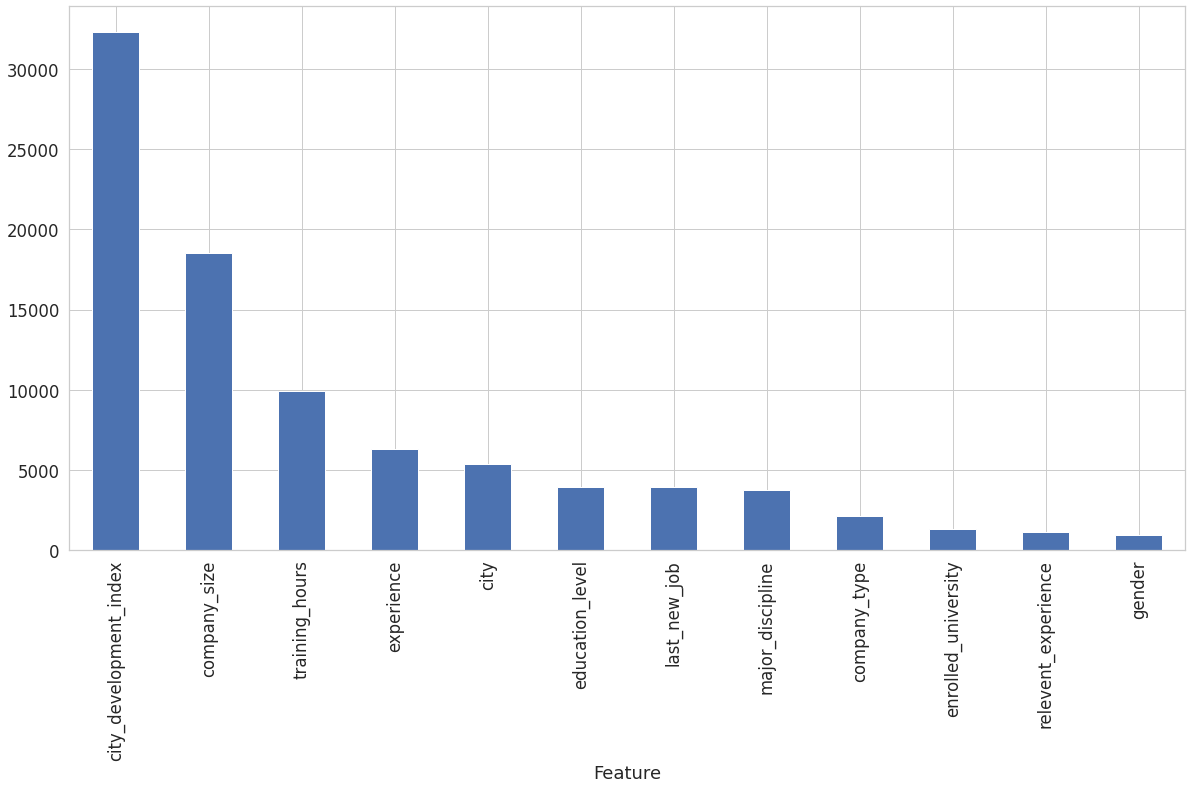

In [16]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast', silent = False)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

# Шаг 9. Снова выполним предсказание на holdout и посмотрим на метрику качества

In [17]:
%%time

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

[2021-06-14 23:19:30,413] (INFO): Prediction for test data:
array([[0.04762448],
       [0.6185899 ],
       [0.06567395],
       ...,
       [0.19834751],
       [0.06344185],
       [0.05933513]], dtype=float32)
Shape = (3832, 1)


CPU times: user 3.23 s, sys: 291 ms, total: 3.52 s
Wall time: 1.3 s


In [18]:
logging.info('Check scores...')
logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))
logging.info('TEST score: {}'.format(roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])))

[2021-06-14 23:19:30,420] (INFO): Check scores...
[2021-06-14 23:19:30,426] (INFO): OOF score: 0.8097495517678559
[2021-06-14 23:19:30,429] (INFO): TEST score: 0.8188190505307487


Таким образом, при помощи `TabularUtilizedAutoML` нам удалось получить качество лучше чем у `TabularAutoML` пресета как с точки зрения OOF скора, так и результата на отложенной тестовой выборке.